In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

from survivors.ensemble import BootstrapCRAID
import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


### Metrics

In [39]:
def loglikelihood(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    likelihood = np.sum(np.log(sf_by_times) + np.log(hf_by_times))
    return likelihood

def kl(time, cens, sf, cumhf, bins):
    eq_sf = np.array([np.where(time > t, 1, 0)
                      for i, t in enumerate(bins)]).T
    
    kl_v = np.sum(sf * np.log((sf + 1e-10)/(eq_sf + 1e-10)) + np.abs(sf - eq_sf), axis=0)
    return np.trapz(kl_v, bins, axis=0) / (bins[-1] - bins[0])

In [541]:
def ibs(*args, **kwargs):
    return metr.ibs(*args, **kwargs)

def bal_ibs(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return (ibs_event + ibs_cens)/2

def ibs_WW(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time <= t, 
                                      estim_before[:, i], 
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    if axis == -1:  # mean ibs for each time and observation
        brier_scores = np.mean(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / (times[-1] - times[0])
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / (times[-1] - times[0])
    elif axis == 1:  # bs in time (for graphics)
        return np.mean(brier_scores, axis=1)
    return None

def bal_ibs_WW(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs_WW(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs_WW(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return (ibs_event + ibs_cens)/2


def ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time < t, 
                                      estim_before[:, i], 
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    
    ind = np.digitize(test_time, times) - 1
    n_cens = np.bincount(ind[~test_event], minlength=times.shape[0])
    
    N = np.sum(np.array([np.where(test_time < t, test_event, 1)
                        for i, t in enumerate(times)]), axis=1)

    if axis == -1:  # mean ibs for each time and observation
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1/N, 0) * np.sum(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / (times[-1] - times[0])
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / (times[-1] - times[0])
    elif axis == 1:  # bs in time (for graphics)
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1/N, 0) * np.sum(brier_scores, axis=1)        
        return brier_scores
    return None

def bal_ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs_remain(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs_remain(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return (ibs_event + ibs_cens)/2

ibs_list = [ibs, bal_ibs, 
            ibs_WW, bal_ibs_WW,
            ibs_remain, bal_ibs_remain]

In [505]:
import sksurv.metrics
import numpy as np
from numba import njit, jit
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index

def iauc(survival_train, survival_test, estimate, times, tied_tol=1e-8, axis=-1):
    if survival_train["cens"].sum() == 0:
        survival_train["cens"] = 1
        survival_test["cens"] = 1 - survival_test["cens"]
    if survival_test["cens"].sum() == 0:
        survival_test["cens"] = 1
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test)
    # estimate, times = _check_estimate_2d(estimate, test_time, times)
    estimate = np.array(estimate)
    n_samples = estimate.shape[0]
    n_times = times.shape[0]
    if estimate.ndim == 1:
        estimate = np.broadcast_to(estimate[:, np.newaxis], (n_samples, n_times))

    # fit and transform IPCW
    cens = sksurv.metrics.CensoringDistributionEstimator()
    cens.fit(survival_train)
    Ghat = cens.predict_proba(test_time[test_event])
    ipcw = np.zeros(test_time.shape[0])
    Ghat[Ghat == 0] = np.inf
    if not((Ghat == 0.0).any()):
        ipcw[test_event] = 1.0 / Ghat
    else:
        ipcw = np.ones(test_time.shape[0])

    # expand arrays to (n_samples, n_times) shape
    test_time = np.broadcast_to(test_time[:, np.newaxis], (n_samples, n_times))
    test_event = np.broadcast_to(test_event[:, np.newaxis], (n_samples, n_times))
    times_2d = np.broadcast_to(times, (n_samples, n_times))
    ipcw = np.broadcast_to(ipcw[:, np.newaxis], (n_samples, n_times))

    # sort each time point (columns) by risk score (descending)
    o = np.argsort(-estimate, axis=0)
    test_time = np.take_along_axis(test_time, o, axis=0)
    test_event = np.take_along_axis(test_event, o, axis=0)
    estimate = np.take_along_axis(estimate, o, axis=0)
    ipcw = np.take_along_axis(ipcw, o, axis=0)

    is_case = (test_time <= times_2d) & test_event
    is_control = test_time > times_2d
    n_controls = is_control.sum(axis=0)

    # prepend row of infinity values
    estimate_diff = np.concatenate((np.broadcast_to(np.infty, (1, n_times)), estimate))
    is_tied = np.absolute(np.diff(estimate_diff, axis=0)) <= tied_tol

    cumsum_tp = np.cumsum(is_case * ipcw, axis=0)
    cumsum_fp = np.cumsum(is_control, axis=0)
    true_pos = cumsum_tp / cumsum_tp[-1]
    false_pos = cumsum_fp / n_controls

    scores = np.empty(n_times, dtype=float)
    it = np.nditer((true_pos, false_pos, is_tied), order="F", flags=["external_loop"])
    with it:
        for i, (tp, fp, mask) in enumerate(it):
            idx = np.flatnonzero(mask) - 1
            # only keep the last estimate for tied risk scores
            tp_no_ties = np.delete(tp, idx)
            fp_no_ties = np.delete(fp, idx)
            # Add an extra threshold position
            # to make sure that the curve starts at (0, 0)
            tp_no_ties = np.r_[0, tp_no_ties]
            fp_no_ties = np.r_[0, fp_no_ties]
            scores[i] = np.trapz(tp_no_ties, fp_no_ties)

    scores[np.isnan(scores)] = 0
    if n_times == 1:
        return scores[0]
    
    if axis == -1:  # mean iauc for each time and observation
        surv = KaplanMeierFitter()
        surv.fit(survival_test["time"], survival_test["cens"]) 
        s_times = surv.survival_function_at_times(times).to_numpy()
        
        # compute integral of AUC over survival function
        d = -np.diff(np.r_[1.0, s_times])
        integral = (scores * d).sum()
        return integral / (1.0 - s_times[-1])
    elif axis == -2:
        surv = KaplanMeierFitter()
        surv.fit(survival_test["time"], survival_test["cens"]) 
        s_times = surv.survival_function_at_times(times).to_numpy()
        
        return np.trapz(scores, -s_times) / (s_times[0] - s_times[-1])
    elif axis == 0:  # ibs for each observation
        return None
    elif axis == 1:  # bs in time (for graphics)
        return scores
    return mean_auc

### Datasets loading

In [559]:
import survivors.datasets as ds
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
# X, y, features, categ, sch_nan = ds.load_smarto_dataset()

### Bins schemes

In [560]:
def bins_scheme(val, scheme=""):
    if scheme == "rank":
        u = np.unique(val)
        ind = np.digitize(val, u)
        return (ind * val.max() / ind.max()).astype("int")
    if scheme == "quantile":
        u = np.unique(np.quantile(val, np.linspace(0, 1, 100)))
        # u = np.hstack([0.0, np.quantile(val, np.linspace(0, 1, 100)), val.max()])
        ind = np.digitize(val, u)
        return (ind * val.max() / ind.max()).astype("int")  # u[ind].astype("int")
    if scheme == "log+scale":
        a = np.log(val+1)
        v = (val.max() - val.min())*(a - a.min())/(a.max() - a.min()) + val.min()
        return v.astype("int")
    return val

(-128.75, 2791.75)

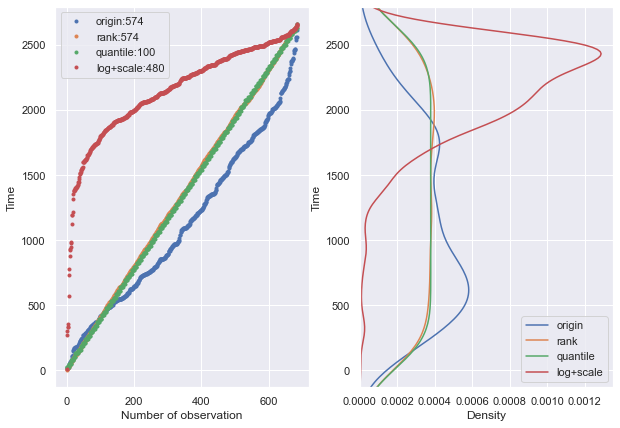

In [561]:
fig, axes = plt.subplots(figsize=(10, 7), ncols=2)
for scheme in ["origin", "rank", "quantile", "log+scale"]:
    y_new = y.copy()
    #y_new[np.argmax(y_new["time"] * y_new["cens"])]["time"] = 1000
    y_ = np.sort(bins_scheme(y_new["time"], scheme=scheme))
    axes[0].plot(y_, label=f"{scheme}:{np.unique(y_).shape[0]}", marker='o', markersize=3, linestyle="")
    
    sns.kdeplot(y=bins_scheme(y_new["time"], scheme=scheme), label=f"{scheme}", ax=axes[1])
axes[0].legend()
axes[0].set_xlabel("Number of observation")
axes[0].set_ylabel("Time")

axes[1].legend()
axes[1].set_ylabel("Time")


ymin, ymax = axes[0].get_ylim()
axes[1].set_ylim(ymin, ymax)

### Dependence IBS on true event time

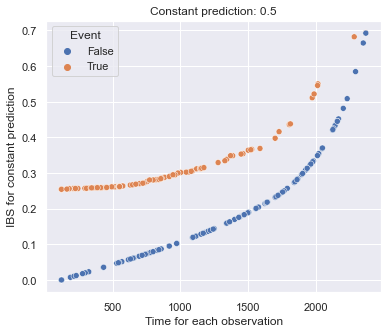

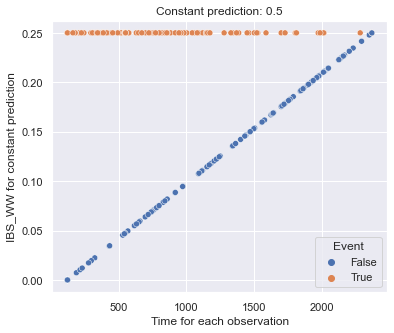

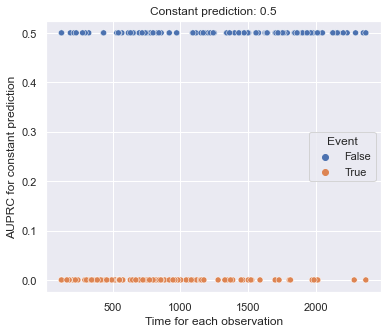

In [562]:
from survivors.experiments.grid import generate_sample

def plot_dependence_of_obs(X, y, metric, cnt_p=0.5): # [0.0, 0.5, 1.0]
    plt.figure(figsize=(6, 5))
    for scheme in ["origin"]:
        y_new = y.copy()
        y_new["time"] = bins_scheme(y_new["time"], scheme=scheme)
        for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y_new, 5, "CV+HOLD-OUT"):
            pass
        ibs_all = metric(y_tr, y_HO, np.ones((y_HO.shape[0], bins.shape[0]))*cnt_p, bins, axis=-1)
        ibs_cnt_p = metric(y_tr, y_HO, np.ones((y_HO.shape[0], bins.shape[0]))*cnt_p, bins, axis=0)
        pd_data = pd.DataFrame(y_HO)
        pd_data["Event"] = pd_data["cens"]
        sns.scatterplot(data=pd_data, x="time", y=ibs_cnt_p, hue="Event", palette="deep")
    plt.title(f"Constant prediction: {cnt_p}")
    plt.xlabel("Time for each observation")
    plt.ylabel(f"{metric.__name__.upper()} for constant prediction")
    plt.show()

plot_dependence_of_obs(X, y, metr.ibs)
plot_dependence_of_obs(X, y, metr.ibs_WW)
plot_dependence_of_obs(X, y, metr.auprc)

### Dependence IBS and IAUC on bins

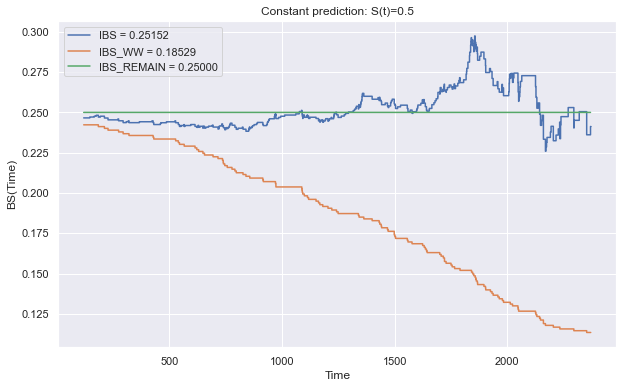

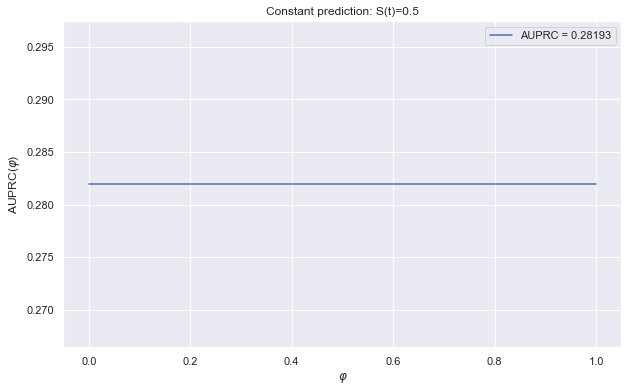

In [563]:
from survivors.experiments.grid import generate_sample

def plot_dependence_of_time(X, y, l_metrics):
    for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
        pass
    plt.figure(figsize=(10, 6))
    for m in l_metrics:
        bins = bins[:-1]
        base_sf = np.ones((y_HO.shape[0], bins.shape[0]))*0.5

        m_all = m(y_tr, y_HO, base_sf, bins, axis=1)
        m_mean = m(y_tr, y_HO, base_sf, bins, axis=-1)
        
        if m.__name__.find("auprc") != -1:
            bins = np.linspace(0, 1, 100)
        plt.step(bins, m_all,  label=f"{m.__name__.upper()} = {m_mean:.5f}")
    
    plt.legend()
    plt.title(f"Constant prediction: S(t)=0.5")
    plt.xlabel("Time")
    if m.__name__.find("auprc") != -1:
        plt.xlabel(r"$\varphi$")
        plt.ylabel(r"AUPRC($\varphi$)")
    else:
        plt.xlabel("Time")
        plt.ylabel("BS(Time)")

plot_dependence_of_time(X, y, [metr.ibs, metr.ibs_WW, metr.ibs_remain])
plot_dependence_of_time(X, y, [metr.auprc])

Text(0, 0.5, 'AUC(Time)')

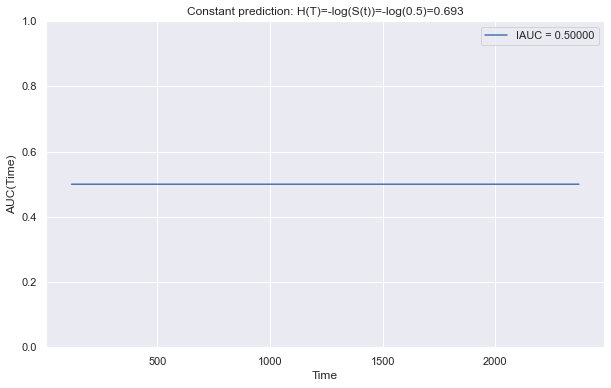

In [564]:
from survivors.experiments.grid import generate_sample
for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
    pass

plt.figure(figsize=(10, 6))
for m in [iauc]:
    bins = bins[:-1]
    base_sf = np.ones((y_HO.shape[0], bins.shape[0]))*0.5
    base_hf = -np.log(base_sf)
    kmf = KaplanMeierFitter()

    kmf.fit(y_HO["time"], y_HO["cens"])
    one_km_sf = kmf.survival_function_at_times(bins).to_numpy()
    km_sf = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0)
    base_hf = -np.log(km_sf)

    m_all = m(y_tr, y_HO, base_hf, bins, axis=1)
    m_mean = m(y_tr, y_HO, base_hf, bins, axis=-1)
    plt.step(bins, m_all,  label=f"{m.__name__.upper()} = {m_mean:.5f}") #label=f"max bins:{max_time}, ibs={ibs_mean:.5f}")

# plt.step(bins, km_sf[0])
plt.legend()
plt.ylim((0.0, 1.0))
plt.title(f"Constant prediction: H(T)=-log(S(t))=-log(0.5)=0.693")
plt.xlabel("Time")
plt.ylabel("AUC(Time)")

Text(0, 0.5, 'Impact')

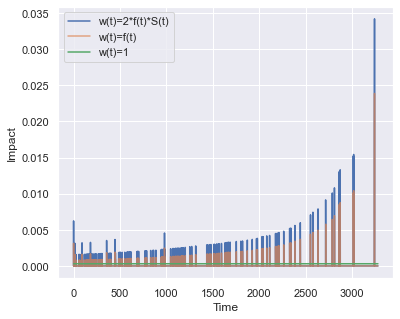

In [510]:
# h_est = np.hstack([0.0, -np.diff(np.log(one_km_sf))])
f_est = np.hstack([0.0, -np.diff(one_km_sf)])
plt.figure(figsize=(6, 5))
plt.step(bins, 2*one_km_sf*f_est,  label=f"w(t)=2*f(t)*S(t)", alpha=1)
plt.step(bins, f_est,  label=f"w(t)=f(t)", alpha=0.7)
plt.step(bins, np.ones_like(bins)/(bins[-1] - bins[0]), label=f"w(t)=1")
# plt.step(bins, km_sf[0])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Impact")

Text(0, 0.5, 'Impact')

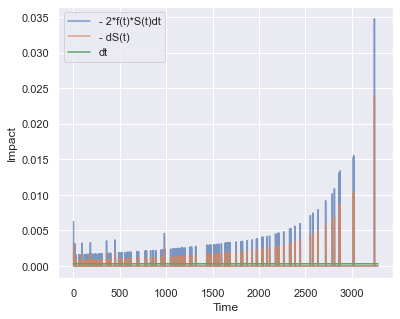

In [512]:
plt.figure(figsize=(6, 5))
plt.step(bins[1:], -1*np.diff(km_sf**2)[0],  label=f"- 2*f(t)*S(t)dt", alpha=0.7)
plt.step(bins[1:], -1*np.diff(km_sf)[0],  label=f"- dS(t)", alpha=0.7)
# plt.step(bins, km_sf[0])
plt.step(bins[1:], np.diff(bins)/(bins[-1] - bins[0]), label=f"dt")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Impact")

### Disbalance analysis

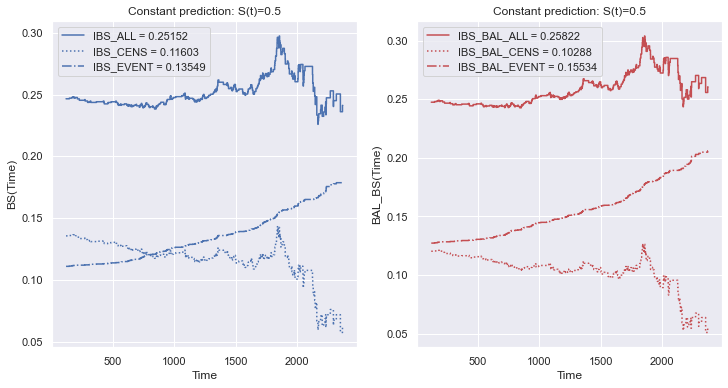

In [568]:
from survivors.experiments.grid import generate_sample

def plot_disbalance(X, y, m, m_bal):
    for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
        pass

    fig, axes = plt.subplots(figsize=(12, 6), ncols=2)
    bins = bins[:-1]
    best_sf = np.ones((y_HO.shape[0], bins.shape[0]))*0.5
    best_hf = -np.log(best_sf)

    N_event = np.sum(y_HO["cens"])
    N_cens = y_HO.shape[0] - N_event
    N = y_HO.shape[0]

    m_event = m(y_tr, y_HO[y_HO["cens"]], best_sf[y_HO["cens"]], bins, axis=1)
    m_event_val = m(y_tr, y_HO[y_HO["cens"]], best_sf[y_HO["cens"]], bins, axis=-1)

    m_cens = m(y_tr, y_HO[~y_HO["cens"]], best_sf[~y_HO["cens"]], bins, axis=1)
    m_cens_val = m(y_tr, y_HO[~y_HO["cens"]], best_sf[~y_HO["cens"]], bins, axis=-1)

    m_all = m(y_tr, y_HO, best_sf, bins, axis=1)
    m_all_val = m(y_tr, y_HO, best_sf, bins, axis=-1)

    m_bal_arr = m_bal(y_tr, y_HO, best_sf, bins, axis=1)
    m_bal_mean = m_bal(y_tr, y_HO, best_sf, bins, axis=-1)

    #plt.fill_between(bins_, ibs_all, step="pre", alpha=0.3)
    if m.__name__.find("auprc") != -1:
        bins = np.linspace(0, 1, 100)
        axes[0].step(bins, m_all,  label=f"AUPRC_ALL = {m_all_val:.5f}", color="b")
        axes[0].step(bins, m_cens,  label=f"AUPRC_CENS = {m_cens_val:.5f}", ls=':', color="b")
        axes[0].step(bins, m_event,  label=f"AUPRC_EVENT = {m_event_val:.5f}", ls='-.', color="b")

        axes[1].step(bins, m_bal_arr,  label=f"AUPRC_BAL_ALL = {m_bal_mean:.5f}", color="r")
        axes[1].step(bins, m_cens,  label=f"AUPRC_BAL_CENS = {m_cens_val:.5f}", ls=':', color="r")
        axes[1].step(bins, m_event,  label=f"AUPRC_BAL_EVENT = {m_event_val:.5f}", ls='-.', color="r")
    else:
        axes[0].step(bins, m_all,  label=f"IBS_ALL = {m_all_val:.5f}", color="b")
        axes[0].step(bins, N_cens/N*m_cens,  label=f"IBS_CENS = {N_cens/N*m_cens_val:.5f}", ls=':', color="b")
        axes[0].step(bins, N_event/N*m_event,  label=f"IBS_EVENT = {N_event/N*m_event_val:.5f}", ls='-.', color="b")

        axes[1].step(bins, m_bal_arr,  label=f"IBS_BAL_ALL = {m_bal_mean:.5f}", color="r")
        axes[1].step(bins, m_cens/2,  label=f"IBS_BAL_CENS = {m_cens_val/2:.5f}", ls=':', color="r")
        axes[1].step(bins, m_event/2,  label=f"IBS_BAL_EVENT = {m_event_val/2:.5f}", ls='-.', color="r")
    #     plt.step(bins, ibs_bal,  label=f"IBS_BAL = {ibs_bal_mean:.5f}", color="r")

    axes[0].legend()
    axes[1].legend()
    axes[0].set_title(f"Constant prediction: S(t)=0.5")
    axes[1].set_title(f"Constant prediction: S(t)=0.5")
    if m.__name__.find("auprc") != -1:
        axes[0].set_xlabel(r"$\varphi$")
        axes[1].set_xlabel(r"$\varphi$")
        axes[0].set_ylabel(r"AUPRC($\varphi$)")
        axes[1].set_ylabel(r"BAL_AUPRC($\varphi$)")
    else:
        axes[0].set_xlabel("Time")
        axes[1].set_xlabel("Time")
        axes[0].set_ylabel("BS(Time)")
        axes[1].set_ylabel("BAL_BS(Time)")

plot_disbalance(X, y, ibs, bal_ibs) # metr.auprc, metr.bal_auprc) # metr.ibs, metr.bal_ibs)

In [427]:
group = "bstr_full_WB" # "bstr_full_WB"  # "scsurv"

glob_dir = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/many_ds/"
glob_dir = os.path.join(glob_dir, group)

In [580]:
def to_str_from_dict_list(d, strat):
    if isinstance(strat, str):
        return str(d.get(strat, ""))
    elif isinstance(strat, list):
        return ";".join([str(d.get(e, "")) for e in strat])
    return None

def print_res_sample(datas: list):
    feats = ["CRIT", "CI_mean",
             "IAUC_mean", "IAUC_TI_mean",
             "AUPRC_mean", "EVENT_AUPRC_mean", "BAL_AUPRC_mean"]
#     fig, axes = plt.subplots(figsize=(15, 6), ncols=3)
    lst_df = []
    for dat in datas:
        print("="*10, dat[-dat[::-1].find("\\"):], "="*10)
        res_table = pd.read_excel(os.path.join(glob_dir, dat))
        res_table["Stratify"] = res_table["PARAMS"].apply(lambda x: to_str_from_dict_list(eval(x), ["criterion", "ens_metric_name"]))
        res_table["Stratify"] = res_table["METHOD"] + "(" + res_table["Stratify"] + ")"
        res_table.set_index("Stratify")[feats].round(4).to_csv(dat[:-5]+"_res.csv", sep="&")
#         lst_df.append(res_table)
    
#     full_df = pd.concat(lst_df)
#     for i, m in enumerate(["CI", "AUPRC", "BAL_AUPRC"]):
#         full_df[m] = full_df[m].apply(lambda x: np.array(list(map(float, x[1:-1].split()))))
#         explode_res = full_df.loc[:, [m, "Stratify"]].set_index(['Stratify']).apply(lambda x: x.explode()).reset_index()
#         explode_res.boxplot(column=m, by="Stratify", rot=45, ax=axes[i])
#     plt.show()

ch_metrs = ["likelihood"]  # ["conc", "IBS", "IBS_WW", "IBS_REMAIN"]
for dataset in ["flchain"]: #["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2", "actg", "flchain"]:
    print("="*10, dataset, "="*10)
    datasets_sc = [f"{metr}_{group}_origin_{dataset}_CV+SAMPLE_best.xlsx" for metr in ch_metrs]
    print_res_sample(datasets_sc)

========== flchain ==========
========== ikelihood_bstr_full_WB_origin_flchain_CV+SAMPLE_best.xlsx ==========


========== GBSG ==========


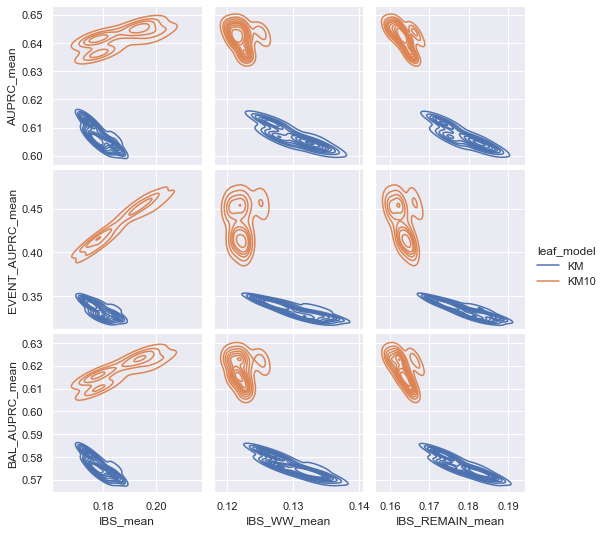

========== PBC ==========


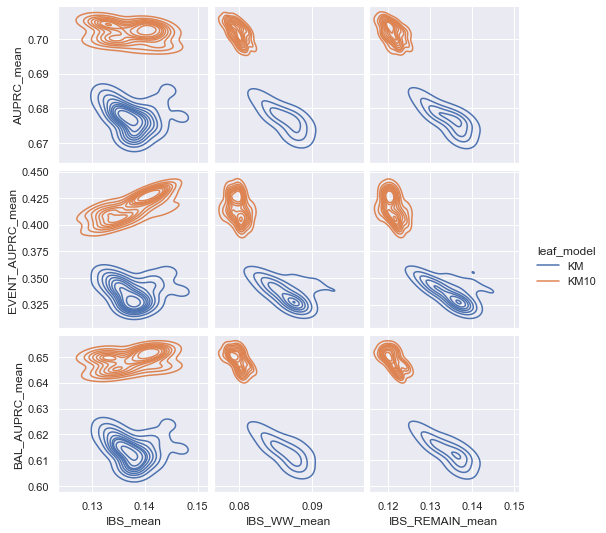

========== WUHAN ==========


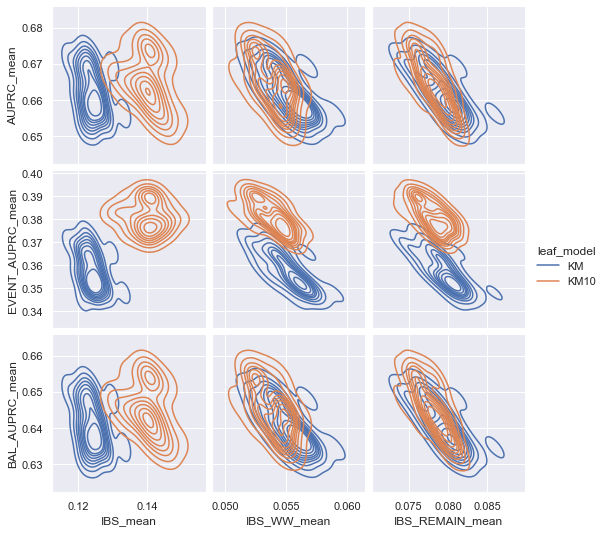

========== rott2 ==========


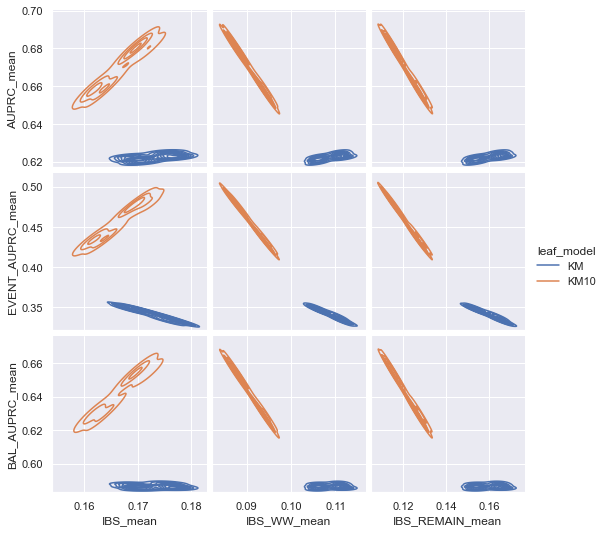

========== smarto ==========


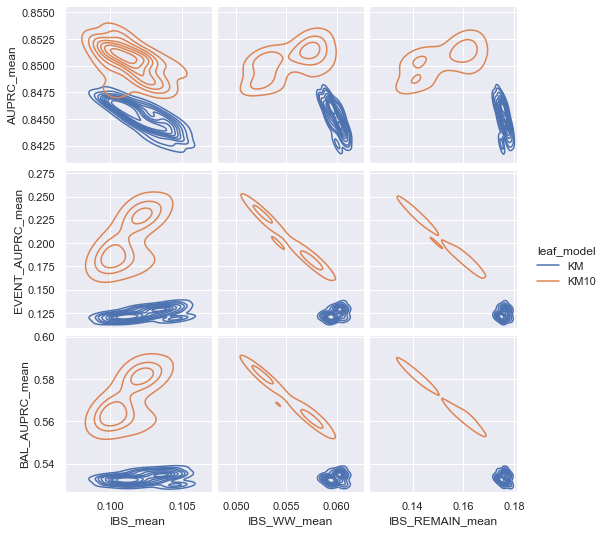

========== support2 ==========


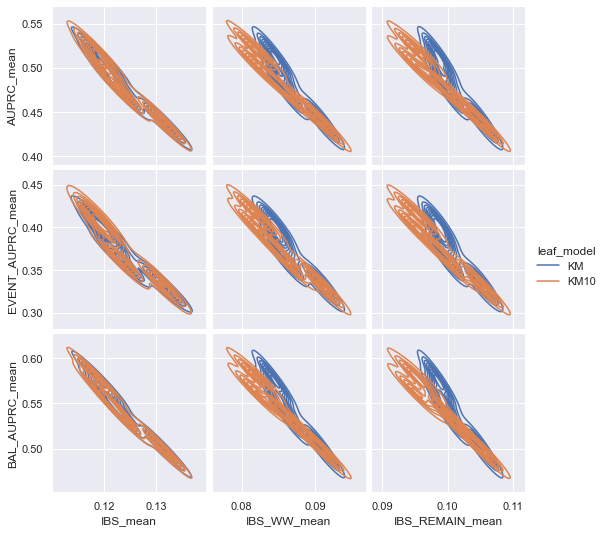

========== actg ==========


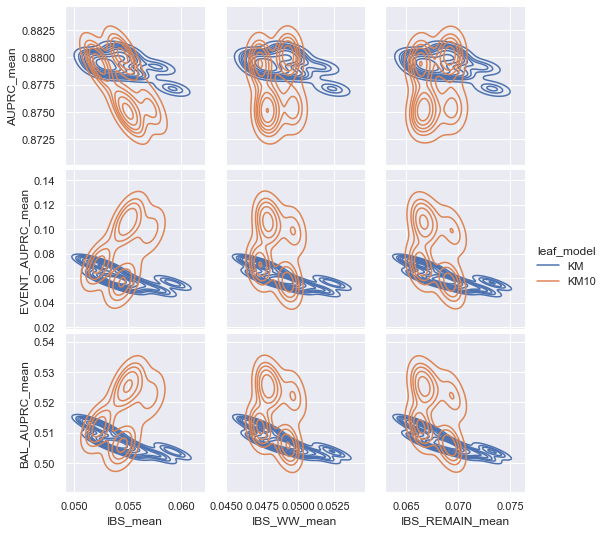

In [576]:
def pair_compare(df, strata):
#     df = df[df["PARAMS"].apply(lambda x: eval(x)["leaf_model"]=="base_zero_after")]
    df[strata] = df["PARAMS"].apply(lambda x: eval(x)[strata])
    if strata == "leaf_model":
        df[strata] = df[strata].replace(regex={'base_fast': 'KM', 'base_zero_after': 'KM10'})
    sns.pairplot(x_vars=["IBS_mean", "IBS_WW_mean", "IBS_REMAIN_mean"],
         y_vars=["AUPRC_mean", "EVENT_AUPRC_mean", "BAL_AUPRC_mean"],
         data=df, hue=strata, palette="deep", kind="kde")
    plt.show()

def pair_compare_load(dataset, group, m, strata):
    datasets_sc = f"{m}_{group}_origin_{dataset}_CV+SAMPLE_full.xlsx"
    df = pd.read_excel(os.path.join(glob_dir, datasets_sc))
    pair_compare(df, strata)

def compare_by_m(dataset, group, ens_ms):
    lst_df = []
    for m in ens_ms:
        datasets_sc = f"{m}_{group}_origin_{dataset}_CV+SAMPLE_full.xlsx"
        df = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        lst_df.append(df)
    df = pd.concat(lst_df, ignore_index=True)
    df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x)["ens_metric_name"])
    pair_compare(df, "ens_metric_name")

for ds in ["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2", "actg"]:
    print("="*10, ds, "="*10)
    pair_compare_load(ds, group, "IBS_WW", 'leaf_model')
#     compare_by_m(ds, group, ["IBS", "IBS_WW", "IBS_REMAIN"])

### AUPRC

In [432]:
def auprc(survival_train, survival_test, estimate, times, axis=-1):
    time = survival_test["time"]
    event = survival_test["cens"]

    steps = np.linspace(1e-5, 1 - 1e-5, 100)
    before_time = np.dot(time[:, np.newaxis], steps[np.newaxis, :])
    after_time = np.dot(time[:, np.newaxis], 1/steps[np.newaxis, :])
    before_ind = np.clip(np.searchsorted(times, before_time), 0, times.shape[0]-1)
    after_ind = np.clip(np.searchsorted(times, after_time), 0, times.shape[0]-1)

    est = np.take_along_axis(estimate, before_ind, axis=1)
    est[event] -= np.take_along_axis(estimate[event], after_ind[event], axis=1)
    
    if axis == -1:  # mean for each time and observation
        est = np.mean(est, axis=0)
        return np.trapz(est, steps)
    elif axis == 0:  # for each observation
        return np.trapz(est, steps)
    elif axis == 1:  # in time (for graphics)
        est = est.mean(axis=0)    
        return est
    elif axis == 2:  # source
        return est
    return None

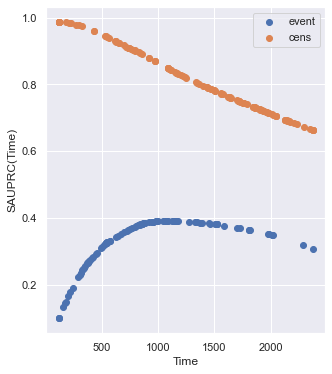

0.6021519328414829
0.33025516233960805 0.8124470912765268
0.5713511268080674


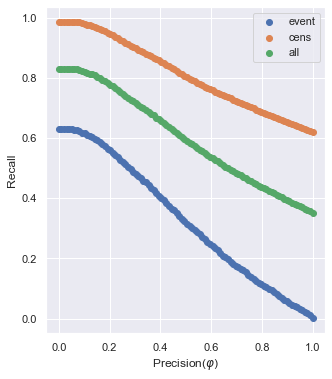

In [94]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0)
# estimate[:] = 0.5
steps = np.linspace(1e-5, 1 - 1e-5, 100)
event = y_HO["cens"]

m_obs = auprc(None, y_HO, estimate, bins, axis=0)

plt.figure(figsize=(5, 6))
plt.scatter(y_HO[y_HO["cens"]]["time"], m_obs[event], label="event")
plt.scatter(y_HO[~y_HO["cens"]]["time"], m_obs[~event], label="cens")
plt.xlabel("Time")
plt.ylabel("SAUPRC(Time)")
plt.legend()
plt.show()

print(m_obs.mean())
print(m_obs[y_HO["cens"]].mean(), m_obs[~y_HO["cens"]].mean())
print((m_obs[y_HO["cens"]].mean() + m_obs[~y_HO["cens"]].mean())/2)

plt.figure(figsize=(5, 6))
m_src = auprc(None, y_HO, estimate, bins, axis=2)
plt.scatter(steps, m_src[y_HO["cens"]].mean(axis=0), label="event")
plt.scatter(steps, m_src[~y_HO["cens"]].mean(axis=0), label="cens")
plt.scatter(steps, m_src.mean(axis=0), label="all")
plt.xlabel(r"Precision($\varphi$)")
plt.ylabel("Recall")
plt.legend()
plt.show()

3 (True, 698.)


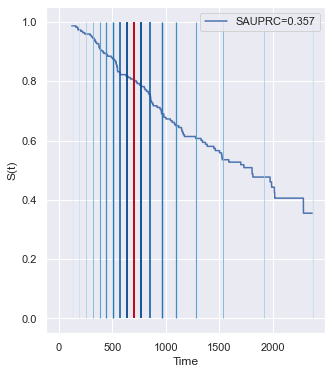

4 (True, 1807.)


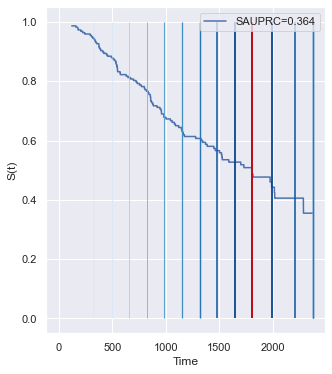

In [95]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0)
# estimate[:] = 0.5
time = y_HO["time"]
event = y_HO["cens"]

steps = np.linspace(1e-5, 1 - 1e-5, 12)
before_time = np.dot(time[:, np.newaxis], steps[np.newaxis, :])
after_time = np.dot(time[:, np.newaxis], 1/steps[np.newaxis, :])
before_ind = np.clip(np.searchsorted(bins, before_time), 0, bins.shape[0]-1)
after_ind = np.clip(np.searchsorted(bins, after_time), 0, bins.shape[0]-1)

est = np.take_along_axis(estimate, before_ind, axis=1)
est[event] -= np.take_along_axis(estimate[event], after_ind[event], axis=1)

for i in [3, 4]:
    print(i, y_HO[i])
    plt.figure(figsize=(5, 6))
    plt.step(bins, estimate[i], label=f"SAUPRC={np.trapz(est[i], steps):.3f}")
    cmap = plt.get_cmap('Blues')
    plt.vlines(np.clip(before_time[i], 0, bins.max()), 0, 1, colors=cmap(np.linspace(0, 1, steps.shape[0])), 
               linewidth=np.linspace(0, 2, steps.shape[0]))
    plt.vlines(np.clip(after_time[i], 0, bins.max()), 0, 1, colors=cmap(np.linspace(0, 1, steps.shape[0])), 
               linewidth=np.linspace(0, 2, steps.shape[0]))
    plt.vlines(y_HO[i]["time"], 0, 1, colors="red")
    plt.xlabel(r"Time")
    plt.ylabel("S(t)")
    plt.legend()
    plt.show()

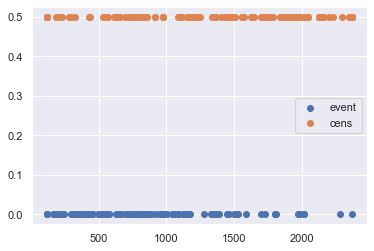

0.28193268722466963
0.0 0.49999000000000016
0.24999500000000008


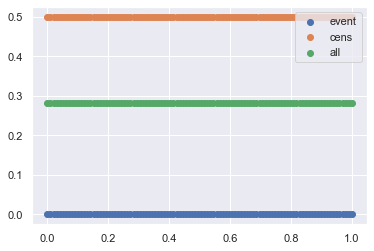

In [96]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0)
estimate[:] = 0.5
time = y_HO["time"]
event = y_HO["cens"]

steps = np.linspace(1e-5, 1 - 1e-5, 100)
before_time = np.dot(time[:, np.newaxis], steps[np.newaxis, :])
after_time = np.dot(time[:, np.newaxis], 1/steps[np.newaxis, :])
before_ind = np.clip(np.searchsorted(bins, before_time), 0, bins.shape[0]-1)
after_ind = np.clip(np.searchsorted(bins, after_time), 0, bins.shape[0]-1)

est = np.take_along_axis(estimate, before_ind, axis=1)
est[event] -= np.take_along_axis(estimate[event], after_ind[event], axis=1)

plt.scatter(time[event], np.trapz(est[event], steps), label="event")
plt.scatter(time[~event], np.trapz(est[~event], steps), label="cens")
plt.legend()
plt.show()
print(np.trapz(est, steps).mean())
print(np.trapz(est[event], steps).mean(), np.trapz(est[~event], steps).mean())
print((np.trapz(est[event], steps).mean() + np.trapz(est[~event], steps).mean())/2)

plt.scatter(steps, est[event].mean(axis=0), label="event")
plt.scatter(steps, est[~event].mean(axis=0), label="cens")
plt.scatter(steps, est.mean(axis=0), label="all")
plt.legend()
plt.show()

### Проверка устойчивости при калибровке

C:\Users\vasiliev\AppData\Local\Temp\ipykernel_8280\3019207330.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_event = res_event.append(l_event, ignore_index=True)
C:\Users\vasiliev\AppData\Local\Temp\ipykernel_8280\3019207330.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_cens = res_cens.append(l_cens, ignore_index=True)
C:\Users\vasiliev\AppData\Local\Temp\ipykernel_8280\3019207330.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_event = res_event.append(l_event, ignore_index=True)
C:\Users\vasiliev\AppData\Local\Temp\ipykernel_8280\3019207330.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_cens = r

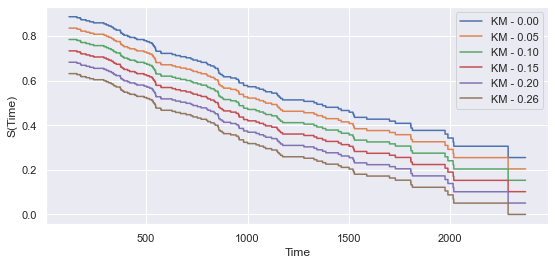

(        ibs    ibs_WW ibs_remain     auprc
 0    0.2415  0.190052   0.189927  0.330255
 1  0.223203  0.171712   0.171631  0.330255
 2  0.211377  0.158579   0.158543  0.330255
 3  0.206022  0.150653   0.150661  0.330255
 4  0.207137  0.147935   0.147987  0.330255
 5  0.214725  0.150425   0.150521  0.330255,
         ibs    ibs_WW ibs_remain     auprc
 0  0.182169  0.083251    0.08336  0.712449
 1  0.220686  0.104334   0.104465  0.661424
 2   0.26349  0.128233   0.128387  0.610399
 3  0.310579  0.154947   0.155128  0.559374
 4  0.361954  0.184477   0.184686  0.508349
 5  0.417615  0.216823   0.217062  0.457324)

In [593]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0) - 0.1
# estimate[:] = 0.5
event = y_HO["cens"]
a_min = np.min(estimate)

ms = [ibs, ibs_WW, ibs_remain, auprc]
plt.figure(figsize=(9, 4))
res_event = pd.DataFrame([], columns=[m.__name__ for m in ms])
res_cens = pd.DataFrame([], columns=[m.__name__ for m in ms])

for corr_i in [a_min*i/5 for i in range(0, 6)]:
    estimate_1 = estimate - corr_i
    l_event = {}
    l_cens = {}
    for m in [ibs, ibs_WW, ibs_remain, auprc]:
        #print(m.__name__)
        m_obs = m(y_tr, y_HO, estimate_1, bins, axis=0)
        l_event[m.__name__] = m_obs[event].mean()
        l_cens[m.__name__] = m_obs[~event].mean()
        #print(f"{m_obs[event].mean():0.3f}, {m_obs[~event].mean():0.3f}")
    plt.step(bins, estimate_1[0], label = f"KM - {corr_i:0.2f}")
    res_event = res_event.append(l_event, ignore_index=True)
    res_cens = res_cens.append(l_cens, ignore_index=True)
    
plt.xlabel("Time")
plt.ylabel("S(Time)")

plt.legend()
plt.show()
res_event, res_cens

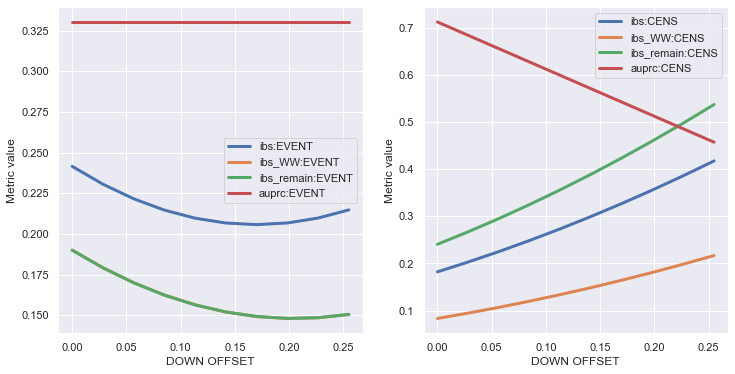

In [101]:
estimate = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0) - 0.1
# estimate[:] = 0.5
event = y_HO["cens"]
a_min = np.min(estimate)

x = np.linspace(0, a_min, 10)  # [a_min*i/5 for i in range(0, 26)]
# plt.figure(figsize=(9, 6))
fig, axes = plt.subplots(figsize=(12, 6), ncols=2)

for m in [ibs, ibs_WW, ibs_remain, auprc]:
    # print(m.__name__)
    l_ev = []
    l_cens = []
    for corr_i in x:
        steps = np.linspace(1e-5, 1 - 1e-5, 100)
        estimate_1 = estimate - corr_i
        m_ev = m(y_tr, y_HO[event], estimate_1[event], bins, axis=-1)
        m_cens = m(y_tr, y_HO[~event], estimate_1[~event], bins, axis=-1)
        # print(f"{m_ev:.3f}, {m_cens:.3f}")
        l_ev.append(m_ev)
        l_cens.append(m_cens)
    axes[0].plot(x, l_ev, label=f"{m.__name__}:EVENT", linewidth=3)
    axes[1].plot(x, l_cens, label=f"{m.__name__}:CENS", linewidth=3)

# plt.xlabel("DOWN OFFSET")
# plt.ylabel("Metric value")
# plt.legend()
# plt.show()

axes[0].set_xlabel("DOWN OFFSET")
axes[0].set_ylabel("Metric value")
axes[0].legend()

axes[1].set_xlabel("DOWN OFFSET")
axes[1].set_ylabel("Metric value")
axes[1].legend()

plt.show()

### PLOTS OF AUPRC by event for best models

In [204]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.tree import SurvivalTree
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis

from survivors.ensemble import BootstrapCRAID

dataset = "flchain"
glob_dir = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/many_ds/"
file_name = f"shared_IBS_{dataset}_CV+SAMPLE_best.xlsx"
# file_name = f"IBS_scsurv_origin_GBSG_CV+SAMPLE_best.xlsx"

In [205]:
from survivors.experiments import grid as exp
DATASETS_LOAD = {
    "GBSG": ds.load_gbsg_dataset,
    "PBC": ds.load_pbc_dataset,
    "WUHAN": ds.load_wuhan_dataset,

    "actg": ds.load_actg_dataset,
    "flchain": ds.load_flchain_dataset,
    "smarto": ds.load_smarto_dataset,
    "rott2": ds.load_rott2_dataset,
    "support2": ds.load_support2_dataset,
}

def run(M_P, dataset="GBSG", except_stop="all", dir_path=None, bins_sch="", best_metric="IBS"):
    lst_metrics = ["AUPRC_by_obs"]
    X, y, features, categ, sch_nan = DATASETS_LOAD[dataset]()
    experim = exp.Experiments(folds=20, except_stop=except_stop, dataset_name=dataset, mode="HOLD-OUT", bins_sch=bins_sch)
    experim.set_metrics(lst_metrics)
    experim.add_metric_best(best_metric)
    for m_p in M_P:
        m, hyp = m_p
        if m.__name__.find("CRAID") != -1:
            hyp["categ"] = [categ]
        experim.add_method(m, hyp)
    experim.run(X, y, dir_path=dir_path, verbose=1)
    return experim

M_P = []
res_table = pd.read_excel(os.path.join(glob_dir, file_name))
for i, row in res_table.iterrows():
    M_P.append((eval(row["METHOD"]), {k:[v] for k, v in eval(row["PARAMS"]).items()}))

t = run(M_P, dataset=dataset, except_stop="all", dir_path=None, bins_sch="")

<class 'sksurv.tree.tree.SurvivalTree'> {'max_depth': [None], 'max_features': ['sqrt'], 'min_samples_leaf': [10], 'random_state': [123], 'splitter': ['random']}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF SurvivalTree: 26.536501169204712 {'AUPRC_by_obs': [0.8410436330031775, array([0.99998   , 0.99998   , 0.99998   , ..., 0.97036627, 0.99998   ,
       0.99998   ])]}
<class 'sksurv.ensemble.forest.RandomSurvivalForest'> {'max_depth': [None], 'min_samples_leaf': [10], 'n_estimators': [100], 'random_state': [123]}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF RandomSurvivalForest: 598.0279784202576 {'AUPRC_by_obs': [0.8492098962126275, array([0.99027821, 0.99998   , 0.99950639, ..., 0.9927835 , 0.99721632,
       0.99476048])]}
<class 'sksurv.ensemble.boosting.ComponentwiseGradientBoostingSurvivalAnalysis'> {'dropout_rate': [0.0], 'learning_rate': [0.5], 'loss': ['coxph'], 'n_estimators': [100], 'random_state': [123], 'subsample': [1.0]}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF ComponentwiseGradientBoostingSurvivalAnalysis: 549.9908931255341 {'AUPRC_by_obs': [0.7629568078712722, array([0.92797951, 0.93680943, 0.93132857, ..., 0.94527488, 0.93911386,
       0.94534261])]}
<class 'sksurv.ensemble.boosting.GradientBoostingSurvivalAnalysis'> {'learning_rate': [0.1], 'loss': ['coxph'], 'max_depth': [20], 'max_features': ['sqrt'], 'min_samples_leaf': [20], 'n_estimators': [100], 'random_state': [123]}


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF GradientBoostingSurvivalAnalysis: 558.721467256546 {'AUPRC_by_obs': [0.8482597709394948, array([0.98434554, 0.98609408, 0.9858047 , ..., 0.98594499, 0.98523451,
       0.98678486])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['maxcombo'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.055  0.059  0.0579 0.0546 0.0519 0.0523 0.0509 0.05   0.0488 0.0476
 0.0475 0.0466 0.0461 0.0457 0.0456 0.0455 0.0453 0.045  0.0448 0.0445
 0.0444 0.0442 0.044  0.0442 0.0441 0.0441 0.044  0.044  0.0439 0.0439
 0.0438 0.0438 0.0438 0.0438 0.0438 0.0439 0.0438 0.0439 0.0439 0.0438
 0.0439 0.0438 0.0438 0.0437 0.0437 0.0437 0.0436 0.0436 0.0437 0.0436]
fitted: 47 models.
[0.055  0.0524 0.0572 0.0535 0.0519 0.0513 0.0496 0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3062.613472223282 {'AUPRC_by_obs': [0.8529618287367722, array([0.95991696, 0.99998   , 0.99689148, ..., 0.99998   , 0.9969871 ,
       0.99998   ])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['peto'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0541 0.0544 0.0568 0.0536 0.0521 0.0519 0.0507 0.0495 0.0489 0.0478
 0.0473 0.0465 0.0459 0.0456 0.0455 0.0456 0.0453 0.0451 0.0449 0.0447
 0.0445 0.0444 0.0443 0.0443 0.0442 0.0441 0.0441 0.0441 0.0441 0.0441
 0.044  0.0441 0.0441 0.044  0.044  0.044  0.0439 0.044  0.044  0.044
 0.044  0.044  0.044  0.044  0.0439 0.0439 0.0438 0.0439 0.0439 0.0438]
fitted: 47 models.
[0.0538 0.0518 0.0546 0.0516 0.0503 0.0502 0.0492 0.0484 0.0476 0.0465
 0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3087.8225588798523 {'AUPRC_by_obs': [0.8528430834295823, array([0.96365497, 0.99998   , 0.9894463 , ..., 0.99750355, 0.99942532,
       0.98884856])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['tarone-ware'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0521 0.0591 0.057  0.0533 0.0516 0.0514 0.0504 0.0496 0.0491 0.048
 0.0478 0.047  0.0466 0.0462 0.046  0.046  0.0456 0.0453 0.0451 0.0448
 0.0445 0.0444 0.0443 0.0443 0.0443 0.0442 0.0441 0.0441 0.0441 0.044
 0.0439 0.044  0.044  0.0439 0.0439 0.0439 0.0438 0.0438 0.0439 0.0438
 0.0439 0.0438 0.0438 0.0439 0.0438 0.0438 0.0438 0.0438 0.0438 0.0438]
fitted: 37 models.
[0.0557 0.0538 0.0567 0.0527 0.0514 0.0508 0.0493 0.0489 0.0477 0.

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3044.9547975063324 {'AUPRC_by_obs': [0.8525744422548376, array([0.98304543, 0.99998   , 0.99608164, ..., 0.98719753, 0.99987899,
       0.98608836])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['wilcoxon'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0516 0.0582 0.0589 0.0559 0.0537 0.0536 0.0517 0.0504 0.0494 0.0483
 0.0479 0.047  0.0465 0.0462 0.046  0.046  0.0458 0.0456 0.0453 0.0451
 0.0449 0.0447 0.0446 0.0447 0.0445 0.0444 0.0444 0.0443 0.0444 0.0443
 0.0443 0.0442 0.0442 0.0442 0.0442 0.0441 0.044  0.044  0.0441 0.044
 0.0441 0.044  0.044  0.0441 0.044  0.0439 0.0439 0.0439 0.0439 0.0439]
fitted: 46 models.
[0.0552 0.0524 0.055  0.0519 0.0504 0.0503 0.0494 0.0484 0.0476 0.04

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3095.867123603821 {'AUPRC_by_obs': [0.852767483547439, array([0.98718126, 0.9999214 , 0.99917525, ..., 0.99770167, 0.99985118,
       0.99261949])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['logrank'], 'depth': [10], 'ens_metric_name': ['IBS'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0535 0.0535 0.0587 0.0546 0.0521 0.0518 0.0502 0.0493 0.0485 0.048
 0.0476 0.0469 0.0465 0.0459 0.0458 0.0457 0.0455 0.0452 0.0449 0.0447
 0.0445 0.0444 0.0443 0.0443 0.0442 0.0442 0.0442 0.0442 0.0442 0.0442
 0.0441 0.044  0.0441 0.0441 0.0441 0.0441 0.044  0.0439 0.044  0.0439
 0.044  0.0439 0.0439 0.0439 0.0439 0.0438 0.0438 0.0438 0.0437 0.0438]
fitted: 49 models.
[0.0563 0.0522 0.0536 0.0512 0.0503 0.0501 0.0488 0.0485 0.0479 0.0467


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3136.073700428009 {'AUPRC_by_obs': [0.85312792182898, array([0.96698485, 0.99998   , 0.99765281, ..., 0.9901416 , 0.99930733,
       0.99427001])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['maxcombo'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0508 0.0542 0.053  0.0502 0.0479 0.0483 0.0471 0.0464 0.0453 0.0442
 0.0441 0.0434 0.0429 0.0426 0.0424 0.0424 0.0422 0.0419 0.0417 0.0414
 0.0413 0.0411 0.041  0.0411 0.0411 0.0411 0.041  0.0409 0.0409 0.0409
 0.0408 0.0408 0.0408 0.0408 0.0408 0.0409 0.0408 0.0409 0.0409 0.0408
 0.0409 0.0408 0.0408 0.0408 0.0407 0.0407 0.0407 0.0407 0.0407 0.0406]
fitted: 50 models.
[0.0507 0.0484 0.0528 0.0495 0.0481 0.0477 0.0461 0.0453 0.0445 0.0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3231.8954479694366 {'AUPRC_by_obs': [0.8529773575149493, array([0.95991696, 0.99998   , 0.99689148, ..., 0.99998   , 0.9969871 ,
       0.99998   ])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['peto'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0501 0.0501 0.0521 0.0493 0.0481 0.0479 0.047  0.0459 0.0453 0.0443
 0.0439 0.0432 0.0427 0.0424 0.0423 0.0423 0.0421 0.0419 0.0418 0.0416
 0.0414 0.0413 0.0412 0.0412 0.0411 0.0411 0.0411 0.041  0.041  0.041
 0.041  0.041  0.041  0.0409 0.0409 0.041  0.0409 0.0409 0.041  0.0409
 0.041  0.0409 0.0409 0.041  0.0409 0.0408 0.0408 0.0409 0.0408 0.0408]
fitted: 46 models.
[0.0496 0.0478 0.0507 0.048  0.0468 0.0467 0.0459 0.0451 0.0443 0.043

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3239.9646191596985 {'AUPRC_by_obs': [0.8528274073021267, array([0.96365497, 0.99998   , 0.9894463 , ..., 0.99750355, 0.99942532,
       0.98884856])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['tarone-ware'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0482 0.0546 0.0526 0.0492 0.0478 0.0476 0.0467 0.046  0.0456 0.0446
 0.0444 0.0437 0.0433 0.043  0.0428 0.0428 0.0425 0.0422 0.0419 0.0417
 0.0414 0.0413 0.0412 0.0413 0.0412 0.0411 0.041  0.041  0.041  0.0409
 0.0408 0.0409 0.0409 0.0409 0.0408 0.0409 0.0408 0.0408 0.0409 0.0408
 0.0409 0.0408 0.0408 0.0409 0.0408 0.0408 0.0408 0.0408 0.0408 0.0408]
fitted: 31 models.
[0.0509 0.0494 0.052  0.0486 0.0475 0.047  0.0458 0.0454 0.04

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3231.5338521003723 {'AUPRC_by_obs': [0.8526692642134172, array([0.98304543, 0.99998   , 0.99608164, ..., 0.98719753, 0.99987899,
       0.98608836])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['wilcoxon'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0475 0.0536 0.0541 0.0515 0.0495 0.0495 0.0478 0.0467 0.0459 0.0448
 0.0445 0.0437 0.0433 0.043  0.0428 0.0429 0.0427 0.0425 0.0422 0.042
 0.0418 0.0417 0.0415 0.0416 0.0415 0.0413 0.0414 0.0413 0.0413 0.0413
 0.0412 0.0412 0.0411 0.0411 0.0411 0.041  0.0409 0.041  0.041  0.0409
 0.041  0.0409 0.0409 0.041  0.0409 0.0409 0.0409 0.0409 0.0409 0.0408]
fitted: 50 models.
[0.051  0.0485 0.0511 0.0482 0.0469 0.0469 0.046  0.0451 0.0444 0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


Iteration: 1/1
EXECUTION TIME OF BootstrapCRAID: 3311.712080001831 {'AUPRC_by_obs': [0.852772250365599, array([0.98718126, 0.9999214 , 0.99917525, ..., 0.99770167, 0.99985118,
       0.99261949])]}
<class 'survivors.ensemble.bootstrap.BootstrapCRAID'> {'balance': [None], 'categ': [['fac_sex', 'fac_chapter', 'fac_sample_yr', 'fac_mgus']], 'criterion': ['logrank'], 'depth': [10], 'ens_metric_name': ['IBS_WW'], 'leaf_model': ['base_zero_after'], 'max_features': [0.3], 'min_samples_leaf': [0.001], 'n_estimators': [50], 'n_jobs': [5], 'size_sample': [1.0]}
[0.0495 0.0494 0.0536 0.0501 0.0479 0.0478 0.0466 0.0457 0.0449 0.0446
 0.0442 0.0436 0.0432 0.0427 0.0426 0.0425 0.0423 0.042  0.0418 0.0416
 0.0415 0.0413 0.0412 0.0413 0.0412 0.0411 0.0412 0.0412 0.0411 0.0411
 0.041  0.041  0.041  0.0411 0.0411 0.041  0.0409 0.0409 0.041  0.0409
 0.041  0.0409 0.0409 0.0409 0.0409 0.0408 0.0408 0.0408 0.0407 0.0408]
fitted: 49 models.
[0.0517 0.0481 0.0496 0.0475 0.0467 0.0465 0.0455 0.0452 0.0446 0.0

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\experiments\grid.py:282: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.result_table = self.result_table.append(curr_dict, ignore_index=True)


In [214]:
t.result_table

METHOD  \
0                                    SurvivalTree   
1                            RandomSurvivalForest   
2   ComponentwiseGradientBoostingSurvivalAnalysis   
3                GradientBoostingSurvivalAnalysis   
4                                  BootstrapCRAID   
5                                  BootstrapCRAID   
6                                  BootstrapCRAID   
7                                  BootstrapCRAID   
8                                  BootstrapCRAID   
9                                  BootstrapCRAID   
10                                 BootstrapCRAID   
11                                 BootstrapCRAID   
12                                 BootstrapCRAID   
13                                 BootstrapCRAID   

                                               PARAMS         TIME  \
0   {'max_depth': None, 'max_features': 'sqrt', 'm...    26.536501   
1   {'max_depth': None, 'min_samples_leaf': 10, 'n...   598.027978   
2   {'dropout_rate': 0.0, 'learning_rate': 0.5, 'l...   549.990893   
3   {'learning_rate': 0.1, 'loss': 'coxph', 'max_d...   558.721467   
4   {'balance': None, 'categ': ['fac_sex', 'fac_ch...  3062.613472   
5   {'balance': None, 'categ': ['fac_sex', 'fac_ch...  3087.822559   
6   {'balance': None, 'categ': ['fac_sex', 'fac_ch...  3044.954798   
7   {'balance': None, 'categ': ['fac_sex', 'fac_ch...  3095.867124   
8   {'balance': None, 'categ': ['fac_sex', 'fac_ch...    3136.0737   
9   {'balance': None, 'categ': ['fac_sex', 'fac_ch...  3231.895448   
10  {'balance': None, 'categ': ['fac_sex', 'fac_ch...  3239.964619   
11  {'balance': None, 'categ': ['fac_sex', 'fac_ch...  3231.533852   
12  {'balance': None, 'categ': ['fac_sex', 'fac_ch...   3311.71208   
13  {'balance': None, 'categ': ['fac_sex', 'fac_ch...  3310.083284   

                                         AUPRC_by_obs         CRIT  \
0   [[0.5088726201715644, 0.99998, 0.5870753453453...                
1   [[0.5775316032673518, 0.9984690874579123, 0.61...                
2   [[0.26845801074103914, 0.9517472556548336, 0.5...                
3   [[0.575600266823277, 0.9890737005552414, 0.608...                
4   [[0.5578023124817755, 0.9988172125624866, 0.60...     maxcombo   
5   [[0.5927989167171015, 0.9993806030520384, 0.62...         peto   
6   [[0.5896413405463207, 0.9986480448251204, 0.61...  tarone-ware   
7   [[0.5859008998298434, 0.9992946355518292, 0.60...     wilcoxon   
8   [[0.608182694727038, 0.9969248132351506, 0.609...      logrank   
9   [[0.5521927484093636, 0.9988869798087374, 0.61...     maxcombo   
10  [[0.5976710780598756, 0.9993675726836045, 0.62...         peto   
11  [[0.5911910979654317, 0.9983902470493371, 0.61...  tarone-ware   
12  [[0.5756097853634664, 0.9993494647076828, 0.60...     wilcoxon   
13  [[0.608182694727038, 0.9969248132351506, 0.609...      logrank   

    AUPRC_by_obs_mean  
0            0.841763  
1            0.849242  
2            0.762902  
3            0.848339  
4            0.853027  
5            0.852886  
6            0.852602  
7            0.852790  
8            0.853161  
9            0.853042  
10           0.852871  
11           0.852692  
12           0.852795  
13           0.853176

In [215]:
X, y, features, categ, sch_nan = DATASETS_LOAD[dataset]()
for X_train, y_train, X_test, y_test, bins in exp.generate_sample(X, y, 20, mode="HOLD-OUT"):
    break

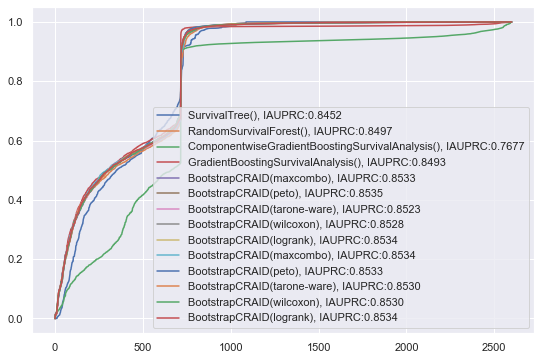

In [217]:
# def integ_by_obs_auprc(times_, auprc_):
#     ind = np.argsort(times_)
#     return np.trapz(auprc_[ind], times_[ind])/(np.max(times_) - np.min(times_))

def integ_by_obs_auprc(times_, auprc_):
    utimes = np.unique(times_)
    ind = np.digitize(times_, utimes) - 1
    return np.trapz(np.bincount(ind, weights=auprc_[ind])/np.bincount(ind), utimes)/(np.max(times_) - np.min(times_))

# plt.figure(figsize=(9, 6))
# for i, row in t.result_table.iterrows():
#     plt.scatter(y_test["time"], row["AUPRC_by_obs"][0], 
# #                 label=f"{row['METHOD']} (INTEGR:{row['AUPRC_by_obs'][0][y_test['cens']].mean():.4f})")
#                 label=f"{row['METHOD']}({row['CRIT']}), IAUPRC:{integ_by_obs_auprc(y_test['time'], row['AUPRC_by_obs'][0]):.4f}")
# plt.legend()

plt.figure(figsize=(9, 6))
for i, row in t.result_table.iterrows():
    ind = np.argsort(row["AUPRC_by_obs"][0])
    plt.plot(row["AUPRC_by_obs"][0][ind], 
             label=f"{row['METHOD']}({row['CRIT']}), IAUPRC:{integ_by_obs_auprc(y_test['time'], row['AUPRC_by_obs'][0]):.4f}")
plt.legend()

In [203]:
save_path = "C:/Users/vasiliev/Desktop/PycharmProjects/dev-survivors/experiment_results/many_ds/AUPRC_by_obs/"
t.result_table.to_excel(os.path.join(save_path, f"AUPRC_by_obs_{dataset}.xlsx"), index=False)

In [63]:
import pickle

# name = "D:\\Vasilev\\SA\\actg\\BootstrapCRAID_None_logrank_10_base_zero_after_0.3_0.05_50_5_1.0_HOLD-OUT_0.pkl"
name = "D:\\Vasilev\\SA\\flchain\\BootstrapCRAID_None_logrank_10_base_zero_after_0.3_0.001_50_5_1.0_HOLD-OUT_1.pkl"

with open(name, 'rb') as inp:
    est = pickle.load(inp)
    est.tolerance_find_best("IBS")

[0.0563 0.0522 0.0536 0.0512 0.0503 0.0501 0.0488 0.0485 0.0479 0.0467
 0.0469 0.0467 0.0461 0.0459 0.0456 0.0454 0.0453 0.045  0.0449 0.0447
 0.0445 0.0444 0.0443 0.0442 0.0441 0.044  0.0439 0.0439 0.0439 0.0438
 0.0438 0.0437 0.0437 0.0437 0.0437 0.0436 0.0437 0.0436 0.0436 0.0436
 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0435 0.0435]
fitted: 49 models.


In [62]:
# IBS_WW
# [0.0517 0.0481 0.0496 0.0475 0.0467 0.0465 0.0455 0.0452 0.0446 0.0435
#  0.0437 0.0435 0.043  0.0428 0.0425 0.0423 0.0422 0.042  0.0418 0.0417
#  0.0415 0.0414 0.0413 0.0412 0.0411 0.041  0.041  0.0409 0.0409 0.0408
#  0.0408 0.0407 0.0407 0.0407 0.0407 0.0406 0.0407 0.0406 0.0406 0.0406
#  0.0407 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0406 0.0405]
# fitted: 50 models.

print(len(est.models))
for mod in est.models[:5]:
    print("="*10, mod, "="*10)
    for k,v in mod.nodes.items():
        if len(v.rule_edges) > 0:
            print(k, v.rule_edges[0].to_str())
        else:
            print(k, "SIZE:", v.leaf_model.get_shape()[0])

50
========== <survivors.tree.decision_tree.CRAID object at 0x0000016C719463B0> ==========
0 ((num_lambda <= 2.986)| nan)
1 ((num_kappa <= 1.89)| nan)
2 ((num_lambda <= 3.83)| nan)
3 ((num_kappa <= 1.32)| nan)
4 ((fac_chapter in [16.0])| nan)
5 ((num_kappa <= 2.7)| nan)
6 ((num_kappa <= 3.15)| nan)
7 ((num_age <= 77.5)| nan)
8 ((fac_chapter in [16.0])| nan)
9 ((num_sample_yr <= 1995.5)| nan)
10 ((fac_sample_yr in [5.0, 6.0, 8.0])| nan)
11 ((num_creatinine <= 1.25)| nan)
12 ((num_kappa <= 3.045)| nan)
13 ((num_creatinine <= 1.05)| nan)
14 ((num_age <= 89.5)| nan)
15 ((fac_chapter in [16.0])| nan)
16 ((fac_chapter in [16.0])| nan)
17 ((num_creatinine <= 0.75)| nan)
18 ((fac_chapter in [0.0, 3.0, 4.0, 6.0, 7.0, 8.0, 11.0])| nan)
19 ((fac_sex in [0.0])| nan)
20 ((num_flc_grp <= 7.5)| nan)
21 ((fac_chapter in [5.0, 12.0, 13.0])| nan)
22 ((num_kappa <= 3.205)| nan)
23 ((num_age <= 83.5)| nan)
24 ((num_creatinine <= 1.5)| nan)
25 (num_creatinine <= 0.95)
26 ((fac_chapter in [16.0])| nan)
27 (

In [64]:
# IBS
# [0.0563 0.0522 0.0536 0.0512 0.0503 0.0501 0.0488 0.0485 0.0479 0.0467
#  0.0469 0.0467 0.0461 0.0459 0.0456 0.0454 0.0453 0.045  0.0449 0.0447
#  0.0445 0.0444 0.0443 0.0442 0.0441 0.044  0.0439 0.0439 0.0439 0.0438
#  0.0438 0.0437 0.0437 0.0437 0.0437 0.0436 0.0437 0.0436 0.0436 0.0436
#  0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0436 0.0435 0.0435]
# fitted: 49 models.
    
print(len(est.models))
for mod in est.models[:5]:
    print("="*10, mod, "="*10)
    for k,v in mod.nodes.items():
        if len(v.rule_edges) > 0:
            print(k, v.rule_edges[0].to_str())
        else:
            print(k, "SIZE:", v.leaf_model.get_shape()[0])

49
========== <survivors.tree.decision_tree.CRAID object at 0x0000016C712A5BD0> ==========
0 ((num_lambda <= 2.986)| nan)
1 ((num_kappa <= 1.89)| nan)
2 ((num_lambda <= 3.83)| nan)
3 ((num_kappa <= 1.32)| nan)
4 ((fac_chapter in [16.0])| nan)
5 ((num_kappa <= 2.7)| nan)
6 ((num_kappa <= 3.15)| nan)
7 ((num_age <= 77.5)| nan)
8 ((fac_chapter in [16.0])| nan)
9 ((num_sample_yr <= 1995.5)| nan)
10 ((fac_sample_yr in [5.0, 6.0, 8.0])| nan)
11 ((num_creatinine <= 1.25)| nan)
12 ((num_kappa <= 3.045)| nan)
13 ((num_creatinine <= 1.05)| nan)
14 ((num_age <= 89.5)| nan)
15 ((fac_chapter in [16.0])| nan)
16 ((fac_chapter in [16.0])| nan)
17 ((num_creatinine <= 0.75)| nan)
18 ((fac_chapter in [0.0, 3.0, 4.0, 6.0, 7.0, 8.0, 11.0])| nan)
19 ((fac_sex in [0.0])| nan)
20 ((num_flc_grp <= 7.5)| nan)
21 ((fac_chapter in [5.0, 12.0, 13.0])| nan)
22 ((num_kappa <= 3.205)| nan)
23 ((num_age <= 83.5)| nan)
24 ((num_creatinine <= 1.5)| nan)
25 (num_creatinine <= 0.95)
26 ((fac_chapter in [16.0])| nan)
27 (

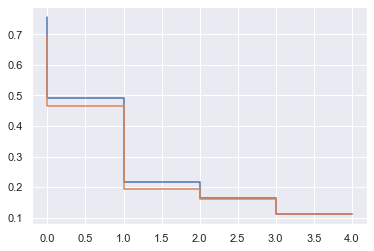

In [81]:
hf1 = np.array([0.05, 0.1, 0.8, 0.05, 0.05])*2
hf2 = np.array([0.5, 0, 0.5, 0.0, 0])*2
hf3 = np.array([0.0, 0.5, 0.0, 0.25, 0.5])*2

chf1 = np.cumsum(hf1)
chf2 = np.cumsum(hf2)
chf3 = np.cumsum(hf3)

plt.step(np.arange(5), (np.exp(-chf1) + np.exp(-chf2) + np.exp(-chf3))/3)
plt.step(np.arange(5), (np.exp(-(chf1 + chf2 + chf3)/3)))

In [93]:
def get_comb_fast(df, features):
    info = {}
    X = df.loc[:, features + [cnt.CENS_NAME, cnt.TIME_NAME]].to_numpy().T

    def create_params_f(v_feature, name):
        d = info.copy()
        d["arr"] = np.vstack((v_feature, X[-2:]))
        return d

    return list(map(create_params_f, X[:-2], features))

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X[cnt.CENS_NAME] = y[cnt.CENS_NAME]
X[cnt.TIME_NAME] = y[cnt.TIME_NAME]

%timeit get_comb_fast(X, features)

561 µs ± 7.27 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Demonstartion of convergence error of COXPH on flchain

In [ ]:
# Method: CoxPHSurvivalAnalysis, Param: {'alpha': 100, 'ties': 'breslow'} finished with except 'search direction contains NaN or infinite values'
        
from survivors.experiments import grid as exp
from sksurv.linear_model import CoxPHSurvivalAnalysis

X, y, features, categ, sch_nan = ds.load_flchain_dataset()
for X_train, y_train, X_test, y_test, bins in exp.generate_sample(X, y, 20, mode="HOLD-OUT"):
    X_train = X_train.fillna(0).replace(np.nan, 0)
    X_test = X_test.fillna(0).replace(np.nan, 0)

    cmodel = CoxPHSurvivalAnalysis(alpha=100, ties='breslow')
    cmodel = cmodel.fit(X_train, y_train)
    
    survs = cmodel.predict_survival_function(X_test)
    hazards = cmodel.predict_cumulative_hazard_function(X_test)
    pred_surv = np.array(list(map(lambda x: x(bins), survs)))
    
    # constant prediction
    # print(pred_surv)

### Tree coefficient analysis

In [111]:
def eq_coeff(v):
    return np.ones_like(v)*1/v.shape[0]

def min_coeff(v):
    return np.where(v == v.min(), 1, 0)

def clever_coeff(v):
    s = (1/v).sum()
    return 1/v*1/s

def target_function(v, coeff):
    return coeff.shape[0]*((coeff**2)*v).sum()

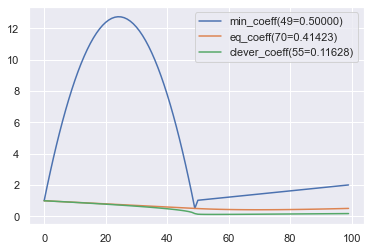

In [112]:
size = 100
# v = np.random.rand(size)
# v = np.linspace(0.01, 0.99, size) # increace
# v = np.linspace(0.01, 0.99, size) # increace
# v = np.linspace(0.99, 0.01, size)**2 # decreace
v = np.hstack([np.linspace(0.99, 0.01, size//2), np.linspace(0.01, 0.99, size//2)]) # decreace

for f_coeff in [min_coeff, eq_coeff, clever_coeff]:
    f_l = [target_function(v[:i], f_coeff(v[:i])) for i in range(1, size+1)]

    plt.plot(f_l, label=f"{f_coeff.__name__}({np.argmin(f_l)}={np.min(f_l):.5f})")
plt.legend()
# assert np.array(e_c) > np.array(c_c)
# assert np.array(m_c) > np.array(c_c)

In [119]:
# np.random.seed(42)
for _ in range(10000):
    bins = np.linspace(1, 1000, 100)
    tf = cnt.get_y(np.array([bins.mean()]), np.array([True]))
    ibs_l = []
    sf_l = []
    for i in range(100):
        s = np.random.rand(100)
        sf = np.cumsum((s/np.sum(s))[::-1])[::-1][np.newaxis, :]
        sf_l.append(sf)
        ibs_l.append(metr.ibs_WW(tf, tf, sf, bins))

    ibs_l = np.array(ibs_l)
    sf_l = np.vstack(sf_l)
    d = {}
    for f_coeff in [min_coeff, eq_coeff, clever_coeff]:
        L = [target_function(ibs_l[:i], f_coeff(ibs_l[:i])) for i in range(1, 101)]
        best_i = np.argmin(L) + 1
        print(f_coeff.__name__, best_i, np.min(L), f_coeff(ibs_l[:best_i]))
        fin_ibs = metr.ibs_WW(tf, tf, np.dot(sf_l[:best_i].T, f_coeff(ibs_l[:best_i]))[np.newaxis, :], bins)
        print(fin_ibs)
        assert fin_ibs <= np.min(L)

min_coeff 1 0.33407043380037177 [1]
0.33407043380037177
eq_coeff 4 0.3297336558458275 [0.25 0.25 0.25 0.25]
0.3291064973626209
clever_coeff 4 0.328712180730954 [0.24599018 0.23287646 0.24912958 0.27200378]
0.32807533788429843
min_coeff 1 0.3747115026059778 [1]
0.3747115026059778
eq_coeff 11 0.33153243159386436 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.33097457844854494
clever_coeff 11 0.3303673567046435 [0.08015072 0.09375785 0.08687944 0.09740392 0.09468901 0.08463668
 0.09183744 0.08707228 0.09711572 0.09137966 0.09507727]
0.32982607080788273
min_coeff 1 0.31508659903159575 [1]
0.31508659903159575
eq_coeff 1 0.31508659903159575 [1.]
0.31508659903159575
clever_coeff 1 0.31508659903159575 [1.]
0.31508659903159575
min_coeff 1 0.3691554003203752 [1]
0.3691554003203752
eq_coeff 92 0.33554065170719083 [0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.0108

min_coeff 1 0.3658670198890127 [1]
0.3658670198890127
eq_coeff 16 0.3342180410303244 [0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
0.33365413687809886
clever_coeff 16 0.3335802104577761 [0.05698454 0.06485459 0.06355824 0.0604526  0.06039822 0.06541057
 0.06298767 0.06438274 0.05767176 0.06305723 0.06014807 0.06166049
 0.0664361  0.06291651 0.06605621 0.06302446]
0.3330249507282882
min_coeff 1 0.33057660717958665 [1]
0.33057660717958665
eq_coeff 4 0.32642318771661655 [0.25 0.25 0.25 0.25]
0.3261082673438934
clever_coeff 4 0.3257381491151231 [0.2463409  0.24543284 0.23864033 0.26958593]
0.32541331949061153
min_coeff 1 0.31015532990113576 [1]
0.31015532990113576
eq_coeff 1 0.31015532990113576 [1.]
0.31015532990113576
clever_coeff 1 0.31015532990113576 [1.]
0.31015532990113576
min_coeff 1 0.32393731741542553 [1]
0.32393731741542553
eq_coeff 2 0.3136059017699817 [0.5 0.5]
0.3133331307411025
clever_coeff 2 0.31326554417901

min_coeff 1 0.32284114379068607 [1]
0.32284114379068607
eq_coeff 2 0.31409879070557833 [0.5 0.5]
0.3139523708989959
clever_coeff 2 0.31385546363866096 [0.48608343 0.51391657]
0.3137091572610477
min_coeff 1 0.33606923512184256 [1]
0.33606923512184256
eq_coeff 1 0.33606923512184256 [1.]
0.33606923512184256
clever_coeff 1 0.33606923512184256 [1.]
0.33606923512184256
min_coeff 1 0.3284190466488901 [1]
0.3284190466488901
eq_coeff 1 0.3284190466488901 [1.]
0.3284190466488901
clever_coeff 1 0.3284190466488901 [1.]
0.3284190466488901
min_coeff 1 0.32155573517429914 [1]
0.32155573517429914
eq_coeff 1 0.32155573517429914 [1.]
0.32155573517429914
clever_coeff 1 0.32155573517429914 [1.]
0.32155573517429914
min_coeff 1 0.3511738703785198 [1]
0.3511738703785198
eq_coeff 48 0.33716928538381563 [0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.020833

min_coeff 1 0.33827381450924326 [1]
0.33827381450924326
eq_coeff 2 0.3262357885436536 [0.5 0.5]
0.3258287782670698
clever_coeff 2 0.3257915881394149 [0.48155011 0.51844989]
0.3253851320452222
min_coeff 1 0.344571904593678 [1]
0.344571904593678
eq_coeff 2 0.32419071495232604 [0.5 0.5]
0.32361562629089147
clever_coeff 2 0.3229093923479515 [0.46856605 0.53143395]
0.32233657665137194
min_coeff 1 0.3301508147063518 [1]
0.3301508147063518
eq_coeff 2 0.3242429722728619 [0.5 0.5]
0.32412409286349064
clever_coeff 2 0.3241353289152456 [0.49088979 0.50911021]
0.3240164889718918
min_coeff 1 0.32780487776964945 [1]
0.32780487776964945
eq_coeff 2 0.32350104670141955 [0.5 0.5]
0.3234075429297961
clever_coeff 2 0.32344378889019226 [0.49334804 0.50665196]
0.3233503016681947
min_coeff 1 0.3249185602370671 [1]
0.3249185602370671
eq_coeff 1 0.3249185602370671 [1.]
0.3249185602370671
clever_coeff 1 0.3249185602370671 [1.]
0.3249185602370671
min_coeff 1 0.32645937889545434 [1]
0.32645937889545434
eq_coeff 1

min_coeff 1 0.3237575219361362 [1]
0.3237575219361362
eq_coeff 2 0.3191964711579651 [0.5 0.5]
0.3190989767940854
clever_coeff 2 0.319131297554618 [0.49285542 0.50714458]
0.3190338230971582
min_coeff 1 0.3518747368198839 [1]
0.3518747368198839
eq_coeff 34 0.3302055349755164 [0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176]
0.3296231150912685
clever_coeff 34 0.3292637339506359 [0.0275218  0.02910558 0.0295388  0.02996359 0.02745566 0.03100029
 0.02933714 0.02792849 0.02649554 0.02974778 0.03074538 0.02814984
 0.03150817 0.02712745 0.02819057 0.02803781 0.0285339  0.03155459
 0.02955328 0.03322441 0.02880098 0.02926288 0.0266506  0.03061849
 0.0301812  0.03013583 

min_coeff 1 0.3171765518849944 [1]
0.3171765518849944
eq_coeff 1 0.3171765518849944 [1.]
0.3171765518849944
clever_coeff 1 0.3171765518849944 [1.]
0.3171765518849944
min_coeff 1 0.33475615655049146 [1]
0.33475615655049146
eq_coeff 2 0.3243707990732404 [0.5 0.5]
0.32416719246703213
clever_coeff 2 0.32403829179996413 [0.48399153 0.51600847]
0.3238348939076033
min_coeff 1 0.3314275896221388 [1]
0.3314275896221388
eq_coeff 1 0.3314275896221388 [1.]
0.3314275896221388
clever_coeff 1 0.3314275896221388 [1.]
0.3314275896221388
min_coeff 1 0.3258513813156381 [1]
0.3258513813156381
eq_coeff 2 0.31771931228660405 [0.5 0.5]
0.31756274648204297
clever_coeff 2 0.31751117087330116 [0.48720243 0.51279757]
0.31735470763671936
min_coeff 1 0.3267613327508797 [1]
0.3267613327508797
eq_coeff 3 0.3242961507032164 [0.33333333 0.33333333 0.33333333]
0.32397933415085445
clever_coeff 3 0.32413873716368824 [0.33065799 0.32592969 0.34341232]
0.32381994852613555
min_coeff 1 0.375203144394664 [1]
0.375203144394664

min_coeff 1 0.35214486340531426 [1]
0.35214486340531426
eq_coeff 15 0.3328349941335692 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
0.33239060127233505
clever_coeff 15 0.3322163546504563 [0.06289388 0.06844696 0.06317491 0.06728908 0.06798593 0.06223732
 0.06578514 0.06771513 0.06473585 0.07085802 0.06474997 0.06851648
 0.06562165 0.07325777 0.0667319 ]
0.3317678576901799
min_coeff 1 0.3534058706219922 [1]
0.3534058706219922
eq_coeff 6 0.33221130271725247 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.33171043438585585
clever_coeff 6 0.33116390042635924 [0.15617732 0.15876791 0.17416967 0.15760872 0.17971925 0.17355712]
0.33066152156821754
min_coeff 1 0.3457226127242358 [1]
0.3457226127242358
eq_coeff 19 0.33527279447266334 [0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263

0.33236190574886704
min_coeff 1 0.31226197303271724 [1]
0.31226197303271724
eq_coeff 1 0.31226197303271724 [1.]
0.31226197303271724
clever_coeff 1 0.31226197303271724 [1.]
0.31226197303271724
min_coeff 1 0.32868303082283623 [1]
0.32868303082283623
eq_coeff 4 0.3281660819616472 [0.25 0.25 0.25 0.25]
0.32771883747410385
clever_coeff 4 0.3273103077541724 [0.24895589 0.22995589 0.259378   0.26171022]
0.32686902922639255
min_coeff 1 0.3648771529323856 [1]
0.3648771529323856
eq_coeff 80 0.3360363244245056 [0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.012

min_coeff 1 0.32778407229694095 [1]
0.32778407229694095
eq_coeff 1 0.32778407229694095 [1.]
0.32778407229694095
clever_coeff 1 0.32778407229694095 [1.]
0.32778407229694095
min_coeff 1 0.32360984000700105 [1]
0.32360984000700105
eq_coeff 1 0.32360984000700105 [1.]
0.32360984000700105
clever_coeff 1 0.32360984000700105 [1.]
0.32360984000700105
min_coeff 1 0.3847476175296872 [1]
0.3847476175296872
eq_coeff 51 0.3374490893029749 [0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784]


min_coeff 1 0.36251999593441797 [1]
0.36251999593441797
eq_coeff 33 0.33718382180376566 [0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303]
0.3365905979588003
clever_coeff 33 0.33615638365675055 [0.0280993  0.02914876 0.02975504 0.02900188 0.03070414 0.03416285
 0.02975479 0.03130569 0.02801387 0.03053821 0.0316664  0.02972401
 0.03102084 0.02821978 0.03148574 0.03000587 0.02923174 0.02890836
 0.02968266 0.03167167 0.03369845 0.0292644  0.02734862 0.03204784
 0.02801949 0.03057003 0.03032247 0.03182548 0.02931665 0.03073777
 0.0290232  0.03160504 0.03411894]
0.3355511472033763
min_coeff 1 0.33129563881966795 [1]
0.33129563881966795
eq_coeff 2 0.31276549541613113 [0.5 0.5]
0

min_coeff 1 0.36769457339331113 [1]
0.36769457339331113
eq_coeff 74 0.3331513542757348 [0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351]
0.33268724023009977
clever_coeff 87 0.33248969963937003 [0.01039374 0.0117707  0.0111

min_coeff 1 0.3279324873087254 [1]
0.3279324873087254
eq_coeff 3 0.312306173950033 [0.33333333 0.33333333 0.33333333]
0.31203612026600086
clever_coeff 3 0.3118850135969029 [0.31702157 0.34615494 0.33682349]
0.31161810835318954
min_coeff 1 0.32154082146077545 [1]
0.32154082146077545
eq_coeff 4 0.3198163354072069 [0.25 0.25 0.25 0.25]
0.3195905343784967
clever_coeff 4 0.3194216608657745 [0.24835234 0.23933152 0.24835683 0.26395931]
0.3191953309981323
min_coeff 1 0.3509584537423771 [1]
0.3509584537423771
eq_coeff 8 0.3377657254186409 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3371264928897929
clever_coeff 11 0.33688398915117074 [0.08726337 0.08182218 0.08943129 0.09059014 0.09573082 0.09571317
 0.09114435 0.09557311 0.08509353 0.08767881 0.09995922]
0.3362643527501408
min_coeff 1 0.32868793390136036 [1]
0.32868793390136036
eq_coeff 1 0.32868793390136036 [1.]
0.32868793390136036
clever_coeff 1 0.32868793390136036 [1.]
0.32868793390136036
min_coeff 1 0.34560409145917886 [1]
0.34560

min_coeff 1 0.3390739465198908 [1]
0.3390739465198908
eq_coeff 3 0.3263368383710052 [0.33333333 0.33333333 0.33333333]
0.3260972727561292
clever_coeff 3 0.3258675958377644 [0.32035057 0.3289867  0.35066273]
0.32562690246050735
min_coeff 1 0.35844019238652947 [1]
0.35844019238652947
eq_coeff 40 0.3296340492978062 [0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025]
0.32886329385705404
clever_coeff 37 0.32818454680942105 [0.0247457  0.02551358 0.02836143 0.02418104 0.02700945 0.02884616
 0.02742567 0.02647459 0.02410384 0.02660607 0.02581649 0.03106182
 0.02711297 0.0246562  0.02860012 0.02336024 0.02773678 0.02838348
 0.02558275 0.03013109 0.0299612  0.02627747 0.02516082 0.0257194
 0.02840165 0.02614658 0.02749796 0.02820845 0.0260108  0.02549522
 0.02979538 0.02789477 0.0283216  0.02745629 0.0276

min_coeff 1 0.3610713971046576 [1]
0.3610713971046576
eq_coeff 87 0.33652178357523915 [0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.0114942

min_coeff 1 0.35184077310082484 [1]
0.35184077310082484
eq_coeff 6 0.33878566120338705 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.338392987623445
clever_coeff 39 0.33841838889649306 [0.02466285 0.02505682 0.02667681 0.02493668 0.02619215 0.02629424
 0.0244066  0.02285442 0.02520692 0.02510322 0.02539525 0.02517173
 0.0245709  0.02570137 0.02464832 0.02707645 0.02341584 0.025963
 0.02593352 0.02564027 0.02661297 0.02549641 0.02604579 0.0254219
 0.0262729  0.02676534 0.02772849 0.02683055 0.0267415  0.02596966
 0.0246986  0.02656428 0.0243266  0.02650826 0.02641624 0.02560482
 0.02521297 0.02600372 0.02587164]
0.3379959772028077
min_coeff 1 0.32398447985995277 [1]
0.32398447985995277
eq_coeff 1 0.32398447985995277 [1.]
0.32398447985995277
clever_coeff 1 0.32398447985995277 [1.]
0.32398447985995277
min_coeff 1 0.3506743259909903 [1]
0.3506743259909903
eq_coeff 5 0.32228671325888936 [0.2 0.2 0.2 0.2 0.2]
0.3217795588256026
clever_coeff 5 0.3213904224612444 [0.183

min_coeff 1 0.3351389308433339 [1]
0.3351389308433339
eq_coeff 4 0.3216419581366587 [0.25 0.25 0.25 0.25]
0.3214009892014341
clever_coeff 4 0.32143979410771606 [0.239781   0.25050819 0.25584409 0.25386672]
0.32120115896442125
min_coeff 1 0.33257779707739693 [1]
0.33257779707739693
eq_coeff 1 0.33257779707739693 [1.]
0.33257779707739693
clever_coeff 1 0.33257779707739693 [1.]
0.33257779707739693
min_coeff 1 0.35581144005291676 [1]
0.35581144005291676
eq_coeff 8 0.3333355837769225 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.33294556429507505
clever_coeff 8 0.33298549059123067 [0.11698102 0.12448786 0.12692253 0.12211916 0.12324187 0.12911125
 0.12675325 0.13038306]
0.3325966690034211
min_coeff 1 0.3215235405154763 [1]
0.3215235405154763
eq_coeff 1 0.3215235405154763 [1.]
0.3215235405154763
clever_coeff 1 0.3215235405154763 [1.]
0.3215235405154763
min_coeff 1 0.327572325184666 [1]
0.327572325184666
eq_coeff 1 0.327572325184666 [1.]
0.327572325184666
clever_coeff 4 0.32670438519369

min_coeff 1 0.3134704608200986 [1]
0.3134704608200986
eq_coeff 1 0.3134704608200986 [1.]
0.3134704608200986
clever_coeff 1 0.3134704608200986 [1.]
0.3134704608200986
min_coeff 1 0.35127889118054545 [1]
0.35127889118054545
eq_coeff 6 0.32974191362223937 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.32938720816989936
clever_coeff 6 0.3293630292215082 [0.15626854 0.16822221 0.17222581 0.16547148 0.16477742 0.17303454]
0.329013346020841
min_coeff 1 0.3344284047012773 [1]
0.3344284047012773
eq_coeff 3 0.33034930858236333 [0.33333333 0.33333333 0.33333333]
0.3301249195737359
clever_coeff 3 0.3300428257374374 [0.32896211 0.3235632  0.34747468]
0.3298161218279959
min_coeff 1 0.35716640415460027 [1]
0.35716640415460027
eq_coeff 60 0.33407811628837225 [0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 

min_coeff 1 0.3364848791154198 [1]
0.3364848791154198
eq_coeff 3 0.32482796819174087 [0.33333333 0.33333333 0.33333333]
0.3245972581350504
clever_coeff 3 0.32444132035605466 [0.32140258 0.32956827 0.34902916]
0.324209645925509
min_coeff 1 0.33005545690049914 [1]
0.33005545690049914
eq_coeff 4 0.32700158078285746 [0.25 0.25 0.25 0.25]
0.3262893666905967
clever_coeff 4 0.32546744008521644 [0.24652481 0.22401925 0.26335117 0.26610477]
0.32478864838074195
min_coeff 1 0.3435480561484633 [1]
0.3435480561484633
eq_coeff 5 0.33241359080307253 [0.2 0.2 0.2 0.2 0.2]
0.3319913046995842
clever_coeff 5 0.3318115417034814 [0.19316747 0.20020154 0.19131903 0.19937167 0.21594029]
0.3313879102032928
min_coeff 1 0.33989789870276094 [1]
0.33989789870276094
eq_coeff 13 0.3336122930498338 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.3330087446653829
clever_coeff 12 0.3324148015558204 [0.08149869 0.073398

min_coeff 1 0.3523278400402853 [1]
0.3523278400402853
eq_coeff 6 0.3340921985269939 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.33343967611767383
clever_coeff 6 0.332958600395725 [0.15750416 0.16771667 0.16148598 0.15629231 0.18521601 0.17178487]
0.3322976350294078
min_coeff 1 0.3249583158390691 [1]
0.3249583158390691
eq_coeff 5 0.31878090496541606 [0.2 0.2 0.2 0.2 0.2]
0.31821397277366137
clever_coeff 4 0.31801005225244106 [0.2446545  0.24997743 0.23415216 0.2712159 ]
0.3173055807349703
min_coeff 1 0.3489042415836441 [1]
0.3489042415836441
eq_coeff 10 0.3267395498470026 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3262801488342896
clever_coeff 10 0.32594482193209534 [0.09341956 0.09316996 0.09607669 0.10516743 0.0977373  0.09842502
 0.10113004 0.10372576 0.10938574 0.10176249]
0.32548274736214106
min_coeff 1 0.3855547386773235 [1]
0.3855547386773235
eq_coeff 79 0.33419402837193024 [0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0

min_coeff 1 0.32959412815736344 [1]
0.32959412815736344
eq_coeff 1 0.32959412815736344 [1.]
0.32959412815736344
clever_coeff 1 0.32959412815736344 [1.]
0.32959412815736344
min_coeff 1 0.3451109596623478 [1]
0.3451109596623478
eq_coeff 3 0.33593262928629264 [0.33333333 0.33333333 0.33333333]
0.33575772717160685
clever_coeff 3 0.3358044856630844 [0.32434446 0.3363319  0.33932364]
0.33562992038502354
min_coeff 1 0.32272676038368725 [1]
0.32272676038368725
eq_coeff 1 0.32272676038368725 [1.]
0.32272676038368725
clever_coeff 1 0.32272676038368725 [1.]
0.32272676038368725
min_coeff 1 0.3271072593163099 [1]
0.3271072593163099
eq_coeff 1 0.3271072593163099 [1.]
0.3271072593163099
clever_coeff 1 0.3271072593163099 [1.]
0.3271072593163099
min_coeff 1 0.3252097416801829 [1]
0.3252097416801829
eq_coeff 1 0.3252097416801829 [1.]
0.3252097416801829
clever_coeff 1 0.3252097416801829 [1.]
0.3252097416801829
min_coeff 1 0.3402048903538988 [1]
0.3402048903538988
eq_coeff 2 0.3290306074549416 [0.5 0.5]
0

min_coeff 1 0.31826232000407034 [1]
0.31826232000407034
eq_coeff 1 0.31826232000407034 [1.]
0.31826232000407034
clever_coeff 1 0.31826232000407034 [1.]
0.31826232000407034
min_coeff 1 0.2921437694367137 [1]
0.2921437694367137
eq_coeff 1 0.2921437694367137 [1.]
0.2921437694367137
clever_coeff 1 0.2921437694367137 [1.]
0.2921437694367137
min_coeff 1 0.3485655529562148 [1]
0.3485655529562148
eq_coeff 25 0.3306271850253311 [0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]
0.33002487904454736
clever_coeff 25 0.3294771807750438 [0.03780949 0.03907892 0.04191765 0.03478619 0.03870557 0.0398608
 0.04047563 0.03731882 0.03672258 0.03908983 0.04611529 0.04199176
 0.03886357 0.04020007 0.04189264 0.03888646 0.03719952 0.04299961
 0.04267983 0.0402357  0.03822811 0.04132543 0.04228744 0.04063111
 0.04069798]
0.32887583825999417
min_coeff 1 0.33163891770054754 [1]
0.33163891770054754
eq_coeff 4 0.33045740086910663 [0.25 0

min_coeff 1 0.35626512746511224 [1]
0.35626512746511224
eq_coeff 48 0.3343567273604098 [0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333]
0.3338741708587934
clever_coeff 48 0.3335825896797785 [0.01950693 0.01987046 0.02157484 0.01883847 0.02230157 0.02087279
 0.01998195 0.02134972 0.02115985 0.02062012 0.02149518 0.01981249
 0.02087071 0.02049057 0.02145521 0.01937148 0.01948856 0.01962533
 0.01998804 0.02057659 0.02103571 0.0207111  0.02111526 0.02116534
 0.0191828  0.02099558 0.02067219 0.02246269 0.0207346

min_coeff 1 0.35184932028767896 [1]
0.35184932028767896
eq_coeff 4 0.3370725640001734 [0.25 0.25 0.25 0.25]
0.3368882376306834
clever_coeff 88 0.33641816026449545 [0.01086526 0.01148884 0.01128595 0.0117645  0.0108762  0.01042835
 0.01141016 0.01107795 0.0108463  0.01135212 0.01021441 0.01017454
 0.0119763  0.01135019 0.01041199 0.01112002 0.0114109  0.01072886
 0.01218926 0.01114441 0.01151534 0.00999681 0.01053218 0.01220922
 0.01070934 0.0116744  0.01176013 0.01105923 0.01111567 0.01117947
 0.01089186 0.01170295 0.01257318 0.01132322 0.01051994 0.01108518
 0.01080724 0.01240095 0.01111235 0.01099473 0.01144945 0.01164691
 0.01124442 0.01073234 0.01095662 0.01311329 0.01156663 0.01191527
 0.01192579 0.01222263 0.01109442 0.01197493 0.01139428 0.01100611
 0.01137036 0.01081094 0.01064809 0.01253078 0.0110798  0.01114115
 0.01130978 0.0119827  0.01181183 0.01154664 0.01264156 0.01320907
 0.01060514 0.0115811  0.01094519 0.01160654 0.01129919 0.01034649
 0.01157225 0.01078918 0.01094093

min_coeff 1 0.3609570090160829 [1]
0.3609570090160829
eq_coeff 8 0.3317515445608257 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.33101768913694635
clever_coeff 8 0.3303523081135311 [0.11440154 0.11376944 0.13371887 0.126846   0.13383515 0.11803094
 0.13356734 0.12583072]
0.32962687336593344
min_coeff 1 0.34875801102518617 [1]
0.34875801102518617
eq_coeff 75 0.3367766073478639 [0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333

min_coeff 1 0.3610436425941827 [1]
0.3610436425941827
eq_coeff 59 0.3345027977595179 [0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915]
0.3338581559004271
clever_coeff 59 0.3335939402154 [0.01566053 0.01548303 0.01673542 0.01627793 0.01702972 0.01683351
 0.01633042 0.01624922 0.01774348 0.01588402 0.01619398 0.01668844
 0.01704871 0.01747402 0.01756707 0.01613168 0.01514035 0.01790107
 0.

min_coeff 1 0.32353722362467063 [1]
0.32353722362467063
eq_coeff 1 0.32353722362467063 [1.]
0.32353722362467063
clever_coeff 1 0.32353722362467063 [1.]
0.32353722362467063
min_coeff 1 0.3428243223310459 [1]
0.3428243223310459
eq_coeff 6 0.3277907295133268 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.32711876344205915
clever_coeff 6 0.3266189493455791 [0.1587883  0.15465641 0.18145906 0.15883613 0.17733646 0.16892363]
0.32594027953578164
min_coeff 1 0.32194030409529206 [1]
0.32194030409529206
eq_coeff 1 0.32194030409529206 [1.]
0.32194030409529206
clever_coeff 1 0.32194030409529206 [1.]
0.32194030409529206
min_coeff 1 0.34403424314683845 [1]
0.34403424314683845
eq_coeff 3 0.32859635694953804 [0.33333333 0.33333333 0.33333333]
0.3281148604958999
clever_coeff 3 0.32823517560997334 [0.31802568 0.33909971 0.3428746 ]
0.3277561387509569
min_coeff 1 0.3386047326578437 [1]
0.3386047326578437
eq_coeff 2 0.32658301999530637 [0.5 0.5]
0.3263651511812493
clever_coeff 2 0.3

min_coeff 1 0.33718545835929253 [1]
0.33718545835929253
eq_coeff 4 0.3356174924822677 [0.25 0.25 0.25 0.25]
0.33533300614745093
clever_coeff 4 0.3354765674211739 [0.24873297 0.24219224 0.25467685 0.25439793]
0.3351942431823569
min_coeff 1 0.33386819951102714 [1]
0.33386819951102714
eq_coeff 1 0.33386819951102714 [1.]
0.33386819951102714
clever_coeff 1 0.33386819951102714 [1.]
0.33386819951102714
min_coeff 1 0.34077758719247314 [1]
0.34077758719247314
eq_coeff 2 0.3154782453162185 [0.5 0.5]
0.3146386137734735
clever_coeff 2 0.31344939955942136 [0.45990319 0.54009681]
0.31261516770086395
min_coeff 1 0.3262856211144579 [1]
0.3262856211144579
eq_coeff 1 0.3262856211144579 [1.]
0.3262856211144579
clever_coeff 1 0.3262856211144579 [1.]
0.3262856211144579
min_coeff 1 0.3243582945893797 [1]
0.3243582945893797
eq_coeff 3 0.32410430396117273 [0.33333333 0.33333333 0.33333333]
0.32384845770146264
clever_coeff 3 0.32367156543894127 [0.3326276  0.31876256 0.34860983]
0.3234158880476126
min_coeff 1 

min_coeff 1 0.3344206324306641 [1]
0.3344206324306641
eq_coeff 1 0.3344206324306641 [1.]
0.3344206324306641
clever_coeff 1 0.3344206324306641 [1.]
0.3344206324306641
min_coeff 1 0.32023553005923844 [1]
0.32023553005923844
eq_coeff 1 0.32023553005923844 [1.]
0.32023553005923844
clever_coeff 1 0.32023553005923844 [1.]
0.32023553005923844
min_coeff 1 0.35274113916453587 [1]
0.35274113916453587
eq_coeff 20 0.3340182650048432 [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
0.33351378240975665
clever_coeff 20 0.33314862552832775 [0.04722282 0.04946352 0.04986874 0.0481165  0.05125405 0.05312218
 0.04662221 0.04808992 0.04688885 0.05434717 0.04754488 0.0489224
 0.04923047 0.0528202  0.05168075 0.04985554 0.04754464 0.05298288
 0.04872847 0.05569381]
0.33263608638018444
min_coeff 1 0.3370789734968609 [1]
0.3370789734968609
eq_coeff 3 0.32582237414712195 [0.33333333 0.33333333 0.33333333]
0.32552277111466926
clever_coeff 3 0.325482898573775

min_coeff 1 0.3489436467503158 [1]
0.3489436467503158
eq_coeff 79 0.33784320533630324 [0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823]
0.3372704291506213
clever_coef

min_coeff 1 0.32711128120071103 [1]
0.32711128120071103
eq_coeff 1 0.32711128120071103 [1.]
0.32711128120071103
clever_coeff 1 0.32711128120071103 [1.]
0.32711128120071103
min_coeff 1 0.3363639028418043 [1]
0.3363639028418043
eq_coeff 2 0.3317730219544453 [0.5 0.5]
0.3316043052903483
clever_coeff 2 0.3317094960318197 [0.49308129 0.50691871]
0.331540811672585
min_coeff 1 0.3241628626383236 [1]
0.3241628626383236
eq_coeff 1 0.3241628626383236 [1.]
0.3241628626383236
clever_coeff 1 0.3241628626383236 [1.]
0.3241628626383236
min_coeff 1 0.35328995303207716 [1]
0.35328995303207716
eq_coeff 4 0.3239565782375203 [0.25 0.25 0.25 0.25]
0.3233839269444586
clever_coeff 4 0.3229509916269992 [0.22853112 0.24940516 0.25621665 0.26584707]
0.3223800190416315
min_coeff 1 0.3391496032780477 [1]
0.3391496032780477
eq_coeff 2 0.324155821295512 [0.5 0.5]
0.32392865671343424
clever_coeff 2 0.3234622860159624 [0.47687257 0.52312743]
0.32323560745524094
min_coeff 1 0.3147231061434815 [1]
0.3147231061434815
eq

min_coeff 1 0.3466648987158198 [1]
0.3466648987158198
eq_coeff 27 0.3318237506070248 [0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704]
0.3312938539193923
clever_coeff 27 0.33092855275409 [0.03535579 0.03576335 0.03609905 0.03799025 0.03613173 0.0383969
 0.03596012 0.03651359 0.03520829 0.03744985 0.03787646 0.03447575
 0.03841137 0.03634475 0.04075021 0.03344052 0.03742886 0.03615693
 0.03795581 0.03503475 0.03744443 0.03541464 0.04261134 0.03750786
 0.03844064 0.03566387 0.04017287]
0.3303883253811119
min_coeff 1 0.34501403638532296 [1]
0.34501403638532296
eq_coeff 14 0.33194077825377133 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.071

min_coeff 1 0.3221691182460809 [1]
0.3221691182460809
eq_coeff 2 0.3213637802826328 [0.5 0.5]
0.3212289494465103
clever_coeff 2 0.32136176210486933 [0.498747 0.501253]
0.32122693211548997
min_coeff 1 0.335657420158486 [1]
0.335657420158486
eq_coeff 1 0.335657420158486 [1.]
0.335657420158486
clever_coeff 1 0.335657420158486 [1.]
0.335657420158486
min_coeff 1 0.3828925685177932 [1]
0.3828925685177932
eq_coeff 37 0.3320961417647675 [0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703]
0.3315557605495094
clever_coeff 37 0.3311599961277959 [0.02337541 0.0295222  0.02667955 0.02803781 0.02691742 0.02711179
 0.02574811 0.02545759 0.025463

0.330795013914296
min_coeff 1 0.3708007645342117 [1]
0.3708007645342117
eq_coeff 9 0.338928044585821 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.33845000351023546
clever_coeff 9 0.33791371302251283 [0.10125645 0.11007857 0.10709546 0.11464376 0.11671372 0.11428427
 0.10235124 0.11406721 0.11950931]
0.3374454463953135
min_coeff 1 0.3436004707985657 [1]
0.3436004707985657
eq_coeff 3 0.32058420493771667 [0.33333333 0.33333333 0.33333333]
0.319894349680094
clever_coeff 3 0.3196060646151523 [0.3100559  0.35484037 0.33510372]
0.31893020873813793
min_coeff 1 0.34853923352953964 [1]
0.34853923352953964
eq_coeff 4 0.34098570519510163 [0.25 0.25 0.25 0.25]
0.34049930192158506
clever_coeff 40 0.3401960247126354 [0.02440156 0.02530126 0.02369419 0.02655178 0.02424632 0.02546853
 0.02446365 0.02481908 0.02528652 0.02326282 0.0261466  0.02536079
 0.02338869 0.02451933 0.02437907 0.02396388 0.025807   0.02379343
 0.02498127 0.02644184 0.0265

min_coeff 1 0.3404039252786304 [1]
0.3404039252786304
eq_coeff 57 0.33728434561295706 [0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386]
0.3368575533568663
clever_coeff 57 0.3366924956036942 [0.01735258 0.01656462 0.01721537 0.01857964 0.01765573 0.01740728
 0.01667883 0.01675147 0.01751483 0.01636899 0.01694867 0.01789457
 0.01729034 0.01741304 0.01688775 0.01751398 0.01741045 0.01735882
 0.01764437 0.0168583

min_coeff 1 0.3502815628066804 [1]
0.3502815628066804
eq_coeff 4 0.3336441372876945 [0.25 0.25 0.25 0.25]
0.3333521041427336
clever_coeff 4 0.3332637654693756 [0.2378542  0.25206951 0.24867697 0.26139931]
0.33297291599619866
min_coeff 1 0.3488521726833551 [1]
0.3488521726833551
eq_coeff 52 0.3363984217153487 [0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077]
0.3357469698208683
clever_coeff 52 0.33527196200239556 [0.01848215 0.01787245 0.01888916 0.01889206 0.019192

min_coeff 1 0.30592979958866834 [1]
0.30592979958866834
eq_coeff 1 0.30592979958866834 [1.]
0.30592979958866834
clever_coeff 1 0.30592979958866834 [1.]
0.30592979958866834
min_coeff 1 0.34856263624250183 [1]
0.34856263624250183
eq_coeff 5 0.3284607040593883 [0.2 0.2 0.2 0.2 0.2]
0.3280006724967606
clever_coeff 5 0.32779777288932604 [0.18808543 0.19036588 0.20570865 0.20935267 0.20648738]
0.32733982605799716
min_coeff 1 0.3777045312494991 [1]
0.3777045312494991
eq_coeff 92 0.3382890499442491 [0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0

min_coeff 1 0.3390792699819484 [1]
0.3390792699819484
eq_coeff 1 0.3390792699819484 [1.]
0.3390792699819484
clever_coeff 94 0.33877402988570715 [0.01062872 0.00932187 0.00994498 0.01107464 0.00953425 0.01020698
 0.00964825 0.01096612 0.01096357 0.01100332 0.0109435  0.00994681
 0.01007082 0.0107196  0.01074701 0.01068161 0.01018369 0.0109632
 0.01102366 0.0106433  0.01034297 0.0112372  0.01047883 0.01091045
 0.00948698 0.01066244 0.00993886 0.00962346 0.0120235  0.01093796
 0.01048026 0.01171998 0.01018409 0.01135812 0.01045312 0.01025548
 0.01041384 0.01098495 0.01049127 0.01025677 0.01167647 0.01010578
 0.01138492 0.00995336 0.00950537 0.00999846 0.01006683 0.01139462
 0.01039868 0.01066191 0.01132782 0.01112437 0.0109981  0.00996344
 0.00957208 0.01022961 0.01112156 0.01068978 0.01142287 0.01016062
 0.01118539 0.01108654 0.01073107 0.01157363 0.01083334 0.01065829
 0.01171952 0.01094127 0.01122827 0.01124962 0.00987447 0.01003087
 0.01033526 0.01101966 0.01047793 0.01058775 0.010794

min_coeff 1 0.3316397955968707 [1]
0.3316397955968707
eq_coeff 1 0.3316397955968707 [1.]
0.3316397955968707
clever_coeff 1 0.3316397955968707 [1.]
0.3316397955968707
min_coeff 1 0.3281663911209405 [1]
0.3281663911209405
eq_coeff 1 0.3281663911209405 [1.]
0.3281663911209405
clever_coeff 1 0.3281663911209405 [1.]
0.3281663911209405
min_coeff 1 0.3310143518850524 [1]
0.3310143518850524
eq_coeff 3 0.32586679638717286 [0.33333333 0.33333333 0.33333333]
0.325706981618138
clever_coeff 3 0.3258168166882312 [0.32809939 0.33817979 0.33372082]
0.32565701268233993
min_coeff 1 0.3415291381239318 [1]
0.3415291381239318
eq_coeff 6 0.3316963650290623 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.33091849497940334
clever_coeff 6 0.3305142324402428 [0.16129138 0.162684   0.17223106 0.15336506 0.16476093 0.18566757]
0.329710479304936
min_coeff 1 0.3337120367913164 [1]
0.3337120367913164
eq_coeff 15 0.3330459811317591 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.066666

min_coeff 1 0.35909540328826406 [1]
0.35909540328826406
eq_coeff 16 0.33488782513394566 [0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
0.3345019634469902
clever_coeff 16 0.3343106398820982 [0.05818625 0.06662188 0.06234831 0.06028227 0.06027106 0.06710534
 0.06169579 0.05910151 0.06453369 0.0604522  0.06523712 0.05966161
 0.06386553 0.06348435 0.06338945 0.06376365]
0.33392663220681373
min_coeff 1 0.3090642039784025 [1]
0.3090642039784025
eq_coeff 1 0.3090642039784025 [1.]
0.3090642039784025
clever_coeff 1 0.3090642039784025 [1.]
0.3090642039784025
min_coeff 1 0.3446402257121823 [1]
0.3446402257121823
eq_coeff 3 0.3273696031205609 [0.33333333 0.33333333 0.33333333]
0.32689217376366236
clever_coeff 3 0.32679455935535 [0.31607314 0.3336802  0.35024666]
0.3263246089362043
min_coeff 1 0.32796069483109713 [1]
0.32796069483109713
eq_coeff 1 0.32796069483109713 [1.]
0.32796069483109713
clever_coeff 1 0.32796069483109713 [1.]


min_coeff 1 0.31029949884192715 [1]
0.31029949884192715
eq_coeff 1 0.31029949884192715 [1.]
0.31029949884192715
clever_coeff 1 0.31029949884192715 [1.]
0.31029949884192715
min_coeff 1 0.3117284253763142 [1]
0.3117284253763142
eq_coeff 1 0.3117284253763142 [1.]
0.3117284253763142
clever_coeff 1 0.3117284253763142 [1.]
0.3117284253763142
min_coeff 1 0.35195655050946173 [1]
0.35195655050946173
eq_coeff 5 0.3231589474247982 [0.2 0.2 0.2 0.2 0.2]
0.3224164381502065
clever_coeff 5 0.3220573856615201 [0.18300974 0.18930291 0.20776774 0.21057286 0.20934675]
0.32132476709909535
min_coeff 1 0.30801200384063016 [1]
0.30801200384063016
eq_coeff 1 0.30801200384063016 [1.]
0.30801200384063016
clever_coeff 1 0.30801200384063016 [1.]
0.30801200384063016
min_coeff 1 0.31744706152029534 [1]
0.31744706152029534
eq_coeff 1 0.31744706152029534 [1.]
0.31744706152029534
clever_coeff 1 0.31744706152029534 [1.]
0.31744706152029534
min_coeff 1 0.34485318913886953 [1]
0.34485318913886953
eq_coeff 64 0.3325005903

min_coeff 1 0.31600516390705646 [1]
0.31600516390705646
eq_coeff 1 0.31600516390705646 [1.]
0.31600516390705646
clever_coeff 1 0.31600516390705646 [1.]
0.31600516390705646
min_coeff 1 0.3249294950461894 [1]
0.3249294950461894
eq_coeff 3 0.324817888697715 [0.33333333 0.33333333 0.33333333]
0.32440336118595187
clever_coeff 3 0.3245260624831926 [0.33291947 0.32130011 0.34578043]
0.3241106499748801
min_coeff 1 0.3526746067801924 [1]
0.3526746067801924
eq_coeff 9 0.3361433661734775 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3359318836445197
clever_coeff 9 0.33593610527590934 [0.1058376  0.11407634 0.10874741 0.1096416  0.10992371 0.11375706
 0.11427863 0.11048813 0.11324952]
0.33572666216961067
min_coeff 1 0.3376075304000643 [1]
0.3376075304000643
eq_coeff 2 0.3303813154592213 [0.5 0.5]
0.3302913874206957
clever_coeff 2 0.33022326117489026 [0.48906383 0.51093617]
0.33013337615790095
min_coeff 1 0.30522869278114323 [1]
0.3052286927

min_coeff 1 0.3417882912237291 [1]
0.3417882912237291
eq_coeff 3 0.3335306239048387 [0.33333333 0.33333333 0.33333333]
0.33289057508200276
clever_coeff 3 0.33197130584644285 [0.32375919 0.31092793 0.36531288]
0.3313098254472251
min_coeff 1 0.3333169543161058 [1]
0.3333169543161058
eq_coeff 6 0.33136761664539016 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3310532261125712
clever_coeff 6 0.33100529612431195 [0.16551078 0.1631487  0.15782082 0.17534715 0.17026232 0.16791023]
0.33068928208411363
min_coeff 1 0.33374233341599924 [1]
0.33374233341599924
eq_coeff 1 0.33374233341599924 [1.]
0.33374233341599924
clever_coeff 1 0.33374233341599924 [1.]
0.33374233341599924
min_coeff 1 0.3584888154679857 [1]
0.3584888154679857
eq_coeff 6 0.33674151515693496 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3361499006160023
clever_coeff 6 0.33578137156269666 [0.15610965 0.1673667  0.16146544 0.15963631 0.17227605 0.18314585]
0.33517888048627104
min_coeff 

min_coeff 1 0.37740989039012884 [1]
0.37740989039012884
eq_coeff 92 0.3403231579579922 [0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.010869

min_coeff 1 0.3249107282582708 [1]
0.3249107282582708
eq_coeff 4 0.3191374429646295 [0.25 0.25 0.25 0.25]
0.31881636438077093
clever_coeff 4 0.3189104532126551 [0.24538314 0.2492038  0.24417536 0.2612377 ]
0.31858626737871343
min_coeff 1 0.35439821259419146 [1]
0.35439821259419146
eq_coeff 6 0.3335343321943678 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3332815748705421
clever_coeff 6 0.33324975877925106 [0.15672096 0.16515678 0.16944678 0.16856905 0.17084017 0.16926626]
0.3330024752327258
min_coeff 1 0.33473586515913295 [1]
0.33473586515913295
eq_coeff 33 0.33425608189908385 [0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303]
0.3338141189238251
cl

min_coeff 1 0.33560395413827293 [1]
0.33560395413827293
eq_coeff 4 0.3289571783639055 [0.25 0.25 0.25 0.25]
0.32880605980846295
clever_coeff 4 0.3288900248313933 [0.24499862 0.25400248 0.24834182 0.25265709]
0.3287394374714913
min_coeff 1 0.3056359475101272 [1]
0.3056359475101272
eq_coeff 1 0.3056359475101272 [1.]
0.3056359475101272
clever_coeff 1 0.3056359475101272 [1.]
0.3056359475101272
min_coeff 1 0.3225141043532328 [1]
0.3225141043532328
eq_coeff 1 0.3225141043532328 [1.]
0.3225141043532328
clever_coeff 1 0.3225141043532328 [1.]
0.3225141043532328
min_coeff 1 0.3204436872774524 [1]
0.3204436872774524
eq_coeff 1 0.3204436872774524 [1.]
0.3204436872774524
clever_coeff 1 0.3204436872774524 [1.]
0.3204436872774524
min_coeff 1 0.3709205141277666 [1]
0.3709205141277666
eq_coeff 29 0.3343574305053872 [0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 

min_coeff 1 0.3265792924272277 [1]
0.3265792924272277
eq_coeff 1 0.3265792924272277 [1.]
0.3265792924272277
clever_coeff 1 0.3265792924272277 [1.]
0.3265792924272277
min_coeff 1 0.33391563641471395 [1]
0.33391563641471395
eq_coeff 7 0.3307975154517762 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.33055251610317415
clever_coeff 7 0.3306500976385727 [0.14146007 0.1389297  0.14809128 0.14151983 0.14001248 0.14454877
 0.14543787]
0.33040324876978827
min_coeff 1 0.36752209990548723 [1]
0.36752209990548723
eq_coeff 9 0.33091280516251076 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.33043814597720234
clever_coeff 9 0.3301684436913424 [0.09981817 0.10796485 0.1114694  0.10848298 0.11629898 0.10907555
 0.1150761  0.11485787 0.11695609]
0.3297047408768214
min_coeff 1 0.3364151728690696 [1]
0.3364151728690696
eq_coeff 5 0.3268273870053106 [0.2 0.2 0.2 0.2 0.2]
0.3265736789010486
clever_coeff 5 0.32665428

min_coeff 1 0.3130764400000175 [1]
0.3130764400000175
eq_coeff 1 0.3130764400000175 [1.]
0.3130764400000175
clever_coeff 1 0.3130764400000175 [1.]
0.3130764400000175
min_coeff 1 0.331118487206584 [1]
0.331118487206584
eq_coeff 2 0.32917020178783796 [0.5 0.5]
0.32896098316229927
clever_coeff 2 0.3291586703185486 [0.49704061 0.50295939]
0.3289494590223434
min_coeff 1 0.3271946619045356 [1]
0.3271946619045356
eq_coeff 1 0.3271946619045356 [1.]
0.3271946619045356
clever_coeff 1 0.3271946619045356 [1.]
0.3271946619045356
min_coeff 1 0.33415783355264106 [1]
0.33415783355264106
eq_coeff 2 0.32523755607097427 [0.5 0.5]
0.3250665458848089
clever_coeff 2 0.3249928999761764 [0.48628652 0.51371348]
0.32482201843039576
min_coeff 1 0.34031199069848056 [1]
0.34031199069848056
eq_coeff 5 0.3176439279579432 [0.2 0.2 0.2 0.2 0.2]
0.3171880768864963
clever_coeff 5 0.3167407153791441 [0.18614726 0.18879671 0.20360348 0.2108518  0.21060076]
0.3162888713207903
min_coeff 1 0.33847938358175345 [1]
0.338479383

min_coeff 1 0.322051807121499 [1]
0.322051807121499
eq_coeff 2 0.31623838689054706 [0.5 0.5]
0.31602175680934225
clever_coeff 2 0.3161315186032593 [0.49080848 0.50919152]
0.31591496172912453
min_coeff 1 0.34222457673041135 [1]
0.34222457673041135
eq_coeff 28 0.33403399034494613 [0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429]
0.33348242164869807
clever_coeff 28 0.3332029150424417 [0.03477279 0.03400777 0.03572052 0.03188622 0.03418589 0.0351415
 0.03491846 0.03576366 0.03375967 0.03598094 0.03602237 0.03497235
 0.0359613  0.03843055 0.03897606 0.0343596  0.03530153 0.03740418
 0.03363921 0.03607967 0.03815113 0.0343222  0.03536026 0.03804019
 0.03703665 0.03335023 0.03710067 0.03935443]
0.3326470083333807
min_coeff 1 0.307304

min_coeff 1 0.3431266473705611 [1]
0.3431266473705611
eq_coeff 3 0.3269869295932442 [0.33333333 0.33333333 0.33333333]
0.3266780264807284
clever_coeff 3 0.3265054383327194 [0.31718652 0.33444357 0.34836991]
0.3261988886474803
min_coeff 1 0.3229853215253925 [1]
0.3229853215253925
eq_coeff 1 0.3229853215253925 [1.]
0.3229853215253925
clever_coeff 1 0.3229853215253925 [1.]
0.3229853215253925
min_coeff 1 0.3472122694724502 [1]
0.3472122694724502
eq_coeff 5 0.3317909029148431 [0.2 0.2 0.2 0.2 0.2]
0.3312835673368671
clever_coeff 5 0.3309594554348243 [0.19063811 0.19130119 0.19533049 0.21753804 0.20519217]
0.33044953332782245
min_coeff 1 0.3513482444638588 [1]
0.3513482444638588
eq_coeff 14 0.32812683167737483 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]
0.3276794116522827
clever_coeff 14 0.3276226134712584 [0.06660519 0.06906069 0.07352048 0.06934091 0.07555834 0.07028044
 0.0686

min_coeff 1 0.34673968310541253 [1]
0.34673968310541253
eq_coeff 26 0.33484069641203323 [0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154]
0.3344682695060875
clever_coeff 23 0.3343599341453432 [0.04192594 0.04122386 0.0410128  0.04367191 0.04196439 0.0435793
 0.04444567 0.04325562 0.04613627 0.04585949 0.04145725 0.0429893
 0.04511584 0.04163305 0.04267966 0.04406659 0.04144649 0.04247254
 0.04578355 0.04485914 0.043568   0.04683732 0.04401601]
0.3339678326206762
min_coeff 1 0.34071927652095096 [1]
0.34071927652095096
eq_coeff 16 0.3361690326048259 [0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
0.3358693381656658
clever_coeff 16 0.33573768888001376 [0.0615862  0.06298611 0.06004772 

min_coeff 1 0.323039524125003 [1]
0.323039524125003
eq_coeff 1 0.323039524125003 [1.]
0.323039524125003
clever_coeff 1 0.323039524125003 [1.]
0.323039524125003
min_coeff 1 0.32387303008200924 [1]
0.32387303008200924
eq_coeff 1 0.32387303008200924 [1.]
0.32387303008200924
clever_coeff 1 0.32387303008200924 [1.]
0.32387303008200924
min_coeff 1 0.3365798741390627 [1]
0.3365798741390627
eq_coeff 3 0.3285841550003442 [0.33333333 0.33333333 0.33333333]
0.3284555881104504
clever_coeff 3 0.3284602748237794 [0.32529205 0.33357802 0.34112993]
0.32833220781864453
min_coeff 1 0.3439927920107199 [1]
0.3439927920107199
eq_coeff 74 0.3379685544028192 [0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.0135135

min_coeff 1 0.3117555680340018 [1]
0.3117555680340018
eq_coeff 1 0.3117555680340018 [1.]
0.3117555680340018
clever_coeff 1 0.3117555680340018 [1.]
0.3117555680340018
min_coeff 1 0.3261361021535184 [1]
0.3261361021535184
eq_coeff 10 0.31978381262940925 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3195223041644734
clever_coeff 10 0.31945387665264546 [0.09795109 0.09426978 0.09978419 0.09940923 0.10457657 0.10301337
 0.09776507 0.09726585 0.10135457 0.10461029]
0.31919535413024763
min_coeff 1 0.34051272527565674 [1]
0.34051272527565674
eq_coeff 2 0.3244229660574499 [0.5 0.5]
0.32408899363907256
clever_coeff 2 0.3236249943390913 [0.4752025 0.5247975]
0.32329184338088307
min_coeff 1 0.337023813273804 [1]
0.337023813273804
eq_coeff 96 0.33499936730836166 [0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041

min_coeff 1 0.3161309535234685 [1]
0.3161309535234685
eq_coeff 1 0.3161309535234685 [1.]
0.3161309535234685
clever_coeff 1 0.3161309535234685 [1.]
0.3161309535234685
min_coeff 1 0.33902829304717397 [1]
0.33902829304717397
eq_coeff 4 0.3289669358870627 [0.25 0.25 0.25 0.25]
0.32844441983742423
clever_coeff 3 0.3274233096489445 [0.32192329 0.31061942 0.36745729]
0.32674238915114684
min_coeff 1 0.3423916300878933 [1]
0.3423916300878933
eq_coeff 98 0.3370647356554314 [0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020

min_coeff 1 0.31305823853396386 [1]
0.31305823853396386
eq_coeff 1 0.31305823853396386 [1.]
0.31305823853396386
clever_coeff 1 0.31305823853396386 [1.]
0.31305823853396386
min_coeff 1 0.31163909442223076 [1]
0.31163909442223076
eq_coeff 1 0.31163909442223076 [1.]
0.31163909442223076
clever_coeff 1 0.31163909442223076 [1.]
0.31163909442223076
min_coeff 1 0.3754897770105535 [1]
0.3754897770105535
eq_coeff 100 0.3378994488641993 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.3372502978686399
clever_coeff 7 0.3362980242242638 [0.12794

min_coeff 1 0.33018743969681136 [1]
0.33018743969681136
eq_coeff 6 0.3288183785218605 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3281397357211829
clever_coeff 6 0.3277777501880079 [0.16545034 0.15447861 0.15987308 0.16608163 0.1853745  0.16874184]
0.32708727730523607
min_coeff 1 0.35532453837783373 [1]
0.35532453837783373
eq_coeff 67 0.3347433872431403 [0.01492537 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537
 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537
 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537
 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537
 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537
 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537
 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537
 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537
 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537
 0.01492537 0.0

min_coeff 1 0.3472968191298549 [1]
0.3472968191298549
eq_coeff 72 0.3347847287457764 [0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889]
0.3342511975804772
clever_coeff 72 0.3338058590586146 [0.01334937 0.01257354 0.01349887 0.0125653  0.0126091  

min_coeff 1 0.3437700806272531 [1]
0.3437700806272531
eq_coeff 37 0.3336974748185939 [0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703]
0.33327279254770376
clever_coeff 37 0.33304743836161843 [0.02618402 0.02632675 0.02464664 0.0280291  0.02735904 0.02694548
 0.02506489 0.02810845 0.02548595 0.02810498 0.02763809 0.02682027
 0.0258082  0.02768952 0.03011313 0.0255714  0.02626537 0.02688558
 0.02686118 0.02650065 0.02664876 0.02676324 0.02762155 0.02757134
 0.02696341 0.02748094 0.02641466 0.02506529 0.02773283 0.02621918
 0.02968436 0.02797953 0.02610095 0.02708454 0.02662153 0.02900561
 0.02863361]
0.332621145031426
min_coeff 1

min_coeff 1 0.3336866812185153 [1]
0.3336866812185153
eq_coeff 10 0.3257784605125233 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3252744733803802
clever_coeff 10 0.3249116455899567 [0.09737028 0.09873838 0.09181737 0.099011   0.10784476 0.10074796
 0.09613144 0.10034581 0.09729721 0.11069579]
0.3243961963919199
min_coeff 1 0.32064750779389806 [1]
0.32064750779389806
eq_coeff 2 0.31852724132782906 [0.5 0.5]
0.3184517048130833
clever_coeff 2 0.3185131278414333 [0.49667177 0.50332823]
0.3184375946736025
min_coeff 1 0.3299299676865641 [1]
0.3299299676865641
eq_coeff 1 0.3299299676865641 [1.]
0.3299299676865641
clever_coeff 8 0.3296097930091037 [0.1248787  0.12080176 0.11727655 0.13398595 0.11808756 0.12012609
 0.12220046 0.14264292]
0.3289598835558937
min_coeff 1 0.3361295617743318 [1]
0.3361295617743318
eq_coeff 1 0.3361295617743318 [1.]
0.3361295617743318
clever_coeff 1 0.3361295617743318 [1.]
0.3361295617743318
min_coeff 1 0.3288156380180324 [1]
0.3288156380180324
eq_coeff 6 0.326314150

min_coeff 1 0.35689855551638583 [1]
0.35689855551638583
eq_coeff 5 0.3300152833334038 [0.2 0.2 0.2 0.2 0.2]
0.3294356085118858
clever_coeff 4 0.3289942150292279 [0.23045359 0.25107812 0.24469104 0.27377725]
0.3283035753465726
min_coeff 1 0.370244219522504 [1]
0.370244219522504
eq_coeff 47 0.33778278720984517 [0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766]
0.3372179860974876
clever_coeff 47 0.33696675868327014 [0.01936426 0.02105375 0.02220419 0.02154309 0.01861899 0.02193025
 0.02290965 0.02001415 0.02128854 0.02175835 0.02117206 0.02140217
 0.02191607 0.02159509 

min_coeff 1 0.3747061478337756 [1]
0.3747061478337756
eq_coeff 70 0.33773050720292813 [0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571]
0.3373051746118917
clever_coeff 70 0.33709536612270513 [0.0128518  0.01490317 0.01317613 0.01439013 0.01609003 0.01424146
 0.013868

min_coeff 1 0.3406842287840799 [1]
0.3406842287840799
eq_coeff 3 0.3279592933004099 [0.33333333 0.33333333 0.33333333]
0.32761233948232105
clever_coeff 3 0.32771205761132177 [0.32064106 0.34130009 0.33805885]
0.3273681991473606
min_coeff 1 0.31855634351655915 [1]
0.31855634351655915
eq_coeff 1 0.31855634351655915 [1.]
0.31855634351655915
clever_coeff 1 0.31855634351655915 [1.]
0.31855634351655915
min_coeff 1 0.3300680144925973 [1]
0.3300680144925973
eq_coeff 2 0.32988784014610123 [0.5 0.5]
0.32971510438632595
clever_coeff 2 0.3298877417405488 [0.49972692 0.50027308]
0.32971500603230053
min_coeff 1 0.3553259464808613 [1]
0.3553259464808613
eq_coeff 15 0.3346507782030909 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
0.3342425918696405
clever_coeff 15 0.33416153879359917 [0.06269578 0.0671373  0.06849716 0.06377666 0.07104376 0.06253724
 0.06533237 0.06744859 0.064260

min_coeff 1 0.3347198287721225 [1]
0.3347198287721225
eq_coeff 1 0.3347198287721225 [1.]
0.3347198287721225
clever_coeff 1 0.3347198287721225 [1.]
0.3347198287721225
min_coeff 1 0.3468778119344785 [1]
0.3468778119344785
eq_coeff 2 0.32554466360702217 [0.5 0.5]
0.3248673986688894
clever_coeff 2 0.32414668886365294 [0.46723468 0.53276532]
0.3234723322799918
min_coeff 1 0.34311247262581096 [1]
0.34311247262581096
eq_coeff 4 0.32833366906061434 [0.25 0.25 0.25 0.25]
0.32797302520752386
clever_coeff 4 0.3281182425826201 [0.23907484 0.25390702 0.25344361 0.25357453]
0.3277608623449183
min_coeff 1 0.3273523205405311 [1]
0.3273523205405311
eq_coeff 1 0.3273523205405311 [1.]
0.3273523205405311
clever_coeff 1 0.3273523205405311 [1.]
0.3273523205405311
min_coeff 1 0.3365799562702316 [1]
0.3365799562702316
eq_coeff 1 0.3365799562702316 [1.]
0.3365799562702316
clever_coeff 1 0.3365799562702316 [1.]
0.3365799562702316
min_coeff 1 0.3299280009493706 [1]
0.3299280009493706
eq_coeff 1 0.329928000949370

min_coeff 1 0.33888986168205476 [1]
0.33888986168205476
eq_coeff 10 0.3274514817933112 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.32686008222461815
clever_coeff 10 0.3266495080753167 [0.0963881  0.09542462 0.09694498 0.09958382 0.10104919 0.09320953
 0.10386723 0.1019127  0.09947994 0.11213988]
0.32604026363571204
min_coeff 1 0.3647363815887597 [1]
0.3647363815887597
eq_coeff 3 0.3275536383369559 [0.33333333 0.33333333 0.33333333]
0.32658539181077195
clever_coeff 3 0.3255563801830475 [0.29752665 0.35154938 0.35092397]
0.3246322048433796
min_coeff 1 0.32050119738310906 [1]
0.32050119738310906
eq_coeff 1 0.32050119738310906 [1.]
0.32050119738310906
clever_coeff 1 0.32050119738310906 [1.]
0.32050119738310906
min_coeff 1 0.3480740754321838 [1]
0.3480740754321838
eq_coeff 8 0.3393306277625461 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3388340182909872
clever_coeff 8 0.33835242481227357 [0.12150877 0.11312929 0.12728066 0.12059482 0.12697763 0.13832351
 0.12690589 0.12527943]
0.337

min_coeff 1 0.32418166054323905 [1]
0.32418166054323905
eq_coeff 1 0.32418166054323905 [1.]
0.32418166054323905
clever_coeff 1 0.32418166054323905 [1.]
0.32418166054323905
min_coeff 1 0.3430147037426244 [1]
0.3430147037426244
eq_coeff 24 0.3337382211806122 [0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667]
0.3331229839307069
clever_coeff 24 0.33252714457771837 [0.04039272 0.04187416 0.03811805 0.03882122 0.04664113 0.04039166
 0.03982608 0.04106789 0.04155728 0.04326414 0.03826823 0.04184886
 0.03779836 0.04378308 0.04578649 0.04288157 0.03816865 0.04438648
 0.04123324 0.04360667 0.03917649 0.04194058 0.04514412 0.04402282]
0.3319115220583896
min_coeff 1 0.3428035825805512 [1]
0.3428035825805512
eq_coeff 30 0.3353506074970224 [0.03333333 0.03333333 0.03333333 0.03333333 0

min_coeff 1 0.31699154612678465 [1]
0.31699154612678465
eq_coeff 1 0.31699154612678465 [1.]
0.31699154612678465
clever_coeff 1 0.31699154612678465 [1.]
0.31699154612678465
min_coeff 1 0.32009734208180207 [1]
0.32009734208180207
eq_coeff 1 0.32009734208180207 [1.]
0.32009734208180207
clever_coeff 1 0.32009734208180207 [1.]
0.32009734208180207
min_coeff 1 0.33996214682069686 [1]
0.33996214682069686
eq_coeff 18 0.33461390243655814 [0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
0.33381761098685153
clever_coeff 18 0.3331909483038722 [0.05444903 0.05592279 0.05286304 0.05182623 0.05273571 0.05288143
 0.0541861  0.06133764 0.0565563  0.04791621 0.05128043 0.05947788
 0.0564075  0.06006223 0.05919643 0.05403452 0.05936851 0.05949803]
0.3324058546766648
min_coeff 1 0.33501444823972554 [1]
0.33501444823972554
eq_coeff 13 0.328537216058066 [0.0

min_coeff 1 0.34879655367020596 [1]
0.34879655367020596
eq_coeff 9 0.33280954329287643 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3324721768771856
clever_coeff 9 0.332465611175968 [0.1059088  0.11166922 0.1071176  0.11481587 0.10815226 0.11295214
 0.10944635 0.11760022 0.11233754]
0.3321281139986758
min_coeff 1 0.3420617175996698 [1]
0.3420617175996698
eq_coeff 9 0.3326821460168661 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.33227296763185477
clever_coeff 9 0.33200562769454955 [0.10784461 0.10955461 0.11147592 0.10236127 0.11368472 0.11334451
 0.10914474 0.11028945 0.12230017]
0.33159564830343996
min_coeff 1 0.35320806358688034 [1]
0.35320806358688034
eq_coeff 22 0.33518816589825884 [0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.045454

min_coeff 1 0.3424126267439164 [1]
0.3424126267439164
eq_coeff 21 0.33376798630573923 [0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905]
0.3332175271411772
clever_coeff 21 0.33298818678279984 [0.0463084  0.04557142 0.04627092 0.04819181 0.0494429  0.04851117
 0.04724903 0.04414428 0.04683296 0.04660398 0.05010973 0.04846136
 0.04576217 0.04538144 0.04704696 0.04666253 0.04330805 0.05193505
 0.05119106 0.05173596 0.04927883]
0.33243803378854475
min_coeff 1 0.34286919125289295 [1]
0.34286919125289295
eq_coeff 4 0.3186572820096485 [0.25 0.25 0.25 0.25]
0.3181510824640532
clever_coeff 4 0.3175591954572861 [0.23154544 0.25944052 0.24053883 0.26847521]
0.31705307526610693
min_coeff 1 0.3219889485473503 [1]
0.3219889485473503
eq_coeff 1 0.3219889485473503 [1.]
0.3219889485473503
clever_coeff 1 0.321988948547350

min_coeff 1 0.32107429927903164 [1]
0.32107429927903164
eq_coeff 1 0.32107429927903164 [1.]
0.32107429927903164
clever_coeff 1 0.32107429927903164 [1.]
0.32107429927903164
min_coeff 1 0.3125439392561454 [1]
0.3125439392561454
eq_coeff 1 0.3125439392561454 [1.]
0.3125439392561454
clever_coeff 1 0.3125439392561454 [1.]
0.3125439392561454
min_coeff 1 0.3447088236765166 [1]
0.3447088236765166
eq_coeff 3 0.3158075656520124 [0.33333333 0.33333333 0.33333333]
0.3151049280661659
clever_coeff 3 0.3142323031320007 [0.30386255 0.33495794 0.36117951]
0.31354213172119205
min_coeff 1 0.3409442490064154 [1]
0.3409442490064154
eq_coeff 56 0.33523338816286613 [0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.

min_coeff 1 0.3620748273082783 [1]
0.3620748273082783
eq_coeff 3 0.33817838719978294 [0.33333333 0.33333333 0.33333333]
0.33779221307186963
clever_coeff 3 0.3373299631849395 [0.31055272 0.3406208  0.34882649]
0.3369502148522218
min_coeff 1 0.33489911829464925 [1]
0.33489911829464925
eq_coeff 5 0.3314634440270406 [0.2 0.2 0.2 0.2 0.2]
0.3312949687974057
clever_coeff 5 0.3314256631406365 [0.19792567 0.19845993 0.19938765 0.20023399 0.20399275]
0.3312569793666711
min_coeff 1 0.3638984606880198 [1]
0.3638984606880198
eq_coeff 38 0.3354030767678318 [0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579]
0.33491597085388625
clev

min_coeff 1 0.3344447251279877 [1]
0.3344447251279877
eq_coeff 1 0.3344447251279877 [1.]
0.3344447251279877
clever_coeff 10 0.33428701852682313 [0.09995285 0.09246862 0.10629282 0.09247263 0.10418212 0.09846572
 0.09709849 0.102079   0.10336955 0.10361819]
0.3339032726725545
min_coeff 1 0.34389148779155676 [1]
0.34389148779155676
eq_coeff 5 0.3288390981219324 [0.2 0.2 0.2 0.2 0.2]
0.328282480998266
clever_coeff 5 0.32769901070000984 [0.1905828  0.19975528 0.1985953  0.18845662 0.22261   ]
0.32712322755751316
min_coeff 1 0.363829658124139 [1]
0.363829658124139
eq_coeff 43 0.3348251332256867 [0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 

min_coeff 1 0.3427220693238709 [1]
0.3427220693238709
eq_coeff 40 0.3375658385107603 [0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025]
0.3371067918430161
clever_coeff 40 0.3369013832774962 [0.02457541 0.02464378 0.02398257 0.02388917 0.02412051 0.02558835
 0.02501343 0.02385034 0.02366464 0.02321892 0.025509   0.02302815
 0.0249239  0.0257108  0.02541609 0.0243154  0.02392682 0.02631363
 0.02561272 0.02621528 0.02483434 0.02486203 0.02440427 0.02497805
 0.0259892  0.02253896 0.02572378 0.02675178 0.02353196 0.0271852
 0.02412474 0.02615981 0.02616517 0.02503798 0.02452086 0.02709564
 0.02485723 0.02637775 0.02586303 0.02547931]
0.336444161849408
min_coeff 1 0.36691394462470733 [1]
0.36691394462470733
eq_coeff 10 0.3351821745006486 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.33453545466044793
cl

min_coeff 1 0.3387680354847533 [1]
0.3387680354847533
eq_coeff 2 0.3339573102489469 [0.5 0.5]
0.33384139719232275
clever_coeff 2 0.3338880107409434 [0.49279739 0.50720261]
0.3337721217374468
min_coeff 1 0.3454910170457317 [1]
0.3454910170457317
eq_coeff 2 0.3303543049104888 [0.5 0.5]
0.33011119836141617
clever_coeff 2 0.3296607463557507 [0.47709018 0.52290982]
0.329418150193933
min_coeff 1 0.33051626844574783 [1]
0.33051626844574783
eq_coeff 2 0.31885196975837915 [0.5 0.5]
0.3185814333257702
clever_coeff 2 0.31842526433776897 [0.48170891 0.51829109]
0.3181550899520444
min_coeff 1 0.37067274889052565 [1]
0.37067274889052565
eq_coeff 24 0.3364251343720147 [0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667]
0.3359552522105089
clever_coeff 24 0.3357020398452627 [0.03773567 0.0

min_coeff 1 0.3228272999820915 [1]
0.3228272999820915
eq_coeff 8 0.32245332057363396 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.32196355842101915
clever_coeff 8 0.3216836005364402 [0.12455716 0.12262765 0.12010294 0.11862563 0.12670279 0.13292289
 0.11825017 0.13621078]
0.32118897659252815
min_coeff 1 0.32346011333296143 [1]
0.32346011333296143
eq_coeff 1 0.32346011333296143 [1.]
0.32346011333296143
clever_coeff 1 0.32346011333296143 [1.]
0.32346011333296143
min_coeff 1 0.3625458663748458 [1]
0.3625458663748458
eq_coeff 70 0.33775654802745825 [0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.0142

min_coeff 1 0.3529892655642729 [1]
0.3529892655642729
eq_coeff 5 0.3323306055777186 [0.2 0.2 0.2 0.2 0.2]
0.3320083347358943
clever_coeff 5 0.3318516853533646 [0.18802367 0.20028145 0.19960986 0.21199902 0.200086  ]
0.33152904058647953
min_coeff 1 0.3585163979890342 [1]
0.3585163979890342
eq_coeff 3 0.3292585286205897 [0.33333333 0.33333333 0.33333333]
0.32852092321891124
clever_coeff 3 0.3278888515968974 [0.30485714 0.33943182 0.35571104]
0.32717296381617117
min_coeff 1 0.3436265491335212 [1]
0.3436265491335212
eq_coeff 19 0.336878464132221 [0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158]
0.336410329963073
clever_coeff 19 0.3362996957524464 [0.05150936 0.05219046 0.05127    0.04983512 0.05044029 0.05617389
 0.05503869 0.05228645 0.0500234  0.05434132 0.05075533 0.05210689
 0.04879726 0.05689619 0.05317487 0.05488629 0.0543

min_coeff 1 0.3445452307970265 [1]
0.3445452307970265
eq_coeff 2 0.3292608545990054 [0.5 0.5]
0.3287302270337662
clever_coeff 2 0.32855134980212586 [0.47678987 0.52321013]
0.32802186565493235
min_coeff 1 0.31861704257132345 [1]
0.31861704257132345
eq_coeff 1 0.31861704257132345 [1.]
0.31861704257132345
clever_coeff 1 0.31861704257132345 [1.]
0.31861704257132345
min_coeff 1 0.332174153412774 [1]
0.332174153412774
eq_coeff 1 0.332174153412774 [1.]
0.332174153412774
clever_coeff 1 0.332174153412774 [1.]
0.332174153412774
min_coeff 1 0.3367758773615428 [1]
0.3367758773615428
eq_coeff 42 0.33505168010917125 [0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952

min_coeff 1 0.3352378382436126 [1]
0.3352378382436126
eq_coeff 1 0.3352378382436126 [1.]
0.3352378382436126
clever_coeff 1 0.3352378382436126 [1.]
0.3352378382436126
min_coeff 1 0.34498116922371413 [1]
0.34498116922371413
eq_coeff 43 0.33709617385593654 [0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581]
0.33661742379506127
clever_coeff 43 0.3363712349859978 [0.0226754  0.02163356 0.0217528  0.02396784 0.02381187 0.02199087
 0.0256257  0.02236587 0.02166831 0.02445312 0.02280017 0.02226353
 0.02262116 0.02307409 0.02365162 0.02284373 0.02242709 0.02449938
 0.02182

min_coeff 1 0.34094125508819095 [1]
0.34094125508819095
eq_coeff 2 0.32931222859350295 [0.5 0.5]
0.3290764260464977
clever_coeff 2 0.3289015719416326 [0.48234346 0.51765654]
0.3286660634434845
min_coeff 1 0.3305285850128454 [1]
0.3305285850128454
eq_coeff 1 0.3305285850128454 [1.]
0.3305285850128454
clever_coeff 1 0.3305285850128454 [1.]
0.3305285850128454
min_coeff 1 0.3026549323824851 [1]
0.3026549323824851
eq_coeff 1 0.3026549323824851 [1.]
0.3026549323824851
clever_coeff 1 0.3026549323824851 [1.]
0.3026549323824851
min_coeff 1 0.3501817047813725 [1]
0.3501817047813725
eq_coeff 64 0.3360016531568883 [0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.0156

0.3220862038134729
min_coeff 1 0.3353111132066923 [1]
0.3353111132066923
eq_coeff 2 0.32734325719864554 [0.5 0.5]
0.32715602967853163
clever_coeff 2 0.32714931176684325 [0.48782951 0.51217049]
0.32696219517591874
min_coeff 1 0.371482089274116 [1]
0.371482089274116
eq_coeff 4 0.33524842059901017 [0.25 0.25 0.25 0.25]
0.33446299141726954
clever_coeff 4 0.3339813442609233 [0.22476275 0.26011219 0.25346452 0.26166055]
0.33323143690231855
min_coeff 1 0.32976697464630234 [1]
0.32976697464630234
eq_coeff 1 0.32976697464630234 [1.]
0.32976697464630234
clever_coeff 1 0.32976697464630234 [1.]
0.32976697464630234
min_coeff 1 0.34354883257639324 [1]
0.34354883257639324
eq_coeff 52 0.33422215245470843 [0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 

0.3355625097099999
min_coeff 1 0.33579718519943175 [1]
0.33579718519943175
eq_coeff 15 0.3342922950816123 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
0.3338551596783864
clever_coeff 15 0.33372936032292966 [0.06625614 0.06128366 0.06874714 0.0678123  0.06539244 0.06735499
 0.06602156 0.06769569 0.06043599 0.07051444 0.06880925 0.06764329
 0.06569511 0.0696501  0.06668789]
0.33329880063907164
min_coeff 1 0.337526092378028 [1]
0.337526092378028
eq_coeff 5 0.32886124668167604 [0.2 0.2 0.2 0.2 0.2]
0.32848552755877203
clever_coeff 5 0.3286269118824247 [0.19472682 0.19746689 0.1952468  0.20419228 0.20836721]
0.32824981158854155
min_coeff 1 0.3240777160026188 [1]
0.3240777160026188
eq_coeff 1 0.3240777160026188 [1.]
0.3240777160026188
clever_coeff 1 0.3240777160026188 [1.]
0.3240777160026188
min_coeff 1 0.3421454015068114 [1]
0.3421454015068114
eq_coeff 3 0.334117270175

min_coeff 1 0.36057606339301856 [1]
0.36057606339301856
eq_coeff 80 0.3378863080358962 [0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125]
0.3373276032696785
clever_coeff 80 0.33698241790571265 [0.01168209 0.01288193 0.01208234 0.01228679 0.01202673 0.01237742
 0.01147202 0.01303037 0.01263117 0.01176458 0.01236053 0.01153359
 0.01322788 0.01291741 0.0123144  0.01204404 0.01246822 0.01261012
 0.0121155  0.01402671 0.01276088 0.01189423 0.01199843 0.01101595
 0.01136201 0.0130571

min_coeff 1 0.3148128289730364 [1]
0.3148128289730364
eq_coeff 1 0.3148128289730364 [1.]
0.3148128289730364
clever_coeff 1 0.3148128289730364 [1.]
0.3148128289730364
min_coeff 1 0.3512812774996875 [1]
0.3512812774996875
eq_coeff 9 0.33372458215805195 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3330285562034179
clever_coeff 9 0.3323027211353002 [0.10510815 0.11029974 0.11298383 0.10818157 0.10237357 0.11728966
 0.10199573 0.11585843 0.12590933]
0.3315860811368323
min_coeff 1 0.34064100249904505 [1]
0.34064100249904505
eq_coeff 20 0.3355835080049235 [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
0.3350697621243777
clever_coeff 20 0.3346880090251153 [0.04912621 0.0493733  0.04780351 0.04753615 0.04883467 0.05334436
 0.04753462 0.0479448  0.04727108 0.05353358 0.04975141 0.05407629
 0.05135874 0.04902937 0.04532217 0.04800222 0.05192299 0.05447164
 0.05043584 0.05332706]
0.33

min_coeff 1 0.36861657829052924 [1]
0.36861657829052924
eq_coeff 51 0.3363954249186247 [0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784]
0.3358171475885509
clever_coeff 51 0.3353971981092361 [0.0178408  0.01981783 0.01995561 0.01970104 0.01881317 0.01945322
 0.01916363 0.01850954 0.01936756 0.01955035 0.01864643 0.01782311
 0.01799143 0.02117944 0.02030126 0.01833396 0.02055774 0.01890864
 0.01891676 0.01799814 0.02028691 0.01915525 0.02134847 0.01820272
 0.02027878 0.019400

0.31307305288089915
min_coeff 1 0.36071061130101145 [1]
0.36071061130101145
eq_coeff 63 0.33553547472862344 [0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302]
0.334892454854076
clever_coeff 63 0.33430925133498685 [0.01471123 0.01567018 0.01681392 0.01508363 0.01677267 0.01598626
 0.01473176 0.01523827 0.01705053 0.01618986 0.01549554 0.01519904

min_coeff 1 0.333717030929552 [1]
0.333717030929552
eq_coeff 11 0.3315674915629981 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.33125781607726573
clever_coeff 11 0.33118931235208593 [0.09022051 0.08278565 0.08887758 0.09153464 0.09104134 0.09400246
 0.09170394 0.09139194 0.09466669 0.09247602 0.09129925]
0.3308875514454592
min_coeff 1 0.30466250565108066 [1]
0.30466250565108066
eq_coeff 1 0.30466250565108066 [1.]
0.30466250565108066
clever_coeff 1 0.30466250565108066 [1.]
0.30466250565108066
min_coeff 1 0.36950118372731355 [1]
0.36950118372731355
eq_coeff 97 0.3370649849796036 [0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928


min_coeff 1 0.33327147566650334 [1]
0.33327147566650334
eq_coeff 2 0.3289929226130607 [0.5 0.5]
0.32887194869935626
clever_coeff 2 0.32893728002936695 [0.4934975 0.5065025]
0.32881632657598453
min_coeff 1 0.3230278002376196 [1]
0.3230278002376196
eq_coeff 1 0.3230278002376196 [1.]
0.3230278002376196
clever_coeff 1 0.3230278002376196 [1.]
0.3230278002376196
min_coeff 1 0.3419492233216061 [1]
0.3419492233216061
eq_coeff 56 0.33563379497867624 [0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785

min_coeff 1 0.3362191709856744 [1]
0.3362191709856744
eq_coeff 2 0.32035780240647027 [0.5 0.5]
0.3198039241221835
clever_coeff 2 0.31957248358072127 [0.47524429 0.52475571]
0.31901996306278374
min_coeff 1 0.3624833720260846 [1]
0.3624833720260846
eq_coeff 28 0.33403538543032224 [0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429]
0.33347418543273377
clever_coeff 28 0.3331636345215232 [0.03282551 0.03404009 0.03263912 0.03621664 0.03256753 0.03842227
 0.03521717 0.03719292 0.03558622 0.03924273 0.03483387 0.03504907
 0.03643833 0.03473855 0.03693484 0.03713145 0.03517734 0.03425066
 0.03398627 0.03666858 0.03556473 0.03525515 0.03425936 0.04059868
 0.03649163 0.03549384 0.03577375 0.0374037 ]
0.33259589445342314
min_coeff 1 0.3240

min_coeff 1 0.35808809248033063 [1]
0.35808809248033063
eq_coeff 32 0.3370715448670917 [0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125
 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125
 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125
 0.03125 0.03125 0.03125 0.03125 0.03125]
0.3365698702881
clever_coeff 34 0.33613333646606497 [0.0276085  0.02922219 0.02874924 0.03199901 0.02833022 0.0291313
 0.02687169 0.02948814 0.03022084 0.03243343 0.02897252 0.02941403
 0.0296613  0.02735276 0.02794485 0.02910905 0.02983042 0.02887607
 0.03007281 0.02832318 0.02693683 0.03004258 0.02795793 0.03120882
 0.03082945 0.0275005  0.02820038 0.03062735 0.02989048 0.02982876
 0.03208513 0.03228707 0.02705613 0.03193705]
0.33560668144500944
min_coeff 1 0.335670429154828 [1]
0.335670429154828
eq_coeff 5 0.3321758376051575 [0.2 0.2 0.2 0.2 0.2]
0.3319481854476547
clever_coeff 5 0.3318691404992014 [0.19773511 0.18968518 0.20736839 0.2035435

min_coeff 1 0.3516019149563661 [1]
0.3516019149563661
eq_coeff 7 0.3370046038476209 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3365312387411558
clever_coeff 14 0.33605073821882325 [0.06826932 0.07034835 0.07453691 0.06598007 0.07603899 0.07215503
 0.07229158 0.06588095 0.07258594 0.06568896 0.06845125 0.07537736
 0.07466697 0.07772831]
0.3355196349685616
min_coeff 1 0.339164205640649 [1]
0.339164205640649
eq_coeff 5 0.32274301193066174 [0.2 0.2 0.2 0.2 0.2]
0.3224748407687022
clever_coeff 5 0.3224909786603374 [0.19016805 0.20142784 0.19831862 0.20533268 0.20475281]
0.32222250087417015
min_coeff 1 0.31328347113977373 [1]
0.31328347113977373
eq_coeff 1 0.31328347113977373 [1.]
0.31328347113977373
clever_coeff 1 0.31328347113977373 [1.]
0.31328347113977373
min_coeff 1 0.32290141591861465 [1]
0.32290141591861465
eq_coeff 2 0.3189238399910871 [0.5 0.5]
0.31878535288544096
clever_coeff 2 0.3188742321904921 [0.49376407 0.50623593]
0.31873576662616676
min

min_coeff 1 0.3321246004932976 [1]
0.3321246004932976
eq_coeff 11 0.33208683781792425 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.33172764546703787
clever_coeff 11 0.3316967488321971 [0.09079198 0.08561371 0.08776622 0.08955327 0.09365093 0.08801959
 0.09799049 0.09116758 0.09181569 0.09201372 0.09161681]
0.3313361098050112
min_coeff 1 0.3489401582824399 [1]
0.3489401582824399
eq_coeff 88 0.33581682865576196 [0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.0

0.33798831229186455
min_coeff 1 0.34137502639051726 [1]
0.34137502639051726
eq_coeff 40 0.33469978782058796 [0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025]
0.3343290922776167
clever_coeff 40 0.33414222360191204 [0.02447032 0.02337818 0.02568023 0.02443519 0.02361105 0.02604949
 0.02549871 0.02349974 0.0241876  0.02446255 0.0266291  0.02624403
 0.02464361 0.02532067 0.02497534 0.02521761 0.02575243 0.0228915
 0.02446636 0.02438681 0.02604431 0.02461349 0.0258921  0.02371795
 0.02681204 0.02368667 0.0264065  0.02437773 0.02529981 0.02703678
 0.02322127 0.02618149 0.02467787 0.02524964 0.02476721 0.02488504
 0.02471589 0.02525321 0.02563962 0.02572087]
0.3337721577677761
min_coeff 1 0.31788532026038163 [1]
0.31788532026038163
eq_coeff 3 0.31352178157624877 [0.33333333 0.33333333 0.33333333]
0.31

min_coeff 1 0.33594423092893144 [1]
0.33594423092893144
eq_coeff 1 0.33594423092893144 [1.]
0.33594423092893144
clever_coeff 1 0.33594423092893144 [1.]
0.33594423092893144
min_coeff 1 0.33002903013602 [1]
0.33002903013602
eq_coeff 2 0.32302177233518253 [0.5 0.5]
0.32252874052255237
clever_coeff 2 0.32286976505241505 [0.48915358 0.51084642]
0.32237696525023296
min_coeff 1 0.3344002112792035 [1]
0.3344002112792035
eq_coeff 2 0.3299339872046918 [0.5 0.5]
0.32975871767347414
clever_coeff 38 0.3293731158152611 [0.02592018 0.02663156 0.02406861 0.02417964 0.02516356 0.02467862
 0.02687261 0.02563793 0.02814117 0.02736838 0.02686941 0.02486694
 0.02768846 0.02802302 0.02615844 0.02680363 0.02468851 0.02485345
 0.02654147 0.02719635 0.02879567 0.02397333 0.02872447 0.02565089
 0.02566663 0.02527396 0.02548008 0.0287971  0.0244002  0.0259359
 0.02647576 0.02614413 0.02519682 0.02587181 0.02565582 0.02916836
 0.02766276 0.02877439]
0.3287396034480419
min_coeff 1 0.31105731389089186 [1]
0.3110573

min_coeff 1 0.3423941895050466 [1]
0.3423941895050466
eq_coeff 36 0.33657714254264154 [0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778]
0.33611725348129357
clever_coeff 36 0.33589762027026054 [0.02725072 0.02653052 0.02763391 0.02496046 0.02874549 0.02933522
 0.02891639 0.02735854 0.02803018 0.02642333 0.02802697 0.02797404
 0.02561248 0.02659924 0.02663538 0.0269703  0.02777607 0.02791025
 0.02758398 0.02842049 0.02699869 0.02970944 0.02799049 0.02898651
 0.02683457 0.02740079 0.03075302 0.02549243 0.02951894 0.02925224
 0.02703646 0.02771302 0.02834132 0.02716978 0.0288348  0.02927352]
0.3354409172512004
min_coeff 1 0.34386842264725054 [

min_coeff 1 0.3383967110762074 [1]
0.3383967110762074
eq_coeff 5 0.31948428973749765 [0.2 0.2 0.2 0.2 0.2]
0.31882832287176927
clever_coeff 5 0.31868900842618614 [0.18835231 0.19554225 0.19379672 0.21705935 0.20524937]
0.318034336208698
min_coeff 1 0.31366711999661084 [1]
0.31366711999661084
eq_coeff 1 0.31366711999661084 [1.]
0.31366711999661084
clever_coeff 1 0.31366711999661084 [1.]
0.31366711999661084
min_coeff 1 0.3066993154882395 [1]
0.3066993154882395
eq_coeff 1 0.3066993154882395 [1.]
0.3066993154882395
clever_coeff 1 0.3066993154882395 [1.]
0.3066993154882395
min_coeff 1 0.3299898307797776 [1]
0.3299898307797776
eq_coeff 2 0.3221471746550547 [0.5 0.5]
0.32196026297857183
clever_coeff 2 0.3219562456017222 [0.48782753 0.51217247]
0.3217694447033937
min_coeff 1 0.3318444527684219 [1]
0.3318444527684219
eq_coeff 2 0.32991830211215883 [0.5 0.5]
0.3297383359448633
clever_coeff 7 0.3294548025595515 [0.14182841 0.1434942  0.13914429 0.13391665 0.15259009 0.13991742
 0.14910894]
0.3290

min_coeff 1 0.3178717533272515 [1]
0.3178717533272515
eq_coeff 1 0.3178717533272515 [1.]
0.3178717533272515
clever_coeff 1 0.3178717533272515 [1.]
0.3178717533272515
min_coeff 1 0.33760368281880304 [1]
0.33760368281880304
eq_coeff 4 0.3278940765911504 [0.25 0.25 0.25 0.25]
0.3276593424699857
clever_coeff 4 0.32779037818884543 [0.24273312 0.25055729 0.25441974 0.25228985]
0.3275550169887817
min_coeff 1 0.32281449506738813 [1]
0.32281449506738813
eq_coeff 2 0.3226147453641761 [0.5 0.5]
0.32252178846343776
clever_coeff 2 0.3226146216874239 [0.49969042 0.50030958]
0.32252166482232125
min_coeff 1 0.3423286257618444 [1]
0.3423286257618444
eq_coeff 49 0.33552924468819834 [0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.0

min_coeff 1 0.35045925490990354 [1]
0.35045925490990354
eq_coeff 7 0.3264519379400051 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3259667500384346
clever_coeff 7 0.3256879483471987 [0.13275965 0.14089941 0.15250042 0.13444862 0.14259463 0.14818573
 0.14861153]
0.3252102890337756
min_coeff 1 0.3333122646262027 [1]
0.3333122646262027
eq_coeff 3 0.31133222986908643 [0.33333333 0.33333333 0.33333333]
0.31088041744577155
clever_coeff 3 0.3103832640772618 [0.31040288 0.35532252 0.3342746 ]
0.3099385481484318
min_coeff 1 0.3246849142749978 [1]
0.3246849142749978
eq_coeff 2 0.3181378191067048 [0.5 0.5]
0.31804604581744206
clever_coeff 2 0.31800308361608304 [0.48971028 0.51028972]
0.31791134919399805
min_coeff 1 0.3374118437687977 [1]
0.3374118437687977
eq_coeff 2 0.3344805880753249 [0.5 0.5]
0.33421702059173997
clever_coeff 2 0.33445489970880427 [0.4956182 0.5043818]
0.33419135246740483
min_coeff 1 0.37171569188409803 [1]
0.37171569188409803
eq_coeff 48 0.

min_coeff 1 0.3646306937381276 [1]
0.3646306937381276
eq_coeff 77 0.3371134922646154 [0.01298701 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701
 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701
 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701
 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701
 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701
 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701
 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701
 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701
 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701
 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701
 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701
 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701
 0.01298701 0.01298701 0.01298701 0.01298701 0.01298701]
0.33652385644416394
clever_coeff 77 0.3361512161639267

min_coeff 1 0.36708882115991825 [1]
0.36708882115991825
eq_coeff 50 0.33305967023839084 [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]
0.332386829490172
clever_coeff 33 0.3319088170552566 [0.02739894 0.03035344 0.02927843 0.02873415 0.0309363  0.03249851
 0.03070028 0.03002099 0.02955966 0.03065609 0.02665413 0.03478418
 0.02929771 0.02640563 0.0310828  0.03111067 0.03018124 0.02889449
 0.03053236 0.02921597 0.03168047 0.02841058 0.03003298 0.03126624
 0.03269769 0.02982773 0.03053921 0.03140404 0.03195647 0.02899411
 0.02944033 0.03156221 0.03389197]
0.3311700941565707
min_coeff 1 0.3590309620586336 [1]
0.3590309620586336
eq_coeff 13 0.3272507235316864 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692

min_coeff 1 0.3243059760879728 [1]
0.3243059760879728
eq_coeff 2 0.32364738782818825 [0.5 0.5]
0.32355399666943496
clever_coeff 2 0.323646047670621 [0.49898255 0.50101745]
0.32355265689858126
min_coeff 1 0.32466348125094563 [1]
0.32466348125094563
eq_coeff 1 0.32466348125094563 [1.]
0.32466348125094563
clever_coeff 1 0.32466348125094563 [1.]
0.32466348125094563
min_coeff 1 0.3514728998868471 [1]
0.3514728998868471
eq_coeff 59 0.33428285223001214 [0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.

min_coeff 1 0.3295629181805652 [1]
0.3295629181805652
eq_coeff 3 0.3239290841801836 [0.33333333 0.33333333 0.33333333]
0.3234732705687047
clever_coeff 5 0.32344718007613343 [0.19628858 0.19472342 0.20866723 0.18623796 0.21408282]
0.32294166864679674
min_coeff 1 0.36908036013204715 [1]
0.36908036013204715
eq_coeff 6 0.3359459662349934 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.33521425632518514
clever_coeff 6 0.3346709785297848 [0.15112832 0.16744618 0.17866991 0.15687697 0.16734811 0.1785305 ]
0.33394335922828045
min_coeff 1 0.32366540360193097 [1]
0.32366540360193097
eq_coeff 1 0.32366540360193097 [1.]
0.32366540360193097
clever_coeff 1 0.32366540360193097 [1.]
0.32366540360193097
min_coeff 1 0.3464465477142341 [1]
0.3464465477142341
eq_coeff 95 0.33812452051442576 [0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.0105

min_coeff 1 0.3068768663485565 [1]
0.3068768663485565
eq_coeff 1 0.3068768663485565 [1.]
0.3068768663485565
clever_coeff 1 0.3068768663485565 [1.]
0.3068768663485565
min_coeff 1 0.32905047282606636 [1]
0.32905047282606636
eq_coeff 10 0.32534336948678416 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3245451216399116
clever_coeff 10 0.3238346973935827 [0.0984149  0.08850529 0.09678049 0.09427895 0.09476604 0.10390586
 0.10604488 0.10164597 0.114636   0.10102163]
0.3230214047305169
min_coeff 1 0.35051306675287297 [1]
0.35051306675287297
eq_coeff 84 0.33885935693093905 [0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.011

min_coeff 1 0.3513124677470266 [1]
0.3513124677470266
eq_coeff 4 0.32601209627169303 [0.25 0.25 0.25 0.25]
0.32476847670469194
clever_coeff 4 0.32412526095692673 [0.23065312 0.24198446 0.24453256 0.28282986]
0.32283439551411386
min_coeff 1 0.3401199791284275 [1]
0.3401199791284275
eq_coeff 30 0.3334643810493447 [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
0.3331204267099464
clever_coeff 30 0.33301009367428186 [0.03263653 0.03182779 0.03213056 0.03300113 0.03550082 0.03169376
 0.03586827 0.03272282 0.03271856 0.03247384 0.03394793 0.03310326
 0.03389084 0.03365564 0.03253097 0.0350445  0.03249282 0.03408528
 0.03057437 0.0321517  0.03186269 0.03439064 0.03336605 0.0328203
 0.03396905 0.03366811 0.0353

min_coeff 1 0.3379879136185562 [1]
0.3379879136185562
eq_coeff 32 0.33246606679783197 [0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125
 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125
 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125
 0.03125 0.03125 0.03125 0.03125 0.03125]
0.3319945874746536
clever_coeff 32 0.33177849402969406 [0.03067588 0.03029242 0.03166546 0.03085519 0.0308616  0.03108469
 0.03082807 0.03068166 0.03108919 0.03107199 0.0323909  0.02908516
 0.03361035 0.02884773 0.02851643 0.03198435 0.03423114 0.03199372
 0.03228789 0.03230742 0.0304659  0.03050293 0.03118589 0.02916539
 0.03029019 0.0292504  0.03260893 0.03285176 0.03199635 0.03296939
 0.03054554 0.0338061 ]
0.3313080182672265
min_coeff 1 0.3595387765991229 [1]
0.3595387765991229
eq_coeff 43 0.3345033626065044 [0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 

min_coeff 1 0.3499631580803017 [1]
0.3499631580803017
eq_coeff 16 0.3365059798222524 [0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
0.33608414170320977
clever_coeff 16 0.33582129001875866 [0.0599744  0.0632753  0.06219866 0.06114805 0.05897331 0.06042953
 0.06540543 0.06050409 0.06963611 0.06076036 0.06402628 0.06004451
 0.05891098 0.06551997 0.06427127 0.06492176]
0.33539607951095185
min_coeff 1 0.32911086556579644 [1]
0.32911086556579644
eq_coeff 1 0.32911086556579644 [1.]
0.32911086556579644
clever_coeff 1 0.32911086556579644 [1.]
0.32911086556579644
min_coeff 1 0.35622569539352306 [1]
0.35622569539352306
eq_coeff 10 0.32761947919141027 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3270344372504018
clever_coeff 10 0.327038543701051 [0.09180656 0.10066348 0.0961463  0.10289175 0.09647529 0.10681462
 0.10450902 0.09973371 0.09902655 0.10193272]
0.32645671949190264
min_coeff 1 0.32045417125529657 [1]
0.32045417125529657


min_coeff 1 0.34328827647562987 [1]
0.34328827647562987
eq_coeff 4 0.33025332597955054 [0.25 0.25 0.25 0.25]
0.33008130865404806
clever_coeff 4 0.33008232462019355 [0.24038275 0.25455226 0.25215846 0.25290652]
0.3299112810282828
min_coeff 1 0.34053717566338176 [1]
0.34053717566338176
eq_coeff 18 0.33204866333074035 [0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
0.33163292261246663
clever_coeff 18 0.33135901573721926 [0.05405822 0.05561923 0.05396689 0.05440945 0.05491456 0.05469405
 0.04972118 0.05820305 0.05659216 0.05862609 0.06021991 0.0533449
 0.05518798 0.0549697  0.05421477 0.05439749 0.05615329 0.0607071 ]
0.33094196196414744
min_coeff 1 0.337934142264317 [1]
0.337934142264317
eq_coeff 2 0.33091654641626 [0.5 0.5]
0.3307658027644214
clever_coeff 8 0.33061786185641645 [0.12229375 0.12759298 0.11053179 0.1306515  0.12048044 0.12

min_coeff 1 0.35386529729935906 [1]
0.35386529729935906
eq_coeff 28 0.33914945195194346 [0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429]
0.33873763147748875
clever_coeff 28 0.3387272845777486 [0.03418646 0.03526779 0.03618354 0.03492961 0.03533729 0.03432543
 0.03391888 0.0372399  0.03684105 0.03475677 0.03761522 0.03622505
 0.03351004 0.03496454 0.03847118 0.03697521 0.03494845 0.03501989
 0.03477832 0.03672521 0.03613023 0.03643694 0.03527224 0.03421291
 0.03830255 0.03578181 0.03529484 0.03634866]
0.33831112832914767
min_coeff 1 0.35202469617236326 [1]
0.35202469617236326
eq_coeff 23 0.3322742782148259 [0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826

min_coeff 1 0.3540548108915414 [1]
0.3540548108915414
eq_coeff 4 0.3293262834671284 [0.25 0.25 0.25 0.25]
0.32894251489345167
clever_coeff 4 0.32872404278092315 [0.23211381 0.25511557 0.25427119 0.25849943]
0.3283463007129305
min_coeff 1 0.32004041492353685 [1]
0.32004041492353685
eq_coeff 1 0.32004041492353685 [1.]
0.32004041492353685
clever_coeff 1 0.32004041492353685 [1.]
0.32004041492353685
min_coeff 1 0.3611881459608903 [1]
0.3611881459608903
eq_coeff 83 0.33532381799118777 [0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.

min_coeff 1 0.32841621316573766 [1]
0.32841621316573766
eq_coeff 2 0.32835338738298875 [0.5 0.5]
0.32826633999577465
clever_coeff 24 0.3280897749188848 [0.04162525 0.04164118 0.04029722 0.03869561 0.04366873 0.0398909
 0.04376439 0.04221677 0.03972292 0.04141429 0.04286264 0.03896546
 0.04333985 0.04502421 0.03914854 0.03898877 0.04233476 0.04041946
 0.0435486  0.04179953 0.04085283 0.04538119 0.04114558 0.04325132]
0.32761515669873253
min_coeff 1 0.34638732062904554 [1]
0.34638732062904554
eq_coeff 7 0.3314501291906716 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.33113581341593107
clever_coeff 7 0.33100735906059175 [0.13651414 0.13689619 0.14373445 0.13917696 0.15194098 0.14486429
 0.146873  ]
0.3306914508177111
min_coeff 1 0.3373369903392985 [1]
0.3373369903392985
eq_coeff 20 0.3331869280070229 [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
0.33280829018130736
clever_coeff 20 0.33270320815230

min_coeff 1 0.31044625588510755 [1]
0.31044625588510755
eq_coeff 1 0.31044625588510755 [1.]
0.31044625588510755
clever_coeff 1 0.31044625588510755 [1.]
0.31044625588510755
min_coeff 1 0.3346911596497594 [1]
0.3346911596497594
eq_coeff 1 0.3346911596497594 [1.]
0.3346911596497594
clever_coeff 4 0.33459142254980123 [0.2499255  0.24169846 0.25260293 0.25577311]
0.3342836811332524
min_coeff 1 0.329143205306736 [1]
0.329143205306736
eq_coeff 1 0.329143205306736 [1.]
0.329143205306736
clever_coeff 1 0.329143205306736 [1.]
0.329143205306736
min_coeff 1 0.30598817048910126 [1]
0.30598817048910126
eq_coeff 2 0.3003481987893879 [0.5 0.5]
0.3002571025810034
clever_coeff 2 0.3002422907769484 [0.49061094 0.50938906]
0.3001512266906756
min_coeff 1 0.3467350063736156 [1]
0.3467350063736156
eq_coeff 23 0.33717031003909237 [0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.0

min_coeff 1 0.31045303829658233 [1]
0.31045303829658233
eq_coeff 1 0.31045303829658233 [1.]
0.31045303829658233
clever_coeff 1 0.31045303829658233 [1.]
0.31045303829658233
min_coeff 1 0.34198978380442174 [1]
0.34198978380442174
eq_coeff 17 0.33857630313060855 [0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]
0.33807291211368645
clever_coeff 17 0.33778701687789525 [0.05810064 0.05904713 0.05393594 0.05820825 0.05981803 0.05862411
 0.0625466  0.0544723  0.06030647 0.05724028 0.05777157 0.05495503
 0.0560736  0.06156136 0.06367987 0.0618527  0.06180612]
0.3372837613535284
min_coeff 1 0.33450460935839893 [1]
0.33450460935839893
eq_coeff 1 0.33450460935839893 [1.]
0.33450460935839893
clever_coeff 1 0.33450460935839893 [1.]
0.33450460935839893
min_coeff 1 0.3327831039963268 [1]
0.3327831039963268
eq_coeff 2 0.3228100719120883 [0.5 0.5]
0.322682306379003

min_coeff 1 0.30611017097196114 [1]
0.30611017097196114
eq_coeff 1 0.30611017097196114 [1.]
0.30611017097196114
clever_coeff 1 0.30611017097196114 [1.]
0.30611017097196114
min_coeff 1 0.3178211394600955 [1]
0.3178211394600955
eq_coeff 1 0.3178211394600955 [1.]
0.3178211394600955
clever_coeff 1 0.3178211394600955 [1.]
0.3178211394600955
min_coeff 1 0.3226390378862418 [1]
0.3226390378862418
eq_coeff 1 0.3226390378862418 [1.]
0.3226390378862418
clever_coeff 1 0.3226390378862418 [1.]
0.3226390378862418
min_coeff 1 0.3353184586291987 [1]
0.3353184586291987
eq_coeff 4 0.3137046893124614 [0.25 0.25 0.25 0.25]
0.31316371835667
clever_coeff 4 0.31277576420027925 [0.23319307 0.24217423 0.26941441 0.25521829]
0.31222375819752024
min_coeff 1 0.3482417830302738 [1]
0.3482417830302738
eq_coeff 6 0.33087616492387756 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3305957200045964
clever_coeff 6 0.33047483193505545 [0.1581635  0.16457838 0.16687621 0.1742057  0.16239042 0.1737857

min_coeff 1 0.33690961815727716 [1]
0.33690961815727716
eq_coeff 4 0.3341049630192909 [0.25 0.25 0.25 0.25]
0.33353477341920557
clever_coeff 4 0.3335211774591596 [0.24748565 0.23447539 0.25592709 0.26211187]
0.33295704066937265
min_coeff 1 0.3496060447241156 [1]
0.3496060447241156
eq_coeff 21 0.3278453498552733 [0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905]
0.3273306543957977
clever_coeff 21 0.32696244997963575 [0.04453481 0.0497493  0.04747177 0.04351634 0.04621099 0.04613183
 0.04664749 0.04983383 0.04653765 0.0501722  0.04980132 0.04723827
 0.04988371 0.04471746 0.04919629 0.04946428 0.04429332 0.0436485
 0.05001944 0.04889376 0.05203745]
0.3264548225272197
min_coeff 1 0.33624774547457004 [1]
0.33624774547457004
eq_coeff 11 0.32875553850909717 [0.09090909 0.09090909 0.09090909 0.09090909 0.0909090

min_coeff 1 0.29648617002502814 [1]
0.29648617002502814
eq_coeff 1 0.29648617002502814 [1.]
0.29648617002502814
clever_coeff 1 0.29648617002502814 [1.]
0.29648617002502814
min_coeff 1 0.341221518308208 [1]
0.341221518308208
eq_coeff 4 0.3319607700448344 [0.25 0.25 0.25 0.25]
0.3311060281326795
clever_coeff 4 0.33005895137371516 [0.24182161 0.24280751 0.23214153 0.28322935]
0.32916121249212243
min_coeff 1 0.3155330209570306 [1]
0.3155330209570306
eq_coeff 1 0.3155330209570306 [1.]
0.3155330209570306
clever_coeff 1 0.3155330209570306 [1.]
0.3155330209570306
min_coeff 1 0.33520428871251773 [1]
0.33520428871251773
eq_coeff 1 0.33520428871251773 [1.]
0.33520428871251773
clever_coeff 1 0.33520428871251773 [1.]
0.33520428871251773
min_coeff 1 0.32222351332352434 [1]
0.32222351332352434
eq_coeff 1 0.32222351332352434 [1.]
0.32222351332352434
clever_coeff 1 0.32222351332352434 [1.]
0.32222351332352434
min_coeff 1 0.3287377470419121 [1]
0.3287377470419121
eq_coeff 1 0.3287377470419121 [1.]
0.328

min_coeff 1 0.3398291536597704 [1]
0.3398291536597704
eq_coeff 11 0.3327072868480238 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.33182268872424064
clever_coeff 11 0.3310885744018748 [0.08857086 0.08593098 0.09010183 0.09558253 0.08067116 0.09257047
 0.0870248  0.10349287 0.08862976 0.0865227  0.10090204]
0.3301867813914961
min_coeff 1 0.3506910556894773 [1]
0.3506910556894773
eq_coeff 2 0.32511336947809993 [0.5 0.5]
0.3241296946423798
clever_coeff 2 0.3231010928590919 [0.46066344 0.53933656]
0.3221235064407008
min_coeff 1 0.3407196298946888 [1]
0.3407196298946888
eq_coeff 36 0.32908138645565504 [0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.0

min_coeff 1 0.3354193877760538 [1]
0.3354193877760538
eq_coeff 5 0.330572330680782 [0.2 0.2 0.2 0.2 0.2]
0.33018354197403055
clever_coeff 5 0.32997574671538293 [0.19675413 0.1865038  0.20529263 0.19980067 0.21164876]
0.3295901321174957
min_coeff 1 0.3548813476752068 [1]
0.3548813476752068
eq_coeff 5 0.33947869010922 [0.2 0.2 0.2 0.2 0.2]
0.33895523744325073
clever_coeff 85 0.33857130740183816 [0.01122401 0.01139559 0.01242728 0.01185805 0.01183544 0.01129778
 0.01153693 0.01123846 0.01208923 0.01120455 0.01097644 0.01202841
 0.01276811 0.01161639 0.01010264 0.01176137 0.01228603 0.01162804
 0.01205977 0.01272323 0.0109988  0.01157709 0.0104364  0.0127679
 0.01238105 0.01151101 0.01326991 0.01141701 0.01098919 0.01108094
 0.01182973 0.01135247 0.01040459 0.01078278 0.01197171 0.01222335
 0.01189753 0.01146642 0.01188757 0.01146719 0.01287638 0.01237472
 0.0119296  0.01208032 0.01190519 0.01219891 0.01126833 0.01106179
 0.01150865 0.01159468 0.01080733 0.01297369 0.01155459 0.01131434
 0

min_coeff 1 0.34967644554326305 [1]
0.34967644554326305
eq_coeff 30 0.33775784997953295 [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
0.3372719823924832
clever_coeff 21 0.33702568978850783 [0.04589626 0.04400463 0.04971983 0.04924548 0.04889442 0.04588254
 0.04662494 0.04642547 0.05000809 0.04749823 0.04432204 0.04367645
 0.04810918 0.05135849 0.04882484 0.04931038 0.04560054 0.04499744
 0.04936805 0.0507758  0.04945689]
0.3364865062246576
min_coeff 1 0.322085488010599 [1]
0.322085488010599
eq_coeff 1 0.322085488010599 [1.]
0.322085488010599
clever_coeff 1 0.322085488010599 [1.]
0.322085488010599
min_coeff 1 0.3619507725282094 [1]
0.3619507725282094
eq_coeff 48 0.3347743357717347 [0.02083333 0.0208333

min_coeff 1 0.32060732333110903 [1]
0.32060732333110903
eq_coeff 1 0.32060732333110903 [1.]
0.32060732333110903
clever_coeff 1 0.32060732333110903 [1.]
0.32060732333110903
min_coeff 1 0.33643288841282737 [1]
0.33643288841282737
eq_coeff 8 0.3271923477636648 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3268080972505651
clever_coeff 8 0.32662025539045125 [0.12135416 0.11666964 0.11835528 0.12837337 0.12718347 0.13199803
 0.12653686 0.12952918]
0.32623947265486913
min_coeff 1 0.35281581844825405 [1]
0.35281581844825405
eq_coeff 88 0.3386437112615146 [0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01

min_coeff 1 0.3657593219641777 [1]
0.3657593219641777
eq_coeff 49 0.3378284746629869 [0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816]
0.33720871770249233
clever_coeff 49 0.3368046623663107 [0.01879259 0.02066514 0.02010363 0.01946734 0.02065097 0.01878302
 0.02107952 0.01950266 0.02207458 0.02137405 0.01911089 0.02161825
 0.01999521 0.01883612 0.02092327 0.01994641 0.01852355 0.02031528
 0.01879831 0.02163524 0.02128593 0.01856273 0.02182217 0.0199596
 0.02000247 0.02010042 0.02065183 0.02259565

min_coeff 1 0.31052379623466386 [1]
0.31052379623466386
eq_coeff 2 0.3083979523801439 [0.5 0.5]
0.30831738526009744
clever_coeff 2 0.3083832985471371 [0.49655341 0.50344659]
0.3083027352553168
min_coeff 1 0.33885972833244904 [1]
0.33885972833244904
eq_coeff 3 0.32057846770044507 [0.33333333 0.33333333 0.33333333]
0.3201860020054255
clever_coeff 3 0.3200634357268213 [0.31484359 0.34467688 0.34047953]
0.3196758381618007
min_coeff 1 0.31276126662923914 [1]
0.31276126662923914
eq_coeff 1 0.31276126662923914 [1.]
0.31276126662923914
clever_coeff 1 0.31276126662923914 [1.]
0.31276126662923914
min_coeff 1 0.33520839626921 [1]
0.33520839626921
eq_coeff 2 0.33350432736424684 [0.5 0.5]
0.3334481505169349
clever_coeff 2 0.33349562027832735 [0.49744521 0.50255479]
0.333439444897673
min_coeff 1 0.356755325649092 [1]
0.356755325649092
eq_coeff 9 0.3298318698319396 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.32926839603048624
clever_coeff 9 

min_coeff 1 0.33643861609043063 [1]
0.33643861609043063
eq_coeff 2 0.3284312080852642 [0.5 0.5]
0.3281523068733155
clever_coeff 2 0.32823598125729303 [0.48780961 0.51219039]
0.32795724583043906
min_coeff 1 0.3445838516134503 [1]
0.3445838516134503
eq_coeff 4 0.33016254261290423 [0.25 0.25 0.25 0.25]
0.32973816302574116
clever_coeff 2 0.32972956051364133 [0.47844604 0.52155396]
0.32936508699416533
min_coeff 1 0.31389971889819185 [1]
0.31389971889819185
eq_coeff 1 0.31389971889819185 [1.]
0.31389971889819185
clever_coeff 1 0.31389971889819185 [1.]
0.31389971889819185
min_coeff 1 0.3287298810694896 [1]
0.3287298810694896
eq_coeff 1 0.3287298810694896 [1.]
0.3287298810694896
clever_coeff 1 0.3287298810694896 [1.]
0.3287298810694896
min_coeff 1 0.3170381416599453 [1]
0.3170381416599453
eq_coeff 2 0.31314450328098653 [0.5 0.5]
0.31307775324314946
clever_coeff 2 0.3130960897860433 [0.493783 0.506217]
0.3130293500680509
min_coeff 1 0.3363965890669839 [1]
0.3363965890669839
eq_coeff 5 0.3253333

min_coeff 1 0.3917210959256403 [1]
0.3917210959256403
eq_coeff 40 0.3352737052087623 [0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025]
0.33473543768771163
clever_coeff 40 0.3343337198269597 [0.02133748 0.02559258 0.0264938  0.02356297 0.02386289 0.02428078
 0.02432    0.02330515 0.0237015  0.02563844 0.02479038 0.02558709
 0.02460528 0.02739781 0.0259308  0.02359467 0.02646953 0.02411624
 0.02539665 0.02484765 0.02499081 0.02656508 0.02625167 0.02399921
 0.02458434 0.02675123 0.02359065 0.0240869  0.02822226 0.02495433
 0.0233002  0.0255527  0.02432321 0.0247885  0.02630567 0.02485643
 0.02479058 0.02467638 0.02530972 0.02726845]
0.3337977487144907
min_coeff 1 0.3268942205018078 [1]
0.3268942205018078
eq_coeff 3 0.32085020830150635 [0.33333333 0.33333333 0.33333333]
0.32029728598948554
clever_c

min_coeff 1 0.36120155942850624 [1]
0.36120155942850624
eq_coeff 14 0.33522781201794005 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]
0.3348081827853444
clever_coeff 14 0.3347077834449358 [0.06618936 0.06955019 0.0726062  0.07232077 0.0722377  0.07107302
 0.07229814 0.0714947  0.06749282 0.06948459 0.07094077 0.0750324
 0.07114626 0.07813309]
0.3342878043466856
min_coeff 1 0.3218671779179077 [1]
0.3218671779179077
eq_coeff 3 0.3178479765632356 [0.33333333 0.33333333 0.33333333]
0.3176677663918064
clever_coeff 3 0.3178178487498565 [0.32913975 0.3370342  0.33382605]
0.31763732631654207
min_coeff 1 0.3358374990706394 [1]
0.3358374990706394
eq_coeff 2 0.32562813103510113 [0.5 0.5]
0.3254402162135548
clever_coeff 2 0.325308038310453 [0.48432358 0.51567642]
0.3251203082093331
min_coeff 1 0.31227361004712595 [1]
0.31227361004712595
eq_coeff 1 0.31227361004712595 [1.]
0.3122736100471

min_coeff 1 0.3475030160028161 [1]
0.3475030160028161
eq_coeff 8 0.33681994651655844 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.33645113636176016
clever_coeff 8 0.336280869471653 [0.12096329 0.12020981 0.12024615 0.13281588 0.1304793  0.12024275
 0.1248012  0.13024162]
0.3359102651217761
min_coeff 1 0.3343537230755319 [1]
0.3343537230755319
eq_coeff 2 0.31082576940520135 [0.5 0.5]
0.31001999564595045
clever_coeff 2 0.30904482117503196 [0.4621525 0.5378475]
0.3082436642831444
min_coeff 1 0.34280350198018694 [1]
0.34280350198018694
eq_coeff 12 0.33547008138418233 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.3350371539811982
clever_coeff 6 0.3347689449914844 [0.16276037 0.15082501 0.16791715 0.17205955 0.17773788 0.16870005]
0.3342356407227579
min_coeff 1 0.3395379769056336 [1]
0.3395379769056336
eq_coeff 4 0.33496227544272705 [0.25 0.25 0.25 0.25]
0.33481780126154037
clever_coeff 82 0.334

min_coeff 1 0.33876151023277606 [1]
0.33876151023277606
eq_coeff 81 0.33521700801873705 [0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568 0.01234568
 0.01234568 0.01234568 0.01234568]
0.3347

min_coeff 1 0.33513789104397584 [1]
0.33513789104397584
eq_coeff 4 0.3294414762125549 [0.25 0.25 0.25 0.25]
0.32920293079549406
clever_coeff 4 0.32895310349563334 [0.24538639 0.25193261 0.23817293 0.26450807]
0.3287140514424869
min_coeff 1 0.34767367886668965 [1]
0.34767367886668965
eq_coeff 13 0.3279069900712185 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.3274390716139922
clever_coeff 13 0.32697510987382367 [0.0723435  0.07694651 0.07770643 0.07228943 0.07534017 0.07650754
 0.07753978 0.08401223 0.07079975 0.08474902 0.07302394 0.07890508
 0.07983663]
0.3265029872746185
min_coeff 1 0.3376115102658804 [1]
0.3376115102658804
eq_coeff 2 0.3302529398537922 [0.5 0.5]
0.33014486155508405
clever_coeff 2 0.33008897898630196 [0.48885919 0.51114081]
0.3299809543452891
min_coeff 1 0.32066640580155836 [1]
0.32066640580155836
eq_coeff 1 0.32066640580155836 [1.]
0.32066640580155836
clever_coeff 

min_coeff 1 0.3269248617079338 [1]
0.3269248617079338
eq_coeff 2 0.321254319360753 [0.5 0.5]
0.32115324370534004
clever_coeff 2 0.3211542271640935 [0.49117437 0.50882563]
0.32105318300050417
min_coeff 1 0.31668276731481876 [1]
0.31668276731481876
eq_coeff 1 0.31668276731481876 [1.]
0.31668276731481876
clever_coeff 1 0.31668276731481876 [1.]
0.31668276731481876
min_coeff 1 0.306352858126998 [1]
0.306352858126998
eq_coeff 1 0.306352858126998 [1.]
0.306352858126998
clever_coeff 1 0.306352858126998 [1.]
0.306352858126998
min_coeff 1 0.32563655383153683 [1]
0.32563655383153683
eq_coeff 1 0.32563655383153683 [1.]
0.32563655383153683
clever_coeff 1 0.32563655383153683 [1.]
0.32563655383153683
min_coeff 1 0.35779667952181893 [1]
0.35779667952181893
eq_coeff 32 0.33636685824595847 [0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125
 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125
 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.0312

min_coeff 1 0.3655907684908147 [1]
0.3655907684908147
eq_coeff 15 0.3335567136730569 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
0.3330906312032653
clever_coeff 15 0.33289819120834174 [0.06070507 0.06186835 0.06439005 0.07129245 0.06607062 0.06792296
 0.06965151 0.06884651 0.06847275 0.06721714 0.06671265 0.06412346
 0.06710713 0.06503471 0.07058463]
0.33243517086678065
min_coeff 1 0.346380378396136 [1]
0.346380378396136
eq_coeff 100 0.33763202123484043 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0

min_coeff 1 0.31626680951128555 [1]
0.31626680951128555
eq_coeff 2 0.31457547426668164 [0.5 0.5]
0.31448840860089305
clever_coeff 2 0.3145663806940937 [0.49731172 0.50268828]
0.3144793175451508
min_coeff 1 0.37267627076814214 [1]
0.37267627076814214
eq_coeff 42 0.33476089789658325 [0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952]
0.33418169447391566
clever_coeff 42 0.3338489778424364 [0.02132893 0.02310493 0.02288212 0.02109776 0.02404131 0.02412983
 0.02366954 0.0214837  0.02463524 0.0223363  0.02620872 0.02624356
 0.02294777 0.02419499 0.02585363 0.02426981 0.02423458 0.0

min_coeff 1 0.33993319858169846 [1]
0.33993319858169846
eq_coeff 5 0.3278607465042205 [0.2 0.2 0.2 0.2 0.2]
0.32745049958695643
clever_coeff 5 0.3272410124211156 [0.19253254 0.19505604 0.19918432 0.19585777 0.21736933]
0.3268132042056992
min_coeff 1 0.33289153266662524 [1]
0.33289153266662524
eq_coeff 7 0.31980323507792047 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3194814825777107
clever_coeff 7 0.31930441826596445 [0.13702637 0.13760566 0.14081589 0.13769474 0.14825158 0.1526528
 0.14595296]
0.3189798410164098
min_coeff 1 0.32042079031128995 [1]
0.32042079031128995
eq_coeff 1 0.32042079031128995 [1.]
0.32042079031128995
clever_coeff 1 0.32042079031128995 [1.]
0.32042079031128995
min_coeff 1 0.3270096093432777 [1]
0.3270096093432777
eq_coeff 1 0.3270096093432777 [1.]
0.3270096093432777
clever_coeff 1 0.3270096093432777 [1.]
0.3270096093432777
min_coeff 1 0.355069324928026 [1]
0.355069324928026
eq_coeff 16 0.33805441668566477 [0.0625 0.0625 0.0625

min_coeff 1 0.36420278235534237 [1]
0.36420278235534237
eq_coeff 86 0.33391828685174535 [0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162

min_coeff 1 0.3386310713508415 [1]
0.3386310713508415
eq_coeff 9 0.3361168684653365 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3358450917183538
clever_coeff 9 0.3358000328810339 [0.1101822  0.1107168  0.10677917 0.10642231 0.10981373 0.11688715
 0.1146786  0.10967471 0.11484533]
0.33552716851940967
min_coeff 1 0.31420028090354424 [1]
0.31420028090354424
eq_coeff 1 0.31420028090354424 [1.]
0.31420028090354424
clever_coeff 1 0.31420028090354424 [1.]
0.31420028090354424
min_coeff 1 0.33711976599191773 [1]
0.33711976599191773
eq_coeff 9 0.3280877241628732 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.32745160542017804
clever_coeff 9 0.32697120202872526 [0.10776625 0.10583292 0.11246627 0.11402165 0.10650335 0.1117668
 0.11292158 0.10202857 0.12669259]
0.32632178059332817
min_coeff 1 0.33419461178639676 [1]
0.33419461178639676
eq_coeff 16 0.3300070982618051 [0.0625 0.0625 0

min_coeff 1 0.3439361609458736 [1]
0.3439361609458736
eq_coeff 70 0.3380701387795422 [0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571]
0.3375764589964245
clever_coeff 70 0.33734028468371624 [0.01401175 0.01340959 0.01405404 0.01464797 0.01309491 0.0132576
 0.01415802

min_coeff 1 0.37010695312271147 [1]
0.37010695312271147
eq_coeff 5 0.33397973420973004 [0.2 0.2 0.2 0.2 0.2]
0.3334643997014892
clever_coeff 5 0.3329491561593373 [0.17992051 0.20169046 0.20634906 0.2003624  0.21167757]
0.33245953634312086
min_coeff 1 0.3512226432636244 [1]
0.3512226432636244
eq_coeff 5 0.33410894801729996 [0.2 0.2 0.2 0.2 0.2]
0.33331181461914555
clever_coeff 5 0.33263362996805546 [0.18941468 0.18560319 0.22362232 0.19589213 0.20546768]
0.33182044482634115
min_coeff 1 0.330675709520706 [1]
0.330675709520706
eq_coeff 1 0.330675709520706 [1.]
0.330675709520706
clever_coeff 1 0.330675709520706 [1.]
0.330675709520706
min_coeff 1 0.3510249952348203 [1]
0.3510249952348203
eq_coeff 3 0.33664641898743936 [0.33333333 0.33333333 0.33333333]
0.33631352054672975
clever_coeff 45 0.33568939894880767 [0.02125138 0.02252725 0.02275913 0.02138809 0.02284974 0.02087111
 0.02028921 0.02164763 0.02146626 0.02010064 0.02053855 0.0213769
 0.02152417 0.02262076 0.02394674 0.02154784 0.019946

min_coeff 1 0.3456952786134296 [1]
0.3456952786134296
eq_coeff 4 0.3270413876159038 [0.25 0.25 0.25 0.25]
0.3265282830311322
clever_coeff 4 0.3263650409084786 [0.23602075 0.24214552 0.25762912 0.26420461]
0.32585873455967473
min_coeff 1 0.32090996046901343 [1]
0.32090996046901343
eq_coeff 2 0.31248468223267417 [0.5 0.5]
0.31228079432213895
clever_coeff 2 0.31225751809505137 [0.48651889 0.51348111]
0.3120537784030497
min_coeff 1 0.3331646809549935 [1]
0.3331646809549935
eq_coeff 9 0.3266448660098862 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3262800367803608
clever_coeff 9 0.32620156207855683 [0.1087889  0.10872964 0.1145944  0.11141085 0.10708861 0.10696718
 0.10738443 0.11836914 0.11666686]
0.32583420731994117
min_coeff 1 0.32829520966273795 [1]
0.32829520966273795
eq_coeff 1 0.32829520966273795 [1.]
0.32829520966273795
clever_coeff 1 0.32829520966273795 [1.]
0.32829520966273795
min_coeff 1 0.327737737186254 [1]
0.3277377371

min_coeff 1 0.33574682984787907 [1]
0.33574682984787907
eq_coeff 7 0.3330307593204641 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3325549620622796
clever_coeff 7 0.3323725616233292 [0.14142142 0.13702054 0.14116453 0.13406625 0.15143711 0.14221495
 0.1526752 ]
0.33188915536041524
min_coeff 1 0.34709973297273944 [1]
0.34709973297273944
eq_coeff 4 0.3298376180295729 [0.25 0.25 0.25 0.25]
0.3293778214274439
clever_coeff 4 0.32897595259915624 [0.23694627 0.23939116 0.2546369  0.26902567]
0.32851129382989575
min_coeff 1 0.3314780246513268 [1]
0.3314780246513268
eq_coeff 1 0.3314780246513268 [1.]
0.3314780246513268
clever_coeff 1 0.3314780246513268 [1.]
0.3314780246513268
min_coeff 1 0.32126104228951574 [1]
0.32126104228951574
eq_coeff 1 0.32126104228951574 [1.]
0.32126104228951574
clever_coeff 1 0.32126104228951574 [1.]
0.32126104228951574
min_coeff 1 0.3177673230292378 [1]
0.3177673230292378
eq_coeff 2 0.3127251274629494 [0.5 0.5]
0.31254980135769184
c

min_coeff 1 0.35529561432140855 [1]
0.35529561432140855
eq_coeff 8 0.33275784676281195 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.33212004186838906
clever_coeff 4 0.33150714089403743 [0.23326149 0.26412328 0.23489644 0.26771879]
0.33077617948411137
min_coeff 1 0.32367962007866474 [1]
0.32367962007866474
eq_coeff 2 0.3213309020043945 [0.5 0.5]
0.32124752521361155
clever_coeff 2 0.321313734416223 [0.49634533 0.50365467]
0.32123036207997085
min_coeff 1 0.35952257893068845 [1]
0.35952257893068845
eq_coeff 9 0.33811444570450033 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3376461979597807
clever_coeff 9 0.33754401007247276 [0.10431859 0.11001094 0.10714271 0.10832285 0.11427055 0.10722908
 0.1165033  0.11875912 0.11344286]
0.33707679261918644
min_coeff 1 0.3392332626541575 [1]
0.3392332626541575
eq_coeff 4 0.33127702155531313 [0.25 0.25 0.25 0.25]
0.33111092946369225
clever_coeff 4 0.33120950875032573 [0.24408685 0.2530875 

min_coeff 1 0.31540803496165437 [1]
0.31540803496165437
eq_coeff 1 0.31540803496165437 [1.]
0.31540803496165437
clever_coeff 1 0.31540803496165437 [1.]
0.31540803496165437
min_coeff 1 0.3228382902530785 [1]
0.3228382902530785
eq_coeff 2 0.3218886669235703 [0.5 0.5]
0.32180569215135674
clever_coeff 2 0.3218858653820418 [0.49852492 0.50147508]
0.32180289133199497
min_coeff 1 0.32641784462844425 [1]
0.32641784462844425
eq_coeff 1 0.32641784462844425 [1.]
0.32641784462844425
clever_coeff 1 0.32641784462844425 [1.]
0.32641784462844425
min_coeff 1 0.3627752896785373 [1]
0.3627752896785373
eq_coeff 7 0.33105861242536966 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3307037656984182
clever_coeff 7 0.33043965096047334 [0.1301237  0.14784777 0.14247245 0.13983698 0.14951193 0.14651476
 0.14369241]
0.3300935816385873
min_coeff 1 0.3082719561341399 [1]
0.3082719561341399
eq_coeff 1 0.3082719561341399 [1.]
0.3082719561341399
clever_coeff 1 0.3082719561341399 [1.]

min_coeff 1 0.363294024210591 [1]
0.363294024210591
eq_coeff 8 0.335181940359766 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.33478566141349647
clever_coeff 8 0.3344818746988283 [0.11508649 0.12543875 0.12632877 0.12174213 0.1202145  0.13517655
 0.12639902 0.12961379]
0.3340850793534267
min_coeff 1 0.34435016333340557 [1]
0.34435016333340557
eq_coeff 10 0.3307739459964616 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.33016410426896814
clever_coeff 10 0.32982519724636644 [0.09578192 0.0983234  0.09649307 0.10650499 0.09254293 0.09749594
 0.11090685 0.09729922 0.09890327 0.1057484 ]
0.3292025664878102
min_coeff 1 0.31902176762240864 [1]
0.31902176762240864
eq_coeff 2 0.3182765652868396 [0.5 0.5]
0.31823296955801506
clever_coeff 2 0.3182748204944751 [0.49882932 0.50117068]
0.31823122500464235
min_coeff 1 0.37041487449575367 [1]
0.37041487449575367
eq_coeff 99 0.335031907823016 [0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010

min_coeff 1 0.34619503478958275 [1]
0.34619503478958275
eq_coeff 4 0.3336886483622676 [0.25 0.25 0.25 0.25]
0.3333497884300873
clever_coeff 77 0.333144839479165 [0.01249745 0.01308898 0.0127013  0.01363249 0.01252977 0.012932
 0.01303144 0.01263637 0.01207765 0.01294247 0.01322555 0.0138595
 0.01295601 0.01309287 0.0129474  0.01215891 0.0133594  0.0120694
 0.01309918 0.01241879 0.01276063 0.01436029 0.01187122 0.01275333
 0.01397145 0.01298363 0.01211113 0.01257557 0.01279    0.01200065
 0.01385403 0.01203371 0.013044   0.01386179 0.01316524 0.01196958
 0.01256737 0.01347851 0.01268391 0.0132002  0.01219507 0.01253452
 0.01267243 0.01277136 0.01275048 0.01332298 0.01255044 0.01352443
 0.01259824 0.01219953 0.01368428 0.0122825  0.01252039 0.01294072
 0.01278634 0.0137224  0.01270005 0.01278767 0.01350414 0.01374618
 0.01263975 0.01356303 0.01313849 0.01340139 0.01386498 0.0137403
 0.01260125 0.01314515 0.0129558  0.01304087 0.0139489  0.0129022
 0.01383741 0.01378714 0.01339478 0.01386

min_coeff 1 0.32247605449691896 [1]
0.32247605449691896
eq_coeff 2 0.32055009700842113 [0.5 0.5]
0.3204784682980573
clever_coeff 2 0.32053852530002946 [0.49699586 0.50300414]
0.32046689917542864
min_coeff 1 0.32595528765344245 [1]
0.32595528765344245
eq_coeff 1 0.32595528765344245 [1.]
0.32595528765344245
clever_coeff 1 0.32595528765344245 [1.]
0.32595528765344245
min_coeff 1 0.3440641214946999 [1]
0.3440641214946999
eq_coeff 72 0.33598652965835724 [0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889 0.01388889
 0.01388889

min_coeff 1 0.3502925628495778 [1]
0.3502925628495778
eq_coeff 2 0.31909020568030577 [0.5 0.5]
0.3176529213511753
clever_coeff 2 0.31603907131269604 [0.45110731 0.54889269]
0.3146155302684881
min_coeff 1 0.33382674026179676 [1]
0.33382674026179676
eq_coeff 2 0.3331578349293781 [0.5 0.5]
0.333117883608317
clever_coeff 2 0.3331564919192585 [0.49899611 0.50100389]
0.33311654075924735
min_coeff 1 0.3473083008766267 [1]
0.3473083008766267
eq_coeff 100 0.33554715905799354 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.3350762984277141
c

min_coeff 1 0.3118945301014496 [1]
0.3118945301014496
eq_coeff 1 0.3118945301014496 [1.]
0.3118945301014496
clever_coeff 1 0.3118945301014496 [1.]
0.3118945301014496
min_coeff 1 0.33694033520573874 [1]
0.33694033520573874
eq_coeff 2 0.3268277872479476 [0.5 0.5]
0.326684046558216
clever_coeff 2 0.3265148896603228 [0.48452924 0.51547076]
0.32637128658470116
min_coeff 1 0.32445488382686793 [1]
0.32445488382686793
eq_coeff 6 0.3235993268253906 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3231543954767638
clever_coeff 6 0.32294205302207213 [0.16588955 0.16661985 0.1525034  0.16591357 0.17399439 0.17507923]
0.32250735465424074
min_coeff 1 0.3536849256138624 [1]
0.3536849256138624
eq_coeff 5 0.32842331718558126 [0.2 0.2 0.2 0.2 0.2]
0.32808130256643314
clever_coeff 5 0.327868733051975 [0.18540159 0.20430508 0.20844672 0.19773107 0.20411555]
0.3275328501709538
min_coeff 1 0.36864096696066945 [1]
0.36864096696066945
eq_coeff 50 0.33562469074397927 [0.02 0.02 0.02 0.02 0

min_coeff 1 0.3626279716851694 [1]
0.3626279716851694
eq_coeff 63 0.3366193169944531 [0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302]
0.33604210131756335
clever_coeff 67 0.33565335586575873 [0.01381513 0.01386417 0.01535232 0.01453837 0.01571871 0.01386438
 0.0140942  0.01306977 0.01537944 0.01377709 0.01559804 0.01463502
 0.01374007 0.015199

min_coeff 1 0.3235980996086526 [1]
0.3235980996086526
eq_coeff 1 0.3235980996086526 [1.]
0.3235980996086526
clever_coeff 1 0.3235980996086526 [1.]
0.3235980996086526
min_coeff 1 0.32391137800925207 [1]
0.32391137800925207
eq_coeff 3 0.3179018557241125 [0.33333333 0.33333333 0.33333333]
0.31778767353304405
clever_coeff 3 0.31770833810057086 [0.32694986 0.32800115 0.34504899]
0.3175932016895059
min_coeff 1 0.34082123479450743 [1]
0.34082123479450743
eq_coeff 3 0.3278874744930981 [0.33333333 0.33333333 0.33333333]
0.3269960958852381
clever_coeff 3 0.3268150482959385 [0.31963487 0.31952157 0.36084357]
0.32590155843603663
min_coeff 1 0.3330307324477506 [1]
0.3330307324477506
eq_coeff 2 0.32992575386800327 [0.5 0.5]
0.3297986101280802
clever_coeff 2 0.32989653246934714 [0.49529443 0.50470557]
0.3297693999904968
min_coeff 1 0.3736345963398983 [1]
0.3736345963398983
eq_coeff 43 0.33514023620285704 [0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325

min_coeff 1 0.33010557657117473 [1]
0.33010557657117473
eq_coeff 1 0.33010557657117473 [1.]
0.33010557657117473
clever_coeff 1 0.33010557657117473 [1.]
0.33010557657117473
min_coeff 1 0.33369769514208375 [1]
0.33369769514208375
eq_coeff 2 0.32401997076896294 [0.5 0.5]
0.3238677787169686
clever_coeff 2 0.3237309196070243 [0.48506616 0.51493384]
0.3235788633222463
min_coeff 1 0.35093314445030827 [1]
0.35093314445030827
eq_coeff 13 0.3305162187299851 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.3301973242045178
clever_coeff 13 0.33010176806999825 [0.07235693 0.07283733 0.07751644 0.07967133 0.07811926 0.07616525
 0.07527649 0.07759995 0.0744196  0.08176758 0.07694603 0.07641414
 0.08090968]
0.329782160954266
min_coeff 1 0.3247757381709088 [1]
0.3247757381709088
eq_coeff 1 0.3247757381709088 [1.]
0.3247757381709088
clever_coeff 1 0.3247757381709088 [1.]
0.3247757381709088
min_coeff 1 0.3

min_coeff 1 0.31676608699033415 [1]
0.31676608699033415
eq_coeff 1 0.31676608699033415 [1.]
0.31676608699033415
clever_coeff 1 0.31676608699033415 [1.]
0.31676608699033415
min_coeff 1 0.33587831444166144 [1]
0.33587831444166144
eq_coeff 18 0.3357183255885189 [0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
0.3352691591862805
clever_coeff 18 0.33511716925074875 [0.05542966 0.05478811 0.05094528 0.05182453 0.05488371 0.05555951
 0.05573212 0.05296576 0.05590447 0.0575641  0.05925926 0.05272526
 0.05956948 0.05707981 0.05827059 0.05446485 0.05715019 0.05588333]
0.334669524322494
min_coeff 1 0.32574186286297313 [1]
0.32574186286297313
eq_coeff 1 0.32574186286297313 [1.]
0.32574186286297313
clever_coeff 1 0.32574186286297313 [1.]
0.32574186286297313
min_coeff 1 0.33029392316898354 [1]
0.33029392316898354
eq_coeff 1 0.33029392316898354 [1.]


min_coeff 1 0.3744282519687814 [1]
0.3744282519687814
eq_coeff 73 0.3362666351992714 [0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863]
0.33571852534370406
clever_coeff 73 0.3354471504073403 [0.01227249 0.01427024 0.01255523 0.0139993

min_coeff 1 0.33176898974312097 [1]
0.33176898974312097
eq_coeff 30 0.33127988004888526 [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
0.3308024280244462
clever_coeff 30 0.3304832757654259 [0.03320416 0.03186918 0.03442867 0.03123259 0.03074058 0.03625813
 0.03236361 0.03199857 0.03206557 0.0328475  0.03168871 0.03088155
 0.03236767 0.03135386 0.03197219 0.03361131 0.03437149 0.03618405
 0.03377818 0.03344319 0.03514599 0.03216658 0.03275335 0.03367318
 0.03623824 0.03380155 0.03545212 0.03293546 0.03599083 0.03518194]
0.3300028543830448
min_coeff 1 0.3576232442099604 [1]
0.3576232442099604
eq_coeff 11 0.3317994220055401 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.0

min_coeff 1 0.31750026007867715 [1]
0.31750026007867715
eq_coeff 1 0.31750026007867715 [1.]
0.31750026007867715
clever_coeff 1 0.31750026007867715 [1.]
0.31750026007867715
min_coeff 1 0.31911303866330004 [1]
0.31911303866330004
eq_coeff 1 0.31911303866330004 [1.]
0.31911303866330004
clever_coeff 1 0.31911303866330004 [1.]
0.31911303866330004
min_coeff 1 0.3529842141669023 [1]
0.3529842141669023
eq_coeff 31 0.33516408604730624 [0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806]
0.33475457781019985
clever_coeff 31 0.33445464253565294 [0.03056471 0.03165362 0.03193825 0.03074648 0.03288954 0.03460093
 0.03181176 0.03144151 0.0311631  0.02993603 0.03020534 0.0311476
 0.03206916 0.02997924 0.03438755

min_coeff 1 0.3453196761971054 [1]
0.3453196761971054
eq_coeff 40 0.3280868323766274 [0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025]
0.32767420800374786
clever_coeff 40 0.3274158640763837 [0.02370382 0.0239324  0.02249902 0.02589258 0.02359555 0.02462555
 0.02553084 0.02418948 0.02449747 0.0254155  0.02497734 0.02459583
 0.0249053  0.02521108 0.0247413  0.02530822 0.02466067 0.02781573
 0.02520607 0.02326319 0.02398626 0.02490839 0.02545713 0.02515281
 0.02387519 0.0269888  0.02755512 0.02480945 0.02488241 0.02523178
 0.0271883  0.02373843 0.02545538 0.02459488 0.02578044 0.02381626
 0.0250638  0.0240665  0.02598089 0.02690083]
0.32699969569077375
min_coeff 1 0.3369319696774357 [1]
0.3369319696774357
eq_coeff 4 0.32511745601033576 [0.25 0.25 0.25 0.25]
0.3247166623540788
clever_coeff 4 0.3245

min_coeff 1 0.3598214605203767 [1]
0.3598214605203767
eq_coeff 56 0.33683605532084954 [0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714]
0.33635314802253374
clever_coeff 56 0.3361638836571917 [0.01668307 0.01715951 0.01853917 0.01682465 0.016404   0.01806709
 0.01905515 0.01753579 0.01784185 0.01779335 0.01858376 0.01856817
 0.01662351 0.01745887 0.01801912 0.0174042  0.01844124 0.01788967
 0.0170513  0.0187238  0.017056

min_coeff 1 0.34326879598714555 [1]
0.34326879598714555
eq_coeff 20 0.3350010621158376 [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
0.3344791201283117
clever_coeff 20 0.33412188246221675 [0.04866767 0.0484956  0.04561036 0.05153545 0.0480113  0.05413081
 0.04988227 0.04778436 0.04874234 0.04767302 0.05243683 0.04725927
 0.0497221  0.05480031 0.04695782 0.04986262 0.05169056 0.05173898
 0.05484127 0.05015706]
0.33359622700269675
min_coeff 1 0.32332994468610543 [1]
0.32332994468610543
eq_coeff 5 0.31704589486333934 [0.2 0.2 0.2 0.2 0.2]
0.3167736486273566
clever_coeff 5 0.31661878891131817 [0.19584873 0.1891153  0.21108529 0.20316315 0.20078753]
0.3163471485815236
min_coeff 1 0.3282762021027748 [1]
0.3282762021027748
eq_coeff 1 0.3282762021027748 [1.]
0.3282762021027748
clever_coeff 1 0.3282762021027748 [1.]
0.3282762021027748
min_coeff 1 0.31884079618128064 [1]
0.31884079618128064
eq_coeff 1 0.31884079618128064 [1.]
0.31884079618

min_coeff 1 0.3166119029989165 [1]
0.3166119029989165
eq_coeff 2 0.3114859181276932 [0.5 0.5]
0.3113533128304694
clever_coeff 2 0.31140156208020975 [0.49177172 0.50822828]
0.31126899269491043
min_coeff 1 0.3228378762449804 [1]
0.3228378762449804
eq_coeff 4 0.3224248059555972 [0.25 0.25 0.25 0.25]
0.32212210433732025
clever_coeff 4 0.32189338925143063 [0.24926861 0.2394394  0.24448588 0.26680611]
0.3215869084835943
min_coeff 1 0.33787493926481554 [1]
0.33787493926481554
eq_coeff 2 0.3296673985862112 [0.5 0.5]
0.3295628912327725
clever_coeff 2 0.32946306014000803 [0.48755179 0.51244821]
0.32935861756358487
min_coeff 1 0.34270856923569215 [1]
0.34270856923569215
eq_coeff 5 0.3223200582407205 [0.2 0.2 0.2 0.2 0.2]
0.3218423157891358
clever_coeff 5 0.3215030043715628 [0.18762472 0.20097261 0.18994573 0.21407573 0.20738121]
0.3210239033059927
min_coeff 1 0.32274387597805815 [1]
0.32274387597805815
eq_coeff 2 0.3173774304618874 [0.5 0.5]
0.3171120204211371
clever_coeff 2 0.3172866907472325 [0

min_coeff 1 0.35733670897600256 [1]
0.35733670897600256
eq_coeff 6 0.33350699313459076 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.33243820578378386
clever_coeff 6 0.33111168359445076 [0.15443496 0.14283145 0.18269139 0.17217996 0.17699053 0.17087171]
0.3301006671995189
min_coeff 1 0.3230677481796414 [1]
0.3230677481796414
eq_coeff 2 0.31911115788900424 [0.5 0.5]
0.31883421467364254
clever_coeff 2 0.31906210098096155 [0.49380061 0.50619939]
0.3187852003400367
min_coeff 1 0.3235422458542734 [1]
0.3235422458542734
eq_coeff 1 0.3235422458542734 [1.]
0.3235422458542734
clever_coeff 1 0.3235422458542734 [1.]
0.3235422458542734
min_coeff 1 0.3438052700905511 [1]
0.3438052700905511
eq_coeff 66 0.33348284047230303 [0.01515152 0.01515152 0.01515152 0.01515152 0.01515152 0.01515152
 0.01515152 0.01515152 0.01515152 0.01515152 0.01515152 0.01515152
 0.01515152 0.01515152 0.01515152 0.01515152 0.01515152 0.01515152
 0.01515152 0.01515152 0.01515152 0.01515152 0.01515152 0

min_coeff 1 0.3370457624560164 [1]
0.3370457624560164
eq_coeff 41 0.33383536956955145 [0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024]
0.3332573612546249
clever_coeff 41 0.33296529954423043 [0.02409496 0.02394769 0.02400016 0.02392836 0.02374181 0.02370027
 0.02393788 0.02589387 0.02334087 0.02279799 0.02271243 0.02363457
 0.02650834 0.02351457 0.02590744 0.02425096 0.02456261 0.02482677
 0.02429811 0.02182601 0.02726535 0.02308966 0.02266691 0.02453015
 0.0250675  0.02363453 0.02383544 0.02385908 0.02461593 0.02471889
 0.0258373  0.02475886 0.02724317 0.02667868 0.02250754 0.0240129

min_coeff 1 0.3031178790045039 [1]
0.3031178790045039
eq_coeff 1 0.3031178790045039 [1.]
0.3031178790045039
clever_coeff 1 0.3031178790045039 [1.]
0.3031178790045039
min_coeff 1 0.34654774028798185 [1]
0.34654774028798185
eq_coeff 9 0.3353529722292987 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.33484681808677674
clever_coeff 9 0.33465702125507696 [0.10729868 0.11158827 0.10923912 0.11496335 0.11153092 0.10003657
 0.11497213 0.11807996 0.112291  ]
0.334160215168493
min_coeff 1 0.35456524378667026 [1]
0.35456524378667026
eq_coeff 2 0.3253669046970189 [0.5 0.5]
0.3244264160635401
clever_coeff 2 0.32274665354889376 [0.45513013 0.54486987]
0.3218137388769522
min_coeff 1 0.35570495718892436 [1]
0.35570495718892436
eq_coeff 13 0.3303941021500532 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.32983029439822653
clever_coeff 13 0.329490

min_coeff 1 0.3364856176476126 [1]
0.3364856176476126
eq_coeff 2 0.31737166890403046 [0.5 0.5]
0.3169175219134193
clever_coeff 2 0.3162205168877402 [0.46988712 0.53011288]
0.3157680171526188
min_coeff 1 0.32827303129144664 [1]
0.32827303129144664
eq_coeff 3 0.32775713590630196 [0.33333333 0.33333333 0.33333333]
0.327598706646651
clever_coeff 3 0.3277016178686905 [0.33275311 0.32832727 0.33891961]
0.32754258025069083
min_coeff 1 0.3290193806301611 [1]
0.3290193806301611
eq_coeff 1 0.3290193806301611 [1.]
0.3290193806301611
clever_coeff 1 0.3290193806301611 [1.]
0.3290193806301611
min_coeff 1 0.3301654093611718 [1]
0.3301654093611718
eq_coeff 5 0.32581155407865425 [0.2 0.2 0.2 0.2 0.2]
0.3254378684550243
clever_coeff 5 0.32549723482702586 [0.19717222 0.19746593 0.1918545  0.20333965 0.2101677 ]
0.32511966817392346
min_coeff 1 0.3087504112719236 [1]
0.3087504112719236
eq_coeff 1 0.3087504112719236 [1.]
0.3087504112719236
clever_coeff 1 0.3087504112719236 [1.]
0.3087504112719236
min_coeff 

min_coeff 1 0.3045851944820414 [1]
0.3045851944820414
eq_coeff 1 0.3045851944820414 [1.]
0.3045851944820414
clever_coeff 1 0.3045851944820414 [1.]
0.3045851944820414
min_coeff 1 0.35918749994306964 [1]
0.35918749994306964
eq_coeff 29 0.3342686363305651 [0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276]
0.33383941033362535
clever_coeff 29 0.3335497805580327 [0.03202148 0.03471477 0.0350017  0.03401987 0.03243314 0.03267014
 0.03441286 0.03624415 0.03463059 0.03486136 0.03288066 0.03220114
 0.03599611 0.03100016 0.03287305 0.03440976 0.0338075  0.03846338
 0.03416626 0.03430459 0.03646061 0.0365034  0.03444662 0.03587242
 0.03474843 0.03593043 0.03516584 0.03375234 0.03600722]
0.333123063448491
min_coeff 1 0.3227917338

min_coeff 1 0.33107769571577805 [1]
0.33107769571577805
eq_coeff 1 0.33107769571577805 [1.]
0.33107769571577805
clever_coeff 1 0.33107769571577805 [1.]
0.33107769571577805
min_coeff 1 0.3381134400448415 [1]
0.3381134400448415
eq_coeff 25 0.33110411090313324 [0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]
0.33052467323149254
clever_coeff 25 0.33034012570468585 [0.03908039 0.03930244 0.04136229 0.03830838 0.0375844  0.03725617
 0.03768155 0.04270828 0.03791067 0.03934778 0.03921985 0.03750932
 0.0399586  0.04023879 0.04169104 0.04033953 0.04063461 0.03934564
 0.03913489 0.04575389 0.04146498 0.03937296 0.04049779 0.04098983
 0.04330592]
0.3297456054265808
min_coeff 1 0.3407736987568329 [1]
0.3407736987568329
eq_coeff 5 0.32032259820841313 [0.2 0.2 0.2 0.2 0.2]
0.3195111905521395
clever_coeff 5 0.31855469082015964 [0.18695967 0.1783504  0.2125533  0.21466339 0.20747324]
0.31776991205660754
min_coeff 1 0.322286

min_coeff 1 0.32336747842131275 [1]
0.32336747842131275
eq_coeff 1 0.32336747842131275 [1.]
0.32336747842131275
clever_coeff 1 0.32336747842131275 [1.]
0.32336747842131275
min_coeff 1 0.357202887952523 [1]
0.357202887952523
eq_coeff 12 0.3334482369337838 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.33267998906882934
clever_coeff 12 0.3319807342402947 [0.07744915 0.08074007 0.08613971 0.07346956 0.08445289 0.08931489
 0.08625325 0.07621824 0.08189279 0.08549304 0.093931   0.08464541]
0.3312251851908095
min_coeff 1 0.32724962239376165 [1]
0.32724962239376165
eq_coeff 1 0.32724962239376165 [1.]
0.32724962239376165
clever_coeff 1 0.32724962239376165 [1.]
0.32724962239376165
min_coeff 1 0.3327927684635182 [1]
0.3327927684635182
eq_coeff 2 0.326133023343609 [0.5 0.5]
0.32594735132309316
clever_coeff 2 0.32599702912687045 [0.48978983 0.51021017]
0.3258114345297346
min_coeff 1 0.33759886388080257 [1]
0.

min_coeff 1 0.34748789939285496 [1]
0.34748789939285496
eq_coeff 56 0.32919595424933357 [0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714]
0.3287071232958232
clever_coeff 56 0.3284073723187817 [0.01687661 0.01700269 0.01706536 0.0174988  0.0180964  0.01770103
 0.01696102 0.01818093 0.01794532 0.0164123  0.01837404 0.01860307
 0.01766395 0.01726935 0.01802713 0.01822087 0.01836272 0.02000812
 0.01743819 0.0165575  0.01660

min_coeff 1 0.3207866410861428 [1]
0.3207866410861428
eq_coeff 1 0.3207866410861428 [1.]
0.3207866410861428
clever_coeff 1 0.3207866410861428 [1.]
0.3207866410861428
min_coeff 1 0.3430245297050403 [1]
0.3430245297050403
eq_coeff 57 0.3345139776975036 [0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386]
0.33388016053945846
clever_coeff 57 0.3335637909141899 [0.01705999 0.01702161 0.01609764 0.01758473 0.01783789 

min_coeff 1 0.3206329426223413 [1]
0.3206329426223413
eq_coeff 1 0.3206329426223413 [1.]
0.3206329426223413
clever_coeff 1 0.3206329426223413 [1.]
0.3206329426223413
min_coeff 1 0.3145882241292157 [1]
0.3145882241292157
eq_coeff 1 0.3145882241292157 [1.]
0.3145882241292157
clever_coeff 1 0.3145882241292157 [1.]
0.3145882241292157
min_coeff 1 0.34435710629546773 [1]
0.34435710629546773
eq_coeff 2 0.33684000449442897 [0.5 0.5]
0.3367191819866224
clever_coeff 2 0.33667224882784175 [0.48884173 0.51115827]
0.3365514864929957
min_coeff 1 0.3592588890271495 [1]
0.3592588890271495
eq_coeff 40 0.33554298804947424 [0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025]
0.3350322373492569
clever_coeff 40 0.3347235197668858 [0.02329264 0.0246913  0.02426485 0.02414813 0.02466469 0.02541313
 0.02274102 0.02373733

min_coeff 1 0.34026923268118325 [1]
0.34026923268118325
eq_coeff 3 0.3336950834420946 [0.33333333 0.33333333 0.33333333]
0.33321158462321543
clever_coeff 3 0.3326444165055227 [0.32586394 0.31474424 0.35939182]
0.33214992141953437
min_coeff 1 0.32563232815082765 [1]
0.32563232815082765
eq_coeff 2 0.3255032664514793 [0.5 0.5]
0.3253894172413164
clever_coeff 2 0.32550321527865256 [0.49980175 0.50019825]
0.325389366086388
min_coeff 1 0.3424478790693883 [1]
0.3424478790693883
eq_coeff 3 0.3324577827122517 [0.33333333 0.33333333 0.33333333]
0.33218433916149037
clever_coeff 3 0.3319470279951301 [0.32311197 0.32485031 0.35203772]
0.331669699412626
min_coeff 1 0.32586612010980576 [1]
0.32586612010980576
eq_coeff 2 0.32542733626220777 [0.5 0.5]
0.32533004034711976
clever_coeff 2 0.32542674463623333 [0.49932583 0.50067417]
0.32532944889802906
min_coeff 1 0.32236428736070366 [1]
0.32236428736070366
eq_coeff 3 0.3179727342870001 [0.33333333 0.33333333 0.33333333]
0.317584601521529
clever_coeff 3 0.

min_coeff 1 0.3478388636620597 [1]
0.3478388636620597
eq_coeff 71 0.3356865307379685 [0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451]
0.33518166737390553
clever_coeff 71 0.33498304366224785 [0.01356396 0.01366623 0.01377703 0.01346684 0.01370881 0.0139897

min_coeff 1 0.3354523367326028 [1]
0.3354523367326028
eq_coeff 2 0.325618121553207 [0.5 0.5]
0.3254550251138092
clever_coeff 2 0.325321111707031 [0.48489916 0.51510084]
0.3251581640346863
min_coeff 1 0.33225228047922206 [1]
0.33225228047922206
eq_coeff 2 0.32521760340901906 [0.5 0.5]
0.3250145721067222
clever_coeff 2 0.32506543857856923 [0.48918466 0.51081534]
0.3248625022718182
min_coeff 1 0.33584671434734253 [1]
0.33584671434734253
eq_coeff 6 0.32933056073425304 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.32913974077530933
clever_coeff 6 0.3291742662047188 [0.16335541 0.16173473 0.16717042 0.17126303 0.16526656 0.17120985]
0.3289838708034189
min_coeff 1 0.35721351254029604 [1]
0.35721351254029604
eq_coeff 10 0.3361150042361264 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3356205595057701
clever_coeff 10 0.3353197259688868 [0.09387095 0.10014397 0.10557564 0.09592462 0.10176398 0.09680833
 0.0965831  0.10716247 0.09489205 0.10727488]
0.33482128443828346
min_co

min_coeff 1 0.34771082096421807 [1]
0.34771082096421807
eq_coeff 4 0.3306137990384207 [0.25 0.25 0.25 0.25]
0.33000497412644314
clever_coeff 4 0.32897361036033274 [0.23652817 0.23002283 0.25907175 0.27437726]
0.3283624661858762
min_coeff 1 0.31885298846476545 [1]
0.31885298846476545
eq_coeff 1 0.31885298846476545 [1.]
0.31885298846476545
clever_coeff 1 0.31885298846476545 [1.]
0.31885298846476545
min_coeff 1 0.3239211781910901 [1]
0.3239211781910901
eq_coeff 2 0.3187318211809823 [0.5 0.5]
0.3186413629239214
clever_coeff 2 0.31864733188813865 [0.49185937 0.50814063]
0.31855689760971334
min_coeff 1 0.2969864350601467 [1]
0.2969864350601467
eq_coeff 1 0.2969864350601467 [1.]
0.2969864350601467
clever_coeff 1 0.2969864350601467 [1.]
0.2969864350601467
min_coeff 1 0.32774119430160925 [1]
0.32774119430160925
eq_coeff 1 0.32774119430160925 [1.]
0.32774119430160925
clever_coeff 1 0.32774119430160925 [1.]
0.32774119430160925
min_coeff 1 0.3114790692013761 [1]
0.3114790692013761
eq_coeff 1 0.311

min_coeff 1 0.3292607685314402 [1]
0.3292607685314402
eq_coeff 11 0.32597140361845833 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.32534773244832255
clever_coeff 11 0.3249200106151906 [0.08971061 0.07821757 0.09525829 0.09628259 0.08736565 0.08724474
 0.09374852 0.09190148 0.09250424 0.09227326 0.09549306]
0.3243162961212508
min_coeff 1 0.332513619497288 [1]
0.332513619497288
eq_coeff 1 0.332513619497288 [1.]
0.332513619497288
clever_coeff 1 0.332513619497288 [1.]
0.332513619497288
min_coeff 1 0.3263691240661955 [1]
0.3263691240661955
eq_coeff 1 0.3263691240661955 [1.]
0.3263691240661955
clever_coeff 1 0.3263691240661955 [1.]
0.3263691240661955
min_coeff 1 0.3652335134046119 [1]
0.3652335134046119
eq_coeff 97 0.3364884362458688 [0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.

min_coeff 1 0.3798877760220322 [1]
0.3798877760220322
eq_coeff 5 0.33696897315319363 [0.2 0.2 0.2 0.2 0.2]
0.3363556975485828
clever_coeff 5 0.3354975466422097 [0.17662982 0.20780613 0.21457789 0.19961732 0.20136884]
0.3349191869044218
min_coeff 1 0.33565282094823595 [1]
0.33565282094823595
eq_coeff 3 0.31636421361807365 [0.33333333 0.33333333 0.33333333]
0.31598365681934454
clever_coeff 3 0.3157833677434647 [0.31360119 0.3455573  0.34084152]
0.3154096821476992
min_coeff 1 0.30596275006701557 [1]
0.30596275006701557
eq_coeff 1 0.30596275006701557 [1.]
0.30596275006701557
clever_coeff 1 0.30596275006701557 [1.]
0.30596275006701557
min_coeff 1 0.33290831748775856 [1]
0.33290831748775856
eq_coeff 1 0.33290831748775856 [1.]
0.33290831748775856
clever_coeff 1 0.33290831748775856 [1.]
0.33290831748775856
min_coeff 1 0.3447917658769032 [1]
0.3447917658769032
eq_coeff 6 0.32768477382458205 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3273730776421056
clever_coeff 9 0.3

min_coeff 1 0.3436698462740209 [1]
0.3436698462740209
eq_coeff 2 0.32872829680623716 [0.5 0.5]
0.3284341897132734
clever_coeff 2 0.32804916482195945 [0.47727371 0.52272629]
0.3277556653357505
min_coeff 1 0.3471597709199903 [1]
0.3471597709199903
eq_coeff 9 0.335060500510863 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.33450975834024
clever_coeff 9 0.33433002472230555 [0.10700485 0.1116073  0.11131227 0.10363367 0.10304896 0.11594903
 0.11776518 0.11338331 0.11629543]
0.3337816825508616
min_coeff 1 0.3297978958531799 [1]
0.3297978958531799
eq_coeff 1 0.3297978958531799 [1.]
0.3297978958531799
clever_coeff 1 0.3297978958531799 [1.]
0.3297978958531799
min_coeff 1 0.31691246070807483 [1]
0.31691246070807483
eq_coeff 1 0.31691246070807483 [1.]
0.31691246070807483
clever_coeff 1 0.31691246070807483 [1.]
0.31691246070807483
min_coeff 1 0.33150615941544637 [1]
0.33150615941544637
eq_coeff 4 0.3287126304795764 [0.25 0.25 0.25 0.25]
0.32

min_coeff 1 0.33571520395428656 [1]
0.33571520395428656
eq_coeff 7 0.33349378479613806 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3331244103364946
clever_coeff 7 0.33306469784853654 [0.14172927 0.13997284 0.13796301 0.14663526 0.14652239 0.13574943
 0.1514278 ]
0.33269515155915985
min_coeff 1 0.34725517679834245 [1]
0.34725517679834245
eq_coeff 100 0.3367369931249922 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.3362094107515504
clever_coeff 100 0.3359429478851228 [0.00967424 0.01009131 0.00

min_coeff 1 0.32339173869109833 [1]
0.32339173869109833
eq_coeff 1 0.32339173869109833 [1.]
0.32339173869109833
clever_coeff 1 0.32339173869109833 [1.]
0.32339173869109833
min_coeff 1 0.3384125839895705 [1]
0.3384125839895705
eq_coeff 26 0.33449577564598665 [0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154]
0.3339500442714786
clever_coeff 26 0.33366827830523615 [0.03792233 0.03636396 0.0372884  0.04035212 0.03808537 0.03593069
 0.04105812 0.0388954  0.03856018 0.03373287 0.03762622 0.04049997
 0.03768911 0.04025176 0.03824478 0.03796875 0.03699416 0.04340083
 0.03962586 0.0383331  0.0375713  0.03624028 0.03813836 0.04060644
 0.03999137 0.03862827]
0.33312491738983674
min_coeff 1 0.3531790464273876 [1]
0.3531790464273876
eq_coeff 78 0.339481708026533

min_coeff 1 0.34485390345139555 [1]
0.34485390345139555
eq_coeff 2 0.33462992503149563 [0.5 0.5]
0.334500388347027
clever_coeff 2 0.3343175508924501 [0.48472345 0.51527655]
0.3341881351293554
min_coeff 1 0.3542384347044739 [1]
0.3542384347044739
eq_coeff 13 0.3352083696993335 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.3349019156279136
clever_coeff 13 0.3346992475683644 [0.07268013 0.07859749 0.07733337 0.07169826 0.0797073  0.08101783
 0.07326913 0.07921237 0.07401219 0.07601066 0.07734843 0.07947804
 0.0796348 ]
0.3343953101372982
min_coeff 1 0.3659064968414494 [1]
0.3659064968414494
eq_coeff 31 0.3374663785695052 [0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.

min_coeff 1 0.36364499317431837 [1]
0.36364499317431837
eq_coeff 44 0.33376098466014037 [0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727]
0.3331186827524035
clever_coeff 44 0.3324862890163619 [0.0207799  0.02072471 0.02050868 0.02434098 0.02334271 0.02214194
 0.02436398 0.02396798 0.02146357 0.02284386 0.02311011 0.02271568
 0.02326201 0.02299401 0.02107277 0.02293794 0.02183134 0.02098315
 0.02232726 0.02253975 0.0214584  0.02338312 0.02386567 0.02347735
 0.02210926 0.02203154 0.02175515 0.02138145 0.02331363 0.02072181
 0.02264559 0.02218539 0.02564

min_coeff 1 0.34262557104508434 [1]
0.34262557104508434
eq_coeff 2 0.33126916382575633 [0.5 0.5]
0.3311200891726004
clever_coeff 2 0.3308798490358079 [0.48285924 0.51714076]
0.33073094957845534
min_coeff 1 0.36559746987648994 [1]
0.36559746987648994
eq_coeff 36 0.3359033896574495 [0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778]
0.335390529332796
clever_coeff 36 0.335202989053849 [0.02546843 0.02998679 0.02545625 0.02923102 0.02568434 0.02880621
 0.02672517 0.02695305 0.02630608 0.0267248  0.02706577 0.02778782
 0.02981886 0.02804523 0.02767319 0.02916464 0.02741253 0.02867119
 0.02694941 0.02852399 0.02740064 0.02833193 0.02574664 0.02796

min_coeff 1 0.32771671284250065 [1]
0.32771671284250065
eq_coeff 1 0.32771671284250065 [1.]
0.32771671284250065
clever_coeff 1 0.32771671284250065 [1.]
0.32771671284250065
min_coeff 1 0.33746793989359963 [1]
0.33746793989359963
eq_coeff 4 0.3263346822006796 [0.25 0.25 0.25 0.25]
0.3260160929060089
clever_coeff 4 0.3261882901167289 [0.24164391 0.25596108 0.25009441 0.2523006 ]
0.32586940622381777
min_coeff 1 0.32888754573422196 [1]
0.32888754573422196
eq_coeff 1 0.32888754573422196 [1.]
0.32888754573422196
clever_coeff 1 0.32888754573422196 [1.]
0.32888754573422196
min_coeff 1 0.30837369496693373 [1]
0.30837369496693373
eq_coeff 1 0.30837369496693373 [1.]
0.30837369496693373
clever_coeff 1 0.30837369496693373 [1.]
0.30837369496693373
min_coeff 1 0.3185690557004426 [1]
0.3185690557004426
eq_coeff 1 0.3185690557004426 [1.]
0.3185690557004426
clever_coeff 1 0.3185690557004426 [1.]
0.3185690557004426
min_coeff 1 0.3502707646278158 [1]
0.3502707646278158
eq_coeff 5 0.32850721938175736 [0.2 0

min_coeff 1 0.31617389659769196 [1]
0.31617389659769196
eq_coeff 1 0.31617389659769196 [1.]
0.31617389659769196
clever_coeff 1 0.31617389659769196 [1.]
0.31617389659769196
min_coeff 1 0.30414140670211937 [1]
0.30414140670211937
eq_coeff 1 0.30414140670211937 [1.]
0.30414140670211937
clever_coeff 1 0.30414140670211937 [1.]
0.30414140670211937
min_coeff 1 0.3220286598756735 [1]
0.3220286598756735
eq_coeff 2 0.3151862325107536 [0.5 0.5]
0.3150661302618364
clever_coeff 2 0.31503768918171526 [0.48914542 0.51085458]
0.3149176435354858
min_coeff 1 0.3090175863009137 [1]
0.3090175863009137
eq_coeff 1 0.3090175863009137 [1.]
0.3090175863009137
clever_coeff 1 0.3090175863009137 [1.]
0.3090175863009137
min_coeff 1 0.3544168933753896 [1]
0.3544168933753896
eq_coeff 3 0.3243515653865059 [0.33333333 0.33333333 0.33333333]
0.32370055799011105
clever_coeff 3 0.3230033777945042 [0.30378855 0.34512619 0.35108527]
0.32237422587472836
min_coeff 1 0.3292826871906319 [1]
0.3292826871906319
eq_coeff 7 0.3277

min_coeff 1 0.3383896491199402 [1]
0.3383896491199402
eq_coeff 5 0.3259063211038504 [0.2 0.2 0.2 0.2 0.2]
0.3256896635107736
clever_coeff 5 0.32567014393401017 [0.19248233 0.20404591 0.20331795 0.19462453 0.20552928]
0.3254533202471351
min_coeff 1 0.35049436259221567 [1]
0.35049436259221567
eq_coeff 19 0.33514779135780526 [0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158]
0.33460419443434447
clever_coeff 19 0.33417912710479725 [0.05018162 0.0540119  0.05265258 0.04804762 0.05114317 0.04941911
 0.05059161 0.05773518 0.05561686 0.05229274 0.0530106  0.0534543
 0.05104524 0.05248165 0.05363948 0.04760169 0.0527007  0.05642788
 0.05794608]
0.33363694972317093
min_coeff 1 0.3601247238246973 [1]
0.3601247238246973
eq_coeff 10 0.3342227199224542 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3338648380959
clever_coeff 10 0.333766753038

min_coeff 1 0.32945512176173136 [1]
0.32945512176173136
eq_coeff 3 0.3207565921454784 [0.33333333 0.33333333 0.33333333]
0.3205423220211796
clever_coeff 3 0.32064015330879747 [0.3244146  0.33798464 0.33760076]
0.3204256569224718
min_coeff 1 0.2925362404262373 [1]
0.2925362404262373
eq_coeff 1 0.2925362404262373 [1.]
0.2925362404262373
clever_coeff 1 0.2925362404262373 [1.]
0.2925362404262373
min_coeff 1 0.32764633369574125 [1]
0.32764633369574125
eq_coeff 1 0.32764633369574125 [1.]
0.32764633369574125
clever_coeff 1 0.32764633369574125 [1.]
0.32764633369574125
min_coeff 1 0.2974710793074334 [1]
0.2974710793074334
eq_coeff 1 0.2974710793074334 [1.]
0.2974710793074334
clever_coeff 1 0.2974710793074334 [1.]
0.2974710793074334
min_coeff 1 0.35582103567811596 [1]
0.35582103567811596
eq_coeff 80 0.33712678128688056 [0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0

min_coeff 1 0.3460419229758629 [1]
0.3460419229758629
eq_coeff 21 0.33546450730120575 [0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905]
0.3350108087455068
clever_coeff 21 0.3349036585856913 [0.0460863  0.04566221 0.04898985 0.04908124 0.04797929 0.04578756
 0.04699987 0.0471425  0.04832188 0.04840335 0.04364148 0.04797928
 0.04753802 0.05019775 0.04567494 0.04896387 0.04577768 0.05029232
 0.04483917 0.05150451 0.04913693]
0.33444386095715495
min_coeff 1 0.3350219551152133 [1]
0.3350219551152133
eq_coeff 1 0.3350219551152133 [1.]
0.3350219551152133
clever_coeff 1 0.3350219551152133 [1.]
0.3350219551152133
min_coeff 1 0.34090991389758984 [1]
0.34090991389758984
eq_coeff 13 0.3348821497996912 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.0

min_coeff 1 0.35436777222207555 [1]
0.35436777222207555
eq_coeff 2 0.3251915423727061 [0.5 0.5]
0.3243722885513294
clever_coeff 2 0.32257384702302944 [0.45513993 0.54486007]
0.32176118795163533
min_coeff 1 0.34647798720321316 [1]
0.34647798720321316
eq_coeff 95 0.3376270886330616 [0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01

min_coeff 1 0.34652149555113343 [1]
0.34652149555113343
eq_coeff 2 0.33142314915700677 [0.5 0.5]
0.3307923032804099
clever_coeff 2 0.33073532736659506 [0.47722195 0.52277805]
0.3301057907212377
min_coeff 1 0.3472183808275728 [1]
0.3472183808275728
eq_coeff 50 0.33368612021234684 [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]
0.3332147045848264
clever_coeff 50 0.33300633866143425 [0.01918138 0.01882464 0.01874042 0.02009074 0.02070502 0.01901297
 0.02004793 0.01907635 0.01923318 0.02145562 0.01983046 0.01839275
 0.01977014 0.02168905 0.02087895 0.02017633 0.01912401 0.01804404
 0.01999518 0.02044073 0.02031031 0.02054294 0.02038507 0.01936875
 0.01902869 0.02003556 0.01962622 0.02010592 0.02078871 0.01917346
 0.02003698 0.02018047 0.02055622 0.02143384 0.01933796 0.02016713
 0.01938

min_coeff 1 0.3148355586021253 [1]
0.3148355586021253
eq_coeff 1 0.3148355586021253 [1.]
0.3148355586021253
clever_coeff 1 0.3148355586021253 [1.]
0.3148355586021253
min_coeff 1 0.313520951345078 [1]
0.313520951345078
eq_coeff 1 0.313520951345078 [1.]
0.313520951345078
clever_coeff 1 0.313520951345078 [1.]
0.313520951345078
min_coeff 1 0.31147716715502805 [1]
0.31147716715502805
eq_coeff 1 0.31147716715502805 [1.]
0.31147716715502805
clever_coeff 1 0.31147716715502805 [1.]
0.31147716715502805
min_coeff 1 0.3112220917755232 [1]
0.3112220917755232
eq_coeff 1 0.3112220917755232 [1.]
0.3112220917755232
clever_coeff 1 0.3112220917755232 [1.]
0.3112220917755232
min_coeff 1 0.3202538681938913 [1]
0.3202538681938913
eq_coeff 1 0.3202538681938913 [1.]
0.3202538681938913
clever_coeff 1 0.3202538681938913 [1.]
0.3202538681938913
min_coeff 1 0.3435714597698186 [1]
0.3435714597698186
eq_coeff 32 0.3329586137954489 [0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125 0.03125
 0.03125 0.0

min_coeff 1 0.3182468666809975 [1]
0.3182468666809975
eq_coeff 3 0.316398626914455 [0.33333333 0.33333333 0.33333333]
0.3161637802874746
clever_coeff 3 0.3163828007571873 [0.3313809  0.33196061 0.33665849]
0.3161481401545804
min_coeff 1 0.3261614864494126 [1]
0.3261614864494126
eq_coeff 1 0.3261614864494126 [1.]
0.3261614864494126
clever_coeff 1 0.3261614864494126 [1.]
0.3261614864494126
min_coeff 1 0.3434732429204397 [1]
0.3434732429204397
eq_coeff 9 0.3339921988551163 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3334300121797927
clever_coeff 9 0.3328406897965495 [0.10767156 0.10908438 0.11109386 0.10690768 0.09931495 0.11902974
 0.11353657 0.11029641 0.12306485]
0.3322800844833886
min_coeff 1 0.34479297238559437 [1]
0.34479297238559437
eq_coeff 2 0.33229751459762036 [0.5 0.5]
0.33190908752491577
clever_coeff 2 0.33182764510274887 [0.48119839 0.51880161]
0.3314397672668711
min_coeff 1 0.33127458233113233 [1]
0.3312745823311323

min_coeff 1 0.34010788246057605 [1]
0.34010788246057605
eq_coeff 11 0.33525930396444475 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.3348519955492181
clever_coeff 11 0.3347722293307833 [0.0894829  0.08757976 0.09214308 0.08535103 0.09222506 0.09568659
 0.0900067  0.08882983 0.08916789 0.09107552 0.09845165]
0.33436132748556796
min_coeff 1 0.33098418581164923 [1]
0.33098418581164923
eq_coeff 7 0.32729843846247697 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3268861242181436
clever_coeff 7 0.3266801117666461 [0.14099945 0.13551495 0.13677288 0.14961403 0.13757449 0.14763278
 0.15189142]
0.32626809417523833
min_coeff 1 0.3345635013951824 [1]
0.3345635013951824
eq_coeff 15 0.33229793003963903 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
0.3318255613637

min_coeff 1 0.3270142336367736 [1]
0.3270142336367736
eq_coeff 2 0.32268442640718653 [0.5 0.5]
0.3225873801095721
clever_coeff 2 0.3226263286834938 [0.49329096 0.50670904]
0.3225292998585818
min_coeff 1 0.3611979647094199 [1]
0.3611979647094199
eq_coeff 5 0.33116292844257456 [0.2 0.2 0.2 0.2 0.2]
0.33037058053687696
clever_coeff 5 0.32965102436220634 [0.18253205 0.21361956 0.19108914 0.19474232 0.21801693]
0.32884841919286784
min_coeff 1 0.3436018668984356 [1]
0.3436018668984356
eq_coeff 8 0.3317450280358779 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3313988855811926
clever_coeff 8 0.3311697543508567 [0.12047728 0.12416133 0.12400778 0.11611978 0.12654371 0.13551544
 0.12660154 0.12657315]
0.33082226570229206
min_coeff 1 0.33931639434617583 [1]
0.33931639434617583
eq_coeff 2 0.3302301710862948 [0.5 0.5]
0.33005690389255027
clever_coeff 2 0.32998016530136964 [0.48624259 0.51375741]
0.32980702928219535
min_coeff 1 0.3282062256577578 [1]
0.3282062256577578
eq_coeff 1 0.3282062256

min_coeff 1 0.3424252883538966 [1]
0.3424252883538966
eq_coeff 68 0.33521086928733684 [0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588]
0.33461268982378567
clever_coeff 68 0.3340785309372922 [0.01434742 0.01384192 0.01499847 0.01450288 0.0143375  0.01494426
 0.01574832 0.01426667 0.014517

min_coeff 1 0.329730225747261 [1]
0.329730225747261
eq_coeff 1 0.329730225747261 [1.]
0.329730225747261
clever_coeff 1 0.329730225747261 [1.]
0.329730225747261
min_coeff 1 0.3256019089666788 [1]
0.3256019089666788
eq_coeff 4 0.32513808739702155 [0.25 0.25 0.25 0.25]
0.3247597604813647
clever_coeff 4 0.32461553847796487 [0.24924266 0.23860533 0.24588089 0.26627112]
0.32423561698141395
min_coeff 1 0.33866199054062196 [1]
0.33866199054062196
eq_coeff 18 0.3312779752074504 [0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
0.3308925548969895
clever_coeff 18 0.3307053471610091 [0.05425031 0.05411141 0.0578116  0.05573368 0.05407665 0.0563462
 0.05041105 0.05275461 0.05497858 0.05754242 0.05739197 0.05379809
 0.05512601 0.05959082 0.05396517 0.05990168 0.05656301 0.05564673]
0.33032175210729886
min_coeff 1 0.35287511118136017 [1]
0.35287511118

min_coeff 1 0.350589816852591 [1]
0.350589816852591
eq_coeff 8 0.33543761157106544 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.33495237873206174
clever_coeff 8 0.3346487725362309 [0.11931635 0.11651349 0.1326293  0.12262522 0.13236237 0.1225926
 0.12146641 0.13249427]
0.3341604632965405
min_coeff 1 0.32619366238431124 [1]
0.32619366238431124
eq_coeff 1 0.32619366238431124 [1.]
0.32619366238431124
clever_coeff 1 0.32619366238431124 [1.]
0.32619366238431124
min_coeff 1 0.3052647847448698 [1]
0.3052647847448698
eq_coeff 1 0.3052647847448698 [1.]
0.3052647847448698
clever_coeff 1 0.3052647847448698 [1.]
0.3052647847448698
min_coeff 1 0.3319884233817706 [1]
0.3319884233817706
eq_coeff 2 0.3255427453720568 [0.5 0.5]
0.32543578633157255
clever_coeff 2 0.32541512230075353 [0.4901001 0.5098999]
0.32530820519160225
min_coeff 1 0.3184960214616658 [1]
0.3184960214616658
eq_coeff 1 0.3184960214616658 [1.]
0.3184960214616658
clever_coeff 1 0.3184960214616658 [1.]
0.3184960214616658
min_coeff

min_coeff 1 0.34484365598685207 [1]
0.34484365598685207
eq_coeff 24 0.33281016544058106 [0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667]
0.3321532889170087
clever_coeff 24 0.33150293326254543 [0.04005474 0.03647464 0.04173748 0.04507292 0.04163039 0.04197396
 0.04082362 0.04247281 0.03976567 0.03832166 0.04556704 0.04159284
 0.04019044 0.04033593 0.0399563  0.04600444 0.04242332 0.0419009
 0.03932012 0.0393148  0.0473646  0.04142732 0.03986051 0.04641354]
0.33083721334755023
min_coeff 1 0.35513306929494154 [1]
0.35513306929494154
eq_coeff 20 0.3338829373329718 [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
0.33324347058877796
clever_coeff 20 0.3328533766572808 [0.04686319 0.04882094 0.04805925 0.04568723 0.0528236 

min_coeff 1 0.3109750466164635 [1]
0.3109750466164635
eq_coeff 1 0.3109750466164635 [1.]
0.3109750466164635
clever_coeff 1 0.3109750466164635 [1.]
0.3109750466164635
min_coeff 1 0.32901944216026097 [1]
0.32901944216026097
eq_coeff 2 0.3229667024786697 [0.5 0.5]
0.32278403400199845
clever_coeff 2 0.3228532676961614 [0.49062947 0.50937053]
0.32267066337767963
min_coeff 1 0.34569045441387447 [1]
0.34569045441387447
eq_coeff 4 0.32845277731815237 [0.25 0.25 0.25 0.25]
0.3278981081857844
clever_coeff 4 0.3273151856140243 [0.23671118 0.25086788 0.2381904  0.27423054]
0.32675017212928387
min_coeff 1 0.34895304319036646 [1]
0.34895304319036646
eq_coeff 16 0.3295612274834636 [0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
0.32892282681663104
clever_coeff 16 0.3287686655380664 [0.05888483 0.05919054 0.06569231 0.06260451 0.06504983 0.06226446
 0.06181557 0.06371379 0.05690901 0.05859936 0.06292015 0.06066411
 0.06281422 0.0666233

min_coeff 1 0.34480018840350135 [1]
0.34480018840350135
eq_coeff 4 0.3340482845698205 [0.25 0.25 0.25 0.25]
0.33375158759921086
clever_coeff 4 0.3334906558034467 [0.24179994 0.23846175 0.26334585 0.25639246]
0.3331950388474037
min_coeff 1 0.34553013692846635 [1]
0.34553013692846635
eq_coeff 5 0.3294295831229086 [0.2 0.2 0.2 0.2 0.2]
0.32884420808071796
clever_coeff 5 0.32864312918695043 [0.19022545 0.18793011 0.2037562  0.21453032 0.20355793]
0.3280604146143565
min_coeff 1 0.3059231764073078 [1]
0.3059231764073078
eq_coeff 1 0.3059231764073078 [1.]
0.3059231764073078
clever_coeff 1 0.3059231764073078 [1.]
0.3059231764073078
min_coeff 1 0.3749589100224032 [1]
0.3749589100224032
eq_coeff 85 0.33672640361797346 [0.01176471 0.01176471 0.01176471 0.01176471 0.01176471 0.01176471
 0.01176471 0.01176471 0.01176471 0.01176471 0.01176471 0.01176471
 0.01176471 0.01176471 0.01176471 0.01176471 0.01176471 0.01176471
 0.01176471 0.01176471 0.01176471 0.01176471 0.01176471 0.01176471
 0.01176471 0.

min_coeff 1 0.3176110514347418 [1]
0.3176110514347418
eq_coeff 1 0.3176110514347418 [1.]
0.3176110514347418
clever_coeff 1 0.3176110514347418 [1.]
0.3176110514347418
min_coeff 1 0.36247484981955636 [1]
0.36247484981955636
eq_coeff 24 0.33353139462896614 [0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667]
0.3329137821297231
clever_coeff 24 0.3325169147424298 [0.03822299 0.04345502 0.0389013  0.04077116 0.03966659 0.04524452
 0.04288876 0.04241146 0.04088202 0.04017473 0.03917743 0.04122947
 0.04030752 0.04089954 0.04603632 0.04189279 0.04448551 0.04037098
 0.04319171 0.03916631 0.0387704  0.04192384 0.04709822 0.04283144]
0.3318869776995964
min_coeff 1 0.32508036493587267 [1]
0.32508036493587267
eq_coeff 3 0.3172730062731306 [0.33333333 0.33333333 0.33333333]
0.317067390163

min_coeff 1 0.3492068261173524 [1]
0.3492068261173524
eq_coeff 29 0.3359466613361194 [0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276]
0.3353819709646979
clever_coeff 29 0.3348707538282645 [0.03306713 0.0305663  0.03466271 0.03350105 0.03650667 0.03502636
 0.03214113 0.0353007  0.03471543 0.0330692  0.03285019 0.03300684
 0.04073417 0.03580587 0.03467962 0.03544516 0.03060129 0.03564644
 0.0337396  0.03525712 0.03585352 0.03241595 0.03387558 0.0339535
 0.03416811 0.03683527 0.0343835  0.03625848 0.03593312]
0.33430166505130465
min_coeff 1 0.3315305735595623 [1]
0.3315305735595623
eq_coeff 8 0.3273012595936648 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.32658270715835036
clever_coeff 4 0.3255535141192285 [0.2

min_coeff 1 0.30262545659284057 [1]
0.30262545659284057
eq_coeff 1 0.30262545659284057 [1.]
0.30262545659284057
clever_coeff 1 0.30262545659284057 [1.]
0.30262545659284057
min_coeff 1 0.36636773335825673 [1]
0.36636773335825673
eq_coeff 8 0.3320510056340428 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.33122539886759383
clever_coeff 8 0.3299690859218717 [0.11258125 0.12197722 0.12577228 0.11595159 0.132499   0.11403749
 0.13766478 0.13951641]
0.32914084681804323
min_coeff 1 0.34012017765219393 [1]
0.34012017765219393
eq_coeff 5 0.3340324766689348 [0.2 0.2 0.2 0.2 0.2]
0.33355858093498486
clever_coeff 5 0.33340888399878155 [0.19605358 0.19395899 0.18952008 0.2120029  0.20846446]
0.3329330240305454
min_coeff 1 0.37058762183586313 [1]
0.37058762183586313
eq_coeff 99 0.33912312790264043 [0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101

min_coeff 1 0.3649913559935495 [1]
0.3649913559935495
eq_coeff 16 0.32882756211305775 [0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
0.3283152374795869
clever_coeff 16 0.3280319326227642 [0.05617118 0.06599372 0.06267113 0.06000771 0.06139093 0.0602309
 0.05930608 0.06612413 0.0648822  0.06209097 0.06031449 0.06585623
 0.06037128 0.0622939  0.06396364 0.0683315 ]
0.32752323385895826
min_coeff 1 0.369981594154872 [1]
0.369981594154872
eq_coeff 49 0.33674575637479665 [0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02

min_coeff 1 0.34955933919613674 [1]
0.34955933919613674
eq_coeff 93 0.3372929500645944 [0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.010752

min_coeff 1 0.3182737184784541 [1]
0.3182737184784541
eq_coeff 1 0.3182737184784541 [1.]
0.3182737184784541
clever_coeff 1 0.3182737184784541 [1.]
0.3182737184784541
min_coeff 1 0.3491839837504504 [1]
0.3491839837504504
eq_coeff 2 0.33274189316594655 [0.5 0.5]
0.3322109070417455
clever_coeff 2 0.3319294245578708 [0.47529303 0.52470697]
0.33139973496279956
min_coeff 1 0.37959303118122456 [1]
0.37959303118122456
eq_coeff 16 0.3258213630425761 [0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
0.32521870539713005
clever_coeff 16 0.3247732749398512 [0.05347393 0.06405626 0.05857364 0.06302733 0.06166867 0.06375615
 0.05967537 0.06062757 0.06330453 0.06610994 0.06628157 0.06348989
 0.06416539 0.06019039 0.0626691  0.06893026]
0.32418817035982084
min_coeff 1 0.34208977138131635 [1]
0.34208977138131635
eq_coeff 3 0.33102770423775796 [0.33333333 0.33333333 0.33333333]
0.33082001659448723
clever_coeff 3 0.3306698181382744 [0.322205

min_coeff 1 0.36189525366622105 [1]
0.36189525366622105
eq_coeff 62 0.33649107758858426 [0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903]
0.33593475912293025
clever_coeff 62 0.3355215159807302 [0.0149536  0.01562161 0.0161413  0.01476943 0.01621678 0.01477729
 0.01719804 0.01567712 0.01527002 0.01587412 0.01515021 0.01625806
 0.01517646 0.01766558 0.0162

min_coeff 1 0.299926525266049 [1]
0.299926525266049
eq_coeff 1 0.299926525266049 [1.]
0.299926525266049
clever_coeff 1 0.299926525266049 [1.]
0.299926525266049
min_coeff 1 0.34853491511507073 [1]
0.34853491511507073
eq_coeff 34 0.33391476419204935 [0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176]
0.33342216974861677
clever_coeff 34 0.3331361366341066 [0.02811231 0.02755241 0.0290578  0.03012379 0.02988675 0.02672709
 0.03015185 0.02834162 0.02915658 0.02772841 0.02932378 0.03032247
 0.0313506  0.03136597 0.02840443 0.02962406 0.0280672  0.03230895
 0.02997686 0.02634634 0.02897426 0.03130721 0.0302054  0.02902779
 0.02870895 0.02997317 0.02836901 0.03030769 0.0

min_coeff 1 0.3437448352685714 [1]
0.3437448352685714
eq_coeff 97 0.33639202111389427 [0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.0103092

min_coeff 1 0.3565285182100216 [1]
0.3565285182100216
eq_coeff 92 0.34156204335417606 [0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.0108695

min_coeff 1 0.33881306600346284 [1]
0.33881306600346284
eq_coeff 5 0.3293200327333961 [0.2 0.2 0.2 0.2 0.2]
0.32892565100528204
clever_coeff 5 0.32884648242983144 [0.19411677 0.18871459 0.20176118 0.20767634 0.20773113]
0.328457952943842
min_coeff 1 0.321065243071314 [1]
0.321065243071314
eq_coeff 1 0.321065243071314 [1.]
0.321065243071314
clever_coeff 1 0.321065243071314 [1.]
0.321065243071314
min_coeff 1 0.3354059189456004 [1]
0.3354059189456004
eq_coeff 2 0.32326418008004476 [0.5 0.5]
0.32309535929123523
clever_coeff 2 0.3228081387622506 [0.4812201 0.5187799]
0.3226395561354762
min_coeff 1 0.32606252457573925 [1]
0.32606252457573925
eq_coeff 1 0.32606252457573925 [1.]
0.32606252457573925
clever_coeff 1 0.32606252457573925 [1.]
0.32606252457573925
min_coeff 1 0.3099207380578368 [1]
0.3099207380578368
eq_coeff 2 0.30679124947039704 [0.5 0.5]
0.3065692265966633
clever_coeff 2 0.3067593264646534 [0.49489964 0.50510036]
0.30653732669339584
min_coeff 1 0.3213858301660594 [1]
0.32138583016

min_coeff 1 0.3088422073288979 [1]
0.3088422073288979
eq_coeff 1 0.3088422073288979 [1.]
0.3088422073288979
clever_coeff 1 0.3088422073288979 [1.]
0.3088422073288979
min_coeff 1 0.35575653393813744 [1]
0.35575653393813744
eq_coeff 7 0.3289897155640378 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3285660340780852
clever_coeff 7 0.3282526451624662 [0.13181272 0.1415794  0.14652072 0.15106344 0.13587848 0.14241429
 0.15073095]
0.3278299622611325
min_coeff 1 0.3186227729523917 [1]
0.3186227729523917
eq_coeff 1 0.3186227729523917 [1.]
0.3186227729523917
clever_coeff 1 0.3186227729523917 [1.]
0.3186227729523917
min_coeff 1 0.3608139852050583 [1]
0.3608139852050583
eq_coeff 8 0.32817649484164646 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.32740701819594814
clever_coeff 8 0.3269644945297364 [0.11327322 0.13543049 0.11909296 0.12533433 0.12793492 0.11778479
 0.13597628 0.12517301]
0.3261944184266423
min_coeff 1 0.3302709871024563 [1]
0.33027098710245

min_coeff 1 0.31245633113789606 [1]
0.31245633113789606
eq_coeff 1 0.31245633113789606 [1.]
0.31245633113789606
clever_coeff 1 0.31245633113789606 [1.]
0.31245633113789606
min_coeff 1 0.3501382111251935 [1]
0.3501382111251935
eq_coeff 23 0.33296725720990134 [0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826]
0.33236620052550025
clever_coeff 23 0.3321913157428535 [0.04124971 0.04036261 0.04076391 0.0409817  0.04535258 0.04297633
 0.04246587 0.04408808 0.0448926  0.04295511 0.04336458 0.04062766
 0.04309636 0.04774026 0.04366955 0.04545057 0.04311619 0.04522657
 0.04122867 0.04292157 0.04423339 0.04449693 0.04873918]
0.33158375263196005
min_coeff 1 0.3077773066860207 [1]
0.3077773066860207
eq_coeff 1 0.3077773066860207 [1.]
0.3077773066860207
clever_coeff 1 0.3077773066860207 [1.]
0.30

min_coeff 1 0.31057725679627163 [1]
0.31057725679627163
eq_coeff 1 0.31057725679627163 [1.]
0.31057725679627163
clever_coeff 1 0.31057725679627163 [1.]
0.31057725679627163
min_coeff 1 0.3516184978143157 [1]
0.3516184978143157
eq_coeff 2 0.3247811405930042 [0.5 0.5]
0.32353911268647945
clever_coeff 2 0.32256351261956573 [0.45868394 0.54131606]
0.32132996536504016
min_coeff 1 0.31876610961274526 [1]
0.31876610961274526
eq_coeff 2 0.3123151456187243 [0.5 0.5]
0.3119462610880681
clever_coeff 2 0.3121818990021707 [0.48967235 0.51032765]
0.31181317185298085
min_coeff 1 0.335551395250371 [1]
0.335551395250371
eq_coeff 100 0.33526022539896766 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0

min_coeff 1 0.3640940779026725 [1]
0.3640940779026725
eq_coeff 28 0.33728606304444775 [0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429]
0.3367774861436669
clever_coeff 28 0.33653747555009456 [0.03301124 0.03417612 0.03291515 0.03741809 0.03249018 0.03522644
 0.03398753 0.03790402 0.03497054 0.03720842 0.03577667 0.03615602
 0.03699477 0.03716771 0.03425992 0.03448465 0.03478558 0.03756661
 0.03541985 0.03563456 0.0353417  0.0371152  0.0385891  0.03437584
 0.03446057 0.03686535 0.03857787 0.0371203 ]
0.33603323366308296
min_coeff 1 0.34853145054048323 [1]
0.34853145054048323
eq_coeff 13 0.33329397453803794 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 

min_coeff 1 0.34700986289317176 [1]
0.34700986289317176
eq_coeff 78 0.3385537696389078 [0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051]
0.3380180516589222
clever_coeff 78 0.3377

min_coeff 1 0.3623503215217609 [1]
0.3623503215217609
eq_coeff 100 0.3376876450515506 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.3371161599497424
clever_coeff 100 0.33675951709872426 [0.00929376 0.01018422 0.0098983  0.0104544  0.00939266 0.00998769
 0.00967159 0.01001588 0.00970806 0.00987445 0.00948596 0.00994033
 0.00957525 0.00913599 0.00969926 0.00966792 0.00941374 0.01058993
 0.01033368 0.00975963 0.00984541 0.00926217 0.01046302 0.01046414
 0.01053333 0.00954232 0.00999141 0.01025136 0.00973718 0.01045019
 0.00984453 0.

min_coeff 1 0.30419556662287506 [1]
0.30419556662287506
eq_coeff 1 0.30419556662287506 [1.]
0.30419556662287506
clever_coeff 1 0.30419556662287506 [1.]
0.30419556662287506
min_coeff 1 0.3366438635141044 [1]
0.3366438635141044
eq_coeff 68 0.33522877706546217 [0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01

min_coeff 1 0.31985246692099883 [1]
0.31985246692099883
eq_coeff 1 0.31985246692099883 [1.]
0.31985246692099883
clever_coeff 1 0.31985246692099883 [1.]
0.31985246692099883
min_coeff 1 0.3634360814735373 [1]
0.3634360814735373
eq_coeff 12 0.33889555830317686 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.3382402260717341
clever_coeff 12 0.3376314956760923 [0.07741652 0.08565195 0.08209224 0.07679105 0.08991501 0.0782067
 0.08465855 0.09094279 0.07967948 0.07768374 0.08840207 0.0885599 ]
0.33697709950914884
min_coeff 1 0.3519268710295322 [1]
0.3519268710295322
eq_coeff 18 0.33471937021488163 [0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
0.33419241783467213
clever_coeff 18 0.3337667961646662 [0.05268879 0.05621246 0.05070459 0.0540684  0.0589159  

min_coeff 1 0.34414521802264875 [1]
0.34414521802264875
eq_coeff 58 0.33605419935377323 [0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138]
0.33549835864081357
clever_coeff 58 0.3352399051126401 [0.01679523 0.01673799 0.01632692 0.01640011 0.01734298 0.01796053
 0.01760308 0.01709228 0.01670781 0.01739662 0.01624879 0.01564854
 0.01775943 0.01801749 0.01523984 0.0170715  0.01680292 0.01615654
 0.0169

min_coeff 1 0.3206166649472139 [1]
0.3206166649472139
eq_coeff 2 0.31798499781214384 [0.5 0.5]
0.3178817296093289
clever_coeff 2 0.317963217942158 [0.49586196 0.50413804]
0.3178599568125323
min_coeff 1 0.3638914958296898 [1]
0.3638914958296898
eq_coeff 15 0.33245909354492353 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
0.3317539763217157
clever_coeff 15 0.3311991872508192 [0.06067728 0.06778381 0.06566165 0.06494923 0.06478509 0.06704196
 0.075689   0.06424146 0.06329759 0.06755178 0.06274536 0.06758335
 0.0726983  0.0619682  0.07332594]
0.3304844720964151
min_coeff 1 0.3631941422750764 [1]
0.3631941422750764
eq_coeff 24 0.33827141664763155 [0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.0

min_coeff 1 0.35441928448651866 [1]
0.35441928448651866
eq_coeff 3 0.32329353543976475 [0.33333333 0.33333333 0.33333333]
0.3223194042056713
clever_coeff 3 0.32114370963659666 [0.30203747 0.32922046 0.36874207]
0.3201762056090523
min_coeff 1 0.3544675807374417 [1]
0.3544675807374417
eq_coeff 13 0.328226583016514 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.327719002869251
clever_coeff 13 0.32741601923898 [0.07105261 0.07212711 0.07902409 0.07424712 0.07646729 0.07521032
 0.0797879  0.07804242 0.07163407 0.07986668 0.08503908 0.07862745
 0.07887386]
0.3269095809978357
min_coeff 1 0.3551707607577111 [1]
0.3551707607577111
eq_coeff 86 0.33597577398886885 [0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0

min_coeff 1 0.34410391274496377 [1]
0.34410391274496377
eq_coeff 7 0.3312120412901092 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.33094080637795437
clever_coeff 7 0.33109615430343975 [0.13745688 0.14332689 0.14232574 0.1434444  0.1428736  0.14333479
 0.1472377 ]
0.33082444061472166
min_coeff 1 0.32170674986304537 [1]
0.32170674986304537
eq_coeff 1 0.32170674986304537 [1.]
0.32170674986304537
clever_coeff 1 0.32170674986304537 [1.]
0.32170674986304537
min_coeff 1 0.32760429943501124 [1]
0.32760429943501124
eq_coeff 2 0.32140921547167556 [0.5 0.5]
0.3213158930912313
clever_coeff 2 0.32128980674452856 [0.49036262 0.50963738]
0.3211965190348594
min_coeff 1 0.32946289042866733 [1]
0.32946289042866733
eq_coeff 1 0.32946289042866733 [1.]
0.32946289042866733
clever_coeff 1 0.32946289042866733 [1.]
0.32946289042866733
min_coeff 1 0.35050511469291956 [1]
0.35050511469291956
eq_coeff 2 0.3224355242758239 [0.5 0.5]
0.3213476937389727
clever_coeff 2 0.319991929

min_coeff 1 0.32621501872039554 [1]
0.32621501872039554
eq_coeff 1 0.32621501872039554 [1.]
0.32621501872039554
clever_coeff 1 0.32621501872039554 [1.]
0.32621501872039554
min_coeff 1 0.34133170610061947 [1]
0.34133170610061947
eq_coeff 11 0.3357798104787014 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.3354348813615437
clever_coeff 77 0.334921008107838 [0.0127431  0.01170436 0.0129209  0.01301937 0.01365222 0.01277465
 0.01305129 0.01271393 0.01369703 0.01296013 0.01349782 0.01178575
 0.01213471 0.01298719 0.01391806 0.01205083 0.01300848 0.01301883
 0.01269128 0.01267774 0.01358529 0.01289529 0.01240713 0.01379936
 0.01446893 0.01319201 0.01307182 0.01142817 0.01217478 0.01191138
 0.01225039 0.01289285 0.01254641 0.01335561 0.01300112 0.01366145
 0.01188071 0.01369046 0.01241026 0.0131595  0.01368934 0.0119598
 0.0124046  0.01244624 0.01234748 0.01305593 0.01412602 0.01477152
 0.01275523 0.01302832 0.0133

min_coeff 1 0.3319927792314602 [1]
0.3319927792314602
eq_coeff 1 0.3319927792314602 [1.]
0.3319927792314602
clever_coeff 1 0.3319927792314602 [1.]
0.3319927792314602
min_coeff 1 0.3561619861967141 [1]
0.3561619861967141
eq_coeff 83 0.33881583725357 [0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.

min_coeff 1 0.34291729155060685 [1]
0.34291729155060685
eq_coeff 96 0.33834426857264227 [0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041

min_coeff 1 0.3265477299212107 [1]
0.3265477299212107
eq_coeff 1 0.3265477299212107 [1.]
0.3265477299212107
clever_coeff 1 0.3265477299212107 [1.]
0.3265477299212107
min_coeff 1 0.30684009419973407 [1]
0.30684009419973407
eq_coeff 1 0.30684009419973407 [1.]
0.30684009419973407
clever_coeff 1 0.30684009419973407 [1.]
0.30684009419973407
min_coeff 1 0.31092264303813527 [1]
0.31092264303813527
eq_coeff 1 0.31092264303813527 [1.]
0.31092264303813527
clever_coeff 1 0.31092264303813527 [1.]
0.31092264303813527
min_coeff 1 0.3542527383054321 [1]
0.3542527383054321
eq_coeff 2 0.32278768678821246 [0.5 0.5]
0.3217115569759831
clever_coeff 2 0.31972050204881786 [0.45126045 0.54873955]
0.3186545978092258
min_coeff 1 0.3500521541086681 [1]
0.3500521541086681
eq_coeff 14 0.3353180004083578 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]
0.33487119655617587
clever_coeff 14 0.33445486447340167

min_coeff 1 0.38403632747607924 [1]
0.38403632747607924
eq_coeff 96 0.337432430767625 [0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.0104166

min_coeff 1 0.3541515314103459 [1]
0.3541515314103459
eq_coeff 9 0.33370400102903247 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3332244917852113
clever_coeff 9 0.3329900213010881 [0.10447192 0.1074363  0.10948613 0.11292925 0.10319339 0.11994836
 0.11589978 0.11310282 0.11353203]
0.33250897804139007
min_coeff 1 0.3677719330544434 [1]
0.3677719330544434
eq_coeff 79 0.33480332962712345 [0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01

min_coeff 1 0.3666931649080047 [1]
0.3666931649080047
eq_coeff 100 0.3355305543579251 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.33490575112844667
clever_coeff 100 0.33444654038158494 [0.00912061 0.00922861 0.00969069 0.01063857 0.00982472 0.01046519
 0.00937541 0.01033875 0.01002969 0.00916785 0.01001521 0.009211
 0.01035628 0.00941791 0.0092952  0.00898354 0.0096263  0.00945332
 0.01068422 0.00963595 0.00996061 0.01101622 0.01032281 0.01052009
 0.00925779 0.01002414 0.00923797 0.00975421 0.01113508 0.00977863
 0.00933506 0.0

min_coeff 1 0.33014764407572117 [1]
0.33014764407572117
eq_coeff 10 0.3280297816819151 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3275776920584604
clever_coeff 10 0.3274411976368612 [0.09918023 0.09600525 0.09432948 0.10652587 0.09801014 0.09364619
 0.10177474 0.10482342 0.10311547 0.1025892 ]
0.3269935995456572
min_coeff 1 0.30121415128559276 [1]
0.30121415128559276
eq_coeff 1 0.30121415128559276 [1.]
0.30121415128559276
clever_coeff 1 0.30121415128559276 [1.]
0.30121415128559276
min_coeff 1 0.3442788625878354 [1]
0.3442788625878354
eq_coeff 9 0.33645211340778214 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.335765995594047
clever_coeff 9 0.33477645731663236 [0.10804434 0.09873453 0.10570329 0.10617274 0.10886973 0.11723888
 0.11013789 0.12765446 0.11744414]
0.33407041334139115
min_coeff 1 0.3318179437944805 [1]
0.3318179437944805
eq_coeff 2 0.31782226099600014 [0.5 0.5]
0.317292070216811
clever_coeff 2 0.3172059443906691 [0.4

min_coeff 1 0.3678268661641215 [1]
0.3678268661641215
eq_coeff 38 0.3335624320885475 [0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579]
0.33301301749594775
clever_coeff 38 0.33266865272457113 [0.02380043 0.02574194 0.02689215 0.02663009 0.02554839 0.02548349
 0.0244208  0.02546334 0.026214   0.02544652 0.02708065 0.02438094
 0.02726122 0.02574928 0.02642659 0.02473595 0.02774236 0.02577176
 0.02887303 0.02635436 0.02671978 0.02896619 0.02799817 0.02554665
 0.02562163 0.02536824 0.02532498 0.02594089 0.02448681 0.028219
 0.02482034 0.02680201 0.02848158 0.02627413 0.02758305 0.02535804
 0.02978198 0.02668923]
0.3321130

min_coeff 1 0.35235447649403956 [1]
0.35235447649403956
eq_coeff 7 0.3354022277303981 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.33495647257922173
clever_coeff 7 0.3346067425680335 [0.13566157 0.13085001 0.14654325 0.1449793  0.15353127 0.14380062
 0.14463398]
0.33416621017915915
min_coeff 1 0.32762973507302007 [1]
0.32762973507302007
eq_coeff 1 0.32762973507302007 [1.]
0.32762973507302007
clever_coeff 1 0.32762973507302007 [1.]
0.32762973507302007
min_coeff 1 0.3366904160678344 [1]
0.3366904160678344
eq_coeff 3 0.321670984414093 [0.33333333 0.33333333 0.33333333]
0.32127250181637
clever_coeff 3 0.3211801295673677 [0.3179777  0.33214295 0.34987935]
0.3207817781759751
min_coeff 1 0.3612786279789405 [1]
0.3612786279789405
eq_coeff 3 0.33251174109143933 [0.33333333 0.33333333 0.33333333]
0.3317487212996421
clever_coeff 3 0.33118257645735316 [0.30556524 0.35567129 0.33876346]
0.33043547430696646
min_coeff 1 0.33533811014008436 [1]
0.33533811014008436


min_coeff 1 0.35608025306291174 [1]
0.35608025306291174
eq_coeff 100 0.33866816020594404 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.33813288078968873
clever_coeff 65 0.337725893879517 [0.01459161 0.01569265 0.01364357 0.01400333 0.01431543 0.01513259
 0.01471411 0.01637448 0.01494437 0.01617373 0.01455634 0.01633348
 0.01523448 0.01425192 0.0154793  0.01431393 0.01628976 0.01486384
 0.01670259 0.01628568 0.01565754 0.01411733 0.01470732 0.01610999
 0.01479088 0.01430224 0.01467664 0.01640072 0.01484211 0.01681526
 0.0159279  0

min_coeff 1 0.31165921680949515 [1]
0.31165921680949515
eq_coeff 1 0.31165921680949515 [1.]
0.31165921680949515
clever_coeff 1 0.31165921680949515 [1.]
0.31165921680949515
min_coeff 1 0.3460975315000465 [1]
0.3460975315000465
eq_coeff 8 0.3303697227306216 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.32984085693809184
clever_coeff 8 0.32944613958471325 [0.11898602 0.1220145  0.13316788 0.11205446 0.12649357 0.12903342
 0.13037231 0.12787784]
0.3289341101210338
min_coeff 1 0.3059922044068948 [1]
0.3059922044068948
eq_coeff 1 0.3059922044068948 [1.]
0.3059922044068948
clever_coeff 1 0.3059922044068948 [1.]
0.3059922044068948
min_coeff 1 0.31334412663056926 [1]
0.31334412663056926
eq_coeff 3 0.30756248566184696 [0.33333333 0.33333333 0.33333333]
0.3069123963193928
clever_coeff 3 0.3061817164827827 [0.32571401 0.31017256 0.36411342]
0.3055228911193021
min_coeff 1 0.32634732981342807 [1]
0.32634732981342807
eq_coeff 2 0.32200393462793225 [0.5 0.5]
0.32192472661357
clever_coeff 2 0.321

min_coeff 1 0.3508171481605824 [1]
0.3508171481605824
eq_coeff 36 0.33549941117201354 [0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778]
0.33501745059879234
clever_coeff 36 0.3348840162341727 [0.02651619 0.02627113 0.02585004 0.02788012 0.02885779 0.02871619
 0.02903767 0.02790968 0.02595352 0.02737551 0.02817125 0.02643075
 0.02873094 0.02673337 0.02696184 0.02727697 0.02498814 0.02950592
 0.02869992 0.02711965 0.02819653 0.02891882 0.02964697 0.0273239
 0.0273411  0.02803572 0.02797681 0.02788134 0.02923498 0.02619374
 0.02756746 0.02966501 0.02945299 0.02777469 0.02688452 0.02891885]
0.334405417136415
min_coeff 1 0.33046899624915804 [1]


min_coeff 1 0.3525074070325071 [1]
0.3525074070325071
eq_coeff 100 0.338379007161398 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.3378845920917463
clever_coeff 98 0.3376004043291222 [0.00977257 0.00946912 0.01070255 0.00997211 0.01004966 0.0098786
 0.01047077 0.01048297 0.0098079  0.01021814 0.00922207 0.01096007
 0.01059808 0.00986537 0.01022933 0.01069333 0.00999392 0.01028262
 0.00931923 0.009776   0.01066514 0.01030787 0.01010591 0.01035841
 0.01026712 0.0107816  0.00987897 0.01087994 0.01022235 0.01023602
 0.00970528 0.0088

min_coeff 1 0.3320900903535449 [1]
0.3320900903535449
eq_coeff 1 0.3320900903535449 [1.]
0.3320900903535449
clever_coeff 1 0.3320900903535449 [1.]
0.3320900903535449
min_coeff 1 0.3590516159416664 [1]
0.3590516159416664
eq_coeff 26 0.3330476443259502 [0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154]
0.33250595359744006
clever_coeff 26 0.3320357147289873 [0.0355676  0.03972383 0.03743623 0.03951601 0.03685939 0.03893039
 0.03611785 0.03700462 0.03954287 0.04280414 0.03910355 0.03674745
 0.04029193 0.03787684 0.03527771 0.03865412 0.03640717 0.04223442
 0.03621978 0.03994246 0.03672105 0.03734627 0.04212704 0.03653537
 0.03900267 0.04200923]
0.3314850633759301
min_coeff 1 0.3195656891268333 [1]
0.3195656891268333
eq_coeff 1 0.3195656891268333 [1.]
0.

min_coeff 1 0.35510421377347945 [1]
0.35510421377347945
eq_coeff 90 0.3342676887534075 [0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.011111

min_coeff 1 0.36685739117846156 [1]
0.36685739117846156
eq_coeff 91 0.3374405165946298 [0.01098901 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901
 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901
 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901
 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901
 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901
 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901
 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901
 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901
 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901
 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901
 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901
 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901
 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901 0.01098901
 0.01098901 0.01098901 0.01098901 0.010989

min_coeff 1 0.31753919630134236 [1]
0.31753919630134236
eq_coeff 1 0.31753919630134236 [1.]
0.31753919630134236
clever_coeff 1 0.31753919630134236 [1.]
0.31753919630134236
min_coeff 1 0.32645475362087145 [1]
0.32645475362087145
eq_coeff 1 0.32645475362087145 [1.]
0.32645475362087145
clever_coeff 1 0.32645475362087145 [1.]
0.32645475362087145
min_coeff 1 0.3636781952232026 [1]
0.3636781952232026
eq_coeff 40 0.33290840837436764 [0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025]
0.3324642003551514
clever_coeff 40 0.33227085411460194 [0.02284099 0.024094   0.02528378 0.02471825 0.02664264 0.02637719
 0.02356408 0.02462419 0.0253404  0.02451583 0.02629094 0.02556326
 0.02316181 0.02468614 0.02553025 0.02458652 0.02504253 0.02360884
 0.02549772 0.02473292 0.02302449 0.02466004 0.02538717 0.02485213
 0

min_coeff 1 0.34874177839614245 [1]
0.34874177839614245
eq_coeff 5 0.32839696024815923 [0.2 0.2 0.2 0.2 0.2]
0.32808838184340067
clever_coeff 5 0.3279079377700279 [0.188052   0.20752004 0.19819258 0.19708691 0.20914847]
0.32760108327770815
min_coeff 1 0.32478103760522303 [1]
0.32478103760522303
eq_coeff 1 0.32478103760522303 [1.]
0.32478103760522303
clever_coeff 1 0.32478103760522303 [1.]
0.32478103760522303
min_coeff 1 0.3299992942926466 [1]
0.3299992942926466
eq_coeff 1 0.3299992942926466 [1.]
0.3299992942926466
clever_coeff 1 0.3299992942926466 [1.]
0.3299992942926466
min_coeff 1 0.3395603401847897 [1]
0.3395603401847897
eq_coeff 23 0.33807164249949595 [0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826]
0.3376779012657619
clever_coeff 23 0.3375477802767656 [0.04322057 0.0426613  0

min_coeff 1 0.34686611956121216 [1]
0.34686611956121216
eq_coeff 6 0.33526527371894743 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.334882685121283
clever_coeff 6 0.3345279275887472 [0.16073825 0.15766161 0.17955571 0.16070351 0.16717226 0.17416865]
0.33414121907088334
min_coeff 1 0.3170982615998785 [1]
0.3170982615998785
eq_coeff 1 0.3170982615998785 [1.]
0.3170982615998785
clever_coeff 1 0.3170982615998785 [1.]
0.3170982615998785
min_coeff 1 0.36554187093325724 [1]
0.36554187093325724
eq_coeff 52 0.33559092166131216 [0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077 0.01923077
 0.01923077 0.01923077 0.01923077 0.01923077 0.01

min_coeff 1 0.3472891609216206 [1]
0.3472891609216206
eq_coeff 95 0.3349319690958369 [0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632

min_coeff 1 0.35032925753947053 [1]
0.35032925753947053
eq_coeff 99 0.33646448435217063 [0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010

min_coeff 1 0.33528808933562904 [1]
0.33528808933562904
eq_coeff 1 0.33528808933562904 [1.]
0.33528808933562904
clever_coeff 1 0.33528808933562904 [1.]
0.33528808933562904
min_coeff 1 0.36087457715756377 [1]
0.36087457715756377
eq_coeff 8 0.33477703338134834 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.334172841910595
clever_coeff 8 0.333640934083563 [0.11556679 0.11888145 0.12496411 0.13526492 0.12359844 0.11648552
 0.13405192 0.13118685]
0.3330343925326336
min_coeff 1 0.3366762021778441 [1]
0.3366762021778441
eq_coeff 2 0.32763673302193574 [0.5 0.5]
0.3274368790479393
clever_coeff 2 0.3273873348489441 [0.48620504 0.51379496]
0.32718763300445874
min_coeff 1 0.3192497544034017 [1]
0.3192497544034017
eq_coeff 1 0.3192497544034017 [1.]
0.3192497544034017
clever_coeff 1 0.3192497544034017 [1.]
0.3192497544034017
min_coeff 1 0.33177205102612406 [1]
0.33177205102612406
eq_coeff 2 0.3270105077181121 [0.5 0.5]
0.326861012278006
clever_coeff 2 0.32694117571152836 [0.49271959 0.50728041]

min_coeff 1 0.3501673517628959 [1]
0.3501673517628959
eq_coeff 23 0.33458909478907584 [0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826]
0.3338485404445985
clever_coeff 23 0.3333436155207355 [0.04138935 0.03880104 0.03994269 0.04484052 0.04241391 0.04197523
 0.04151014 0.04164782 0.04782639 0.04264025 0.04799694 0.04477375
 0.04094457 0.04540771 0.04284218 0.04168566 0.04874963 0.0397154
 0.04571607 0.04431138 0.04559662 0.04357141 0.04570133]
0.33260025471721916
min_coeff 1 0.33687082802943996 [1]
0.33687082802943996
eq_coeff 2 0.3274664013418509 [0.5 0.5]
0.3273281315701296
clever_coeff 2 0.3271963179349431 [0.48564062 0.51435938]
0.32705816220353506
min_coeff 1 0.3197396788693425 [1]
0.3197396788693425
eq_coeff 1 0.3197396788693425 [1.]
0.3197396788693425
clever_coeff 1 0.3197396

min_coeff 1 0.3377549765377837 [1]
0.3377549765377837
eq_coeff 3 0.33304551775484514 [0.33333333 0.33333333 0.33333333]
0.33285341706945726
clever_coeff 3 0.3329049902295055 [0.32854684 0.32836656 0.3430866 ]
0.33271269417295873
min_coeff 1 0.3252499396092327 [1]
0.3252499396092327
eq_coeff 2 0.313849296163901 [0.5 0.5]
0.3135258308953485
clever_coeff 2 0.3134351653292736 [0.48183739 0.51816261]
0.3131121268800362
min_coeff 1 0.3351745268158466 [1]
0.3351745268158466
eq_coeff 1 0.3351745268158466 [1.]
0.3351745268158466
clever_coeff 23 0.33427253361904247 [0.04336126 0.03832139 0.04420519 0.03896879 0.04282817 0.04204648
 0.04319658 0.04278328 0.04393114 0.04751366 0.04363647 0.04515371
 0.04469147 0.03727888 0.04332857 0.04345374 0.04333668 0.04853426
 0.04343164 0.04411979 0.04520281 0.04626913 0.04440691]
0.3336879158609879
min_coeff 1 0.31205000363439594 [1]
0.31205000363439594
eq_coeff 1 0.31205000363439594 [1.]
0.31205000363439594
clever_coeff 1 0.31205000363439594 [1.]
0.3120500

min_coeff 1 0.33841586832254333 [1]
0.33841586832254333
eq_coeff 2 0.334461669366657 [0.5 0.5]
0.3343307950959748
clever_coeff 2 0.33441492054365335 [0.49408871 0.50591129]
0.33428406456570436
min_coeff 1 0.3381521149698852 [1]
0.3381521149698852
eq_coeff 97 0.3364876122077063 [0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030

min_coeff 1 0.3288654528553056 [1]
0.3288654528553056
eq_coeff 1 0.3288654528553056 [1.]
0.3288654528553056
clever_coeff 1 0.3288654528553056 [1.]
0.3288654528553056
min_coeff 1 0.34146332346294567 [1]
0.34146332346294567
eq_coeff 3 0.33465581306546777 [0.33333333 0.33333333 0.33333333]
0.33408905474563344
clever_coeff 3 0.33420852530314493 [0.32625127 0.32306612 0.35068261]
0.3336302049452778
min_coeff 1 0.3432745592211385 [1]
0.3432745592211385
eq_coeff 99 0.3357385267594677 [0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01

min_coeff 1 0.3415098394690114 [1]
0.3415098394690114
eq_coeff 98 0.33806699472269763 [0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.0102040

min_coeff 1 0.32134327109723254 [1]
0.32134327109723254
eq_coeff 2 0.3096100247845238 [0.5 0.5]
0.30931620988446784
clever_coeff 2 0.3091653716466594 [0.48105157 0.51894843]
0.30887197871523103
min_coeff 1 0.3462105933612599 [1]
0.3462105933612599
eq_coeff 17 0.3296189975633291 [0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]
0.3292539886826021
clever_coeff 17 0.3291273093551064 [0.05592096 0.05571125 0.06187585 0.05609457 0.05618199 0.05543725
 0.05785901 0.06065835 0.05995161 0.05830935 0.05920796 0.06126155
 0.06281016 0.05863457 0.05950975 0.05939018 0.06118563]
0.3287631904723509
min_coeff 1 0.3422487278801393 [1]
0.3422487278801393
eq_coeff 21 0.3346689867457586 [0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.

min_coeff 1 0.3718191112734691 [1]
0.3718191112734691
eq_coeff 41 0.33546401994380665 [0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024]
0.3349188769209211
clever_coeff 41 0.3346137420157898 [0.02194968 0.02296355 0.02421258 0.02448254 0.02514548 0.02575488
 0.02462422 0.02527985 0.02380597 0.02403997 0.02366108 0.02371415
 0.02571216 0.02319972 0.02328288 0.0250509  0.02661752 0.02452165
 0.02422951 0.0227937  0.02383241 0.02703378 0.02300179 0.02403097
 0.02219831 0.02498857 0.02578654 0.02381542 0.0235647  0.0224605
 0.02556478 0.02489563 0.02323818 0.02504379 0.02619043 0.02369434


min_coeff 1 0.35147820429601623 [1]
0.35147820429601623
eq_coeff 33 0.3343414964422517 [0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303]
0.3337657615314028
clever_coeff 33 0.33332835514082965 [0.02873822 0.03019277 0.02882216 0.03234727 0.02924554 0.02820497
 0.02831719 0.02971449 0.02945059 0.03007217 0.0312685  0.03066872
 0.02666651 0.03131644 0.0332116  0.03033083 0.03189271 0.0328548
 0.02669754 0.03130235 0.03236276 0.03053505 0.03164978 0.02800631
 0.02807955 0.03059219 0.03199764 0.03091283 0.03070096 0.03147115
 0.02997325 0.03117151 0.03123164]
0.3327649283993241
min_coeff 1 0.31405105344551865 [1]
0.31405105344551865
eq_coeff 1 0.31405105344551865 [1.]
0.314051

min_coeff 1 0.3407783101118926 [1]
0.3407783101118926
eq_coeff 24 0.3311512238784169 [0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667]
0.3305239889668843
clever_coeff 24 0.33029840052283393 [0.0403853  0.04218735 0.03974943 0.04280821 0.03778917 0.03879851
 0.04412944 0.04191179 0.03899258 0.04200219 0.04104473 0.04226922
 0.04234697 0.0445075  0.04282448 0.03689188 0.04150506 0.04157232
 0.043056   0.04144866 0.04575738 0.04071931 0.04389891 0.04340363]
0.32968197757156437
min_coeff 1 0.3550832531380785 [1]
0.3550832531380785
eq_coeff 49 0.33578825795729955 [0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.0

min_coeff 1 0.3569169302240289 [1]
0.3569169302240289
eq_coeff 2 0.33395789406453935 [0.5 0.5]
0.33343748464247325
clever_coeff 2 0.3323794994503042 [0.46562585 0.53437415]
0.33186154965396814
min_coeff 1 0.36016776696126257 [1]
0.36016776696126257
eq_coeff 8 0.32829092837995155 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3278456011834289
clever_coeff 8 0.32767532765956137 [0.11372316 0.12955885 0.12069171 0.12399608 0.13127736 0.12492006
 0.12849148 0.12734132]
0.3272437322554075
min_coeff 1 0.3477152277551552 [1]
0.3477152277551552
eq_coeff 97 0.3340017341170659 [0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030

min_coeff 1 0.33404616652108876 [1]
0.33404616652108876
eq_coeff 11 0.3338992825301866 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.3333147902417009
clever_coeff 11 0.33293129769360247 [0.09060568 0.08549806 0.08250442 0.08758281 0.09305306 0.09034317
 0.08862075 0.08876045 0.09845175 0.09690986 0.09766998]
0.3323452639157299
min_coeff 1 0.33586650437897553 [1]
0.33586650437897553
eq_coeff 14 0.33247173963002447 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]
0.3319779268829249
clever_coeff 14 0.33187281751919256 [0.07057924 0.07128503 0.07043026 0.06989437 0.06860705 0.06847071
 0.07830579 0.06666519 0.07001164 0.07046759 0.0761746  0.0753737
 0.07130026 0.07243458]
0.3313752897774793
min_coeff 1 0.3323248713741602 [1]
0.3323248713741602
eq_coeff 10 0.329323506612169 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0

min_coeff 1 0.34192869871131537 [1]
0.34192869871131537
eq_coeff 5 0.33381350816869826 [0.2 0.2 0.2 0.2 0.2]
0.3334981602338181
clever_coeff 5 0.33345300438493775 [0.19504242 0.19000112 0.20727564 0.20558724 0.20209358]
0.3331390773845839
min_coeff 1 0.32716374425202704 [1]
0.32716374425202704
eq_coeff 2 0.32002760902163796 [0.5 0.5]
0.31961701676846604
clever_coeff 2 0.3198684839193317 [0.48885075 0.51114925]
0.3194580958220903
min_coeff 1 0.32237363540643665 [1]
0.32237363540643665
eq_coeff 1 0.32237363540643665 [1.]
0.32237363540643665
clever_coeff 1 0.32237363540643665 [1.]
0.32237363540643665
min_coeff 1 0.3371756265611821 [1]
0.3371756265611821
eq_coeff 1 0.3371756265611821 [1.]
0.3371756265611821
clever_coeff 35 0.3368401963167308 [0.02854301 0.02600087 0.02794282 0.02789616 0.02782019 0.02763838
 0.02818396 0.02924412 0.0300454  0.02737827 0.02677952 0.03008069
 0.02857891 0.02889774 0.03079029 0.0256616  0.0269423  0.02689981
 0.029828   0.03227084 0.02938926 0.02659019 0.0298

min_coeff 1 0.37208459638737384 [1]
0.37208459638737384
eq_coeff 11 0.3334268043235916 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.33298819121290774
clever_coeff 11 0.33273456241031185 [0.08129494 0.09023784 0.09368174 0.09420111 0.08669059 0.08922019
 0.09258428 0.09761052 0.09135124 0.09124241 0.09188514]
0.33230614562241856
min_coeff 1 0.36325262295583993 [1]
0.36325262295583993
eq_coeff 6 0.3342225120427227 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.33366326011660113
clever_coeff 6 0.33285353973057974 [0.15271903 0.16472746 0.17119292 0.16548449 0.1585688  0.18730729]
0.3322787159877624
min_coeff 1 0.34042190886591145 [1]
0.34042190886591145
eq_coeff 2 0.3328603041135607 [0.5 0.5]
0.33266911488815903
clever_coeff 2 0.3326885267471276 [0.48864147 0.51135853]
0.33249743618768646
min_coeff 1 0.308211786383485 [1]
0.308211786383485
eq_coeff 1 0.308211786383485 [1.]
0.30821178638

min_coeff 1 0.3649107618799963 [1]
0.3649107618799963
eq_coeff 86 0.33764365847444766 [0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.0116279

min_coeff 1 0.3596155880228109 [1]
0.3596155880228109
eq_coeff 3 0.3288929665679955 [0.33333333 0.33333333 0.33333333]
0.32804428941517105
clever_coeff 3 0.3275073769532526 [0.30357173 0.34542013 0.35100814]
0.32669493980832576
min_coeff 1 0.3441387542866265 [1]
0.3441387542866265
eq_coeff 4 0.3284709700691224 [0.25 0.25 0.25 0.25]
0.3279195781836289
clever_coeff 4 0.32750495740043517 [0.23791636 0.23521224 0.26572051 0.26115089]
0.32695317058695783
min_coeff 1 0.3543237166876933 [1]
0.3543237166876933
eq_coeff 3 0.32813478681901054 [0.33333333 0.33333333 0.33333333]
0.3275448042379175
clever_coeff 3 0.32709655013742944 [0.30771912 0.34194611 0.35033477]
0.32652516030189116
min_coeff 1 0.3583150476752512 [1]
0.3583150476752512
eq_coeff 34 0.3349752902364272 [0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.029411

min_coeff 1 0.3295659673453997 [1]
0.3295659673453997
eq_coeff 1 0.3295659673453997 [1.]
0.3295659673453997
clever_coeff 1 0.3295659673453997 [1.]
0.3295659673453997
min_coeff 1 0.3494402440011363 [1]
0.3494402440011363
eq_coeff 24 0.3375742342724165 [0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667]
0.3370167628053805
clever_coeff 24 0.33671660936447967 [0.04014952 0.0395415  0.03657283 0.04486693 0.03975556 0.04084337
 0.04067421 0.04141159 0.04375787 0.04227123 0.03905693 0.04522517
 0.03931535 0.04151746 0.0396606  0.04054154 0.04225308 0.04308791
 0.04210524 0.04389337 0.04258821 0.04412152 0.04338226 0.04340676]
0.3361679754727203
min_coeff 1 0.3446550379850689 [1]
0.3446550379850689
eq_coeff 34 0.33504710909794877 [0.02941176 0.02941176 0.02941176 0.02941176 0.0294

min_coeff 1 0.3304491261665853 [1]
0.3304491261665853
eq_coeff 2 0.3276253595902542 [0.5 0.5]
0.3274750912349394
clever_coeff 2 0.3276010218598429 [0.49569056 0.50430944]
0.32745076466724987
min_coeff 1 0.3355150789907874 [1]
0.3355150789907874
eq_coeff 3 0.33250936662846303 [0.33333333 0.33333333 0.33333333]
0.33233365782484914
clever_coeff 3 0.3324955420867616 [0.33033343 0.33522235 0.33444422]
0.33232045419553824
min_coeff 1 0.3744131078706234 [1]
0.3744131078706234
eq_coeff 4 0.333939087180089 [0.25 0.25 0.25 0.25]
0.33335959863599374
clever_coeff 4 0.3324168898413768 [0.22195864 0.2589765  0.26140861 0.25765625]
0.3318763349537951
min_coeff 1 0.2970210667956056 [1]
0.2970210667956056
eq_coeff 1 0.2970210667956056 [1.]
0.2970210667956056
clever_coeff 1 0.2970210667956056 [1.]
0.2970210667956056
min_coeff 1 0.3592935298724683 [1]
0.3592935298724683
eq_coeff 7 0.33396147441847124 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.33330769741008653
cleve

min_coeff 1 0.33596651788389426 [1]
0.33596651788389426
eq_coeff 13 0.32898041419559415 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.32854953230132444
clever_coeff 13 0.3283422554926526 [0.07517742 0.07509211 0.07601733 0.07984669 0.06932543 0.07552195
 0.07358854 0.07687776 0.07849583 0.08373241 0.07789186 0.07938696
 0.07904569]
0.3279157475708039
min_coeff 1 0.31658534369706043 [1]
0.31658534369706043
eq_coeff 1 0.31658534369706043 [1.]
0.31658534369706043
clever_coeff 1 0.31658534369706043 [1.]
0.31658534369706043
min_coeff 1 0.34148055216107503 [1]
0.34148055216107503
eq_coeff 5 0.3236174516136933 [0.2 0.2 0.2 0.2 0.2]
0.32328625491927077
clever_coeff 5 0.3232080849647324 [0.18929809 0.20719694 0.19395817 0.20447784 0.20506896]
0.322877624249935
min_coeff 1 0.30571880912202487 [1]
0.30571880912202487
eq_coeff 1 0.30571880912202487 [1.]
0.30571880912202487
clever_coeff 1 0.305718

min_coeff 1 0.3514626160025961 [1]
0.3514626160025961
eq_coeff 89 0.3380643278035865 [0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596

min_coeff 1 0.3801221889009598 [1]
0.3801221889009598
eq_coeff 11 0.33618600197733023 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.33545754679352774
clever_coeff 11 0.3347234666755524 [0.08005164 0.09223771 0.09158367 0.09176383 0.08386317 0.09493435
 0.09612197 0.08529335 0.08667079 0.0988766  0.09860292]
0.3340115878106184
min_coeff 1 0.34303254361663044 [1]
0.34303254361663044
eq_coeff 5 0.3306302986449289 [0.2 0.2 0.2 0.2 0.2]
0.329930679448673
clever_coeff 5 0.32944098924886867 [0.19207565 0.19874383 0.19747427 0.18810624 0.22360001]
0.32870607495696763
min_coeff 1 0.3350237500979753 [1]
0.3350237500979753
eq_coeff 4 0.32088810406570933 [0.25 0.25 0.25 0.25]
0.3204877002428134
clever_coeff 4 0.3202648830531608 [0.2389867  0.24267297 0.25027931 0.26806102]
0.3198623742241936
min_coeff 1 0.34451218038885323 [1]
0.34451218038885323
eq_coeff 4 0.3273166402882916 [0.25 0.25 0.25 0.25]
0.3271012645413129
cl

min_coeff 1 0.33526443952547397 [1]
0.33526443952547397
eq_coeff 12 0.3296745579832509 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.32917311674407357
clever_coeff 12 0.3288538059691919 [0.08173991 0.07947136 0.08281442 0.07961813 0.07965866 0.07941598
 0.09053201 0.08351712 0.08184855 0.09201459 0.08121492 0.08815436]
0.32833813195456885
min_coeff 1 0.3331067055105357 [1]
0.3331067055105357
eq_coeff 5 0.32198227001452295 [0.2 0.2 0.2 0.2 0.2]
0.32173663363647464
clever_coeff 5 0.32182999998255146 [0.19322937 0.2014111  0.20138122 0.19771568 0.20626262]
0.3215845259699644
min_coeff 1 0.3426700410675609 [1]
0.3426700410675609
eq_coeff 93 0.3381984050681116 [0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269

min_coeff 1 0.358419262880409 [1]
0.358419262880409
eq_coeff 73 0.3387070154250056 [0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863 0.01369863
 0.01369863]
0.3381957774252482
clever_coeff 73 0.33789732223827046 [0.01291429 0.01377567 0.01373026 0.01417707 

min_coeff 1 0.3453008887925458 [1]
0.3453008887925458
eq_coeff 2 0.33153432358435936 [0.5 0.5]
0.33130719376869205
clever_coeff 2 0.33096268347306623 [0.4792381 0.5207619]
0.3307359452805398
min_coeff 1 0.3422575713062644 [1]
0.3422575713062644
eq_coeff 2 0.3271842231785731 [0.5 0.5]
0.3268468283906931
clever_coeff 2 0.3264897953679309 [0.47696504 0.52303496]
0.32615311667913893
min_coeff 1 0.34276982134848055 [1]
0.34276982134848055
eq_coeff 29 0.3313724648792386 [0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276]
0.33069604606305664
clever_coeff 29 0.33046040510007546 [0.03324443 0.03371767 0.03449595 0.0317507  0.03354339 0.03485889
 0.03694075 0.03178365 0.03513767 0.03540372 0.03566409 0.03408287
 0.03134963 0.03

min_coeff 1 0.3300401989896708 [1]
0.3300401989896708
eq_coeff 4 0.3220869227699716 [0.25 0.25 0.25 0.25]
0.3216424520946724
clever_coeff 4 0.321312559279923 [0.24338896 0.23598706 0.26936388 0.2512601 ]
0.3208594555192813
min_coeff 1 0.3264296601819494 [1]
0.3264296601819494
eq_coeff 2 0.322125547094531 [0.5 0.5]
0.3219576300311848
clever_coeff 2 0.32206803725206007 [0.4933192 0.5066808]
0.3219001501673478
min_coeff 1 0.33831472270738167 [1]
0.33831472270738167
eq_coeff 2 0.3304565186633873 [0.5 0.5]
0.3303391512023571
clever_coeff 2 0.33026965180705536 [0.48811008 0.51188992]
0.3301523507150851
min_coeff 1 0.35496269459321056 [1]
0.35496269459321056
eq_coeff 70 0.33715588394317 [0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.0142857

min_coeff 1 0.3212279255142699 [1]
0.3212279255142699
eq_coeff 1 0.3212279255142699 [1.]
0.3212279255142699
clever_coeff 1 0.3212279255142699 [1.]
0.3212279255142699
min_coeff 1 0.3089083365188814 [1]
0.3089083365188814
eq_coeff 1 0.3089083365188814 [1.]
0.3089083365188814
clever_coeff 1 0.3089083365188814 [1.]
0.3089083365188814
min_coeff 1 0.3036705868618616 [1]
0.3036705868618616
eq_coeff 1 0.3036705868618616 [1.]
0.3036705868618616
clever_coeff 1 0.3036705868618616 [1.]
0.3036705868618616
min_coeff 1 0.3287206735562625 [1]
0.3287206735562625
eq_coeff 1 0.3287206735562625 [1.]
0.3287206735562625
clever_coeff 1 0.3287206735562625 [1.]
0.3287206735562625
min_coeff 1 0.3515965305972743 [1]
0.3515965305972743
eq_coeff 12 0.3321407255472085 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.33175732629744364
clever_coeff 12 0.33148053213605 [0.07856556 0.08677723 0.07935301 0.07971845 0.0827991  0.08142

min_coeff 1 0.341751447606974 [1]
0.341751447606974
eq_coeff 2 0.33368953268173956 [0.5 0.5]
0.3335344808351477
clever_coeff 23 0.3330770239845447 [0.04237468 0.04447292 0.0426857  0.03887056 0.04709381 0.04145618
 0.0437128  0.0422263  0.04537581 0.04095613 0.04383551 0.04236914
 0.04838927 0.0410769  0.04109903 0.04563628 0.0435783  0.04134381
 0.04500961 0.04580275 0.04424044 0.04349643 0.04489764]
0.3325259005180347
min_coeff 1 0.3359074841290112 [1]
0.3359074841290112
eq_coeff 5 0.3261011146536711 [0.2 0.2 0.2 0.2 0.2]
0.32574522789038635
clever_coeff 5 0.32599627594683595 [0.19409885 0.20043264 0.19839517 0.20278501 0.20428833]
0.32564169599536186
min_coeff 1 0.3171113254084737 [1]
0.3171113254084737
eq_coeff 1 0.3171113254084737 [1.]
0.3171113254084737
clever_coeff 1 0.3171113254084737 [1.]
0.3171113254084737
min_coeff 1 0.35607753272429093 [1]
0.35607753272429093
eq_coeff 14 0.33024632663378567 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.071

min_coeff 1 0.34609848593062587 [1]
0.34609848593062587
eq_coeff 25 0.3355667404016841 [0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]
0.334819969120464
clever_coeff 29 0.3341200334274505 [0.03328931 0.03485864 0.03419994 0.03353245 0.03436293 0.03004566
 0.03071114 0.03582362 0.03837543 0.03176055 0.03459936 0.03257165
 0.03339732 0.03238408 0.03620345 0.03700127 0.03572626 0.03444018
 0.03540882 0.0354347  0.03357295 0.03441788 0.03352908 0.04049047
 0.03568655 0.03179113 0.03192844 0.03440878 0.04004797]
0.3332890686365767
min_coeff 1 0.3469894575902397 [1]
0.3469894575902397
eq_coeff 12 0.3311567093293638 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.33062172669942685
clever_coeff 12 0.3302561263563514 [0.07931464 0.08146685 0.08164529 0.07995376 0.08449218 0.08708963
 0.08620314 0.07565485 0.08613458 0.07931255 0

min_coeff 1 0.3195886382839434 [1]
0.3195886382839434
eq_coeff 1 0.3195886382839434 [1.]
0.3195886382839434
clever_coeff 1 0.3195886382839434 [1.]
0.3195886382839434
min_coeff 1 0.3381486755230854 [1]
0.3381486755230854
eq_coeff 4 0.32535086139078434 [0.25 0.25 0.25 0.25]
0.3249206328649347
clever_coeff 4 0.3245673593567978 [0.23995906 0.24705904 0.24168075 0.27130115]
0.3241276837339593
min_coeff 1 0.30893169201362286 [1]
0.30893169201362286
eq_coeff 1 0.30893169201362286 [1.]
0.30893169201362286
clever_coeff 1 0.30893169201362286 [1.]
0.30893169201362286
min_coeff 1 0.3622316629368352 [1]
0.3622316629368352
eq_coeff 8 0.33189319789020066 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3315049864716259
clever_coeff 8 0.3314397058808636 [0.11437422 0.12700517 0.12790811 0.12506661 0.12405382 0.12452359
 0.12620503 0.13086346]
0.3310601020607451
min_coeff 1 0.3105790537939997 [1]
0.3105790537939997
eq_coeff 1 0.3105790537939997 [1.]
0.3105790537939997
clever_coeff 1 0.31057905379399

min_coeff 1 0.33925353772202654 [1]
0.33925353772202654
eq_coeff 53 0.3331771350436583 [0.01886792 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792
 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792
 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792
 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792
 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792
 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792
 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792
 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792
 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792]
0.33264831298317604
clever_coeff 53 0.33242484118089843 [0.01848814 0.01839591 0.01932811 0.01763197 0.01764709 0.01893675
 0.01765348 0.01897348 0.01750589 0.01789816 0.01815961 0.01915629
 0.0190716  0.01921343 0.01918306 0.01924067 0.0189866  0.01891275
 0.01962015 0.01981232 0.01869897 0.01957505 0.01810724 0.02050

min_coeff 1 0.3463044732201425 [1]
0.3463044732201425
eq_coeff 6 0.3310453234958056 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3305005292347476
clever_coeff 6 0.33014986754814035 [0.15889191 0.15927309 0.15676973 0.1708126  0.17879595 0.17545672]
0.3296074475975537
min_coeff 1 0.3035709631435754 [1]
0.3035709631435754
eq_coeff 1 0.3035709631435754 [1.]
0.3035709631435754
clever_coeff 1 0.3035709631435754 [1.]
0.3035709631435754
min_coeff 1 0.3434548185863968 [1]
0.3434548185863968
eq_coeff 2 0.3278186377154967 [0.5 0.5]
0.3273501540758559
clever_coeff 2 0.32707282852682057 [0.47615117 0.52384883]
0.3266054107185969
min_coeff 1 0.3475740992208564 [1]
0.3475740992208564
eq_coeff 10 0.3326281509006612 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3322753890969851
clever_coeff 10 0.3324261523081802 [0.09564181 0.09848137 0.10118353 0.10114459 0.1019119  0.1009867
 0.1004121  0.09600664 0.10387076 0.10036061]
0.3320733630526901
min_coeff 1 0.3295877138848443 [1]
0.3

min_coeff 1 0.3654783568588211 [1]
0.3654783568588211
eq_coeff 27 0.3381073880349194 [0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704]
0.3375966950792193
clever_coeff 94 0.33727149963898934 [0.00981726 0.01048239 0.01026974 0.01122281 0.01035077 0.01119984
 0.00985555 0.01044766 0.01041868 0.01053774 0.01164294 0.01030699
 0.01119334 0.00973856 0.01075647 0.00995821 0.01050431 0.01150389
 0.01110584 0.01090815 0.01048511 0.0100266  0.01042548 0.01130373
 0.01088373 0.01101607 0.01083643 0.00956012 0.01008404 0.01029044
 0.01086604 0.01067351 0.01013161 0.00990309 0.01086351 0.00982327
 0.01062938 0.01066003 0.01071778 0.01087608 0.0113907  0.01032527
 0.01095542 0.01007625 0.01141831 0.01034589 0.01084655 0.01042696
 0.01008659 0.0106140

min_coeff 1 0.34166375243509783 [1]
0.34166375243509783
eq_coeff 89 0.3356333365993864 [0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.011235

min_coeff 1 0.3041239836299567 [1]
0.3041239836299567
eq_coeff 1 0.3041239836299567 [1.]
0.3041239836299567
clever_coeff 1 0.3041239836299567 [1.]
0.3041239836299567
min_coeff 1 0.3565872493234621 [1]
0.3565872493234621
eq_coeff 34 0.33760819619671567 [0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176]
0.3369803038712675
clever_coeff 34 0.33646130926624745 [0.02775175 0.02809234 0.02950676 0.02837714 0.02822481 0.03038888
 0.02835138 0.029034   0.03013268 0.0281273  0.02846764 0.02899251
 0.0276606  0.03154004 0.03191833 0.02804821 0.03027831 0.03216797
 0.0274836  0.03108875 0.03002241 0.02816873 0.02787763 0.02947014
 0.03125631 0.02717396 0.02916142 0.03127458

min_coeff 1 0.3626358608870348 [1]
0.3626358608870348
eq_coeff 12 0.333636011909352 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.33296625256367346
clever_coeff 12 0.33252876684266724 [0.07641476 0.08112828 0.07685822 0.08683237 0.08573068 0.07986126
 0.08466318 0.0813446  0.08141032 0.08254521 0.08900317 0.09420796]
0.33184622203604575
min_coeff 1 0.33633421971169575 [1]
0.33633421971169575
eq_coeff 2 0.3297724718846392 [0.5 0.5]
0.32964429848741367
clever_coeff 2 0.3296419075161222 [0.4900511 0.5099489]
0.329513784865639
min_coeff 1 0.35972520223133 [1]
0.35972520223133
eq_coeff 53 0.3346794478521459 [0.01886792 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792
 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792
 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792
 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792 0.01886792
 0.01886792 0.01886792 0.018867

min_coeff 1 0.33177891189361014 [1]
0.33177891189361014
eq_coeff 1 0.33177891189361014 [1.]
0.33177891189361014
clever_coeff 1 0.33177891189361014 [1.]
0.33177891189361014
min_coeff 1 0.3386207292923123 [1]
0.3386207292923123
eq_coeff 5 0.3321237551673144 [0.2 0.2 0.2 0.2 0.2]
0.33149004200116955
clever_coeff 5 0.33145193011442503 [0.19576588 0.18660669 0.21420963 0.20221599 0.2012018 ]
0.33081430842780407
min_coeff 1 0.3225172883045249 [1]
0.3225172883045249
eq_coeff 2 0.32013331442915205 [0.5 0.5]
0.32009314039494186
clever_coeff 2 0.3201155614144476 [0.49627659 0.50372341]
0.3200753896080911
min_coeff 1 0.3106172988754431 [1]
0.3106172988754431
eq_coeff 2 0.30891802216340714 [0.5 0.5]
0.3088052661288246
clever_coeff 2 0.3089086748895774 [0.49724963 0.50275037]
0.30879592226677877
min_coeff 1 0.32280384213377555 [1]
0.32280384213377555
eq_coeff 3 0.3069184195457871 [0.33333333 0.33333333 0.33333333]
0.3055151959775478
clever_coeff 3 0.3046982422411773 [0.31463715 0.3107901  0.3745727

min_coeff 1 0.36151070953707676 [1]
0.36151070953707676
eq_coeff 11 0.33167935103587126 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.3312157568557915
clever_coeff 11 0.33105268929169207 [0.08324981 0.08791511 0.09155892 0.08525528 0.08893046 0.09316904
 0.09504509 0.09113787 0.09455548 0.09455677 0.09462616]
0.33059562973390527
min_coeff 1 0.32388879375022983 [1]
0.32388879375022983
eq_coeff 2 0.32365264274924 [0.5 0.5]
0.32342288169064987
clever_coeff 2 0.32365247044323076 [0.49963518 0.50036482]
0.32342270950696084
min_coeff 1 0.3194206952111612 [1]
0.3194206952111612
eq_coeff 2 0.3164401013638498 [0.5 0.5]
0.316285795070282
clever_coeff 2 0.3164120267309435 [0.49529043 0.50470957]
0.3162577341274627
min_coeff 1 0.3168960683429021 [1]
0.3168960683429021
eq_coeff 5 0.31521406891052084 [0.2 0.2 0.2 0.2 0.2]
0.31494307677338745
clever_coeff 5 0.31472914318685785 [0.19863241 0.19980743 0.18652165 0.20869127 

min_coeff 1 0.33921548389225736 [1]
0.33921548389225736
eq_coeff 7 0.3261165094727818 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3254135414047655
clever_coeff 7 0.3244536376483411 [0.13664034 0.13561635 0.13738173 0.13301309 0.16065    0.13885478
 0.15784372]
0.32372233646205023
min_coeff 1 0.3396659481913224 [1]
0.3396659481913224
eq_coeff 3 0.3282347337674776 [0.33333333 0.33333333 0.33333333]
0.32797515458067195
clever_coeff 3 0.32790061191203684 [0.32178735 0.33064622 0.34756643]
0.3276408252319187
min_coeff 1 0.3349991916843191 [1]
0.3349991916843191
eq_coeff 4 0.3314755548511072 [0.25 0.25 0.25 0.25]
0.33099267952492395
clever_coeff 4 0.3307147043125164 [0.24680261 0.25140725 0.2340912  0.26769893]
0.3302324708429082
min_coeff 1 0.3524959378847699 [1]
0.3524959378847699
eq_coeff 7 0.3385758544505279 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.33784073885562327
clever_coeff 7 0.337132671004695 [0.13663082

min_coeff 1 0.35772409417815404 [1]
0.35772409417815404
eq_coeff 4 0.33352058679082 [0.25 0.25 0.25 0.25]
0.3329672590606083
clever_coeff 32 0.3326846726082645 [0.02906261 0.03110507 0.03237488 0.03238772 0.02959585 0.02971551
 0.03241034 0.03290859 0.03113627 0.02949065 0.03037348 0.03071062
 0.03311273 0.0303136  0.02840909 0.02991717 0.03030262 0.03436128
 0.03327186 0.03117738 0.03084814 0.02984351 0.03239899 0.03271455
 0.02885946 0.03202361 0.03324998 0.03009444 0.03295828 0.02840816
 0.03162016 0.03484342]
0.3320877094879928
min_coeff 1 0.33619247570003236 [1]
0.33619247570003236
eq_coeff 4 0.3269662354271885 [0.25 0.25 0.25 0.25]
0.326485246173068
clever_coeff 4 0.32671536092434356 [0.24295261 0.249291   0.24626686 0.26148954]
0.32622894200218594
min_coeff 1 0.3608137585401664 [1]
0.3608137585401664
eq_coeff 13 0.3371142877537645 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.3

min_coeff 1 0.3418311167385327 [1]
0.3418311167385327
eq_coeff 70 0.33189204345051665 [0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571]
0.33134767942523685
clever_coeff 70 0.33105245887585033 [0.01383526 0.01303434 0.01389151 0.01374733 0.01563159 0.01255855
 0.01321

min_coeff 1 0.3356471801445809 [1]
0.3356471801445809
eq_coeff 3 0.32359677596081626 [0.33333333 0.33333333 0.33333333]
0.3229347494155953
clever_coeff 3 0.32259576601895085 [0.32037189 0.31956035 0.36006776]
0.3219126332406975
min_coeff 1 0.3577300528637306 [1]
0.3577300528637306
eq_coeff 98 0.3369421319458486 [0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.010

min_coeff 1 0.34920700721737835 [1]
0.34920700721737835
eq_coeff 48 0.33743283598076423 [0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333]
0.3368654257782488
clever_coeff 48 0.3366015480936467 [0.0200813  0.01994874 0.01985263 0.02136018 0.02085532 0.02234156
 0.01945691 0.02157285 0.02138592 0.02100358 0.01949082 0.02096905
 0.02053769 0.02083703 0.01892835 0.0201745  0.02105999 0.01838715
 0.02097289 0.02015223 0.02051191 0.02140349 0.01949522 0.02019663
 0.02153046 0.02217356 0.02045367 0.02153655 0.021013

min_coeff 1 0.350882834139565 [1]
0.350882834139565
eq_coeff 55 0.3370773063522635 [0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182]
0.33656712000113
clever_coeff 55 0.33632878735993593 [0.01742767 0.0184144  0.01765954 0.01745607 0.0166715  0.01824046
 0.01811964 0.01859438 0.01854605 0.01815966 0.01745285 0.01747713
 0.01843149 0.01917265 0.01855098 0.01729146 0.01779277 0.01875219
 0.0188205  0.01750844 0.01808189 0.01807558 0.

min_coeff 1 0.3515354765419684 [1]
0.3515354765419684
eq_coeff 5 0.3281749905524093 [0.2 0.2 0.2 0.2 0.2]
0.3277798511658066
clever_coeff 2 0.32663345554354356 [0.46458107 0.53541893]
0.32598364244018063
min_coeff 1 0.3247948085620525 [1]
0.3247948085620525
eq_coeff 4 0.3242942860879669 [0.25 0.25 0.25 0.25]
0.3239115695446927
clever_coeff 4 0.32371682677579916 [0.24917026 0.2345462  0.26399722 0.25228632]
0.3233347901752282
min_coeff 1 0.2991512236635102 [1]
0.2991512236635102
eq_coeff 2 0.29737411930522883 [0.5 0.5]
0.29730009103686045
clever_coeff 2 0.2973634993497747 [0.49701201 0.50298799]
0.29728947372513637
min_coeff 1 0.3337918154178866 [1]
0.3337918154178866
eq_coeff 12 0.32994842250377826 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.3294364015455444
clever_coeff 12 0.3293499048536116 [0.08222438 0.08095312 0.08075248 0.07769079 0.08305438 0.08740801
 0.08925002 0.08043643 0.0791131  0.

min_coeff 1 0.3580610605727647 [1]
0.3580610605727647
eq_coeff 47 0.3381292309393471 [0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766]
0.3375922103170127
clever_coeff 47 0.33719076961739974 [0.02003645 0.02088234 0.02019187 0.02106291 0.01916566 0.02296701
 0.02194288 0.02069441 0.02180615 0.02053094 0.01966081 0.02001837
 0.02196318 0.02049523 0.02155451 0.02357311 0.02070388 0.02309516
 0.02010201 0.02075753 0.02066152 0.01978973 0.02155493 0.02165102
 0.02015184 0.02062527 0.02350124 0.02111937 0.02040897 0.02224387
 0.02112373 0.0215585  0.02092253 0.02210441 0.

min_coeff 1 0.33053744171138455 [1]
0.33053744171138455
eq_coeff 4 0.3268640421003106 [0.25 0.25 0.25 0.25]
0.3261759502123814
clever_coeff 4 0.32532692064630875 [0.24605905 0.22643891 0.25308496 0.27441709]
0.32463426381758487
min_coeff 1 0.3323525229331956 [1]
0.3323525229331956
eq_coeff 1 0.3323525229331956 [1.]
0.3323525229331956
clever_coeff 1 0.3323525229331956 [1.]
0.3323525229331956
min_coeff 1 0.30900377862377504 [1]
0.30900377862377504
eq_coeff 2 0.3032768008791582 [0.5 0.5]
0.3031161352477359
clever_coeff 2 0.30316865454553743 [0.49055817 0.50944183]
0.3030080462063278
min_coeff 1 0.33118306636977407 [1]
0.33118306636977407
eq_coeff 3 0.3272593934292214 [0.33333333 0.33333333 0.33333333]
0.32707436438478393
clever_coeff 3 0.3270482757947938 [0.3291717  0.32560527 0.34522303]
0.3268625861936075
min_coeff 1 0.351872680615327 [1]
0.351872680615327
eq_coeff 5 0.3356956999645352 [0.2 0.2 0.2 0.2 0.2]
0.3351637951704622
clever_coeff 5 0.3346272248476109 [0.1901979  0.19531431 0.20

min_coeff 1 0.3495223827558762 [1]
0.3495223827558762
eq_coeff 83 0.3358513837701522 [0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819

min_coeff 1 0.3406762839342725 [1]
0.3406762839342725
eq_coeff 95 0.33827094627738413 [0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.0105263

min_coeff 1 0.34071545810263193 [1]
0.34071545810263193
eq_coeff 51 0.3314219570322734 [0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784]
0.3309083444638721
clever_coeff 51 0.3306598647025413 [0.01902915 0.01864088 0.01898475 0.01915431 0.02028161 0.01812506
 0.01880197 0.01920779 0.01915556 0.02012263 0.02029706 0.02015098
 0.01950783 0.01853021 0.0181192  0.01934833 0.01878721 0.02083007
 0.01932106 0.01959752 0.01958675 0.01994231 0.02026916 0.01999891
 0.02029709 0.019304

min_coeff 1 0.3369290738241971 [1]
0.3369290738241971
eq_coeff 3 0.31840014994178834 [0.33333333 0.33333333 0.33333333]
0.31812091648537294
clever_coeff 3 0.31774400843793404 [0.31435301 0.33437868 0.35126831]
0.317465834705913
min_coeff 1 0.3593798831433832 [1]
0.3593798831433832
eq_coeff 51 0.3327186812379127 [0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784 0.01960784
 0.01960784 0.01960784 0.01960784]
0.33218910391331263
clever_coeff 51 0.3318248728289691 [0.01810444 0.01890345 0.01932213 0.01908784 0.01962816 0.018

min_coeff 1 0.398959350535079 [1]
0.398959350535079
eq_coeff 97 0.3350217837169693 [0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0

min_coeff 1 0.3392658818241837 [1]
0.3392658818241837
eq_coeff 2 0.3313629961720653 [0.5 0.5]
0.33127332483191146
clever_coeff 2 0.3311745152543046 [0.48807518 0.51192482]
0.3310848949196543
min_coeff 1 0.3398934919695118 [1]
0.3398934919695118
eq_coeff 10 0.3359838885432278 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.33568970796517605
clever_coeff 10 0.33575123033060417 [0.09878131 0.09496307 0.0994878  0.09777692 0.10469927 0.10013458
 0.10018905 0.09905088 0.10144708 0.10347005]
0.33545817329376326
min_coeff 1 0.3300264084745357 [1]
0.3300264084745357
eq_coeff 26 0.32970673724092303 [0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154]
0.32909165128788287
clever_coeff 26 0.32853012189818676 [0.03828716 0.0368027  0.03922961 0.03645291 0.0396329  0.0

min_coeff 1 0.3647174752225026 [1]
0.3647174752225026
eq_coeff 28 0.33691754175092203 [0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 0.03571429 0.03571429]
0.3365101625778304
clever_coeff 28 0.33646786518311605 [0.03294799 0.03358857 0.03724421 0.03510626 0.03585503 0.03707236
 0.03623467 0.03496597 0.03602513 0.03513871 0.03557443 0.03396848
 0.03343171 0.03691225 0.03628005 0.03653429 0.03745846 0.03622517
 0.03532534 0.03424368 0.03432695 0.0353446  0.03739049 0.03678069
 0.03497176 0.03780026 0.03660525 0.03664725]
0.3360650876309828
min_coeff 1 0.3515621971548535 [1]
0.3515621971548535
eq_coeff 12 0.3290444159350998 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08

min_coeff 1 0.32185136895743566 [1]
0.32185136895743566
eq_coeff 3 0.3183407168742256 [0.33333333 0.33333333 0.33333333]
0.3180520057094072
clever_coeff 3 0.3183189751544587 [0.32967492 0.33630751 0.33401756]
0.3180309462457372
min_coeff 1 0.3345554941382587 [1]
0.3345554941382587
eq_coeff 11 0.33399107192588756 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.33346443986804225
clever_coeff 11 0.33303966337884794 [0.09049719 0.08376864 0.08867429 0.09646077 0.08137018 0.08921913
 0.09330221 0.09640786 0.09245677 0.09643342 0.09140953]
0.3325210285000818
min_coeff 1 0.3427678120702564 [1]
0.3427678120702564
eq_coeff 20 0.33932918385790356 [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
0.3387082955031591
clever_coeff 19 0.33809078340052784 [0.05191343 0.05037332 0.04948805 0.05414215 0.05066266 0.05609269
 0.04667998 0.04936315 0.05611158 0.05016931 0.05614

min_coeff 1 0.3150665142212193 [1]
0.3150665142212193
eq_coeff 1 0.3150665142212193 [1.]
0.3150665142212193
clever_coeff 1 0.3150665142212193 [1.]
0.3150665142212193
min_coeff 1 0.3501304556968655 [1]
0.3501304556968655
eq_coeff 4 0.33262237043896925 [0.25 0.25 0.25 0.25]
0.3319570030757694
clever_coeff 4 0.33157314404360194 [0.23674972 0.24413055 0.24472874 0.274391  ]
0.3308995662779423
min_coeff 1 0.3211901215927098 [1]
0.3211901215927098
eq_coeff 1 0.3211901215927098 [1.]
0.3211901215927098
clever_coeff 1 0.3211901215927098 [1.]
0.3211901215927098
min_coeff 1 0.34547028245369504 [1]
0.34547028245369504
eq_coeff 18 0.33586994215824173 [0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
0.3354356563630531
clever_coeff 18 0.33518341080366826 [0.05390131 0.05394038 0.05631582 0.05114485 0.05228953 0.05660942
 0.0556195  0.05464499 0.05876

min_coeff 1 0.31812578345678244 [1]
0.31812578345678244
eq_coeff 1 0.31812578345678244 [1.]
0.31812578345678244
clever_coeff 1 0.31812578345678244 [1.]
0.31812578345678244
min_coeff 1 0.3280682912450202 [1]
0.3280682912450202
eq_coeff 2 0.3200060347532748 [0.5 0.5]
0.319826029482127
clever_coeff 2 0.31980291364717195 [0.48740296 0.51259704]
0.31962302263283754
min_coeff 1 0.33036700859947593 [1]
0.33036700859947593
eq_coeff 2 0.32640027331909804 [0.5 0.5]
0.32616949517016697
clever_coeff 2 0.3263520656732386 [0.49392351 0.50607649]
0.32612132160905605
min_coeff 1 0.3415920492483047 [1]
0.3415920492483047
eq_coeff 33 0.331964196860619 [0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 

min_coeff 1 0.33020162134153264 [1]
0.33020162134153264
eq_coeff 1 0.33020162134153264 [1.]
0.33020162134153264
clever_coeff 1 0.33020162134153264 [1.]
0.33020162134153264
min_coeff 1 0.3066634258702472 [1]
0.3066634258702472
eq_coeff 1 0.3066634258702472 [1.]
0.3066634258702472
clever_coeff 1 0.3066634258702472 [1.]
0.3066634258702472
min_coeff 1 0.34312787041016146 [1]
0.34312787041016146
eq_coeff 4 0.3324236618672412 [0.25 0.25 0.25 0.25]
0.33206580235713157
clever_coeff 4 0.3319050718963289 [0.24182317 0.23954028 0.25460097 0.26403558]
0.3315459138073597
min_coeff 1 0.32624909863794505 [1]
0.32624909863794505
eq_coeff 1 0.32624909863794505 [1.]
0.32624909863794505
clever_coeff 1 0.32624909863794505 [1.]
0.32624909863794505
min_coeff 1 0.3098946976512602 [1]
0.3098946976512602
eq_coeff 1 0.3098946976512602 [1.]
0.3098946976512602
clever_coeff 1 0.3098946976512602 [1.]
0.3098946976512602
min_coeff 1 0.33035341357208153 [1]
0.33035341357208153
eq_coeff 11 0.3252802059052981 [0.0909090

min_coeff 1 0.32765169058710897 [1]
0.32765169058710897
eq_coeff 1 0.32765169058710897 [1.]
0.32765169058710897
clever_coeff 1 0.32765169058710897 [1.]
0.32765169058710897
min_coeff 1 0.33035317357687544 [1]
0.33035317357687544
eq_coeff 4 0.32977588033117755 [0.25 0.25 0.25 0.25]
0.3295332066167131
clever_coeff 4 0.32966045800010496 [0.24947578 0.2449904  0.24786561 0.25766822]
0.32941638914697424
min_coeff 1 0.3194656665171197 [1]
0.3194656665171197
eq_coeff 1 0.3194656665171197 [1.]
0.3194656665171197
clever_coeff 1 0.3194656665171197 [1.]
0.3194656665171197
min_coeff 1 0.3335132796568956 [1]
0.3335132796568956
eq_coeff 6 0.3240912926635092 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3235404136114874
clever_coeff 6 0.32343940494367796 [0.16163245 0.15635861 0.17629888 0.16049467 0.17338572 0.17182966]
0.3228918844170447
min_coeff 1 0.3280150494367987 [1]
0.3280150494367987
eq_coeff 4 0.32112776028088874 [0.25 0.25 0.25 0.25]
0.3208276402453935
clever_coeff 4

min_coeff 1 0.33837147485982255 [1]
0.33837147485982255
eq_coeff 12 0.3329384145427459 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.3324656279451783
clever_coeff 12 0.3324352575065588 [0.08187138 0.07881287 0.07745906 0.08203791 0.08545766 0.08399931
 0.08382833 0.08572905 0.08032741 0.08845522 0.08437423 0.08764757]
0.3319663952179636
min_coeff 1 0.33276847472472454 [1]
0.33276847472472454
eq_coeff 1 0.33276847472472454 [1.]
0.33276847472472454
clever_coeff 1 0.33276847472472454 [1.]
0.33276847472472454
min_coeff 1 0.3354006736163612 [1]
0.3354006736163612
eq_coeff 22 0.3289658733328245 [0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455]
0.3285922506918438
clever_coeff 22 0.32856732193929533 [0.04452847

min_coeff 1 0.3365151710788171 [1]
0.3365151710788171
eq_coeff 3 0.32293058766708227 [0.33333333 0.33333333 0.33333333]
0.3226849048907711
clever_coeff 3 0.32262291901473394 [0.31957244 0.34404398 0.33638358]
0.32237698744448845
min_coeff 1 0.3013895623920263 [1]
0.3013895623920263
eq_coeff 1 0.3013895623920263 [1.]
0.3013895623920263
clever_coeff 1 0.3013895623920263 [1.]
0.3013895623920263
min_coeff 1 0.3697895699009643 [1]
0.3697895699009643
eq_coeff 100 0.3350178214568496 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.33443739

min_coeff 1 0.34597692998250695 [1]
0.34597692998250695
eq_coeff 100 0.33808699671518394 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.33743308468333005
clever_coeff 100 0.3369317251967492 [0.00973856 0.00937017 0.00978228 0.01103456 0.00941619 0.00918024
 0.00955813 0.00936042 0.0099009  0.00966383 0.01048443 0.01050295
 0.01107892 0.00862728 0.00955936 0.00983973 0.0101537  0.00978615
 0.01034487 0.01029197 0.01007436 0.00958941 0.00964499 0.01081962
 0.00892837 0.00904011 0.01044685 0.00873846 0.01004324 0.0112911
 0.01076417 

min_coeff 1 0.31699536190961736 [1]
0.31699536190961736
eq_coeff 1 0.31699536190961736 [1.]
0.31699536190961736
clever_coeff 1 0.31699536190961736 [1.]
0.31699536190961736
min_coeff 1 0.3006002367385025 [1]
0.3006002367385025
eq_coeff 1 0.3006002367385025 [1.]
0.3006002367385025
clever_coeff 1 0.3006002367385025 [1.]
0.3006002367385025
min_coeff 1 0.33042854178974307 [1]
0.33042854178974307
eq_coeff 1 0.33042854178974307 [1.]
0.33042854178974307
clever_coeff 1 0.33042854178974307 [1.]
0.33042854178974307
min_coeff 1 0.3693204778249696 [1]
0.3693204778249696
eq_coeff 40 0.33502385392784617 [0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025]
0.33431368094349545
clever_coeff 40 0.33388417428091277 [0.02260125 0.02546762 0.02309154 0.02711156 0.02325471 0.0254588
 0.0254946  0.02217053 0.02768116 0.0

min_coeff 1 0.33256493338710336 [1]
0.33256493338710336
eq_coeff 4 0.32912291899628154 [0.25 0.25 0.25 0.25]
0.32854397517456146
clever_coeff 4 0.3283921444825927 [0.24686318 0.2348719  0.25025072 0.2680142 ]
0.3278028864636105
min_coeff 1 0.3213501333841007 [1]
0.3213501333841007
eq_coeff 1 0.3213501333841007 [1.]
0.3213501333841007
clever_coeff 1 0.3213501333841007 [1.]
0.3213501333841007
min_coeff 1 0.31331824564865207 [1]
0.31331824564865207
eq_coeff 1 0.31331824564865207 [1.]
0.31331824564865207
clever_coeff 1 0.31331824564865207 [1.]
0.31331824564865207
min_coeff 1 0.323888224998553 [1]
0.323888224998553
eq_coeff 2 0.3226891013095905 [0.5 0.5]
0.3225486917617635
clever_coeff 2 0.3226846453251287 [0.49814198 0.50185802]
0.3225442377162045
min_coeff 1 0.34405620877452886 [1]
0.34405620877452886
eq_coeff 39 0.3344352887153054 [0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.

min_coeff 1 0.3417999977832763 [1]
0.3417999977832763
eq_coeff 96 0.3364625508183907 [0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667 0.01041667
 0.01041667 0.01041667 0.01041667 0.01041667

min_coeff 1 0.3490051987821335 [1]
0.3490051987821335
eq_coeff 12 0.3351015365668646 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.33466679865911897
clever_coeff 12 0.3343870050435843 [0.07984289 0.08254538 0.08390563 0.07899323 0.07967173 0.09448046
 0.08214393 0.08183515 0.0836243  0.08181519 0.0872166  0.08392551]
0.33393462030667936
min_coeff 1 0.3340443963627745 [1]
0.3340443963627745
eq_coeff 5 0.3299936571926298 [0.2 0.2 0.2 0.2 0.2]
0.32975492284680413
clever_coeff 5 0.3296691574988846 [0.19738044 0.19225781 0.20847145 0.19557404 0.20631625]
0.32943071863304924
min_coeff 1 0.31042834252887924 [1]
0.31042834252887924
eq_coeff 1 0.31042834252887924 [1.]
0.31042834252887924
clever_coeff 1 0.31042834252887924 [1.]
0.31042834252887924
min_coeff 1 0.3419282636430923 [1]
0.3419282636430923
eq_coeff 9 0.3280629374021639 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.1111111

min_coeff 1 0.3120490931519322 [1]
0.3120490931519322
eq_coeff 1 0.3120490931519322 [1.]
0.3120490931519322
clever_coeff 1 0.3120490931519322 [1.]
0.3120490931519322
min_coeff 1 0.34728088580923483 [1]
0.34728088580923483
eq_coeff 62 0.3383428881322665 [0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903]
0.33779578805333
clever_coeff 62 0.33750207463222087 

min_coeff 1 0.3264684130597024 [1]
0.3264684130597024
eq_coeff 3 0.3259553711535014 [0.33333333 0.33333333 0.33333333]
0.32571999114407285
clever_coeff 3 0.3259077228856416 [0.33276085 0.32870247 0.33853667]
0.32567155221626903
min_coeff 1 0.34425583869570836 [1]
0.34425583869570836
eq_coeff 5 0.3211705644968491 [0.2 0.2 0.2 0.2 0.2]
0.32076858767696587
clever_coeff 5 0.32072320740705607 [0.18632841 0.1990549  0.20482315 0.20283369 0.20695986]
0.32032895541876066
min_coeff 1 0.31594810355856034 [1]
0.31594810355856034
eq_coeff 1 0.31594810355856034 [1.]
0.31594810355856034
clever_coeff 1 0.31594810355856034 [1.]
0.31594810355856034
min_coeff 1 0.34582150873726586 [1]
0.34582150873726586
eq_coeff 88 0.3375612572218968 [0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01

min_coeff 1 0.32954918249383003 [1]
0.32954918249383003
eq_coeff 8 0.3295011254454312 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3287488136335793
clever_coeff 8 0.32771065141157296 [0.12430263 0.11473134 0.12472322 0.11174085 0.14557041 0.12758961
 0.12577023 0.12557171]
0.3269427441556262
min_coeff 1 0.348258057507806 [1]
0.348258057507806
eq_coeff 12 0.3345019073366156 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.3340775937551209
clever_coeff 12 0.33366216541207544 [0.07984074 0.08136367 0.08078984 0.08658133 0.08151496 0.08092496
 0.09095705 0.07706486 0.08291121 0.08028233 0.08743164 0.09033741]
0.3332320336322874
min_coeff 1 0.327893044449966 [1]
0.327893044449966
eq_coeff 2 0.3239470244711812 [0.5 0.5]
0.3238867455571708
clever_coeff 2 0.3238989577426833 [0.49390947 0.50609053]
0.32383868777275937
min_coeff 1 0.31796871282042444 [1]
0.31796871282042444
eq_coeff 1 0.317968712820424

min_coeff 1 0.30709442090268746 [1]
0.30709442090268746
eq_coeff 1 0.30709442090268746 [1.]
0.30709442090268746
clever_coeff 1 0.30709442090268746 [1.]
0.30709442090268746
min_coeff 1 0.33290243246811607 [1]
0.33290243246811607
eq_coeff 5 0.3259376032736644 [0.2 0.2 0.2 0.2 0.2]
0.3254456827957016
clever_coeff 5 0.3254410161818294 [0.19551736 0.18902041 0.21275475 0.2008496  0.20185788]
0.32495444860348727
min_coeff 1 0.3236104915597953 [1]
0.3236104915597953
eq_coeff 1 0.3236104915597953 [1.]
0.3236104915597953
clever_coeff 1 0.3236104915597953 [1.]
0.3236104915597953
min_coeff 1 0.32968495080918553 [1]
0.32968495080918553
eq_coeff 1 0.32968495080918553 [1.]
0.32968495080918553
clever_coeff 1 0.32968495080918553 [1.]
0.32968495080918553
min_coeff 1 0.3389845905262648 [1]
0.3389845905262648
eq_coeff 46 0.3342929970102891 [0.02173913 0.02173913 0.02173913 0.02173913 0.02173913 0.02173913
 0.02173913 0.02173913 0.02173913 0.02173913 0.02173913 0.02173913
 0.02173913 0.02173913 0.02173913

min_coeff 1 0.32881830914557075 [1]
0.32881830914557075
eq_coeff 1 0.32881830914557075 [1.]
0.32881830914557075
clever_coeff 1 0.32881830914557075 [1.]
0.32881830914557075
min_coeff 1 0.3518849286355459 [1]
0.3518849286355459
eq_coeff 40 0.3326843857145645 [0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025]
0.3321879879182742
clever_coeff 40 0.33192081071149393 [0.02358163 0.02588747 0.02368805 0.02361179 0.02327823 0.02668106
 0.0258394  0.02596853 0.02282047 0.02492562 0.02355124 0.02499445
 0.02589058 0.02630128 0.0243838  0.02311496 0.02423956 0.02446826
 0.02511977 0.02572006 0.0260134  0.02511342 0.02656238 0.02405491
 0.02396353 0.02527337 0.02422093 0.02578592 0.02440533 0.02603417
 0.02360648 0.02556971 0.02726674 0.02433721 0.02411953 0.02375244
 0.02587724 0.02772486 0.0260251  0.02622

min_coeff 1 0.32104787448774874 [1]
0.32104787448774874
eq_coeff 1 0.32104787448774874 [1.]
0.32104787448774874
clever_coeff 1 0.32104787448774874 [1.]
0.32104787448774874
min_coeff 1 0.3545990008345703 [1]
0.3545990008345703
eq_coeff 12 0.334627320593577 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.3340917159606095
clever_coeff 12 0.3339579863461724 [0.07848255 0.08075026 0.08913796 0.08371839 0.07776156 0.0862487
 0.07962855 0.08017763 0.08437414 0.08460901 0.08819226 0.086919  ]
0.3334267082679354
min_coeff 1 0.3493533216927455 [1]
0.3493533216927455
eq_coeff 3 0.3246968288555951 [0.33333333 0.33333333 0.33333333]
0.32412001911966354
clever_coeff 3 0.3236636633675035 [0.3088217  0.35395797 0.33722033]
0.3230910990106044
min_coeff 1 0.2953926973346956 [1]
0.2953926973346956
eq_coeff 1 0.2953926973346956 [1.]
0.2953926973346956
clever_coeff 1 0.2953926973346956 [1.]
0.2953926973346956
min_coeff

min_coeff 1 0.3106956106194525 [1]
0.3106956106194525
eq_coeff 1 0.3106956106194525 [1.]
0.3106956106194525
clever_coeff 1 0.3106956106194525 [1.]
0.3106956106194525
min_coeff 1 0.2843891210930444 [1]
0.2843891210930444
eq_coeff 1 0.2843891210930444 [1.]
0.2843891210930444
clever_coeff 1 0.2843891210930444 [1.]
0.2843891210930444
min_coeff 1 0.3044855773158854 [1]
0.3044855773158854
eq_coeff 1 0.3044855773158854 [1.]
0.3044855773158854
clever_coeff 1 0.3044855773158854 [1.]
0.3044855773158854
min_coeff 1 0.33395655551859305 [1]
0.33395655551859305
eq_coeff 1 0.33395655551859305 [1.]
0.33395655551859305
clever_coeff 39 0.33338186707055856 [0.0255969  0.02550942 0.02269871 0.02226795 0.02588177 0.02430268
 0.02633276 0.02516992 0.02675973 0.02624434 0.02313912 0.02844243
 0.02402001 0.02442362 0.02666427 0.02583411 0.02922732 0.0228183
 0.02618291 0.02432385 0.02459721 0.02719294 0.02467583 0.02481385
 0.02601792 0.02806605 0.0278123  0.02768655 0.02325751 0.02593139
 0.0245527  0.026106

min_coeff 1 0.3080682008810468 [1]
0.3080682008810468
eq_coeff 1 0.3080682008810468 [1.]
0.3080682008810468
clever_coeff 1 0.3080682008810468 [1.]
0.3080682008810468
min_coeff 1 0.3501268455908483 [1]
0.3501268455908483
eq_coeff 6 0.32970447138380177 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.32924426388627887
clever_coeff 6 0.32914054681165283 [0.15667681 0.15877542 0.17054927 0.16655672 0.17518779 0.17225399]
0.3286805468092532
min_coeff 1 0.3287183956200686 [1]
0.3287183956200686
eq_coeff 1 0.3287183956200686 [1.]
0.3287183956200686
clever_coeff 1 0.3287183956200686 [1.]
0.3287183956200686
min_coeff 1 0.32909219814487706 [1]
0.32909219814487706
eq_coeff 1 0.32909219814487706 [1.]
0.32909219814487706
clever_coeff 1 0.32909219814487706 [1.]
0.32909219814487706
min_coeff 1 0.3167990790099081 [1]
0.3167990790099081
eq_coeff 1 0.3167990790099081 [1.]
0.3167990790099081
clever_coeff 1 0.3167990790099081 [1.]
0.3167990790099081
min_coeff 1 0.35099070099827695 [1]

min_coeff 1 0.3422974162741374 [1]
0.3422974162741374
eq_coeff 7 0.3317411709781369 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.33106976035542557
clever_coeff 7 0.3304528928341203 [0.13791385 0.12540869 0.14344657 0.14257774 0.15425298 0.14594874
 0.15045143]
0.3298039236160262
min_coeff 1 0.3625267431074879 [1]
0.3625267431074879
eq_coeff 84 0.3376867221806511 [0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.0119

min_coeff 1 0.3199828252867346 [1]
0.3199828252867346
eq_coeff 5 0.3190135971286217 [0.2 0.2 0.2 0.2 0.2]
0.31881695472299926
clever_coeff 5 0.318725723738325 [0.19921427 0.197921   0.19057555 0.20390293 0.20838625]
0.31853071213756096
min_coeff 1 0.3289608376270107 [1]
0.3289608376270107
eq_coeff 3 0.31404796985307837 [0.33333333 0.33333333 0.33333333]
0.3136508128463297
clever_coeff 3 0.31338260190748257 [0.31754803 0.32804386 0.35440811]
0.3129815514876134
min_coeff 1 0.3507839407200664 [1]
0.3507839407200664
eq_coeff 7 0.3296769460108485 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.32892714886191227
clever_coeff 7 0.32794235778177755 [0.13355488 0.13017235 0.14219677 0.1592754  0.13481427 0.15673577
 0.14325055]
0.3271790462985449
min_coeff 1 0.353754322894796 [1]
0.353754322894796
eq_coeff 13 0.32677045874559174 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308


min_coeff 1 0.307806467110211 [1]
0.307806467110211
eq_coeff 1 0.307806467110211 [1.]
0.307806467110211
clever_coeff 1 0.307806467110211 [1.]
0.307806467110211
min_coeff 1 0.34552194493305605 [1]
0.34552194493305605
eq_coeff 2 0.33139951217768937 [0.5 0.5]
0.3305818349926519
clever_coeff 2 0.33079769141573556 [0.47869274 0.52130726]
0.3299814991306104
min_coeff 1 0.3655694757013535 [1]
0.3655694757013535
eq_coeff 80 0.33532199996711987 [0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125

min_coeff 1 0.3130677114237918 [1]
0.3130677114237918
eq_coeff 1 0.3130677114237918 [1.]
0.3130677114237918
clever_coeff 1 0.3130677114237918 [1.]
0.3130677114237918
min_coeff 1 0.3023242471481184 [1]
0.3023242471481184
eq_coeff 1 0.3023242471481184 [1.]
0.3023242471481184
clever_coeff 1 0.3023242471481184 [1.]
0.3023242471481184
min_coeff 1 0.32864093886494106 [1]
0.32864093886494106
eq_coeff 4 0.32455657922028563 [0.25 0.25 0.25 0.25]
0.32427439164642685
clever_coeff 4 0.3243475154490481 [0.24673396 0.24265366 0.25071538 0.259897  ]
0.3240663540297077
min_coeff 1 0.348118134820266 [1]
0.348118134820266
eq_coeff 9 0.3276165131184118 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.32712960935028995
clever_coeff 9 0.3267335575614834 [0.10428566 0.11005507 0.11573537 0.10975689 0.11294557 0.10525759
 0.11431265 0.10448835 0.12316287]
0.3262437290497995
min_coeff 1 0.33947093596887373 [1]
0.33947093596887373
eq_coeff 3 0.331126973019

min_coeff 1 0.32876446150694166 [1]
0.32876446150694166
eq_coeff 1 0.32876446150694166 [1.]
0.32876446150694166
clever_coeff 1 0.32876446150694166 [1.]
0.32876446150694166
min_coeff 1 0.3339940260218597 [1]
0.3339940260218597
eq_coeff 2 0.32866409833241084 [0.5 0.5]
0.3285602288313758
clever_coeff 2 0.328577663186866 [0.49189153 0.50810847]
0.3284738210023997
min_coeff 1 0.3129612422196638 [1]
0.3129612422196638
eq_coeff 1 0.3129612422196638 [1.]
0.3129612422196638
clever_coeff 1 0.3129612422196638 [1.]
0.3129612422196638
min_coeff 1 0.36744304563449953 [1]
0.36744304563449953
eq_coeff 93 0.33596853289452866 [0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01

min_coeff 1 0.3522004133035617 [1]
0.3522004133035617
eq_coeff 50 0.3343793535387757 [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]
0.33385158125905356
clever_coeff 50 0.33353111968630694 [0.01893985 0.01967287 0.01851701 0.02011633 0.02061468 0.01915085
 0.02007922 0.02032623 0.01971249 0.01971336 0.01948953 0.01863328
 0.02202456 0.01830388 0.02076707 0.02034216 0.02076798 0.01890318
 0.01858351 0.01885824 0.01983778 0.01910224 0.02100641 0.0212563
 0.02113266 0.01780286 0.02139945 0.02140636 0.02043777 0.02018967
 0.01936837 0.01910338 0.01979328 0.0187579  0.01921769 0.02001967
 0.02138551 0.01991708 0.01959641 0.0188771  0.0206788  0.02028544
 0.01942009 0.02139517 0.02030818 0.02169064 0.02025509 0.02204864
 0.02075088 0.02004293]
0.33300222211177266
min_coeff 1 0.34835262622

min_coeff 1 0.32680531995794443 [1]
0.32680531995794443
eq_coeff 2 0.32275400653814923 [0.5 0.5]
0.32263048946587275
clever_coeff 2 0.3227031531324813 [0.49372384 0.50627616]
0.3225796555216636
min_coeff 1 0.35810655587824597 [1]
0.35810655587824597
eq_coeff 8 0.32436879517496037 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.32380419276500294
clever_coeff 8 0.323522859000934 [0.11292828 0.12405213 0.13094679 0.13117344 0.11779284 0.13129334
 0.12613169 0.12568148]
0.3229651562526105
min_coeff 1 0.3623777088957657 [1]
0.3623777088957657
eq_coeff 98 0.33453120674521974 [0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.0102

min_coeff 1 0.3257422227366877 [1]
0.3257422227366877
eq_coeff 1 0.3257422227366877 [1.]
0.3257422227366877
clever_coeff 1 0.3257422227366877 [1.]
0.3257422227366877
min_coeff 1 0.3394760964597206 [1]
0.3394760964597206
eq_coeff 88 0.3368157024060487 [0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 

min_coeff 1 0.3258795366722987 [1]
0.3258795366722987
eq_coeff 1 0.3258795366722987 [1.]
0.3258795366722987
clever_coeff 1 0.3258795366722987 [1.]
0.3258795366722987
min_coeff 1 0.33393350867190713 [1]
0.33393350867190713
eq_coeff 4 0.33185674278674954 [0.25 0.25 0.25 0.25]
0.33158986517566685
clever_coeff 4 0.3318116607879603 [0.24841147 0.24737194 0.24927737 0.25493922]
0.3315440314775024
min_coeff 1 0.3134354528432473 [1]
0.3134354528432473
eq_coeff 1 0.3134354528432473 [1.]
0.3134354528432473
clever_coeff 1 0.3134354528432473 [1.]
0.3134354528432473
min_coeff 1 0.37195614330336046 [1]
0.37195614330336046
eq_coeff 18 0.3342233193807714 [0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
0.3337543550254542
clever_coeff 18 0.3334555435003221 [0.04980509 0.05339468 0.05834992 0.05278119 0.05472793 0.05360278
 0.05799969 0.05300767 0.05646

min_coeff 1 0.3133397570035512 [1]
0.3133397570035512
eq_coeff 1 0.3133397570035512 [1.]
0.3133397570035512
clever_coeff 1 0.3133397570035512 [1.]
0.3133397570035512
min_coeff 1 0.33102055789405915 [1]
0.33102055789405915
eq_coeff 4 0.32881036794400276 [0.25 0.25 0.25 0.25]
0.3285257785945373
clever_coeff 4 0.32868671274282835 [0.24823739 0.24766809 0.24576311 0.25833142]
0.32840147353996196
min_coeff 1 0.3590536858060661 [1]
0.3590536858060661
eq_coeff 8 0.3327011778997677 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3321216052107467
clever_coeff 8 0.3316906639391243 [0.11547391 0.12326492 0.12671534 0.12373188 0.12411823 0.12111003
 0.12351563 0.14207006]
0.33107838708877085
min_coeff 1 0.32142262064111743 [1]
0.32142262064111743
eq_coeff 1 0.32142262064111743 [1.]
0.32142262064111743
clever_coeff 1 0.32142262064111743 [1.]
0.32142262064111743
min_coeff 1 0.3520617902164695 [1]
0.3520617902164695
eq_coeff 2 0.33266246997917553 [0.5 0.5]
0.33211394943889505
clever_coeff 2 0.331

min_coeff 1 0.3291050733472909 [1]
0.3291050733472909
eq_coeff 1 0.3291050733472909 [1.]
0.3291050733472909
clever_coeff 1 0.3291050733472909 [1.]
0.3291050733472909
min_coeff 1 0.3282664217240346 [1]
0.3282664217240346
eq_coeff 2 0.3069052624576615 [0.5 0.5]
0.3060016311221196
clever_coeff 2 0.30541848728297283 [0.4651991 0.5348009]
0.30451923350885163
min_coeff 1 0.35944938782419544 [1]
0.35944938782419544
eq_coeff 64 0.33674547668755883 [0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625

min_coeff 1 0.29802159306121223 [1]
0.29802159306121223
eq_coeff 1 0.29802159306121223 [1.]
0.29802159306121223
clever_coeff 1 0.29802159306121223 [1.]
0.29802159306121223
min_coeff 1 0.34208887674431615 [1]
0.34208887674431615
eq_coeff 6 0.32650762833470753 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3261304603441424
clever_coeff 6 0.3260548334367821 [0.15885484 0.15844117 0.17572928 0.16807243 0.16867458 0.1702277 ]
0.3256815198549007
min_coeff 1 0.34188909414838536 [1]
0.34188909414838536
eq_coeff 39 0.33432879834701085 [0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103]
0.333844

min_coeff 1 0.3460313233952114 [1]
0.3460313233952114
eq_coeff 10 0.3319899309857024 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.33140010959968585
clever_coeff 9 0.3311052626428433 [0.10631833 0.10927035 0.11522263 0.11076303 0.09908179 0.11558471
 0.11031222 0.12036202 0.1130849 ]
0.33048281276290536
min_coeff 1 0.3373137439549587 [1]
0.3373137439549587
eq_coeff 2 0.3278954526810914 [0.5 0.5]
0.32772033377638404
clever_coeff 2 0.3276249267869562 [0.48563827 0.51436173]
0.32744995236183194
min_coeff 1 0.3174613942495172 [1]
0.3174613942495172
eq_coeff 2 0.31723439638339296 [0.5 0.5]
0.3171105152615248
clever_coeff 2 0.3172342339545019 [0.49964222 0.50035778]
0.3171103528960627
min_coeff 1 0.35693886963784177 [1]
0.35693886963784177
eq_coeff 11 0.33712752403333557 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.3366159192173654
clever_coeff 11 0.33652564416871916 [0.08571003 0.08573936 0.08640446 0.09487932 0.

min_coeff 1 0.3277107045026245 [1]
0.3277107045026245
eq_coeff 1 0.3277107045026245 [1.]
0.3277107045026245
clever_coeff 1 0.3277107045026245 [1.]
0.3277107045026245
min_coeff 1 0.3349644316515391 [1]
0.3349644316515391
eq_coeff 27 0.33146989755880796 [0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704]
0.3309264577715457
clever_coeff 27 0.33060285560632124 [0.03655478 0.0350638  0.03833176 0.03712773 0.03387369 0.03657069
 0.03659673 0.03746585 0.03703347 0.03466963 0.03510313 0.03658671
 0.03858787 0.03796025 0.03934928 0.03575694 0.03325636 0.03641619
 0.03788525 0.03580575 0.03869705 0.03826951 0.03974148 0.04002801
 0.03754271 0.03458683 0.04113855]
0.33006518105769117
min_coeff 1 0.3272242650408104 [1]
0.3272242650408104
eq_coeff 1 0.

min_coeff 1 0.3561711775864226 [1]
0.3561711775864226
eq_coeff 6 0.33173282632898515 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3309669735972314
clever_coeff 6 0.3302668786641343 [0.15454501 0.16026793 0.15524419 0.17776387 0.18432015 0.16785883]
0.32949115107317073
min_coeff 1 0.34723697281781923 [1]
0.34723697281781923
eq_coeff 5 0.33251379735930126 [0.2 0.2 0.2 0.2 0.2]
0.3320143921275594
clever_coeff 5 0.3318111538931884 [0.19111511 0.20422479 0.18722571 0.20731072 0.21012368]
0.3313173484927671
min_coeff 1 0.35660932347671415 [1]
0.35660932347671415
eq_coeff 14 0.3256375743939602 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]
0.32520889278333487
clever_coeff 14 0.3250485426100979 [0.06510697 0.07146896 0.07374894 0.06924923 0.06813216 0.07132895
 0.07373913 0.07193875 0.0732871  0.07414176 0.06632577 0.07232216
 0.07445738 0.07475274]
0.32462667

min_coeff 1 0.3377721733836361 [1]
0.3377721733836361
eq_coeff 19 0.33302531352619774 [0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158]
0.3325297057821512
clever_coeff 19 0.3323187245899283 [0.05178182 0.04885529 0.05338163 0.05523817 0.04953774 0.05193939
 0.05578889 0.04986399 0.0536691  0.04988849 0.05086198 0.05488167
 0.05311979 0.05170055 0.05508263 0.05145641 0.05309049 0.05117486
 0.05868711]
0.33181784542979426
min_coeff 1 0.33951471206946576 [1]
0.33951471206946576
eq_coeff 5 0.3316934702909301 [0.2 0.2 0.2 0.2 0.2]
0.33135083860018677
clever_coeff 5 0.33129213175321603 [0.19515627 0.18983612 0.20406385 0.20982289 0.20112087]
0.330952447040513
min_coeff 1 0.32301442529360924 [1]
0.32301442529360924
eq_coeff 1 0.32301442529360924 [1.]
0.32301442529360924
clever_coeff 1 0.32301442529360924 [1.]
0.32301442529360924
mi

min_coeff 1 0.32835074669520653 [1]
0.32835074669520653
eq_coeff 3 0.32604709139618426 [0.33333333 0.33333333 0.33333333]
0.32591797997244315
clever_coeff 3 0.32602762281748476 [0.33097496 0.33209857 0.33692647]
0.32589876998315226
min_coeff 1 0.32872603854214477 [1]
0.32872603854214477
eq_coeff 4 0.3260633746984031 [0.25 0.25 0.25 0.25]
0.3257524807119107
clever_coeff 4 0.325676532955253 [0.24768082 0.23787777 0.25280981 0.26163161]
0.3253652318123288
min_coeff 1 0.3494254170692143 [1]
0.3494254170692143
eq_coeff 19 0.33355334835586203 [0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158]
0.3330126555309664
clever_coeff 19 0.33250486969380133 [0.05008295 0.04733771 0.0529164  0.05269356 0.05465251 0.04945075
 0.05342192 0.0471548  0.05616733 0.05274958 0.05809989 0.05361045
 0.04855703 0.05213133 0.05242149 0.054573   0.0567097

min_coeff 1 0.3365082857947035 [1]
0.3365082857947035
eq_coeff 3 0.3222976182057796 [0.33333333 0.33333333 0.33333333]
0.3221403563717691
clever_coeff 3 0.32196748940688147 [0.31892973 0.34406777 0.3370025 ]
0.3218121489997502
min_coeff 1 0.3550207482621794 [1]
0.3550207482621794
eq_coeff 6 0.3251066663515083 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.32422631748206404
clever_coeff 6 0.32318366044356883 [0.15172055 0.16529773 0.18045484 0.14861573 0.17850356 0.1754076 ]
0.32232557605522827
min_coeff 1 0.3247589869603675 [1]
0.3247589869603675
eq_coeff 1 0.3247589869603675 [1.]
0.3247589869603675
clever_coeff 1 0.3247589869603675 [1.]
0.3247589869603675
min_coeff 1 0.3298683440701953 [1]
0.3298683440701953
eq_coeff 1 0.3298683440701953 [1.]
0.3298683440701953
clever_coeff 1 0.3298683440701953 [1.]
0.3298683440701953
min_coeff 1 0.3384422622809244 [1]
0.3384422622809244
eq_coeff 5 0.3217970141631579 [0.2 0.2 0.2 0.2 0.2]
0.3213407116234471
clever_coeff 5 0.3210

min_coeff 1 0.3267086749155667 [1]
0.3267086749155667
eq_coeff 3 0.3227446952865302 [0.33333333 0.33333333 0.33333333]
0.3223617775664473
clever_coeff 3 0.3222261418139365 [0.32875991 0.31958697 0.35165312]
0.32184120177731945
min_coeff 1 0.3429173277843448 [1]
0.3429173277843448
eq_coeff 4 0.33528449943572325 [0.25 0.25 0.25 0.25]
0.3350864966434318
clever_coeff 4 0.3350736781207502 [0.24428168 0.24383587 0.25886313 0.25301932]
0.33487376933293245
min_coeff 1 0.3169951138354441 [1]
0.3169951138354441
eq_coeff 1 0.3169951138354441 [1.]
0.3169951138354441
clever_coeff 1 0.3169951138354441 [1.]
0.3169951138354441
min_coeff 1 0.3636427501034173 [1]
0.3636427501034173
eq_coeff 56 0.33552501430487425 [0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01

min_coeff 1 0.3739187072389603 [1]
0.3739187072389603
eq_coeff 4 0.33182441513971356 [0.25 0.25 0.25 0.25]
0.3306891130927806
clever_coeff 4 0.3287588604996937 [0.21980637 0.24863569 0.24360689 0.28795104]
0.32761210463294144
min_coeff 1 0.3116058630510559 [1]
0.3116058630510559
eq_coeff 1 0.3116058630510559 [1.]
0.3116058630510559
clever_coeff 1 0.3116058630510559 [1.]
0.3116058630510559
min_coeff 1 0.32579696589783225 [1]
0.32579696589783225
eq_coeff 1 0.32579696589783225 [1.]
0.32579696589783225
clever_coeff 1 0.32579696589783225 [1.]
0.32579696589783225
min_coeff 1 0.3465964824191262 [1]
0.3465964824191262
eq_coeff 48 0.3363177362780594 [0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02

min_coeff 1 0.3639414256163558 [1]
0.3639414256163558
eq_coeff 2 0.3339763681135045 [0.5 0.5]
0.3329472311920264
clever_coeff 2 0.33128784055024885 [0.45513896 0.54486104]
0.33026698823583855
min_coeff 1 0.35728036157453075 [1]
0.35728036157453075
eq_coeff 49 0.3377557088876821 [0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816]
0.33728001577876743
clever_coeff 49 0.3369637464767072 [0.01924766 0.0207645  0.02116239 0.01926231 0.01824101 0.02152869
 0.02042912 0.01920545 0.02068431 0.02117629 0.021

min_coeff 1 0.3148786054557368 [1]
0.3148786054557368
eq_coeff 1 0.3148786054557368 [1.]
0.3148786054557368
clever_coeff 1 0.3148786054557368 [1.]
0.3148786054557368
min_coeff 1 0.35507234820486283 [1]
0.35507234820486283
eq_coeff 98 0.33614007554128267 [0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.010204

min_coeff 1 0.34383828714300546 [1]
0.34383828714300546
eq_coeff 20 0.3372472773490523 [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
0.3366236306032815
clever_coeff 20 0.336359162200226 [0.04891241 0.04910918 0.04761508 0.04625308 0.04959091 0.05192828
 0.04990985 0.05252772 0.0457229  0.04891237 0.0511144  0.04779371
 0.05425182 0.04762989 0.05584375 0.04857756 0.04923257 0.04995272
 0.05392327 0.05119853]
0.33573348110901213
min_coeff 1 0.30031053680488495 [1]
0.30031053680488495
eq_coeff 1 0.30031053680488495 [1.]
0.30031053680488495
clever_coeff 1 0.30031053680488495 [1.]
0.30031053680488495
min_coeff 1 0.32502711496018016 [1]
0.32502711496018016
eq_coeff 1 0.32502711496018016 [1.]
0.32502711496018016
clever_coeff 1 0.32502711496018016 [1.]
0.32502711496018016
min_coeff 1 0.36343516928167585 [1]
0.36343516928167585
eq_coeff 4 0.32910728507128817 [0.25 0.25 0.25 0.25]
0.32837999459716194
clever_coeff 4 0.3277018592175902 [0.22

min_coeff 1 0.3241586205949917 [1]
0.3241586205949917
eq_coeff 2 0.30979089347265676 [0.5 0.5]
0.30944480064200464
clever_coeff 2 0.3091245356583652 [0.4768106 0.5231894]
0.30877918727071335
min_coeff 1 0.3544907358486386 [1]
0.3544907358486386
eq_coeff 55 0.33457459628727954 [0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182]
0.3339664339167012
clever_coeff 55 0.3337061213690567 [0.01711578 0.01822769 0.0161558  0.01783301 0.018077

min_coeff 1 0.31871635124826764 [1]
0.31871635124826764
eq_coeff 1 0.31871635124826764 [1.]
0.31871635124826764
clever_coeff 1 0.31871635124826764 [1.]
0.31871635124826764
min_coeff 1 0.31374721954933205 [1]
0.31374721954933205
eq_coeff 1 0.31374721954933205 [1.]
0.31374721954933205
clever_coeff 1 0.31374721954933205 [1.]
0.31374721954933205
min_coeff 1 0.3377800828963854 [1]
0.3377800828963854
eq_coeff 12 0.33573553075912266 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.33533325095441524
clever_coeff 12 0.33541961760070554 [0.08275099 0.08324657 0.0805078  0.08147455 0.08213756 0.08047878
 0.08040897 0.08657708 0.08842523 0.08663113 0.08259578 0.08476557]
0.33501882090788554
min_coeff 1 0.3689645621859983 [1]
0.3689645621859983
eq_coeff 85 0.3361467803132243 [0.01176471 0.01176471 0.01176471 0.01176471 0.01176471 0.01176471
 0.01176471 0.01176471 0.01176471 0.01176471 0.01176471 0.01176471
 0.01

min_coeff 1 0.3235106152601675 [1]
0.3235106152601675
eq_coeff 1 0.3235106152601675 [1.]
0.3235106152601675
clever_coeff 1 0.3235106152601675 [1.]
0.3235106152601675
min_coeff 1 0.34469820469050855 [1]
0.34469820469050855
eq_coeff 3 0.3293309937361234 [0.33333333 0.33333333 0.33333333]
0.3288733764517494
clever_coeff 3 0.328418831279079 [0.3175907  0.32413596 0.35827334]
0.327953323523483
min_coeff 1 0.3259310199880746 [1]
0.3259310199880746
eq_coeff 1 0.3259310199880746 [1.]
0.3259310199880746
clever_coeff 1 0.3259310199880746 [1.]
0.3259310199880746
min_coeff 1 0.36676940744217845 [1]
0.36676940744217845
eq_coeff 33 0.3379794603109113 [0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.030303

min_coeff 1 0.3295747943112989 [1]
0.3295747943112989
eq_coeff 1 0.3295747943112989 [1.]
0.3295747943112989
clever_coeff 1 0.3295747943112989 [1.]
0.3295747943112989
min_coeff 1 0.3264095515166945 [1]
0.3264095515166945
eq_coeff 2 0.3176258448740825 [0.5 0.5]
0.31751866353842234
clever_coeff 2 0.3173829379959786 [0.48617287 0.51382713]
0.317275838628093
min_coeff 1 0.33547934539852764 [1]
0.33547934539852764
eq_coeff 3 0.32478137032611754 [0.33333333 0.33333333 0.33333333]
0.32438171209310884
clever_coeff 3 0.32460541496097517 [0.32252896 0.33756637 0.33990467]
0.32420482399903533
min_coeff 1 0.33943280270017956 [1]
0.33943280270017956
eq_coeff 46 0.33532271170886974 [0.02173913 0.02173913 0.02173913 0.02173913 0.02173913 0.02173913
 0.02173913 0.02173913 0.02173913 0.02173913 0.02173913 0.02173913
 0.02173913 0.02173913 0.02173913 0.02173913 0.02173913 0.02173913
 0.02173913 0.02173913 0.02173913 0.02173913 0.02173913 0.02173913
 0.02173913 0.02173913 0.02173913 0.02173913 0.02173913 

min_coeff 1 0.33612557686008704 [1]
0.33612557686008704
eq_coeff 10 0.33535427369875387 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.334702539505255
clever_coeff 10 0.33426950137656675 [0.0994478  0.09165499 0.09264089 0.10166088 0.09858551 0.09330679
 0.10842123 0.10703813 0.10353471 0.10370906]
0.33362561598204343
min_coeff 1 0.331626030815125 [1]
0.331626030815125
eq_coeff 1 0.331626030815125 [1.]
0.331626030815125
clever_coeff 1 0.331626030815125 [1.]
0.331626030815125
min_coeff 1 0.3222652218960176 [1]
0.3222652218960176
eq_coeff 2 0.32031524445420156 [0.5 0.5]
0.3202227540251515
clever_coeff 2 0.32030337361105743 [0.49695616 0.50304384]
0.32021088660969127
min_coeff 1 0.3347520732389185 [1]
0.3347520732389185
eq_coeff 1 0.3347520732389185 [1.]
0.3347520732389185
clever_coeff 15 0.3343086636306274 [0.06657836 0.06162693 0.06270963 0.06084128 0.07234511 0.06615417
 0.06743521 0.07020985 0.0713709  0.06337408 0.06308187 0.06952651
 0.06837075 0.06912507 0.06725028]
0.3337644351232287

min_coeff 1 0.3334067027350132 [1]
0.3334067027350132
eq_coeff 2 0.3193732536983011 [0.5 0.5]
0.3189137781837874
clever_coeff 2 0.31875661567496794 [0.47802971 0.52197029]
0.31829802730447704
min_coeff 1 0.3634100647035178 [1]
0.3634100647035178
eq_coeff 56 0.33299694439533406 [0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714]
0.33245447487326224
clever_coeff 56 0.33221739477906004 [0.01632441 0.01685336 0.01798104 0.016

min_coeff 1 0.3090613012311196 [1]
0.3090613012311196
eq_coeff 1 0.3090613012311196 [1.]
0.3090613012311196
clever_coeff 1 0.3090613012311196 [1.]
0.3090613012311196
min_coeff 1 0.3127977530411027 [1]
0.3127977530411027
eq_coeff 1 0.3127977530411027 [1.]
0.3127977530411027
clever_coeff 1 0.3127977530411027 [1.]
0.3127977530411027
min_coeff 1 0.3374941397542099 [1]
0.3374941397542099
eq_coeff 2 0.33587168021977454 [0.5 0.5]
0.3357259182137874
clever_coeff 2 0.3358638427773943 [0.4975847 0.5024153]
0.33571808417271004
min_coeff 1 0.36094809877385997 [1]
0.36094809877385997
eq_coeff 3 0.32719052317821373 [0.33333333 0.33333333 0.33333333]
0.3264131524684526
clever_coeff 3 0.32537339357815637 [0.30048031 0.34045676 0.35906293]
0.32461502257112035
min_coeff 1 0.30224657459278365 [1]
0.30224657459278365
eq_coeff 1 0.30224657459278365 [1.]
0.30224657459278365
clever_coeff 1 0.30224657459278365 [1.]
0.30224657459278365
min_coeff 1 0.3525206668997176 [1]
0.3525206668997176
eq_coeff 16 0.3343257

min_coeff 1 0.324611035320764 [1]
0.324611035320764
eq_coeff 1 0.324611035320764 [1.]
0.324611035320764
clever_coeff 1 0.324611035320764 [1.]
0.324611035320764
min_coeff 1 0.34416625446402177 [1]
0.34416625446402177
eq_coeff 5 0.32527406777498913 [0.2 0.2 0.2 0.2 0.2]
0.3248739487098996
clever_coeff 5 0.32487292503536874 [0.18878837 0.203172   0.19555812 0.20835684 0.20412467]
0.32447481640594966
min_coeff 1 0.33231018332458134 [1]
0.33231018332458134
eq_coeff 3 0.3269352085226705 [0.33333333 0.33333333 0.33333333]
0.3266833102862645
clever_coeff 3 0.3267854660989038 [0.32779161 0.32872503 0.34348336]
0.326530968186465
min_coeff 1 0.3416589531341788 [1]
0.3416589531341788
eq_coeff 7 0.3272728476616967 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.32707372994402395
clever_coeff 7 0.3270195100444665 [0.13673598 0.14455323 0.144104   0.1369783  0.14763178 0.14497253
 0.14502418]
0.3268224713630622
min_coeff 1 0.331604048143529 [1]
0.331604048143529
eq_c

min_coeff 1 0.3278060669600596 [1]
0.3278060669600596
eq_coeff 1 0.3278060669600596 [1.]
0.3278060669600596
clever_coeff 1 0.3278060669600596 [1.]
0.3278060669600596
min_coeff 1 0.345223712274779 [1]
0.345223712274779
eq_coeff 4 0.32841704878385336 [0.25 0.25 0.25 0.25]
0.32787259528937757
clever_coeff 4 0.32733425323813314 [0.23704502 0.2399631  0.24857844 0.27441344]
0.3267772974972903
min_coeff 1 0.34617763599084594 [1]
0.34617763599084594
eq_coeff 3 0.32915417567215466 [0.33333333 0.33333333 0.33333333]
0.32881485601318244
clever_coeff 3 0.3287217677986698 [0.31652513 0.34304478 0.34043009]
0.32838889289277107
min_coeff 1 0.3349889918981758 [1]
0.3349889918981758
eq_coeff 2 0.33225742826590604 [0.5 0.5]
0.3319582737435504
clever_coeff 2 0.3322349714621076 [0.49588939 0.50411061]
0.3319358371591778
min_coeff 1 0.33411370568239346 [1]
0.33411370568239346
eq_coeff 12 0.3330804941876714 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333

min_coeff 1 0.3631963029581365 [1]
0.3631963029581365
eq_coeff 99 0.33761643104164324 [0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.0101010

min_coeff 1 0.3528988711102103 [1]
0.3528988711102103
eq_coeff 23 0.3327228258769168 [0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826
 0.04347826 0.04347826 0.04347826 0.04347826 0.04347826]
0.33220594189864516
clever_coeff 23 0.3318484411592753 [0.04088478 0.03998861 0.04172507 0.04412015 0.04309019 0.04450522
 0.04982951 0.04341292 0.04020663 0.04027728 0.04249927 0.04455958
 0.04271371 0.0436448  0.04295399 0.04715301 0.04350279 0.04685863
 0.04313835 0.04401701 0.04262134 0.04280999 0.04548716]
0.3313218472606822
min_coeff 1 0.3549298336053757 [1]
0.3549298336053757
eq_coeff 40 0.3362099151241903 [0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.

min_coeff 1 0.32377814084454615 [1]
0.32377814084454615
eq_coeff 1 0.32377814084454615 [1.]
0.32377814084454615
clever_coeff 1 0.32377814084454615 [1.]
0.32377814084454615
min_coeff 1 0.34272883077185373 [1]
0.34272883077185373
eq_coeff 3 0.33041218924653937 [0.33333333 0.33333333 0.33333333]
0.330275215116852
clever_coeff 3 0.33017078471209577 [0.32111955 0.33656853 0.34231192]
0.3300345061168014
min_coeff 1 0.332793311204289 [1]
0.332793311204289
eq_coeff 3 0.3281523082554082 [0.33333333 0.33333333 0.33333333]
0.32790362237138954
clever_coeff 3 0.32808083358935003 [0.32861321 0.33123334 0.34015345]
0.327830248982867
min_coeff 1 0.34062850531526895 [1]
0.34062850531526895
eq_coeff 56 0.3383496921168099 [0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785

0.3351791726226232
min_coeff 1 0.33870777684806985 [1]
0.33870777684806985
eq_coeff 2 0.32551024275278495 [0.5 0.5]
0.32530359439977835
clever_coeff 2 0.324975160032428 [0.47972793 0.52027207]
0.3247688513736871
min_coeff 1 0.3620348031975479 [1]
0.3620348031975479
eq_coeff 93 0.33677950664607437 [0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269 0.01075269
 0.01075269 0.01075269 0.0107526

min_coeff 1 0.3584582836862726 [1]
0.3584582836862726
eq_coeff 3 0.3329744555897185 [0.33333333 0.33333333 0.33333333]
0.3323360595864011
clever_coeff 3 0.33189533418474815 [0.30863223 0.33715086 0.35421691]
0.3312708251305468
min_coeff 1 0.3212139986426492 [1]
0.3212139986426492
eq_coeff 1 0.3212139986426492 [1.]
0.3212139986426492
clever_coeff 1 0.3212139986426492 [1.]
0.3212139986426492
min_coeff 1 0.3242754988825139 [1]
0.3242754988825139
eq_coeff 1 0.3242754988825139 [1.]
0.3242754988825139
clever_coeff 1 0.3242754988825139 [1.]
0.3242754988825139
min_coeff 1 0.3435955078735401 [1]
0.3435955078735401
eq_coeff 4 0.3289194021133284 [0.25 0.25 0.25 0.25]
0.3285092193738233
clever_coeff 4 0.3286501921328312 [0.23912579 0.24972282 0.252286   0.25886539]
0.328241164614013
min_coeff 1 0.33316680601319965 [1]
0.33316680601319965
eq_coeff 1 0.33316680601319965 [1.]
0.33316680601319965
clever_coeff 1 0.33316680601319965 [1.]
0.33316680601319965
min_coeff 1 0.3498227436498585 [1]
0.349822743

min_coeff 1 0.32620189365322977 [1]
0.32620189365322977
eq_coeff 1 0.32620189365322977 [1.]
0.32620189365322977
clever_coeff 1 0.32620189365322977 [1.]
0.32620189365322977
min_coeff 1 0.3657548069793445 [1]
0.3657548069793445
eq_coeff 8 0.33635673897117363 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.33589603709988736
clever_coeff 8 0.3357216311499383 [0.11473589 0.12220872 0.13163291 0.12015166 0.13057293 0.12904217
 0.12528832 0.12636741]
0.33526707280762724
min_coeff 1 0.31142547073877436 [1]
0.31142547073877436
eq_coeff 1 0.31142547073877436 [1.]
0.31142547073877436
clever_coeff 1 0.31142547073877436 [1.]
0.31142547073877436
min_coeff 1 0.3298650485322282 [1]
0.3298650485322282
eq_coeff 1 0.3298650485322282 [1.]
0.3298650485322282
clever_coeff 1 0.3298650485322282 [1.]
0.3298650485322282
min_coeff 1 0.3321481414555252 [1]
0.3321481414555252
eq_coeff 11 0.3259627568043135 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09

min_coeff 1 0.3078421305895036 [1]
0.3078421305895036
eq_coeff 1 0.3078421305895036 [1.]
0.3078421305895036
clever_coeff 1 0.3078421305895036 [1.]
0.3078421305895036
min_coeff 1 0.3180153958943059 [1]
0.3180153958943059
eq_coeff 1 0.3180153958943059 [1.]
0.3180153958943059
clever_coeff 1 0.3180153958943059 [1.]
0.3180153958943059
min_coeff 1 0.36753702258623505 [1]
0.36753702258623505
eq_coeff 7 0.33373994328837053 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3331435755212053
clever_coeff 7 0.33229949748780985 [0.12916075 0.13614086 0.1410064  0.13832793 0.15243979 0.14323041
 0.15969386]
0.3316950257646821
min_coeff 1 0.34593634566821674 [1]
0.34593634566821674
eq_coeff 12 0.33069460335150824 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.32996959699477396
clever_coeff 12 0.3293296078515723 [0.0793329  0.07291565 0.08722924 0.07552288 0.08405615 0.08887946
 0.

min_coeff 1 0.32602684207840515 [1]
0.32602684207840515
eq_coeff 1 0.32602684207840515 [1.]
0.32602684207840515
clever_coeff 1 0.32602684207840515 [1.]
0.32602684207840515
min_coeff 1 0.34905132966178315 [1]
0.34905132966178315
eq_coeff 5 0.3325119714841715 [0.2 0.2 0.2 0.2 0.2]
0.3322895552610291
clever_coeff 5 0.3320989350655328 [0.19028659 0.19585477 0.19783236 0.20947633 0.20654994]
0.33187657803541787
min_coeff 1 0.3496318952015811 [1]
0.3496318952015811
eq_coeff 6 0.3343521253230083 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3339322666607225
clever_coeff 6 0.3337057639515738 [0.15907481 0.16815717 0.16308749 0.15853238 0.17160647 0.17954167]
0.3332845779706073
min_coeff 1 0.3345522501043569 [1]
0.3345522501043569
eq_coeff 4 0.329059794923193 [0.25 0.25 0.25 0.25]
0.32854095845300996
clever_coeff 4 0.32815921014406096 [0.24522269 0.23230147 0.25431768 0.26815816]
0.3276314207252348
min_coeff 1 0.33033322916465585 [1]
0.33033322916465585
eq_coeff 1 0.3303

min_coeff 1 0.36020613432405635 [1]
0.36020613432405635
eq_coeff 8 0.32318390360798044 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3226985217891419
clever_coeff 8 0.32229168780467266 [0.1118428  0.12792869 0.12449118 0.12683025 0.12338844 0.13219407
 0.12007648 0.1332481 ]
0.32181823917752705
min_coeff 1 0.3517945473231569 [1]
0.3517945473231569
eq_coeff 70 0.3340786370266871 [0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.0142857

min_coeff 1 0.3382119926445077 [1]
0.3382119926445077
eq_coeff 1 0.3382119926445077 [1.]
0.3382119926445077
clever_coeff 7 0.3378048473693206 [0.14268517 0.13722464 0.13582519 0.14309314 0.14150541 0.14745896
 0.15220749]
0.3373538410634276
min_coeff 1 0.3411763745369043 [1]
0.3411763745369043
eq_coeff 95 0.33295115400440983 [0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.

min_coeff 1 0.33796829388636507 [1]
0.33796829388636507
eq_coeff 7 0.3319691690729538 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3314912902039466
clever_coeff 7 0.33122343790207487 [0.14000613 0.13688823 0.13708293 0.14637454 0.14504829 0.13721785
 0.15738203]
0.3307339539273561
min_coeff 1 0.3380158258812429 [1]
0.3380158258812429
eq_coeff 2 0.3191706209509329 [0.5 0.5]
0.31859900876473773
clever_coeff 2 0.31805791907440284 [0.47047785 0.52952215]
0.31748829965919123
min_coeff 1 0.3528056899207641 [1]
0.3528056899207641
eq_coeff 6 0.33712776043103654 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.33681804596872805
clever_coeff 26 0.33620575745146347 [0.03665188 0.03851584 0.03689696 0.04155434 0.03790834 0.03901079
 0.03440715 0.03322187 0.03876456 0.03763645 0.03894109 0.0353125
 0.03968482 0.03972921 0.04060243 0.04201676 0.03662565 0.04140929
 0.03986792 0.03663681 0.04082895 0.03635824 0.04090552 0.03714759
 0.03920005 

min_coeff 1 0.3570607430957771 [1]
0.3570607430957771
eq_coeff 58 0.3363421903906223 [0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138]
0.33567834234999083
clever_coeff 27 0.33509454369164626 [0.03475854 0.0368962  0.03592893 0.03665872 0.03820019 0.03543883
 0.03399091 0.03501596 0.03894197 0.03391199 0.03441638 0.03904836
 0.0432814  0.03511441 0.03428558 0.03587724 0.03504041 0.03747953
 0.039214

min_coeff 1 0.3405876160666936 [1]
0.3405876160666936
eq_coeff 47 0.33308959992019743 [0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766
 0.0212766 0.0212766 0.0212766 0.0212766 0.0212766]
0.3325880408942773
clever_coeff 14 0.3320595000771111 [0.06964004 0.06286647 0.06640093 0.07426193 0.07322172 0.0694899
 0.07030733 0.07236348 0.06844653 0.07596578 0.07329923 0.07138338
 0.07205432 0.08029894]
0.3314145810307967
min_coeff 1 0.3536522714180441 [1]
0.3536522714180441
eq_coeff 4 0.3307948553320957 [0.25 0.25 0.25 0.25]
0.32892996092118065
clever_coeff 4 0.32647266990379864 [0.23078649 0.25420448 0.21894821 0.29606081]

min_coeff 1 0.36173325862883565 [1]
0.36173325862883565
eq_coeff 41 0.33680834962743483 [0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024
 0.02439024 0.02439024 0.02439024 0.02439024 0.02439024]
0.33627507542094714
clever_coeff 41 0.33594727418798853 [0.0226516  0.02281012 0.02369949 0.02327173 0.02208976 0.02337624
 0.02416073 0.02446306 0.02365277 0.02370616 0.02519919 0.02352882
 0.02337363 0.02377622 0.02665222 0.02310197 0.02797563 0.02375528
 0.02484053 0.02472509 0.02328198 0.02500447 0.02482604 0.02255337
 0.02642245 0.02484259 0.02441468 0.02572831 0.0251434  0.02398148
 0.02525365 0.02624032 0.02571929 0.0232738  0.02352754 0.0238

min_coeff 1 0.36426110190307537 [1]
0.36426110190307537
eq_coeff 68 0.33692838179429574 [0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588]
0.3364018290583631
clever_coeff 68 0.3360488409283224 [0.0135669  0.01550956 0.01408343 0.01392406 0.01416569 0.01456413
 0.01493138 0.01622439 0.01391

min_coeff 1 0.3754393478129406 [1]
0.3754393478129406
eq_coeff 17 0.32860927262686557 [0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]
0.32803473176824804
clever_coeff 17 0.3275540725579539 [0.0513209  0.06145163 0.06206943 0.05618663 0.05577097 0.05875237
 0.05527999 0.05478226 0.0573627  0.05839453 0.05927121 0.0601302
 0.05982448 0.06340885 0.05976935 0.06257257 0.06365193]
0.3269894866866608
min_coeff 1 0.33952426813484043 [1]
0.33952426813484043
eq_coeff 13 0.3334885038661775 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.3330557429049741
clever_coeff 11 0.33302404163708177 [0.08916863 0.09243569 0.08907187 0.09081223 0.08713652 0.08610419
 0.09167666 0.09068049 0.09432851 0.08854657 0.10003863]
0.33260686542677587
min_coeff 1 0.341474196408

min_coeff 1 0.33817126106580675 [1]
0.33817126106580675
eq_coeff 3 0.31822814659247256 [0.33333333 0.33333333 0.33333333]
0.31757104278889453
clever_coeff 3 0.31641941570770116 [0.31189267 0.31853014 0.36957719]
0.315739998326725
min_coeff 1 0.30358033536020335 [1]
0.30358033536020335
eq_coeff 1 0.30358033536020335 [1.]
0.30358033536020335
clever_coeff 1 0.30358033536020335 [1.]
0.30358033536020335
min_coeff 1 0.33888548074965696 [1]
0.33888548074965696
eq_coeff 12 0.33302800054940884 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.3325346510215522
clever_coeff 12 0.33241867904345285 [0.08174312 0.08036311 0.08550973 0.07759796 0.08007614 0.08435499
 0.08094383 0.08439539 0.08122387 0.08984739 0.08428461 0.08965986]
0.3319189142211733
min_coeff 1 0.2907517588725357 [1]
0.2907517588725357
eq_coeff 1 0.2907517588725357 [1.]
0.2907517588725357
clever_coeff 1 0.2907517588725357 [1.]
0.2907517588725357


min_coeff 1 0.3150728817076006 [1]
0.3150728817076006
eq_coeff 1 0.3150728817076006 [1.]
0.3150728817076006
clever_coeff 1 0.3150728817076006 [1.]
0.3150728817076006
min_coeff 1 0.3321782889480904 [1]
0.3321782889480904
eq_coeff 1 0.3321782889480904 [1.]
0.3321782889480904
clever_coeff 1 0.3321782889480904 [1.]
0.3321782889480904
min_coeff 1 0.3474571739148018 [1]
0.3474571739148018
eq_coeff 75 0.33248765408649544 [0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333 0.01333333
 0.01333333 0.01333333 0.01333333 0.01333333 0

min_coeff 1 0.33043715977054683 [1]
0.33043715977054683
eq_coeff 13 0.3257671066103998 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.32537339427661555
clever_coeff 13 0.32514896531877896 [0.07569203 0.07153148 0.07427878 0.07040224 0.08124748 0.07705025
 0.07910279 0.07682892 0.07494254 0.07847716 0.07990751 0.07953213
 0.08100668]
0.3247606948429814
min_coeff 1 0.3398371050904622 [1]
0.3398371050904622
eq_coeff 6 0.32671516253954375 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3260796268198899
clever_coeff 6 0.325427657085436 [0.15959983 0.15917755 0.15480261 0.17128035 0.18717744 0.16796222]
0.32477162699773016
min_coeff 1 0.3307070746459661 [1]
0.3307070746459661
eq_coeff 3 0.3223313505868472 [0.33333333 0.33333333 0.33333333]
0.32216395798762565
clever_coeff 3 0.32222369825419295 [0.32478259 0.33795369 0.33726372]
0.3220577265051538
min_coeff 1 0.326001878

min_coeff 1 0.3407604769676537 [1]
0.3407604769676537
eq_coeff 2 0.33061743620085216 [0.5 0.5]
0.33042136459723304
clever_coeff 2 0.3303062569806053 [0.48466046 0.51533954]
0.33011036992081866
min_coeff 1 0.3560905902458601 [1]
0.3560905902458601
eq_coeff 5 0.3321986303229985 [0.2 0.2 0.2 0.2 0.2]
0.3315455015002628
clever_coeff 5 0.33089314508610185 [0.18584773 0.18533296 0.20202157 0.21410539 0.21269235]
0.3302371742601236
min_coeff 1 0.34308947401793377 [1]
0.34308947401793377
eq_coeff 3 0.32301528071103036 [0.33333333 0.33333333 0.33333333]
0.32269202272200326
clever_coeff 3 0.3223827582562596 [0.31321544 0.3472228  0.33956176]
0.3220632656356678
min_coeff 1 0.3421509578301568 [1]
0.3421509578301568
eq_coeff 38 0.33562466895302445 [0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.0263157

min_coeff 1 0.34839642095410406 [1]
0.34839642095410406
eq_coeff 5 0.33016549378480897 [0.2 0.2 0.2 0.2 0.2]
0.329717616400235
clever_coeff 5 0.32962893147859545 [0.18922636 0.20312739 0.19406121 0.20068041 0.21290462]
0.3291826521496177
min_coeff 1 0.34706700000147234 [1]
0.34706700000147234
eq_coeff 90 0.3332766409214705 [0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01

min_coeff 1 0.3424560513601369 [1]
0.3424560513601369
eq_coeff 5 0.33462289231607156 [0.2 0.2 0.2 0.2 0.2]
0.3342881112157944
clever_coeff 5 0.3341055572741253 [0.19512317 0.19792956 0.1890303  0.20908718 0.20882979]
0.33376955767515065
min_coeff 1 0.3586640066236919 [1]
0.3586640066236919
eq_coeff 7 0.3325431444856717 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.33177945931514985
clever_coeff 7 0.3309397253631558 [0.13181446 0.14041629 0.12979104 0.16081097 0.15097032 0.14015329
 0.14604363]
0.33017412299418547
min_coeff 1 0.3752693614772424 [1]
0.3752693614772424
eq_coeff 5 0.3340080368956616 [0.2 0.2 0.2 0.2 0.2]
0.3332136182185945
clever_coeff 5 0.33273481699414803 [0.17733119 0.20363075 0.21218321 0.20569654 0.20115831]
0.33197989093926356
min_coeff 1 0.32009550918934143 [1]
0.32009550918934143
eq_coeff 2 0.3161784966375176 [0.5 0.5]
0.31607589804489
clever_coeff 2 0.3161299702908674 [0.49380569 0.50619431]
0.3160273874448353
min_coeff 1 0.3452

min_coeff 1 0.3381619625836045 [1]
0.3381619625836045
eq_coeff 3 0.3314942327474658 [0.33333333 0.33333333 0.33333333]
0.33137946580041994
clever_coeff 3 0.33135712920201954 [0.32662567 0.33069403 0.34268031]
0.3312420485689957
min_coeff 1 0.3425212228730346 [1]
0.3425212228730346
eq_coeff 59 0.33304903098891864 [0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915]
0.33257225340669994
clever

min_coeff 1 0.3508133820281065 [1]
0.3508133820281065
eq_coeff 19 0.3333594080504578 [0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158]
0.33295308110306165
clever_coeff 19 0.33276947265403495 [0.0499245  0.04752381 0.05251324 0.05055374 0.05381435 0.05666652
 0.05354569 0.05273042 0.05066067 0.05338488 0.05541439 0.0523967
 0.05352372 0.04927864 0.05163276 0.05354215 0.05422952 0.05461793
 0.05404636]
0.33236884148065615
min_coeff 1 0.34684810638171026 [1]
0.34684810638171026
eq_coeff 43 0.3316964116509186 [0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0

min_coeff 1 0.3642048991615113 [1]
0.3642048991615113
eq_coeff 49 0.3374592817252935 [0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816]
0.33690544030751246
clever_coeff 49 0.3366997829228713 [0.01886692 0.02035573 0.02020847 0.02069631 0.01787207 0.01898827
 0.0202428  0.01970202 0.02033661 0.01996455 0.02208519 0.02049333
 0.02030824 0.02011582 0.01951458 0.02089604 0.01944732 0.02269951
 0.02093858 0.02051391 0.0203503  0.0215854  0.01935658 0.02024751
 0.02067813 0.02052193 0.02215464 0.0195484

min_coeff 1 0.3471223441643086 [1]
0.3471223441643086
eq_coeff 2 0.3294217110073446 [0.5 0.5]
0.32889689328502425
clever_coeff 2 0.32847061275337913 [0.47313378 0.52686622]
0.3279473102718661
min_coeff 1 0.3374600471446102 [1]
0.3374600471446102
eq_coeff 14 0.3304834689828184 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]
0.3300102319227126
clever_coeff 14 0.32978506794813667 [0.06980404 0.07276861 0.06645418 0.06764492 0.07593116 0.06725846
 0.07509647 0.07013804 0.06965955 0.07196244 0.07544806 0.06841169
 0.07625448 0.07316788]
0.32931154589172507
min_coeff 1 0.3486752693053787 [1]
0.3486752693053787
eq_coeff 3 0.3313318006909588 [0.33333333 0.33333333 0.33333333]
0.33096476751357906
clever_coeff 3 0.33087809867014106 [0.31631925 0.34426274 0.33941802]
0.3305167974257663
min_coeff 1 0.33559873941667645 [1]
0.33559873941667645
eq_coeff 5 0.3316273334258919 [0.2 0.2 0.2 0.2 0

min_coeff 1 0.35818941213472294 [1]
0.35818941213472294
eq_coeff 33 0.33188452530917295 [0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303]
0.3312218845064232
clever_coeff 33 0.3308568671930693 [0.02799068 0.03099965 0.03183056 0.02829087 0.03134991 0.0286502
 0.02673989 0.03058926 0.02868176 0.03001954 0.02814869 0.02992361
 0.02973535 0.02993053 0.02912229 0.02901523 0.03053774 0.03146917
 0.02955307 0.03225018 0.03241756 0.03119032 0.03604978 0.02872864
 0.02940932 0.03031962 0.03036981 0.0323695  0.03090178 0.03164089
 0.02944858 0.03201257 0.03031345]
0.3301747070969573
min_coeff 1 0.3181586146965437 [1]
0.3181586146965437
eq_coeff 1 0.3181586146965437 [1.]
0.318158614

min_coeff 1 0.3247542056851616 [1]
0.3247542056851616
eq_coeff 2 0.32130272111275926 [0.5 0.5]
0.3212273057915326
clever_coeff 2 0.3212656447204017 [0.49462892 0.50537108]
0.3211902381016473
min_coeff 1 0.3473342779787619 [1]
0.3473342779787619
eq_coeff 45 0.3344893112547942 [0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222]
0.3338553801912449
clever_coeff 45 0.33341110627005816 [0.02133143 0.02051746 0.023976   0.02169154 0.02145344 0.02166619
 0.02066897 0.02066776 0.02236065 0.02184614 0.02108791 0.02151729
 0.02048203 0.02317    0.023406

min_coeff 1 0.3192062143965931 [1]
0.3192062143965931
eq_coeff 1 0.3192062143965931 [1.]
0.3192062143965931
clever_coeff 1 0.3192062143965931 [1.]
0.3192062143965931
min_coeff 1 0.3490419015309455 [1]
0.3490419015309455
eq_coeff 6 0.33769309761702077 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.33730942963419724
clever_coeff 6 0.3368740897154543 [0.16085657 0.15494921 0.17464864 0.16962825 0.16160699 0.17831034]
0.3364894838964636
min_coeff 1 0.3370965757783673 [1]
0.3370965757783673
eq_coeff 4 0.3307046567969356 [0.25 0.25 0.25 0.25]
0.3304948143883916
clever_coeff 4 0.3305252237519783 [0.24512651 0.24330661 0.25598687 0.25558001]
0.330316339158895
min_coeff 1 0.3333680162718327 [1]
0.3333680162718327
eq_coeff 1 0.3333680162718327 [1.]
0.3333680162718327
clever_coeff 1 0.3333680162718327 [1.]
0.3333680162718327
min_coeff 1 0.32340899018290814 [1]
0.32340899018290814
eq_coeff 1 0.32340899018290814 [1.]
0.32340899018290814
clever_coeff 1 0.32340899018290814 [1.]

min_coeff 1 0.34854007733889913 [1]
0.34854007733889913
eq_coeff 3 0.3322151248190568 [0.33333333 0.33333333 0.33333333]
0.3319843780126582
clever_coeff 3 0.33182168695640235 [0.31734436 0.34233053 0.3403251 ]
0.3315938356438756
min_coeff 1 0.31300725103295995 [1]
0.31300725103295995
eq_coeff 2 0.3129078700409421 [0.5 0.5]
0.31276639623196023
clever_coeff 2 0.31290783847707776 [0.4998412 0.5001588]
0.31276636468236657
min_coeff 1 0.3387640809372072 [1]
0.3387640809372072
eq_coeff 10 0.33127323897760824 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.33097656535596526
clever_coeff 10 0.33108408278203405 [0.09773294 0.09779747 0.09632763 0.09928734 0.10307349 0.10390562
 0.10171086 0.0981527  0.10132508 0.10068688]
0.3307859514283296
min_coeff 1 0.35264058686938826 [1]
0.35264058686938826
eq_coeff 89 0.3372190344168554 [0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596 0.01123596
 0.01123596 0.01123596 0.01123596 0.01123

min_coeff 1 0.3264191374602114 [1]
0.3264191374602114
eq_coeff 4 0.32487370327475096 [0.25 0.25 0.25 0.25]
0.3244245203336915
clever_coeff 4 0.32422714196712465 [0.24832118 0.24894441 0.23560331 0.2671311 ]
0.323776391128426
min_coeff 1 0.33207740684382947 [1]
0.33207740684382947
eq_coeff 2 0.3280853951317579 [0.5 0.5]
0.328032198287226
clever_coeff 2 0.3280368219317746 [0.4939162 0.5060838]
0.3279836329630611
min_coeff 1 0.35078962540590464 [1]
0.35078962540590464
eq_coeff 22 0.33300350262058487 [0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455]
0.3323954175296346
clever_coeff 22 0.332184097523526 [0.04304368 0.0442841  0.04157718 0.04551712 0.04398683 0.04537254
 0.04343285 0.04113708 0.04627514 0.04618882 0.04831773 0.0463724
 0.04441546 0.04464508 0.047944   0.0450046  0.0472194  0.0456084

min_coeff 1 0.3353148332870816 [1]
0.3353148332870816
eq_coeff 4 0.3266293464406189 [0.25 0.25 0.25 0.25]
0.3265128128146229
clever_coeff 4 0.32653941292532646 [0.24345733 0.25473263 0.2517102  0.25009984]
0.32642297231381034
min_coeff 1 0.33242096300703156 [1]
0.33242096300703156
eq_coeff 1 0.33242096300703156 [1.]
0.33242096300703156
clever_coeff 1 0.33242096300703156 [1.]
0.33242096300703156
min_coeff 1 0.3724978286735299 [1]
0.3724978286735299
eq_coeff 95 0.33380098309553197 [0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.

min_coeff 1 0.33104258928898084 [1]
0.33104258928898084
eq_coeff 1 0.33104258928898084 [1.]
0.33104258928898084
clever_coeff 1 0.33104258928898084 [1.]
0.33104258928898084
min_coeff 1 0.3535937961978325 [1]
0.3535937961978325
eq_coeff 4 0.3306549132779487 [0.25 0.25 0.25 0.25]
0.3302776581887389
clever_coeff 4 0.3299398036722353 [0.23327601 0.24947928 0.25125631 0.26598839]
0.32956786155025386
min_coeff 1 0.33740177145728345 [1]
0.33740177145728345
eq_coeff 3 0.3253141991028141 [0.33333333 0.33333333 0.33333333]
0.3251097249864409
clever_coeff 3 0.32508152341405716 [0.32116164 0.33689501 0.34194335]
0.3248783390612956
min_coeff 1 0.3130359132224741 [1]
0.3130359132224741
eq_coeff 1 0.3130359132224741 [1.]
0.3130359132224741
clever_coeff 1 0.3130359132224741 [1.]
0.3130359132224741
min_coeff 1 0.34340300030416154 [1]
0.34340300030416154
eq_coeff 4 0.3301681363639988 [0.25 0.25 0.25 0.25]
0.3299955654295008
clever_coeff 4 0.32992976795094786 [0.24019138 0.25911985 0.25037177 0.250317  ]


min_coeff 1 0.31944619820854486 [1]
0.31944619820854486
eq_coeff 1 0.31944619820854486 [1.]
0.31944619820854486
clever_coeff 1 0.31944619820854486 [1.]
0.31944619820854486
min_coeff 1 0.33037201597139154 [1]
0.33037201597139154
eq_coeff 1 0.33037201597139154 [1.]
0.33037201597139154
clever_coeff 1 0.33037201597139154 [1.]
0.33037201597139154
min_coeff 1 0.3131183699783543 [1]
0.3131183699783543
eq_coeff 2 0.3085663271908128 [0.5 0.5]
0.3084579246839083
clever_coeff 2 0.3084991743885992 [0.49262388 0.50737612]
0.308390795473161
min_coeff 1 0.3526778077171291 [1]
0.3526778077171291
eq_coeff 3 0.3364175188437797 [0.33333333 0.33333333 0.33333333]
0.3360970033749236
clever_coeff 3 0.33563251988272275 [0.31722298 0.32711079 0.35566623]
0.33530847002329056
min_coeff 1 0.3421021031817068 [1]
0.3421021031817068
eq_coeff 5 0.32492183483271253 [0.2 0.2 0.2 0.2 0.2]
0.32464087270705827
clever_coeff 5 0.32469610946172167 [0.18982409 0.20088368 0.20322805 0.20238798 0.20367619]
0.32441603273912895


min_coeff 1 0.35683501977879856 [1]
0.35683501977879856
eq_coeff 74 0.33955212213785163 [0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351 0.01351351
 0.01351351 0.01351351]
0.3390501541192426
clever_coeff 74 0.3387337384925957 [0.01282801 0.01299649 0.01275

min_coeff 1 0.3415548231587644 [1]
0.3415548231587644
eq_coeff 7 0.33278113210110116 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3323269546908241
clever_coeff 13 0.33202897904354745 [0.07477772 0.07730462 0.0740147  0.0743158  0.08113936 0.07867134
 0.07755042 0.06915343 0.08118934 0.07353252 0.07423095 0.07401828
 0.09010152]
0.33126368467782663
min_coeff 1 0.3459385387360227 [1]
0.3459385387360227
eq_coeff 7 0.3371459903444874 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3366972235847456
clever_coeff 7 0.3362861522210274 [0.13887114 0.13444665 0.14642471 0.14105818 0.13531363 0.15701201
 0.14687367]
0.33582928981574206
min_coeff 1 0.33479304622889333 [1]
0.33479304622889333
eq_coeff 2 0.3310321328568123 [0.5 0.5]
0.33093820432248855
clever_coeff 15 0.3302668579470041 [0.06576538 0.06727689 0.06421739 0.06395779 0.06192435 0.06298311
 0.06950048 0.06986213 0.06182011 0.06775089 0.06768191 0.066553
 0.06787143 0

min_coeff 1 0.3092126611505519 [1]
0.3092126611505519
eq_coeff 1 0.3092126611505519 [1.]
0.3092126611505519
clever_coeff 1 0.3092126611505519 [1.]
0.3092126611505519
min_coeff 1 0.33801710156934256 [1]
0.33801710156934256
eq_coeff 2 0.331528600386307 [0.5 0.5]
0.3314212317941183
clever_coeff 2 0.33140161089715525 [0.49021427 0.50978573]
0.33129428343168277
min_coeff 1 0.3408376412436065 [1]
0.3408376412436065
eq_coeff 6 0.329022730278554 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3285931177640253
clever_coeff 6 0.3283570777456673 [0.16056378 0.16836431 0.15748493 0.17289685 0.16161189 0.17907824]
0.32792494925398247
min_coeff 1 0.3479621016190075 [1]
0.3479621016190075
eq_coeff 100 0.33454790496454406 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

min_coeff 1 0.3437887707220181 [1]
0.3437887707220181
eq_coeff 22 0.32610811572995424 [0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455]
0.32563985659424155
clever_coeff 22 0.32533159271817913 [0.0430142  0.04346557 0.04140483 0.04332613 0.04850018 0.04485664
 0.04288516 0.04464289 0.04923708 0.04932065 0.04573044 0.04257282
 0.04566373 0.04322366 0.04505017 0.04727817 0.04879642 0.04553762
 0.0460924  0.04659209 0.04671052 0.04609863]
0.32486216432783327
min_coeff 1 0.3467078927008703 [1]
0.3467078927008703
eq_coeff 100 0.33733609483423166 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

min_coeff 1 0.31643621222356244 [1]
0.31643621222356244
eq_coeff 1 0.31643621222356244 [1.]
0.31643621222356244
clever_coeff 1 0.31643621222356244 [1.]
0.31643621222356244
min_coeff 1 0.36778385382535295 [1]
0.36778385382535295
eq_coeff 87 0.3359086302220885 [0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425 0.01149425
 0.0

min_coeff 1 0.3481173119685384 [1]
0.3481173119685384
eq_coeff 11 0.3349165521716981 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.3345626102113768
clever_coeff 11 0.33466405300283175 [0.08739584 0.08941909 0.09060111 0.08978077 0.08804823 0.09008695
 0.09377236 0.09135695 0.09688037 0.09061038 0.09204796]
0.33430576111985655
min_coeff 1 0.3121275507453677 [1]
0.3121275507453677
eq_coeff 1 0.3121275507453677 [1.]
0.3121275507453677
clever_coeff 1 0.3121275507453677 [1.]
0.3121275507453677
min_coeff 1 0.309870438907007 [1]
0.309870438907007
eq_coeff 1 0.309870438907007 [1.]
0.309870438907007
clever_coeff 1 0.309870438907007 [1.]
0.309870438907007
min_coeff 1 0.3224858466175993 [1]
0.3224858466175993
eq_coeff 1 0.3224858466175993 [1.]
0.3224858466175993
clever_coeff 1 0.3224858466175993 [1.]
0.3224858466175993
min_coeff 1 0.33573696272994796 [1]
0.33573696272994796
eq_coeff 3 0.32979071297253143 [0.33333333 0

min_coeff 1 0.35842396870625853 [1]
0.35842396870625853
eq_coeff 29 0.33573247690535135 [0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276]
0.33523400738712217
clever_coeff 29 0.3350209206967597 [0.03223123 0.03356045 0.03260538 0.03332733 0.03530208 0.03448148
 0.03227198 0.03841138 0.03244556 0.03405264 0.03301153 0.03341159
 0.03610164 0.03456828 0.03531495 0.03304677 0.03438574 0.03438474
 0.03323662 0.03600077 0.03518923 0.03552654 0.03648965 0.03630422
 0.03514312 0.03155544 0.03607482 0.03649345 0.03507139]
0.33452319894077426
min_coeff 1 0.31910342546980375 [1]
0.31910342546980375
eq_coeff 1 0.31910342546980375 [1.]
0.31910342546980375
clever_coeff 1 0.31910342546980375 [1.]
0.31910342546980375
min_coeff 1 0.3

min_coeff 1 0.32228319215485474 [1]
0.32228319215485474
eq_coeff 2 0.31856779544897706 [0.5 0.5]
0.31849022911484465
clever_coeff 2 0.3185244634710457 [0.49416859 0.50583141]
0.3184469076875801
min_coeff 1 0.3185421894303891 [1]
0.3185421894303891
eq_coeff 2 0.31330690807080985 [0.5 0.5]
0.3131367876693075
clever_coeff 2 0.3132194278071836 [0.49164512 0.50835488]
0.31304935490599867
min_coeff 1 0.3142009255322429 [1]
0.3142009255322429
eq_coeff 1 0.3142009255322429 [1.]
0.3142009255322429
clever_coeff 1 0.3142009255322429 [1.]
0.3142009255322429
min_coeff 1 0.32724073355510563 [1]
0.32724073355510563
eq_coeff 1 0.32724073355510563 [1.]
0.32724073355510563
clever_coeff 1 0.32724073355510563 [1.]
0.32724073355510563
min_coeff 1 0.35142717503440524 [1]
0.35142717503440524
eq_coeff 7 0.33124662704421926 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.33076483747713065
clever_coeff 7 0.3305200135544533 [0.13435826 0.1324295  0.14499714 0.14467253 0.15302402

min_coeff 1 0.3528299241588448 [1]
0.3528299241588448
eq_coeff 43 0.33813953377672973 [0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581 0.02325581
 0.02325581]
0.33761780174709355
clever_coeff 43 0.33724758501799784 [0.02222875 0.02369117 0.02256767 0.02261    0.02233075 0.02350611
 0.02391212 0.0235149  0.02245719 0.02490352 0.02289842 0.02287132
 0.02293374 0.02144379 0.02302685 0.0236878  0.02394554 0.02359227
 0.02169888 0.02206364 0.02181015 0.02387584 0.02216012 0.02463066
 0.02321417 0.02456523 0.02334744 0.02257487 0.02346695 0.02180616
 0.01994279 0.02282398 0.02567205 0.02430

min_coeff 1 0.3405650360604979 [1]
0.3405650360604979
eq_coeff 26 0.33237257030336215 [0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154]
0.33178633090936993
clever_coeff 26 0.3314544860141372 [0.03743264 0.03751205 0.03924593 0.03762914 0.03665686 0.03962593
 0.03581902 0.04318775 0.03690565 0.03767619 0.03631498 0.04118381
 0.03826129 0.03492529 0.0354997  0.03628964 0.03761808 0.03965618
 0.0422755  0.04005613 0.03890683 0.0385637  0.03958755 0.04025554
 0.0380672  0.04084742]
0.3308653399226211
min_coeff 1 0.34047399334256 [1]
0.34047399334256
eq_coeff 67 0.33863040952599194 [0.01492537 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537
 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537
 0.01492537 0.01492537 0.01492537 0.0149

min_coeff 1 0.322970550089931 [1]
0.322970550089931
eq_coeff 1 0.322970550089931 [1.]
0.322970550089931
clever_coeff 1 0.322970550089931 [1.]
0.322970550089931
min_coeff 1 0.3545488323076169 [1]
0.3545488323076169
eq_coeff 18 0.33443586850491275 [0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
0.3339293700724435
clever_coeff 18 0.3337277524739448 [0.05229302 0.05682143 0.05157451 0.05676293 0.05403933 0.05842539
 0.05451308 0.05624394 0.0579216  0.05408661 0.05546542 0.05193847
 0.05740025 0.05725076 0.05513694 0.0548055  0.0530793  0.06224153]
0.33321390655547484
min_coeff 1 0.3234822516551921 [1]
0.3234822516551921
eq_coeff 1 0.3234822516551921 [1.]
0.3234822516551921
clever_coeff 1 0.3234822516551921 [1.]
0.3234822516551921
min_coeff 1 0.34351401546215415 [1]
0.34351401546215415
eq_coeff 3 0.326057720416131 [0.33333333 0.33333333 0.

min_coeff 1 0.3161855184087256 [1]
0.3161855184087256
eq_coeff 1 0.3161855184087256 [1.]
0.3161855184087256
clever_coeff 1 0.3161855184087256 [1.]
0.3161855184087256
min_coeff 1 0.3283529981106507 [1]
0.3283529981106507
eq_coeff 2 0.3259539815843905 [0.5 0.5]
0.3258916335941602
clever_coeff 2 0.3259363248579247 [0.49632001 0.50367999]
0.3258739802450467
min_coeff 1 0.3513324681693243 [1]
0.3513324681693243
eq_coeff 4 0.3231137531076408 [0.25 0.25 0.25 0.25]
0.32250705724746775
clever_coeff 4 0.32210162241488444 [0.22920001 0.24678951 0.26603211 0.25797836]
0.32150733359219785
min_coeff 1 0.3239157619785665 [1]
0.3239157619785665
eq_coeff 1 0.3239157619785665 [1.]
0.3239157619785665
clever_coeff 1 0.3239157619785665 [1.]
0.3239157619785665
min_coeff 1 0.38221515815867163 [1]
0.38221515815867163
eq_coeff 83 0.3389594561062605 [0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819 0.01204819
 0.01204819 0.01204819 0.01204

min_coeff 1 0.3231082592052111 [1]
0.3231082592052111
eq_coeff 1 0.3231082592052111 [1.]
0.3231082592052111
clever_coeff 1 0.3231082592052111 [1.]
0.3231082592052111
min_coeff 1 0.306801405477174 [1]
0.306801405477174
eq_coeff 1 0.306801405477174 [1.]
0.306801405477174
clever_coeff 1 0.306801405477174 [1.]
0.306801405477174
min_coeff 1 0.3270831239558808 [1]
0.3270831239558808
eq_coeff 1 0.3270831239558808 [1.]
0.3270831239558808
clever_coeff 1 0.3270831239558808 [1.]
0.3270831239558808
min_coeff 1 0.3273153991259723 [1]
0.3273153991259723
eq_coeff 1 0.3273153991259723 [1.]
0.3273153991259723
clever_coeff 1 0.3273153991259723 [1.]
0.3273153991259723
min_coeff 1 0.32593656598636067 [1]
0.32593656598636067
eq_coeff 1 0.32593656598636067 [1.]
0.32593656598636067
clever_coeff 1 0.32593656598636067 [1.]
0.32593656598636067
min_coeff 1 0.32589155228058453 [1]
0.32589155228058453
eq_coeff 1 0.32589155228058453 [1.]
0.32589155228058453
clever_coeff 1 0.32589155228058453 [1.]
0.3258915522805845

min_coeff 1 0.3408942762573981 [1]
0.3408942762573981
eq_coeff 3 0.32954660913392997 [0.33333333 0.33333333 0.33333333]
0.3293521584804823
clever_coeff 3 0.32934740496686754 [0.32204257 0.33706224 0.34089519]
0.3291546206626461
min_coeff 1 0.33639349966033755 [1]
0.33639349966033755
eq_coeff 17 0.3295704136197063 [0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]
0.3290307514339095
clever_coeff 17 0.3286792902654403 [0.05747458 0.05208457 0.05921187 0.05823782 0.05921881 0.06241542
 0.06132322 0.05580065 0.06072346 0.05752411 0.0536222  0.06205775
 0.06115001 0.05927967 0.06184453 0.05592983 0.06210149]
0.3281539972045288
min_coeff 1 0.3605432427981031 [1]
0.3605432427981031
eq_coeff 36 0.3337042200752723 [0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778

min_coeff 1 0.3079430249958095 [1]
0.3079430249958095
eq_coeff 1 0.3079430249958095 [1.]
0.3079430249958095
clever_coeff 1 0.3079430249958095 [1.]
0.3079430249958095
min_coeff 1 0.30020266009070967 [1]
0.30020266009070967
eq_coeff 1 0.30020266009070967 [1.]
0.30020266009070967
clever_coeff 1 0.30020266009070967 [1.]
0.30020266009070967
min_coeff 1 0.35150335295523616 [1]
0.35150335295523616
eq_coeff 4 0.33133215807541444 [0.25 0.25 0.25 0.25]
0.3308298497355945
clever_coeff 4 0.3304371708497386 [0.23501708 0.24007806 0.25761891 0.26728595]
0.3299373140511416
min_coeff 1 0.33423334463364807 [1]
0.33423334463364807
eq_coeff 2 0.3228601472310739 [0.5 0.5]
0.3226377878319474
clever_coeff 2 0.3224595105459108 [0.48238681 0.51761319]
0.3222374270722379
min_coeff 1 0.3512477207754528 [1]
0.3512477207754528
eq_coeff 88 0.33843853882175484 [0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364 0.01136364
 0.01136364 0.01136364 

min_coeff 1 0.3582846866472216 [1]
0.3582846866472216
eq_coeff 86 0.33931562352671685 [0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.0116279

min_coeff 1 0.3242089156820169 [1]
0.3242089156820169
eq_coeff 1 0.3242089156820169 [1.]
0.3242089156820169
clever_coeff 1 0.3242089156820169 [1.]
0.3242089156820169
min_coeff 1 0.3511076440351374 [1]
0.3511076440351374
eq_coeff 33 0.3323207745089592 [0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303]
0.3317880267647013
clever_coeff 33 0.3313670545935917 [0.02859928 0.03072893 0.02851074 0.02960668 0.03190409 0.03154441
 0.02824978 0.02838316 0.02888944 0.03119373 0.02883091 0.03152738
 0.02976736 0.02747468 0.02884708 0.03066316 0.03017213 0.02877444
 0.03230675 0.02837266 0.0290426  0.03160714 0.03143557 0.02882485
 0.03233106 0.03102217 0.03140488 0.03042319 0.0305196  0

min_coeff 1 0.3233599764489953 [1]
0.3233599764489953
eq_coeff 1 0.3233599764489953 [1.]
0.3233599764489953
clever_coeff 1 0.3233599764489953 [1.]
0.3233599764489953
min_coeff 1 0.33414077342987203 [1]
0.33414077342987203
eq_coeff 8 0.33310981298840175 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3328936378197307
clever_coeff 8 0.3328994450547823 [0.12453563 0.1245245  0.12097569 0.12080754 0.12953283 0.12393205
 0.12593724 0.12975452]
0.3326829992780963
min_coeff 1 0.35744492501947384 [1]
0.35744492501947384
eq_coeff 45 0.33549951831254843 [0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222

min_coeff 1 0.34101737819234884 [1]
0.34101737819234884
eq_coeff 12 0.32946644323582364 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.32903412796364856
clever_coeff 12 0.3289432403033908 [0.08038281 0.08609765 0.07981609 0.07861804 0.0846034  0.08417957
 0.07921995 0.08765936 0.08181585 0.08787269 0.08203126 0.08770333]
0.32850912551876094
min_coeff 1 0.3308398197545357 [1]
0.3308398197545357
eq_coeff 1 0.3308398197545357 [1.]
0.3308398197545357
clever_coeff 1 0.3308398197545357 [1.]
0.3308398197545357
min_coeff 1 0.3409833075180924 [1]
0.3409833075180924
eq_coeff 2 0.3365441583626657 [0.5 0.5]
0.3364324865552233
clever_coeff 2 0.33648560424804375 [0.4934048 0.5065952]
0.33637395186997976
min_coeff 1 0.34056534922889664 [1]
0.34056534922889664
eq_coeff 4 0.3291096020862702 [0.25 0.25 0.25 0.25]
0.3287005609001209
clever_coeff 4 0.3287992791727223 [0.24136284 0.24784952 0.2482037  0.26258395]
0.32

min_coeff 1 0.3175975820269427 [1]
0.3175975820269427
eq_coeff 1 0.3175975820269427 [1.]
0.3175975820269427
clever_coeff 1 0.3175975820269427 [1.]
0.3175975820269427
min_coeff 1 0.34918329196004666 [1]
0.34918329196004666
eq_coeff 21 0.33428483347547805 [0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905]
0.3336726154474648
clever_coeff 21 0.3332867556510365 [0.04545119 0.04738112 0.04679634 0.04730875 0.04893158 0.04698422
 0.04351918 0.04709833 0.04728608 0.04730534 0.05218652 0.04282932
 0.04484943 0.05075833 0.04657695 0.04548456 0.05229283 0.05237682
 0.04644482 0.05013911 0.04799916]
0.3326726348972891
min_coeff 1 0.33129333529330734 [1]
0.33129333529330734
eq_coeff 1 0.33129333529330734 [1.]
0.33129333529330734
clever_coeff 1 0.33129333529330734 [1.]
0.33129333529330734
min_coeff 1 0.308098842681723

min_coeff 1 0.3464623528175809 [1]
0.3464623528175809
eq_coeff 7 0.3329496542260218 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3324665213059735
clever_coeff 7 0.3321230692769853 [0.13694461 0.12949357 0.1440672  0.1493324  0.1419724  0.15080496
 0.14738484]
0.33165683948817254
min_coeff 1 0.3411579359801599 [1]
0.3411579359801599
eq_coeff 8 0.3260935987458652 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3256497057488219
clever_coeff 8 0.32560461986845074 [0.11930128 0.12224404 0.12744914 0.11814636 0.1255477  0.12684468
 0.12584354 0.13462326]
0.32516418843580647
min_coeff 1 0.34650655361971205 [1]
0.34650655361971205
eq_coeff 2 0.33218234571880145 [0.5 0.5]
0.331924022318549
clever_coeff 2 0.33156466409112645 [0.47843924 0.52156076]
0.3313068210343372
min_coeff 1 0.3467723626932659 [1]
0.3467723626932659
eq_coeff 8 0.3333231537325396 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.33277205621890454
clever_coeff 7 0.3324544616153804 [0.

min_coeff 1 0.34419485177109527 [1]
0.34419485177109527
eq_coeff 2 0.3353037294532436 [0.5 0.5]
0.3351715759510426
clever_coeff 2 0.33506796692176233 [0.48674169 0.51325831]
0.33493590634081893
min_coeff 1 0.3428165875507085 [1]
0.3428165875507085
eq_coeff 3 0.32284600848940154 [0.33333333 0.33333333 0.33333333]
0.3224830358271473
clever_coeff 3 0.3221818752221194 [0.31326943 0.3374808  0.34924977]
0.32182553023822075
min_coeff 1 0.34288929850408173 [1]
0.34288929850408173
eq_coeff 5 0.3291389745920467 [0.2 0.2 0.2 0.2 0.2]
0.3286821016629438
clever_coeff 5 0.3283077659004823 [0.1914949  0.20760999 0.19264628 0.19182653 0.2164223 ]
0.32784100746752853
min_coeff 1 0.3196506475231526 [1]
0.3196506475231526
eq_coeff 2 0.3166773873105247 [0.5 0.5]
0.31659435563353383
clever_coeff 2 0.3166494715936272 [0.49530554 0.50469446]
0.3165664472360374
min_coeff 1 0.3228241116506028 [1]
0.3228241116506028
eq_coeff 1 0.3228241116506028 [1.]
0.3228241116506028
clever_coeff 1 0.3228241116506028 [1.]
0.

min_coeff 1 0.31385305205361 [1]
0.31385305205361
eq_coeff 1 0.31385305205361 [1.]
0.31385305205361
clever_coeff 1 0.31385305205361 [1.]
0.31385305205361
min_coeff 1 0.34375491985650763 [1]
0.34375491985650763
eq_coeff 2 0.3203183654838617 [0.5 0.5]
0.3197643535344084
clever_coeff 2 0.3186035962416041 [0.46341678 0.53658322]
0.3180525500997758
min_coeff 1 0.3215332007236368 [1]
0.3215332007236368
eq_coeff 1 0.3215332007236368 [1.]
0.3215332007236368
clever_coeff 1 0.3215332007236368 [1.]
0.3215332007236368
min_coeff 1 0.34576889388417675 [1]
0.34576889388417675
eq_coeff 92 0.33435201535298087 [0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957
 0.01086957 0.01086957 0.01086957 0.01086957 0.01086957 0.0108695

min_coeff 1 0.33329805929293077 [1]
0.33329805929293077
eq_coeff 3 0.31690894564727756 [0.33333333 0.33333333 0.33333333]
0.316422369761822
clever_coeff 3 0.3164227522831069 [0.31645624 0.3354899  0.34805386]
0.31594109641221624
min_coeff 1 0.3232556988378419 [1]
0.3232556988378419
eq_coeff 1 0.3232556988378419 [1.]
0.3232556988378419
clever_coeff 1 0.3232556988378419 [1.]
0.3232556988378419
min_coeff 1 0.3300928563924012 [1]
0.3300928563924012
eq_coeff 2 0.3266978670805966 [0.5 0.5]
0.3266003145258032
clever_coeff 2 0.3266625869224178 [0.49480408 0.50519592]
0.32656504490234134
min_coeff 1 0.34830667715467223 [1]
0.34830667715467223
eq_coeff 7 0.3284742282466827 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.32813300086943553
clever_coeff 7 0.32804067892124006 [0.13454509 0.14472143 0.14897335 0.14026109 0.13771307 0.14924138
 0.14454459]
0.32769977276022444
min_coeff 1 0.33481267269230763 [1]
0.33481267269230763
eq_coeff 1 0.33481267269230763 [1.]
0

min_coeff 1 0.3681806897267163 [1]
0.3681806897267163
eq_coeff 21 0.33151305497173345 [0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905 0.04761905
 0.04761905 0.04761905 0.04761905]
0.3309729332421147
clever_coeff 21 0.33063296375272744 [0.04276277 0.04659534 0.05059096 0.04552186 0.04432837 0.04988826
 0.047508   0.04535518 0.04539093 0.05126176 0.05055581 0.04928824
 0.04507426 0.04557499 0.04651274 0.05208535 0.04778108 0.04987935
 0.04789817 0.04781555 0.04833103]
0.33009473637654474
min_coeff 1 0.30827806723990037 [1]
0.30827806723990037
eq_coeff 1 0.30827806723990037 [1.]
0.30827806723990037
clever_coeff 1 0.30827806723990037 [1.]
0.30827806723990037
min_coeff 1 0.3234160709402604 [1]
0.3234160709402604
eq_coeff 5 0.3231538420405198 [0.2 0.2 0.2 0.2 0.2]
0.3227412609434001
clever_coeff 5 0.3225948875653397 [0.19949218 0.19329053 0.18904517 0.

min_coeff 1 0.3393264794978558 [1]
0.3393264794978558
eq_coeff 9 0.32293196697307613 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3224486907594742
clever_coeff 9 0.32210397922507505 [0.10547167 0.10603533 0.10617967 0.11696122 0.1177287  0.10938743
 0.10436787 0.1193431  0.11452501]
0.32162058415423506
min_coeff 1 0.32640292588797776 [1]
0.32640292588797776
eq_coeff 1 0.32640292588797776 [1.]
0.32640292588797776
clever_coeff 1 0.32640292588797776 [1.]
0.32640292588797776
min_coeff 1 0.3230548656320748 [1]
0.3230548656320748
eq_coeff 1 0.3230548656320748 [1.]
0.3230548656320748
clever_coeff 1 0.3230548656320748 [1.]
0.3230548656320748
min_coeff 1 0.3159655183488782 [1]
0.3159655183488782
eq_coeff 1 0.3159655183488782 [1.]
0.3159655183488782
clever_coeff 1 0.3159655183488782 [1.]
0.3159655183488782
min_coeff 1 0.3383388763444666 [1]
0.3383388763444666
eq_coeff 20 0.33460911038956703 [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0

min_coeff 1 0.3260120985091695 [1]
0.3260120985091695
eq_coeff 1 0.3260120985091695 [1.]
0.3260120985091695
clever_coeff 1 0.3260120985091695 [1.]
0.3260120985091695
min_coeff 1 0.3252212829974502 [1]
0.3252212829974502
eq_coeff 1 0.3252212829974502 [1.]
0.3252212829974502
clever_coeff 1 0.3252212829974502 [1.]
0.3252212829974502
min_coeff 1 0.3366795024765768 [1]
0.3366795024765768
eq_coeff 38 0.3346764803629375 [0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579]
0.3339956113066049
clever_coeff 38 0.33341327426757017 [0.02606049 0.02212571 0.02563396 0.02603813 0.02914762 0.02476285
 0.02429382 0.02561064 0.02823735 0

min_coeff 1 0.32438911230345 [1]
0.32438911230345
eq_coeff 2 0.3185734149532073 [0.5 0.5]
0.3184643221221656
clever_coeff 2 0.3184672468485192 [0.49087228 0.50912772]
0.31835819037386676
min_coeff 1 0.31976317881029126 [1]
0.31976317881029126
eq_coeff 4 0.31572281596587337 [0.25 0.25 0.25 0.25]
0.31546240136118037
clever_coeff 4 0.31553306209577037 [0.24669277 0.25149007 0.24263995 0.2591772 ]
0.31527098773424245
min_coeff 1 0.3423934534134149 [1]
0.3423934534134149
eq_coeff 3 0.33232788480175 [0.33333333 0.33333333 0.33333333]
0.33204175936393737
clever_coeff 8 0.3312796336908157 [0.1209426  0.12481074 0.12828036 0.11622005 0.11252945 0.12810859
 0.13072224 0.13838597]
0.3306088862223795
min_coeff 1 0.3285244129718168 [1]
0.3285244129718168
eq_coeff 2 0.3215947828022666 [0.5 0.5]
0.3213856772811655
clever_coeff 2 0.3214454651613885 [0.48922615 0.51077385]
0.32123645672875006
min_coeff 1 0.32525517025513967 [1]
0.32525517025513967
eq_coeff 3 0.32139626900973856 [0.33333333 0.33333333 0

min_coeff 1 0.32472021430371184 [1]
0.32472021430371184
eq_coeff 1 0.32472021430371184 [1.]
0.32472021430371184
clever_coeff 1 0.32472021430371184 [1.]
0.32472021430371184
min_coeff 1 0.3422242826733908 [1]
0.3422242826733908
eq_coeff 12 0.33243628070141673 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.33205071749507176
clever_coeff 6 0.331680571905768 [0.16153177 0.1520821  0.16086311 0.17515856 0.17561287 0.17475158]
0.33132994863074827
min_coeff 1 0.32116679243357976 [1]
0.32116679243357976
eq_coeff 1 0.32116679243357976 [1.]
0.32116679243357976
clever_coeff 1 0.32116679243357976 [1.]
0.32116679243357976
min_coeff 1 0.35894699484437964 [1]
0.35894699484437964
eq_coeff 90 0.33703414951095506 [0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111 0.01111111
 0.01

min_coeff 1 0.3389386935410957 [1]
0.3389386935410957
eq_coeff 7 0.3299014837816068 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3294726136215776
clever_coeff 7 0.32917586826658135 [0.13874227 0.13488668 0.13811469 0.13962309 0.14374398 0.15619509
 0.1486942 ]
0.3287394325588773
min_coeff 1 0.32962925842890134 [1]
0.32962925842890134
eq_coeff 2 0.3209661779505821 [0.5 0.5]
0.320725182988843
clever_coeff 2 0.32073235592032 [0.48650468 0.51349532]
0.3204915365220362
min_coeff 1 0.3248900899151932 [1]
0.3248900899151932
eq_coeff 1 0.3248900899151932 [1.]
0.3248900899151932
clever_coeff 1 0.3248900899151932 [1.]
0.3248900899151932
min_coeff 1 0.34796453989811726 [1]
0.34796453989811726
eq_coeff 11 0.33083311070507704 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.3304077168530509
clever_coeff 21 0.33017231609061887 [0.04518418 0.04435464 0.04727938 0.04894827 0.04806918 0.046

min_coeff 1 0.3055705760228435 [1]
0.3055705760228435
eq_coeff 1 0.3055705760228435 [1.]
0.3055705760228435
clever_coeff 1 0.3055705760228435 [1.]
0.3055705760228435
min_coeff 1 0.3524041373143828 [1]
0.3524041373143828
eq_coeff 60 0.3355300017583759 [0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667
 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667 0.01666667]
0.33495636198684886
clever_coeff 60 0.3344898152245801 [0.01581942 0.0168882  

min_coeff 1 0.34285398121617877 [1]
0.34285398121617877
eq_coeff 100 0.33496034935023816 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.33439943169971204
clever_coeff 100 0.3341602440274553 [0.00974643 0.00976394 0.00992007 0.01004484 0.00984072 0.00943767
 0.01023445 0.00981587 0.01014501 0.00982195 0.01037833 0.0100139
 0.00953972 0.01019877 0.00978326 0.01063396 0.00981185 0.00986923
 0.01020881 0.00982298 0.00974154 0.00960628 0.00940383 0.00999282
 0.01045256 0.00972225 0.00963007 0.01063552 0.00995664 0.00954147
 0.01047291 

min_coeff 1 0.3378056368976458 [1]
0.3378056368976458
eq_coeff 2 0.32615451694623343 [0.5 0.5]
0.32590864069331466
clever_coeff 2 0.3257383074839418 [0.48213865 0.51786135]
0.32549274499648595
min_coeff 1 0.33265953797305425 [1]
0.33265953797305425
eq_coeff 2 0.33139373263143196 [0.5 0.5]
0.3312345964293266
clever_coeff 2 0.33138889770848345 [0.49809018 0.50190982]
0.3312297638281217
min_coeff 1 0.3291497655689885 [1]
0.3291497655689885
eq_coeff 5 0.3277497556167578 [0.2 0.2 0.2 0.2 0.2]
0.3274003359768606
clever_coeff 5 0.32732024441064606 [0.19888834 0.18699575 0.20505192 0.20738898 0.20167502]
0.3269752153466086
min_coeff 1 0.34422102858246967 [1]
0.34422102858246967
eq_coeff 7 0.32875095958047695 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.32836908867782405
clever_coeff 7 0.3280541801792409 [0.13614765 0.13698409 0.13332764 0.14805768 0.15043995 0.14773463
 0.14730836]
0.3276746354703369
min_coeff 1 0.3329226401286991 [1]
0.3329226401286991
eq_

min_coeff 1 0.33209058731009694 [1]
0.33209058731009694
eq_coeff 2 0.3167845054672608 [0.5 0.5]
0.3164204245431968
clever_coeff 2 0.3160449612744851 [0.47584149 0.52415851]
0.3156817303097104
min_coeff 1 0.32487268696950117 [1]
0.32487268696950117
eq_coeff 1 0.32487268696950117 [1.]
0.32487268696950117
clever_coeff 1 0.32487268696950117 [1.]
0.32487268696950117
min_coeff 1 0.3478002651566921 [1]
0.3478002651566921
eq_coeff 78 0.3341549155877291 [0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.0

min_coeff 1 0.3388240151660156 [1]
0.3388240151660156
eq_coeff 70 0.3352311826120906 [0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571 0.01428571
 0.01428571 0.01428571 0.01428571 0.01428571]
0.33475850935647294
clever_coeff 70 0.3344808396161215 [0.01410259 0.0136838  0.01469017 0.01375172 0.0137684  0.01448322
 0.0141644

min_coeff 1 0.3254509795919226 [1]
0.3254509795919226
eq_coeff 2 0.32380905198622345 [0.5 0.5]
0.3237700408312149
clever_coeff 2 0.32380072631945833 [0.49746467 0.50253533]
0.3237617161674911
min_coeff 1 0.3194845292997573 [1]
0.3194845292997573
eq_coeff 2 0.3106215691115517 [0.5 0.5]
0.3104233462836386
clever_coeff 2 0.31036868241240073 [0.48573351 0.51426649]
0.310170620963869
min_coeff 1 0.34918029412164486 [1]
0.34918029412164486
eq_coeff 15 0.3370206134956877 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
0.3366422677629565
clever_coeff 15 0.33640681073352396 [0.06422791 0.06275583 0.06263476 0.06572426 0.07027455 0.06373688
 0.06526908 0.06909329 0.07029201 0.06466006 0.06491953 0.07183625
 0.06752713 0.06860869 0.06843977]
0.3360293088356197
min_coeff 1 0.3444819819548774 [1]
0.3444819819548774
eq_coeff 38 0.3366717913973405 [0.02631579 0.02631579 0.02631579 

min_coeff 1 0.34213421506865294 [1]
0.34213421506865294
eq_coeff 4 0.327651040090349 [0.25 0.25 0.25 0.25]
0.32666591483911717
clever_coeff 4 0.325078326248696 [0.23753714 0.23416911 0.23802198 0.29027178]
0.3240131832937026
min_coeff 1 0.3331582731323141 [1]
0.3331582731323141
eq_coeff 2 0.3233410096709052 [0.5 0.5]
0.32305776678821385
clever_coeff 2 0.32304293841180687 [0.48481903 0.51518097]
0.32275995663599705
min_coeff 1 0.3163927786563404 [1]
0.3163927786563404
eq_coeff 1 0.3163927786563404 [1.]
0.3163927786563404
clever_coeff 1 0.3163927786563404 [1.]
0.3163927786563404
min_coeff 1 0.3031758735743391 [1]
0.3031758735743391
eq_coeff 1 0.3031758735743391 [1.]
0.3031758735743391
clever_coeff 1 0.3031758735743391 [1.]
0.3031758735743391
min_coeff 1 0.34277106734161233 [1]
0.34277106734161233
eq_coeff 14 0.3343613802599631 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]
0.333

min_coeff 1 0.3167019620955834 [1]
0.3167019620955834
eq_coeff 1 0.3167019620955834 [1.]
0.3167019620955834
clever_coeff 1 0.3167019620955834 [1.]
0.3167019620955834
min_coeff 1 0.34887455720201355 [1]
0.34887455720201355
eq_coeff 5 0.325396746038931 [0.2 0.2 0.2 0.2 0.2]
0.3247309190030745
clever_coeff 5 0.32423215395350563 [0.1858732  0.20124248 0.19921203 0.19179769 0.22187459]
0.32355787717761575
min_coeff 1 0.32207627795511207 [1]
0.32207627795511207
eq_coeff 1 0.32207627795511207 [1.]
0.32207627795511207
clever_coeff 1 0.32207627795511207 [1.]
0.32207627795511207
min_coeff 1 0.33513471748358425 [1]
0.33513471748358425
eq_coeff 2 0.3242774510915807 [0.5 0.5]
0.32362021155342235
clever_coeff 2 0.32391393450074113 [0.48325929 0.51674071]
0.3232574317312834
min_coeff 1 0.36230162195616594 [1]
0.36230162195616594
eq_coeff 9 0.3338375074718628 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3333887486155072
clever_coeff 9 0.333196

min_coeff 1 0.34427290525875753 [1]
0.34427290525875753
eq_coeff 2 0.33187008653614386 [0.5 0.5]
0.3317034152485714
clever_coeff 2 0.3314065620471741 [0.48131374 0.51868626]
0.33124012355016197
min_coeff 1 0.37050449137240826 [1]
0.37050449137240826
eq_coeff 56 0.3362367811587318 [0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714 0.01785714
 0.01785714 0.01785714]
0.33570313806589014
clever_coeff 56 0.33550782485740704 [0.01617041 0.01772825 0.01688717 0.

min_coeff 1 0.33132711769222617 [1]
0.33132711769222617
eq_coeff 1 0.33132711769222617 [1.]
0.33132711769222617
clever_coeff 1 0.33132711769222617 [1.]
0.33132711769222617
min_coeff 1 0.325636797414857 [1]
0.325636797414857
eq_coeff 1 0.325636797414857 [1.]
0.325636797414857
clever_coeff 1 0.325636797414857 [1.]
0.325636797414857
min_coeff 1 0.32219552442370636 [1]
0.32219552442370636
eq_coeff 1 0.32219552442370636 [1.]
0.32219552442370636
clever_coeff 1 0.32219552442370636 [1.]
0.32219552442370636
min_coeff 1 0.3202969253394869 [1]
0.3202969253394869
eq_coeff 1 0.3202969253394869 [1.]
0.3202969253394869
clever_coeff 1 0.3202969253394869 [1.]
0.3202969253394869
min_coeff 1 0.3160871304323176 [1]
0.3160871304323176
eq_coeff 1 0.3160871304323176 [1.]
0.3160871304323176
clever_coeff 1 0.3160871304323176 [1.]
0.3160871304323176
min_coeff 1 0.3111482499046177 [1]
0.3111482499046177
eq_coeff 1 0.3111482499046177 [1.]
0.3111482499046177
clever_coeff 1 0.3111482499046177 [1.]
0.311148249904617

min_coeff 1 0.3499093306926293 [1]
0.3499093306926293
eq_coeff 2 0.332083177745111 [0.5 0.5]
0.3317627940432711
clever_coeff 2 0.33112627372164904 [0.47316011 0.52683989]
0.3308068132115692
min_coeff 1 0.341994633061163 [1]
0.341994633061163
eq_coeff 3 0.3256133927054723 [0.33333333 0.33333333 0.33333333]
0.32493806820565696
clever_coeff 3 0.32466250206707015 [0.31644015 0.324796   0.35876385]
0.3239663103216235
min_coeff 1 0.34714035926651654 [1]
0.34714035926651654
eq_coeff 2 0.3350144454994294 [0.5 0.5]
0.33476865475849077
clever_coeff 2 0.3345755456649233 [0.4819024 0.5180976]
0.33433007693253375
min_coeff 1 0.3576804273707219 [1]
0.3576804273707219
eq_coeff 20 0.33322132560199624 [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
0.3328608451181004
clever_coeff 20 0.33268290132459166 [0.04650561 0.05096644 0.04578144 0.04978927 0.04810416 0.05083571
 0.04907669 0.05053478 0.05283488 0.05130085 0.05193484 0.04792826
 0.0481766  0.

min_coeff 1 0.32835137250174745 [1]
0.32835137250174745
eq_coeff 1 0.32835137250174745 [1.]
0.32835137250174745
clever_coeff 1 0.32835137250174745 [1.]
0.32835137250174745
min_coeff 1 0.3242554959289367 [1]
0.3242554959289367
eq_coeff 1 0.3242554959289367 [1.]
0.3242554959289367
clever_coeff 1 0.3242554959289367 [1.]
0.3242554959289367
min_coeff 1 0.3430349291318386 [1]
0.3430349291318386
eq_coeff 6 0.3349375575063677 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.33476413955852957
clever_coeff 6 0.33480576272402174 [0.16266845 0.16180641 0.16999591 0.16987862 0.16862174 0.16702888]
0.33463297852559354
min_coeff 1 0.3575021402533515 [1]
0.3575021402533515
eq_coeff 18 0.33458381889294575 [0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
0.33408066421346755
clever_coeff 18 0.33371542527418724 [0.05185912 0.05093923 

min_coeff 1 0.31015864599231785 [1]
0.31015864599231785
eq_coeff 1 0.31015864599231785 [1.]
0.31015864599231785
clever_coeff 1 0.31015864599231785 [1.]
0.31015864599231785
min_coeff 1 0.33144096192783823 [1]
0.33144096192783823
eq_coeff 1 0.33144096192783823 [1.]
0.33144096192783823
clever_coeff 1 0.33144096192783823 [1.]
0.33144096192783823
min_coeff 1 0.3357363325324736 [1]
0.3357363325324736
eq_coeff 4 0.3231049599291176 [0.25 0.25 0.25 0.25]
0.3228146842549263
clever_coeff 4 0.32270234905587364 [0.24029448 0.2492262  0.24603251 0.26444681]
0.3224085295071911
min_coeff 1 0.35155931806082735 [1]
0.35155931806082735
eq_coeff 4 0.33385850480331697 [0.25 0.25 0.25 0.25]
0.3333452286281022
clever_coeff 4 0.33303351751988836 [0.23682598 0.24300351 0.24974574 0.27042478]
0.3325144182660431
min_coeff 1 0.33183119671147954 [1]
0.33183119671147954
eq_coeff 5 0.32498514588819893 [0.2 0.2 0.2 0.2 0.2]
0.3245841750345895
clever_coeff 5 0.3241345764679654 [0.19536112 0.19187817 0.19643827 0.19533

min_coeff 1 0.34467314720588593 [1]
0.34467314720588593
eq_coeff 3 0.32401263057810614 [0.33333333 0.33333333 0.33333333]
0.3235637130478185
clever_coeff 3 0.3233168098998105 [0.31267962 0.34918621 0.33813417]
0.3228691581169205
min_coeff 1 0.3564406160715239 [1]
0.3564406160715239
eq_coeff 15 0.338042072911512 [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
0.33776726581407807
clever_coeff 15 0.3377682571923236 [0.06317429 0.06431807 0.06652678 0.06487717 0.06584504 0.06786056
 0.06636073 0.06940353 0.06845825 0.06775854 0.06693845 0.06621953
 0.06731123 0.06455206 0.07039578]
0.3374938933512364
min_coeff 1 0.3337026206385273 [1]
0.3337026206385273
eq_coeff 1 0.3337026206385273 [1.]
0.3337026206385273
clever_coeff 1 0.3337026206385273 [1.]
0.3337026206385273
min_coeff 1 0.3413755134809608 [1]
0.3413755134809608
eq_coeff 5 0.3200761159780786 [0.2 0.2 0.2 0.2 0.2]
0.3

min_coeff 1 0.35707659179337486 [1]
0.35707659179337486
eq_coeff 10 0.3330944918451777 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.332409750509183
clever_coeff 10 0.33176309340265053 [0.09291091 0.09432022 0.10139106 0.09932918 0.09946843 0.09225438
 0.09702317 0.11543186 0.10369881 0.10417199]
0.3310522721073332
min_coeff 1 0.3223337391191631 [1]
0.3223337391191631
eq_coeff 3 0.3146223934010197 [0.33333333 0.33333333 0.33333333]
0.31447520703847687
clever_coeff 3 0.31451274686095293 [0.32524545 0.34033294 0.33442161]
0.31436549259962987
min_coeff 1 0.35602468901953327 [1]
0.35602468901953327
eq_coeff 20 0.3304607859561983 [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
0.32988452650983113
clever_coeff 20 0.32947737896079465 [0.0462717  0.04904581 0.04694599 0.04832525 0.0440815  0.0495093
 0.04904202 0.04758083 0.05016229 0.0533507  0.05076764 0.04777537
 0.05304855 0.05151581 0.05528456 0.05067818 0.05064783 0.05447303
 0.0512609

min_coeff 1 0.3394880586238271 [1]
0.3394880586238271
eq_coeff 36 0.3309063998657554 [0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778]
0.33048508349143185
clever_coeff 36 0.33027399461924145 [0.02702386 0.02718615 0.02715225 0.02862833 0.02689061 0.02655568
 0.02709779 0.02700031 0.02671878 0.0279863  0.027903   0.02823312
 0.02694029 0.02638867 0.02517446 0.02871614 0.02714955 0.02662783
 0.0266274  0.02875965 0.02976173 0.02764612 0.03147714 0.02574156
 0.02793627 0.02862299 0.02955492 0.02944275 0.02743706 0.02848863
 0.02700946 0.02856202 0.02791131 0.02816233 0.02938382 0.02810173]
0.32984812137795416
min_coeff 1 0.3129278690177346 [1

min_coeff 1 0.3193588222937789 [1]
0.3193588222937789
eq_coeff 1 0.3193588222937789 [1.]
0.3193588222937789
clever_coeff 1 0.3193588222937789 [1.]
0.3193588222937789
min_coeff 1 0.3435351790325284 [1]
0.3435351790325284
eq_coeff 4 0.32981343308951977 [0.25 0.25 0.25 0.25]
0.3293217615002982
clever_coeff 4 0.32869955753884095 [0.23920371 0.24764897 0.23808757 0.27505975]
0.3281904657079164
min_coeff 1 0.3528201648734608 [1]
0.3528201648734608
eq_coeff 100 0.3372745061826823 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.33669765428

min_coeff 1 0.3484514469296543 [1]
0.3484514469296543
eq_coeff 33 0.3328923828955504 [0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303]
0.3323732156946942
clever_coeff 33 0.33201568112460234 [0.0288737  0.02794374 0.02810312 0.02888381 0.03174116 0.03056178
 0.03062843 0.0285835  0.02931723 0.02867812 0.0295365  0.02942975
 0.03232565 0.02706132 0.03091057 0.03010282 0.03169705 0.03032028
 0.03321208 0.03073098 0.03146709 0.0316409  0.02992069 0.03260959
 0.02963117 0.02972477 0.0281313  0.03126659 0.03032437 0.03003663
 0.03308199 0.03288057 0.03064277]
0.33149751570212166
min_coeff 1 0.3223791453043766 [1]
0.3223791453043766
eq_coeff 1 0.3223791453043766 [1.]
0.322379145

min_coeff 1 0.33226115879543355 [1]
0.33226115879543355
eq_coeff 2 0.32420905170269104 [0.5 0.5]
0.32396199911081064
clever_coeff 2 0.32400906830218923 [0.48758192 0.51241808]
0.3237621681009257
min_coeff 1 0.33965563714380964 [1]
0.33965563714380964
eq_coeff 2 0.3166473774401218 [0.5 0.5]
0.316095360377374
clever_coeff 2 0.3149755492416001 [0.46366896 0.53633104]
0.314426446706991
min_coeff 1 0.3200718910502472 [1]
0.3200718910502472
eq_coeff 1 0.3200718910502472 [1.]
0.3200718910502472
clever_coeff 1 0.3200718910502472 [1.]
0.3200718910502472
min_coeff 1 0.3355572344721045 [1]
0.3355572344721045
eq_coeff 12 0.3341873967807176 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.3337167288748261
clever_coeff 12 0.33342550291195694 [0.08280393 0.07980398 0.08077281 0.08339341 0.0818711  0.08407887
 0.08660903 0.07400648 0.08806453 0.08926055 0.08367652 0.08565879]
0.3329662041893424
min_coeff 1 0.332654

min_coeff 1 0.3358986828607732 [1]
0.3358986828607732
eq_coeff 78 0.3331826496200711 [0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051]
0.33264448836208427
clever_coeff 88 0.33242

min_coeff 1 0.3374428809210374 [1]
0.3374428809210374
eq_coeff 8 0.32962316854845763 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3293399257452429
clever_coeff 8 0.3291195106474337 [0.12191675 0.12190855 0.12383983 0.11752514 0.12743389 0.13515445
 0.12417017 0.12805122]
0.32883206558558503
min_coeff 1 0.3186946314622529 [1]
0.3186946314622529
eq_coeff 4 0.31333595532628816 [0.25 0.25 0.25 0.25]
0.3130068668849766
clever_coeff 4 0.3126490517453255 [0.24525755 0.23704768 0.24836788 0.2693269 ]
0.3123135014364887
min_coeff 1 0.3330812692490193 [1]
0.3330812692490193
eq_coeff 1 0.3330812692490193 [1.]
0.3330812692490193
clever_coeff 1 0.3330812692490193 [1.]
0.3330812692490193
min_coeff 1 0.31819464235215256 [1]
0.31819464235215256
eq_coeff 1 0.31819464235215256 [1.]
0.31819464235215256
clever_coeff 1 0.31819464235215256 [1.]
0.31819464235215256
min_coeff 1 0.32630883530172594 [1]
0.32630883530172594
eq_coeff 1 0.32630883530172594 [1.]
0.32630883530172594
clever_coeff 1 0.326308835

min_coeff 1 0.3521943632950037 [1]
0.3521943632950037
eq_coeff 100 0.33635354268558754 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.3358009985588599
clever_coeff 100 0.33531522427891103 [0.00952074 0.00976986 0.01032361 0.01003493 0.00967285 0.00962934
 0.00993479 0.00932283 0.00926615 0.01014952 0.00964561 0.00995971
 0.00997354 0.0105161  0.0088657  0.00939871 0.01037218 0.00981537
 0.01037849 0.00950432 0.01028281 0.00947419 0.00984415 0.00879748
 0.0102546  0.00982958 0.0099257  0.00935524 0.0091492  0.01032335
 0.00982772 0

min_coeff 1 0.35203657149100653 [1]
0.35203657149100653
eq_coeff 3 0.3285238678615278 [0.33333333 0.33333333 0.33333333]
0.3280073971461796
clever_coeff 3 0.32765483206166046 [0.31024696 0.33941464 0.3503384 ]
0.3271461805995194
min_coeff 1 0.3215208360968632 [1]
0.3215208360968632
eq_coeff 2 0.3202772067169054 [0.5 0.5]
0.3200436837902679
clever_coeff 2 0.32027237773125716 [0.49805851 0.50194149]
0.32003885832556606
min_coeff 1 0.32783957581679335 [1]
0.32783957581679335
eq_coeff 2 0.3147997802127061 [0.5 0.5]
0.31452050630007833
clever_coeff 2 0.3142596392085368 [0.47928875 0.52071125]
0.3139808444807786
min_coeff 1 0.34034197147513834 [1]
0.34034197147513834
eq_coeff 11 0.3328443679314121 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.33257177083328066
clever_coeff 11 0.332564363807583 [0.08883161 0.08787126 0.08606437 0.09245285 0.09215035 0.09160696
 0.0953366  0.08877011 0.09066558 0.09359585 0.0926544

min_coeff 1 0.3654747273957196 [1]
0.3654747273957196
eq_coeff 42 0.33995344796447585 [0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952]
0.33950965001668854
clever_coeff 42 0.33928653508852286 [0.02210345 0.02319946 0.02369591 0.02261304 0.02366376 0.02267114
 0.02219324 0.02475262 0.02479446 0.02310087 0.02405052 0.02393919
 0.02371883 0.02382647 0.02483838 0.02555337 0.02291184 0.0239869
 0.02296676 0.02376367 0.02239945 0.02417847 0.02274512 0.02259906
 0.02341365 0.02341318 0.02439168 0.0257433  0.0234043  0.02373469
 0.02349881 0.02458276 0.02276631 0.02237586 0.0248397

min_coeff 1 0.34410182269813255 [1]
0.34410182269813255
eq_coeff 3 0.3329975138615237 [0.33333333 0.33333333 0.33333333]
0.3328016652171301
clever_coeff 29 0.332329719361736 [0.03330307 0.03418161 0.0358525  0.03364426 0.03489744 0.03377493
 0.03356342 0.033938   0.03603337 0.0313675  0.0355682  0.03588779
 0.03557196 0.03263135 0.03405211 0.03467471 0.03433964 0.0314032
 0.03296263 0.03216762 0.03499733 0.03558609 0.03452027 0.03568381
 0.03499281 0.03461316 0.03967319 0.03559432 0.03452373]
0.33182330669462917
min_coeff 1 0.3575013752492642 [1]
0.3575013752492642
eq_coeff 34 0.3321288043998935 [0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176]
0.33136588727519

min_coeff 1 0.30648577428069224 [1]
0.30648577428069224
eq_coeff 1 0.30648577428069224 [1.]
0.30648577428069224
clever_coeff 1 0.30648577428069224 [1.]
0.30648577428069224
min_coeff 1 0.35514624043958487 [1]
0.35514624043958487
eq_coeff 55 0.3390372127269403 [0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182 0.01818182
 0.01818182]
0.33859057344449284
clever_coeff 55 0.33853616401839154 [0.01733146 0.01781016 0.0177586  0.01953879 0.01769961 0.01782343
 0

min_coeff 1 0.34003945488304926 [1]
0.34003945488304926
eq_coeff 84 0.33707190569378714 [0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476 0.01190476
 0.01190476 0.01190476 0.01190476 0.01190

min_coeff 1 0.36870379743951925 [1]
0.36870379743951925
eq_coeff 12 0.33235363684115593 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.33182040867700724
clever_coeff 12 0.33161039933641584 [0.07494959 0.08650132 0.07912225 0.07998575 0.08696682 0.09007395
 0.08251131 0.08596135 0.08290296 0.08243091 0.08291418 0.08567961]
0.33109025272987647
min_coeff 1 0.32116358742263706 [1]
0.32116358742263706
eq_coeff 2 0.32064100172475546 [0.5 0.5]
0.32058514268640154
clever_coeff 2 0.32064015000644697 [0.49918509 0.50081491]
0.3205842911164714
min_coeff 1 0.34869112685572823 [1]
0.34869112685572823
eq_coeff 2 0.3322830548185239 [0.5 0.5]
0.33201410197026077
clever_coeff 2 0.3314728274413705 [0.4753101 0.5246899]
0.3312045303983243
min_coeff 1 0.36296481192093466 [1]
0.36296481192093466
eq_coeff 3 0.3343285603945092 [0.33333333 0.33333333 0.33333333]
0.3337509535608328
clever_coeff 3 0.33310883305082306 [0.30

min_coeff 1 0.32818263796464003 [1]
0.32818263796464003
eq_coeff 1 0.32818263796464003 [1.]
0.32818263796464003
clever_coeff 1 0.32818263796464003 [1.]
0.32818263796464003
min_coeff 1 0.36604973986006684 [1]
0.36604973986006684
eq_coeff 100 0.33917486336164115 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.3386625011833427
clever_coeff 98 0.33829113387874715 [0.00943028 0.01016697 0.0092795  0.01091568 0.01028707 0.0091873
 0.01047433 0.01003852 0.01007619 0.00949363 0.00940143 0.01118378
 0.01028102 0.01044076 0.00992928 0.009843

min_coeff 1 0.33631206931604357 [1]
0.33631206931604357
eq_coeff 100 0.33593182461590715 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.3353131250825237
clever_coeff 100 0.3349217498914356 [0.00995866 0.00952972 0.00953984 0.00994644 0.01003305 0.01008232
 0.00918312 0.01060853 0.00975594 0.0105489  0.00960699 0.00931419
 0.01041391 0.01014885 0.00952502 0.00943835 0.00968817 0.00960795
 0.01023798 0.00994273 0.01026132 0.00951068 0.00980481 0.01014529
 0.00959354 0.00969892 0.00992766 0.00977585 0.00964067 0.01133041
 0.00924608 

min_coeff 1 0.346329897340944 [1]
0.346329897340944
eq_coeff 7 0.33032596431232847 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.32964863120883287
clever_coeff 7 0.329044633842786 [0.13572717 0.14463989 0.13685281 0.1380847  0.15464729 0.13252698
 0.15752117]
0.3283551807977761
min_coeff 1 0.34865900585457843 [1]
0.34865900585457843
eq_coeff 35 0.33462509279886643 [0.02857143 0.02857143 0.02857143 0.02857143 0.02857143 0.02857143
 0.02857143 0.02857143 0.02857143 0.02857143 0.02857143 0.02857143
 0.02857143 0.02857143 0.02857143 0.02857143 0.02857143 0.02857143
 0.02857143 0.02857143 0.02857143 0.02857143 0.02857143 0.02857143
 0.02857143 0.02857143 0.02857143 0.02857143 0.02857143 0.02857143
 0.02857143 0.02857143 0.02857143 0.02857143 0.02857143]
0.3340481432104721
clever_coeff 35 0.33367541368953535 [0.02734357 0.02655977 0.0275376  0.02831802 0.02824277 0.02519722
 0.03211099 0.02741315 0.02806715 0.02644114 0.02714858 0.02845815
 0.02978897 0.02

min_coeff 1 0.34053053874684247 [1]
0.34053053874684247
eq_coeff 86 0.3350555053848349 [0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.011627

min_coeff 1 0.3434706380747077 [1]
0.3434706380747077
eq_coeff 24 0.3322950381401386 [0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667]
0.3319108980481869
clever_coeff 24 0.3317897809672047 [0.04024965 0.04259279 0.04041172 0.03949038 0.04221883 0.04194007
 0.03924282 0.04316843 0.03937111 0.04274393 0.04312402 0.0411612
 0.04077716 0.04550188 0.04074105 0.04259911 0.03846701 0.04291563
 0.04184214 0.04233103 0.04256201 0.04042122 0.04236998 0.04375685]
0.331405856725483
min_coeff 1 0.3032363421079689 [1]
0.3032363421079689
eq_coeff 1 0.3032363421079689 [1.]
0.3032363421079689
clever_coeff 1 0.3032363421079689 [1.]
0.3032363421079689
min_coeff 1 0.32384684899034505 [1]
0.32384684899034505
eq_coeff 1 0.32384684899034505 [1.]
0.32384684899034505
clever_coeff 1 0.32384684899

min_coeff 1 0.34128762344434194 [1]
0.34128762344434194
eq_coeff 6 0.3305881363156101 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.3303436386810335
clever_coeff 6 0.3300872681335843 [0.16119701 0.16834972 0.16007506 0.17639464 0.16048557 0.17349801]
0.3298415474166465
min_coeff 1 0.34314889730378073 [1]
0.34314889730378073
eq_coeff 4 0.3189279853452216 [0.25 0.25 0.25 0.25]
0.31821447281919996
clever_coeff 4 0.3171890537872498 [0.23108704 0.23200663 0.26789197 0.26901436]
0.31648182790531343
min_coeff 1 0.3052630254113217 [1]
0.3052630254113217
eq_coeff 1 0.3052630254113217 [1.]
0.3052630254113217
clever_coeff 1 0.3052630254113217 [1.]
0.3052630254113217
min_coeff 1 0.3279623399947556 [1]
0.3279623399947556
eq_coeff 2 0.3233853870301441 [0.5 0.5]
0.3231359151392536
clever_coeff 2 0.32332060828849263 [0.49292338 0.50707662]
0.32307118637040805
min_coeff 1 0.35671127715490386 [1]
0.35671127715490386
eq_coeff 12 0.33719838237470035 [0.08333333 0.08333333 0.0833333

min_coeff 1 0.3454769729149604 [1]
0.3454769729149604
eq_coeff 71 0.3363761215064204 [0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451]
0.33588302627160677
clever_coeff 71 0.3356544875940016 [0.01368406 0.01380206 0.01422633 0.01324759 0.01266539 0.0149862


min_coeff 1 0.3275433466386029 [1]
0.3275433466386029
eq_coeff 1 0.3275433466386029 [1.]
0.3275433466386029
clever_coeff 1 0.3275433466386029 [1.]
0.3275433466386029
min_coeff 1 0.32181499789972196 [1]
0.32181499789972196
eq_coeff 1 0.32181499789972196 [1.]
0.32181499789972196
clever_coeff 1 0.32181499789972196 [1.]
0.32181499789972196
min_coeff 1 0.34516700150394974 [1]
0.34516700150394974
eq_coeff 34 0.3339481927375781 [0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176]
0.3332826290186351
clever_coeff 34 0.3329050479217422 [0.02836692 0.02761605 0.0296618  0.02673537 0.03046099 0.02760148
 0.03189104 0.02899685 0.02882679 0.02657763 0.02601134 0.02958138
 0.027

min_coeff 1 0.3363046614570509 [1]
0.3363046614570509
eq_coeff 7 0.32566755088270855 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.325337064173681
clever_coeff 7 0.3252471259821545 [0.13816007 0.14070233 0.1357248  0.14509156 0.14947736 0.14061467
 0.15022921]
0.32491654717821594
min_coeff 1 0.33624255355110466 [1]
0.33624255355110466
eq_coeff 13 0.3290371249367797 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.3283595806780608
clever_coeff 13 0.327887779171644 [0.07501173 0.07577245 0.06878717 0.07513554 0.0766013  0.07442986
 0.08006055 0.0810016  0.07766715 0.07541915 0.07802978 0.07273725
 0.08934645]
0.327188707958543
min_coeff 1 0.3441789816883963 [1]
0.3441789816883963
eq_coeff 2 0.3303724831549208 [0.5 0.5]
0.3297465177768004
clever_coeff 2 0.3297954998664383 [0.47910465 0.52089535]
0.32917062771363415
min_coeff 1 0.34356815521261475 [1]
0.34

min_coeff 1 0.3349121613561583 [1]
0.3349121613561583
eq_coeff 9 0.3346365190209125 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3342317570135329
clever_coeff 9 0.33434055574044397 [0.11092147 0.11006981 0.11091335 0.10521996 0.11124976 0.10777608
 0.11177431 0.11493491 0.11714035]
0.33393645900019503
min_coeff 1 0.3242996929821635 [1]
0.3242996929821635
eq_coeff 1 0.3242996929821635 [1.]
0.3242996929821635
clever_coeff 1 0.3242996929821635 [1.]
0.3242996929821635
min_coeff 1 0.3417054136420582 [1]
0.3417054136420582
eq_coeff 13 0.33383006582659563 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.33342216576877065
clever_coeff 13 0.33336783522541713 [0.07504616 0.07855994 0.0717958  0.0792877  0.07630919 0.07262386
 0.07856132 0.07576897 0.0742527  0.07854155 0.08068855 0.0814543
 0.07710997]
0.3329592436314449
min_coeff 1 0.3353

min_coeff 1 0.3287760751336806 [1]
0.3287760751336806
eq_coeff 1 0.3287760751336806 [1.]
0.3287760751336806
clever_coeff 1 0.3287760751336806 [1.]
0.3287760751336806
min_coeff 1 0.3588358648852127 [1]
0.3588358648852127
eq_coeff 11 0.33033402832439995 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.330003898703087
clever_coeff 10 0.32981806617311754 [0.09191335 0.0988872  0.09986457 0.09388919 0.10180626 0.10185171
 0.0998205  0.10366842 0.10266301 0.10563579]
0.3294888351905245
min_coeff 1 0.3337682200138548 [1]
0.3337682200138548
eq_coeff 3 0.32959042544353656 [0.33333333 0.33333333 0.33333333]
0.32937042351068824
clever_coeff 3 0.3293391743593753 [0.32891006 0.324844   0.34624595]
0.329118161617363
min_coeff 1 0.3358910838197595 [1]
0.3358910838197595
eq_coeff 1 0.3358910838197595 [1.]
0.3358910838197595
clever_coeff 1 0.3358910838197595 [1.]
0.3358910838197595
min_coeff 1 0.3142079152092996 [1]
0.31420791

min_coeff 1 0.3506558683157186 [1]
0.3506558683157186
eq_coeff 13 0.3367829095649415 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.33626876105604736
clever_coeff 13 0.3360041521167813 [0.07370894 0.07349713 0.07152495 0.07881457 0.0741531  0.08229245
 0.07852333 0.08069379 0.07120086 0.07757847 0.07608122 0.08200345
 0.07992775]
0.3354928487621478
min_coeff 1 0.32407936261105597 [1]
0.32407936261105597
eq_coeff 1 0.32407936261105597 [1.]
0.32407936261105597
clever_coeff 1 0.32407936261105597 [1.]
0.32407936261105597
min_coeff 1 0.34102190952199474 [1]
0.34102190952199474
eq_coeff 3 0.32208863662805565 [0.33333333 0.33333333 0.33333333]
0.3215361371809308
clever_coeff 3 0.3211663225233609 [0.3139254  0.32876778 0.35730682]
0.3206066958562336
min_coeff 1 0.33856211843705 [1]
0.33856211843705
eq_coeff 95 0.3346040126528834 [0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.0105263

min_coeff 1 0.34056014144775587 [1]
0.34056014144775587
eq_coeff 7 0.3283582779750399 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.32791682013067186
clever_coeff 7 0.32800383374242426 [0.13759006 0.1448891  0.13850586 0.14598699 0.13680303 0.14879336
 0.14743159]
0.32755855859866045
min_coeff 1 0.34175988042141014 [1]
0.34175988042141014
eq_coeff 2 0.31853362348652514 [0.5 0.5]
0.31785482252498687
clever_coeff 2 0.31684005341596055 [0.46354191 0.53645809]
0.31616486148313244
min_coeff 1 0.31886670778914705 [1]
0.31886670778914705
eq_coeff 3 0.31591506137241543 [0.33333333 0.33333333 0.33333333]
0.31576199868048227
clever_coeff 3 0.31589096471482114 [0.33022258 0.332544   0.33723342]
0.3157378744830025
min_coeff 1 0.3443930790070481 [1]
0.3443930790070481
eq_coeff 99 0.33800106767725496 [0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.0101010

min_coeff 1 0.3491462582963385 [1]
0.3491462582963385
eq_coeff 78 0.3360471977569746 [0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051 0.01282051]
0.33548652585922917
clever_coeff 78 0.33515

min_coeff 1 0.31966484955821606 [1]
0.31966484955821606
eq_coeff 1 0.31966484955821606 [1.]
0.31966484955821606
clever_coeff 1 0.31966484955821606 [1.]
0.31966484955821606
min_coeff 1 0.32958745592871475 [1]
0.32958745592871475
eq_coeff 2 0.3220620109412903 [0.5 0.5]
0.32195626727197724
clever_coeff 2 0.3218861680280164 [0.48831678 0.51168322]
0.3217804820937798
min_coeff 1 0.33805833431763893 [1]
0.33805833431763893
eq_coeff 26 0.3355995560482719 [0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154 0.03846154
 0.03846154 0.03846154]
0.3351120963186564
clever_coeff 26 0.33478368207627207 [0.03808898 0.03661267 0.03442859 0.03864723 0.03907127 0.03712112
 0.03525054 0.03780667 0.03945664 0.03732907 0.04126069 0.0389696
 0.03894545 0.0372567  0.0398474  0.03815665 0.03818338 0.03963771
 

min_coeff 1 0.3398505134581592 [1]
0.3398505134581592
eq_coeff 10 0.3311197526947496 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.330882028762543
clever_coeff 28 0.3306440504015196 [0.03474679 0.0346587  0.03747575 0.03431723 0.03500352 0.03623617
 0.03492241 0.03553591 0.0364307  0.03765556 0.03328015 0.03370131
 0.03583562 0.03539154 0.0377954  0.03770176 0.03364006 0.03367856
 0.03730126 0.03523216 0.03619218 0.03582876 0.03790157 0.03243959
 0.03614397 0.03950463 0.03353962 0.03790911]
0.3301575353005016
min_coeff 1 0.34641345062027884 [1]
0.34641345062027884
eq_coeff 12 0.33865154034244915 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.3381385419490216
clever_coeff 92 0.33794216912447694 [0.01060376 0.00966012 0.01073418 0.01076524 0.01099504 0.01117838
 0.01078537 0.01146189 0.01107202 0.0108307  0.01144404 0.01086497
 0.01037296 0.01125552 0.01041856 0.0104351  0.01072188 0.01084153
 0.00985

min_coeff 1 0.3431158464360361 [1]
0.3431158464360361
eq_coeff 3 0.33331816542065323 [0.33333333 0.33333333 0.33333333]
0.33317917556235405
clever_coeff 3 0.33316047780019403 [0.3236618  0.33533967 0.34099853]
0.33302188424047374
min_coeff 1 0.3567936868581013 [1]
0.3567936868581013
eq_coeff 4 0.3253208492764307 [0.25 0.25 0.25 0.25]
0.32464224067368114
clever_coeff 2 0.3228205641083064 [0.45239108 0.54760892]
0.32162398542692733
min_coeff 1 0.36811614648438556 [1]
0.36811614648438556
eq_coeff 10 0.3367633303050063 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.33626822614066965
clever_coeff 6 0.3356610452488126 [0.15197244 0.16708713 0.17532672 0.15429056 0.17369198 0.17763117]
0.3351143362709831
min_coeff 1 0.31380185591558185 [1]
0.31380185591558185
eq_coeff 1 0.31380185591558185 [1.]
0.31380185591558185
clever_coeff 1 0.31380185591558185 [1.]
0.31380185591558185
min_coeff 1 0.3385966158995273 [1]
0.3385966158995273
eq_coeff 7 0.3312447273259057 [0.14285714 0.14285714 0.14285714 0.1428

min_coeff 1 0.348344132350602 [1]
0.348344132350602
eq_coeff 10 0.3315157154883027 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3309924655793725
clever_coeff 10 0.3305595699791296 [0.09489454 0.09707669 0.09785038 0.09815142 0.09968867 0.10776642
 0.08969839 0.10508816 0.10463216 0.10515317]
0.33004461406546304
min_coeff 1 0.33718434578442125 [1]
0.33718434578442125
eq_coeff 97 0.3363021075243586 [0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.0103092

min_coeff 1 0.3209600156344661 [1]
0.3209600156344661
eq_coeff 1 0.3209600156344661 [1.]
0.3209600156344661
clever_coeff 1 0.3209600156344661 [1.]
0.3209600156344661
min_coeff 1 0.31986885779436636 [1]
0.31986885779436636
eq_coeff 1 0.31986885779436636 [1.]
0.31986885779436636
clever_coeff 1 0.31986885779436636 [1.]
0.31986885779436636
min_coeff 1 0.3504764738501702 [1]
0.3504764738501702
eq_coeff 4 0.32255162749078814 [0.25 0.25 0.25 0.25]
0.3219889030618676
clever_coeff 4 0.32138277284837224 [0.22924704 0.24752789 0.2716375  0.25158758]
0.32081587219651553
min_coeff 1 0.34035954820251124 [1]
0.34035954820251124
eq_coeff 4 0.32582943982565254 [0.25 0.25 0.25 0.25]
0.3255846372473943
clever_coeff 4 0.32551749168228167 [0.23909825 0.24732826 0.25362853 0.25994496]
0.32527581781556975
min_coeff 1 0.3267679191079365 [1]
0.3267679191079365
eq_coeff 1 0.3267679191079365 [1.]
0.3267679191079365
clever_coeff 1 0.3267679191079365 [1.]
0.3267679191079365
min_coeff 1 0.3368917065737947 [1]
0.336

min_coeff 1 0.3104757524870034 [1]
0.3104757524870034
eq_coeff 1 0.3104757524870034 [1.]
0.3104757524870034
clever_coeff 1 0.3104757524870034 [1.]
0.3104757524870034
min_coeff 1 0.34915030687630805 [1]
0.34915030687630805
eq_coeff 4 0.3314019181045773 [0.25 0.25 0.25 0.25]
0.3308808342400017
clever_coeff 4 0.33025994256932906 [0.23647405 0.23663038 0.25443585 0.27245972]
0.3297280009723743
min_coeff 1 0.31104981435957907 [1]
0.31104981435957907
eq_coeff 1 0.31104981435957907 [1.]
0.31104981435957907
clever_coeff 1 0.31104981435957907 [1.]
0.31104981435957907
min_coeff 1 0.30543678017608145 [1]
0.30543678017608145
eq_coeff 1 0.30543678017608145 [1.]
0.30543678017608145
clever_coeff 1 0.30543678017608145 [1.]
0.30543678017608145
min_coeff 1 0.34794458505189096 [1]
0.34794458505189096
eq_coeff 8 0.3357790511957735 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.33547335686537905
clever_coeff 8 0.33531644459261806 [0.12046331 0.12264166 0.12517719 0.13012663 0.12445268 0.11801584
 0.13

min_coeff 1 0.3498699762589424 [1]
0.3498699762589424
eq_coeff 14 0.3353875371072919 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]
0.33470888293292783
clever_coeff 14 0.33402590008772376 [0.06819388 0.07025053 0.06530805 0.06893665 0.07185381 0.0788135
 0.06819515 0.06797388 0.07063872 0.06612709 0.07587734 0.07689462
 0.07005057 0.08088621]
0.333329628186659
min_coeff 1 0.3553766604222332 [1]
0.3553766604222332
eq_coeff 50 0.3375309809556368 [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]
0.3369306666806325
clever_coeff 50 0.336508763239155 [0.01893815 0.01971451 0.01895388 0.01892657 0.0197713  0.0215729
 0.02128912 0.02002406 0.01925268 0.02030391 0.02064474 0.0183557
 

min_coeff 1 0.3120755675480345 [1]
0.3120755675480345
eq_coeff 1 0.3120755675480345 [1.]
0.3120755675480345
clever_coeff 1 0.3120755675480345 [1.]
0.3120755675480345
min_coeff 1 0.3217489675511715 [1]
0.3217489675511715
eq_coeff 1 0.3217489675511715 [1.]
0.3217489675511715
clever_coeff 8 0.32074216918506016 [0.12460886 0.11171564 0.12860355 0.12020372 0.11976262 0.13294623
 0.13353816 0.12862123]
0.3200718797510671
min_coeff 1 0.34942316089296277 [1]
0.34942316089296277
eq_coeff 62 0.3358391796865291 [0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903 0.01612903
 0.01612903 0.01612903 0.

min_coeff 1 0.36313771172439985 [1]
0.36313771172439985
eq_coeff 64 0.33704067332713095 [0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625]
0.3365009272471948
clever_coeff 64 0.3362833823618623 [0.01446952 0.01518348 0.01503588 0.01527175 0.01498421 0.01555338
 0.01582727 0.01449075 0.01566907 0.01731804 0.01613703 0.01581433
 0.01583558 0.0159549  0.0141215  0.01632557 0.01413333 0.01465412
 0.01648557 0.01490996 0.01586867 0.01614289 0.01624787 0.01572433
 0.01

min_coeff 1 0.30678706850463455 [1]
0.30678706850463455
eq_coeff 1 0.30678706850463455 [1.]
0.30678706850463455
clever_coeff 1 0.30678706850463455 [1.]
0.30678706850463455
min_coeff 1 0.32614046322864504 [1]
0.32614046322864504
eq_coeff 1 0.32614046322864504 [1.]
0.32614046322864504
clever_coeff 1 0.32614046322864504 [1.]
0.32614046322864504
min_coeff 1 0.33397675634693874 [1]
0.33397675634693874
eq_coeff 1 0.33397675634693874 [1.]
0.33397675634693874
clever_coeff 1 0.33397675634693874 [1.]
0.33397675634693874
min_coeff 1 0.31655587768538207 [1]
0.31655587768538207
eq_coeff 3 0.3106914864647813 [0.33333333 0.33333333 0.33333333]
0.3105481007422685
clever_coeff 3 0.31060093884924916 [0.32706278 0.33207035 0.34086687]
0.31045828821315763
min_coeff 1 0.30107354774640066 [1]
0.30107354774640066
eq_coeff 1 0.30107354774640066 [1.]
0.30107354774640066
clever_coeff 1 0.30107354774640066 [1.]
0.30107354774640066
min_coeff 1 0.3456900190790926 [1]
0.3456900190790926
eq_coeff 98 0.33601165543658

min_coeff 1 0.34302015699487604 [1]
0.34302015699487604
eq_coeff 18 0.33112197266547594 [0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
0.33057761836880484
clever_coeff 18 0.3303194717638588 [0.05349855 0.05630444 0.05465596 0.05226604 0.05679974 0.05280891
 0.06136964 0.05630728 0.05138869 0.05517314 0.0550932  0.05273427
 0.05967803 0.05281318 0.05817655 0.05438009 0.05680457 0.05974771]
0.32977112843090667
min_coeff 1 0.3581993188921324 [1]
0.3581993188921324
eq_coeff 4 0.3269800495249917 [0.25 0.25 0.25 0.25]
0.3261978296100028
clever_coeff 4 0.32550831110147593 [0.22718379 0.26970406 0.24165414 0.26145801]
0.3247412076287051
min_coeff 1 0.352628330794373 [1]
0.352628330794373
eq_coeff 30 0.32949476458268373 [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0

min_coeff 1 0.331962310587319 [1]
0.331962310587319
eq_coeff 7 0.32783048243094665 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3273940032476609
clever_coeff 7 0.3272679063707523 [0.14083695 0.14436633 0.13316112 0.14051463 0.15385149 0.14050355
 0.14676595]
0.32683510940988975
min_coeff 1 0.3582001380435447 [1]
0.3582001380435447
eq_coeff 97 0.33588362465797356 [0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.0103

min_coeff 1 0.3046640298417967 [1]
0.3046640298417967
eq_coeff 1 0.3046640298417967 [1.]
0.3046640298417967
clever_coeff 1 0.3046640298417967 [1.]
0.3046640298417967
min_coeff 1 0.32443636907694623 [1]
0.32443636907694623
eq_coeff 5 0.3213155469599088 [0.2 0.2 0.2 0.2 0.2]
0.3210979475850067
clever_coeff 5 0.32117668747586126 [0.19799056 0.20044086 0.19412067 0.20052624 0.20692167]
0.32096039433273005
min_coeff 1 0.3212497423454324 [1]
0.3212497423454324
eq_coeff 1 0.3212497423454324 [1.]
0.3212497423454324
clever_coeff 1 0.3212497423454324 [1.]
0.3212497423454324
min_coeff 1 0.31437443793661884 [1]
0.31437443793661884
eq_coeff 1 0.31437443793661884 [1.]
0.31437443793661884
clever_coeff 1 0.31437443793661884 [1.]
0.31437443793661884
min_coeff 1 0.3312424420850959 [1]
0.3312424420850959
eq_coeff 1 0.3312424420850959 [1.]
0.3312424420850959
clever_coeff 1 0.3312424420850959 [1.]
0.3312424420850959
min_coeff 1 0.33738549030056897 [1]
0.33738549030056897
eq_coeff 40 0.3346766676267374 [0.0

min_coeff 1 0.33972616765521296 [1]
0.33972616765521296
eq_coeff 4 0.3229849808181542 [0.25 0.25 0.25 0.25]
0.3225603477215525
clever_coeff 4 0.3222430149546004 [0.23713438 0.25320666 0.24132811 0.26833085]
0.3218192530571535
min_coeff 1 0.3395254203139059 [1]
0.3395254203139059
eq_coeff 11 0.334020528798006 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.3335467644774811
clever_coeff 11 0.33327596655832026 [0.08923578 0.08769915 0.08592894 0.08962273 0.08893508 0.0924186
 0.08586296 0.09563896 0.0882471  0.0991229  0.09728781]
0.3327986414515404
min_coeff 1 0.34359242185571215 [1]
0.34359242185571215
eq_coeff 14 0.33460652425115567 [0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857]
0.3341545319955884
clever_coeff 14 0.3338939657916999 [0.06941238 0.06777567 0.06752374 0.07589728 0.07099234 0.0734246
 0.

min_coeff 1 0.3664238920787215 [1]
0.3664238920787215
eq_coeff 7 0.3370311719887039 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3362828519517819
clever_coeff 7 0.33551696148893667 [0.1308075  0.14257462 0.13980042 0.13181659 0.16003386 0.14281894
 0.15214806]
0.3347612538571677
min_coeff 1 0.32784984819201746 [1]
0.32784984819201746
eq_coeff 2 0.3200935611011472 [0.5 0.5]
0.31993164370917965
clever_coeff 2 0.3199056160852305 [0.48788434 0.51211566]
0.31974379376411244
min_coeff 1 0.3278951566896665 [1]
0.3278951566896665
eq_coeff 4 0.3161237118864732 [0.25 0.25 0.25 0.25]
0.31565696656664627
clever_coeff 4 0.315537135421733 [0.24057776 0.2379854  0.26017128 0.26126555]
0.3150666498044803
min_coeff 1 0.33398825013907757 [1]
0.33398825013907757
eq_coeff 8 0.33340700406780643 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.33293137552925545
clever_coeff 8 0.332699355765688 [0.12451761 0.11689609 0.11761414 0.12658739 0.12444446 0.1362978
 0.124420

min_coeff 1 0.3405106892383483 [1]
0.3405106892383483
eq_coeff 99 0.3372207177700606 [0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101

min_coeff 1 0.3570186903869498 [1]
0.3570186903869498
eq_coeff 9 0.33078032454682205 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3304210096759999
clever_coeff 9 0.330228705507266 [0.10277355 0.11537673 0.10737298 0.11136519 0.11066628 0.11404004
 0.10692709 0.11330031 0.11817782]
0.3298750637165417
min_coeff 1 0.3278009489366374 [1]
0.3278009489366374
eq_coeff 1 0.3278009489366374 [1.]
0.3278009489366374
clever_coeff 7 0.32756504751187093 [0.14275434 0.13338803 0.13784035 0.15087546 0.1380165  0.14409692
 0.1530284 ]
0.3271100292402727
min_coeff 1 0.3485960817304797 [1]
0.3485960817304797
eq_coeff 94 0.3360308828097513 [0.0106383 0.0106383 0.0106383 0.0106383 0.0106383 0.0106383 0.0106383
 0.0106383 0.0106383 0.0106383 0.0106383 0.0106383 0.0106383 0.0106383
 0.0106383 0.0106383 0.0106383 0.0106383 0.0106383 0.0106383 0.0106383
 0.0106383 0.0106383 0.0106383 0.0106383 0.0106383 0.0106383 0.0106383
 0.0106383 0.0106383 0.010638

min_coeff 1 0.35167352375315897 [1]
0.35167352375315897
eq_coeff 5 0.33510048555844485 [0.2 0.2 0.2 0.2 0.2]
0.33456231950297727
clever_coeff 5 0.3343410314132808 [0.19014285 0.18960264 0.19805388 0.21042959 0.21177104]
0.3338030623672921
min_coeff 1 0.3504493243522225 [1]
0.3504493243522225
eq_coeff 99 0.3394533899111692 [0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101 0.01010101
 0.010

min_coeff 1 0.34254461414722426 [1]
0.34254461414722426
eq_coeff 7 0.3333409091766047 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.33310117193069694
clever_coeff 7 0.3330762217375912 [0.13890838 0.13566774 0.14786503 0.14232617 0.14341421 0.14590687
 0.1459116 ]
0.3328376854904256
min_coeff 1 0.338295181675081 [1]
0.338295181675081
eq_coeff 61 0.3363081840016427 [0.01639344 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344
 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344
 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344
 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344
 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344
 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344
 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344
 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344
 0.01639344 0.01639344 0.01639344 0.01639344 0.01639344 0.0163

min_coeff 1 0.3503975822739383 [1]
0.3503975822739383
eq_coeff 12 0.330089259691238 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.3294345693386491
clever_coeff 12 0.32891931490702864 [0.07822526 0.080567   0.07461292 0.08196553 0.08815555 0.08253377
 0.07851567 0.08984605 0.08294309 0.09290587 0.08445887 0.08527041]
0.328257703785064
min_coeff 1 0.34587206714309426 [1]
0.34587206714309426
eq_coeff 18 0.33125472694906893 [0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
0.3308000718514503
clever_coeff 18 0.33052651783865983 [0.05309068 0.05387631 0.05543298 0.05016153 0.05187073 0.05614678
 0.05991061 0.05570295 0.05886781 0.05600283 0.05331476 0.05834765
 0.05733094 0.05764551 0.05455883 0.05314323 0.05565196 0.0589439 ]
0.33007468945206736
min_co

min_coeff 1 0.3482050149999913 [1]
0.3482050149999913
eq_coeff 4 0.3371371107581411 [0.25 0.25 0.25 0.25]
0.33687440476411645
clever_coeff 4 0.33677527940476404 [0.24179382 0.24374759 0.26281389 0.2516447 ]
0.3365126495216717
min_coeff 1 0.3438839488303478 [1]
0.3438839488303478
eq_coeff 59 0.3343678139311872 [0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915
 0.01694915 0.01694915 0.01694915 0.01694915 0.01694915]
0.3338720028173648
clever_coe

min_coeff 1 0.36717676848262953 [1]
0.36717676848262953
eq_coeff 5 0.3372362131867154 [0.2 0.2 0.2 0.2 0.2]
0.3367317368894612
clever_coeff 5 0.33651118899585913 [0.18329656 0.20573364 0.19816364 0.20893423 0.20387193]
0.33602227575134497
min_coeff 1 0.377068077233263 [1]
0.377068077233263
eq_coeff 36 0.3345003388832479 [0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778
 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778 0.02777778]
0.333883244078338
clever_coeff 36 0.3334750774602543 [0.02456638 0.02975384 0.02559783 0.02640994 0.02554664 0.02927346
 0.02810044 0.02879552 0.02762751 0.02717959 0.02983474 0.0265043
 0.02790645 0.02890652 0.03035523 0.02664336 0.02752606 0.02780327
 0.02665972 0.02852186

min_coeff 1 0.349633645104305 [1]
0.349633645104305
eq_coeff 3 0.33300931872165995 [0.33333333 0.33333333 0.33333333]
0.33256552226419517
clever_coeff 3 0.3323746383612344 [0.31687896 0.33069731 0.35242373]
0.3319231441299663
min_coeff 1 0.3689404191430957 [1]
0.3689404191430957
eq_coeff 29 0.3313864297862391 [0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276]
0.3307592062440019
clever_coeff 29 0.3302539044277924 [0.03086695 0.03155887 0.03784218 0.03017204 0.03285455 0.03655267
 0.03638551 0.03362479 0.03271959 0.03817746 0.0322871  0.03355552
 0.03696625 0.03497261 0.0332723  0.03280223 0.03441246 0.03614603
 0.03476584 0.03539095 0.03433045 0.03478311 0.03374637 0.03484692
 0.03479714 0.0353069  0.03570801 0.033148

min_coeff 1 0.3396289222375897 [1]
0.3396289222375897
eq_coeff 5 0.3300907490479589 [0.2 0.2 0.2 0.2 0.2]
0.3297263950306916
clever_coeff 5 0.3296118370180639 [0.19410116 0.189591   0.20316727 0.20148464 0.21165593]
0.3292479669702455
min_coeff 1 0.35588098084032027 [1]
0.35588098084032027
eq_coeff 2 0.3302733659156927 [0.5 0.5]
0.32935511749736435
clever_coeff 2 0.3282878896109052 [0.4612327 0.5387673]
0.3273751613484981
min_coeff 1 0.3572216170563214 [1]
0.3572216170563214
eq_coeff 18 0.33189212099016074 [0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556]
0.3312937991588685
clever_coeff 18 0.3307809407379391 [0.05144347 0.05347029 0.05238012 0.05583154 0.05853636 0.05011264
 0.05379488 0.05843248 0.05610866 0.06109062 0.05424406 0.05538207
 0.05451357 0.05760546 0.05930949 0.05073914 0.06097875 0.05602639]
0.330185858897678
min_coeff 1 

min_coeff 1 0.3625546654173984 [1]
0.3625546654173984
eq_coeff 64 0.33363368546284156 [0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625]
0.3331087271691362
clever_coeff 2 0.3317140181360411 [0.45746759 0.54253241]
0.33088015716686014
min_coeff 1 0.3364431136756205 [1]
0.3364431136756205
eq_coeff 2 0.3304098170686914 [0.5 0.5]
0.33026750608081956
clever_coeff 2 0.3302996488289274 [0.49086998 0.50913002]
0.3301573852916767
min_coeff 1 0.31909529966546335 [1]
0.319

min_coeff 1 0.3230766586903067 [1]
0.3230766586903067
eq_coeff 4 0.3210297352894298 [0.25 0.25 0.25 0.25]
0.32043322108373573
clever_coeff 4 0.31989290284678584 [0.24753638 0.22858565 0.26984193 0.25403604]
0.3192982403546134
min_coeff 1 0.34093982652772775 [1]
0.34093982652772775
eq_coeff 2 0.32808442956310135 [0.5 0.5]
0.32785150994389745
clever_coeff 2 0.3275807140062912 [0.4804084 0.5195916]
0.3273481519939261
min_coeff 1 0.3499037033732904 [1]
0.3499037033732904
eq_coeff 54 0.34050727399828407 [0.01851852 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852
 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852
 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852
 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852
 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852
 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852
 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852 0.01851852
 0.01851852 0.01851852 0.01

min_coeff 1 0.31557810031863887 [1]
0.31557810031863887
eq_coeff 1 0.31557810031863887 [1.]
0.31557810031863887
clever_coeff 1 0.31557810031863887 [1.]
0.31557810031863887
min_coeff 1 0.3204737556331219 [1]
0.3204737556331219
eq_coeff 1 0.3204737556331219 [1.]
0.3204737556331219
clever_coeff 1 0.3204737556331219 [1.]
0.3204737556331219
min_coeff 1 0.36408476219167984 [1]
0.36408476219167984
eq_coeff 17 0.3325745042540147 [0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]
0.3321602960141823
clever_coeff 17 0.3320218650237768 [0.05364327 0.05923373 0.05787674 0.0557435  0.06093247 0.05764371
 0.05944729 0.05710334 0.05645871 0.05994875 0.05839643 0.05837842
 0.06036665 0.0607887  0.05787761 0.06322209 0.0629386 ]
0.3316096590784907
min_coeff 1 0.3198770562011349 [1]
0.3198770562011349
eq_coeff 1 0.3198770562011349 [1.]
0.3198770562011349
clever_coeff

min_coeff 1 0.33959098266509163 [1]
0.33959098266509163
eq_coeff 9 0.32965651952311187 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3289839174116457
clever_coeff 9 0.32830581628171196 [0.10741871 0.11280969 0.1090769  0.0962335  0.11008395 0.10902401
 0.12271119 0.11548916 0.11715289]
0.32765032001759525
min_coeff 1 0.3301744620729337 [1]
0.3301744620729337
eq_coeff 13 0.32570076664791986 [0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308]
0.3252455344866325
clever_coeff 13 0.3249127309185422 [0.07569721 0.07078958 0.07785217 0.08259518 0.07284767 0.07305498
 0.0768403  0.07595476 0.08035899 0.07361985 0.08459273 0.07716851
 0.07862806]
0.3244508062106679
min_coeff 1 0.32587203212689964 [1]
0.32587203212689964
eq_coeff 1 0.32587203212689964 [1.]
0.32587203212689964
clever_coeff 1 0.32587203212689964 [1.]
0.32587203212689964
min_coeff 

min_coeff 1 0.3482410112633234 [1]
0.3482410112633234
eq_coeff 69 0.3380031144756042 [0.01449275 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275
 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275
 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275
 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275
 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275
 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275
 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275
 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275
 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275
 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275
 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275 0.01449275
 0.01449275 0.01449275 0.01449275]
0.3373731935009586
clever_coeff 69 0.3369038344792673 [0.01402093 0.01342899 0.01444729 0.01378386 0.01322881 0.01502731
 0.01432719 0.01476548

min_coeff 1 0.35304256319802646 [1]
0.35304256319802646
eq_coeff 2 0.33417825755946184 [0.5 0.5]
0.3336329317161953
clever_coeff 2 0.33311337072384284 [0.47177509 0.52822491]
0.3325697826067702
min_coeff 1 0.3645904723562064 [1]
0.3645904723562064
eq_coeff 11 0.3367857785611601 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.3360095677813919
clever_coeff 11 0.33549281929721775 [0.08365371 0.08331208 0.09255496 0.0896396  0.08684225 0.0856717
 0.08903746 0.09965288 0.09776084 0.09886128 0.09301324]
0.3347111179556666
min_coeff 1 0.3340333354533033 [1]
0.3340333354533033
eq_coeff 9 0.33320506032594693 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.33284260509312735
clever_coeff 9 0.3328121445876799 [0.1107049  0.11002919 0.10982734 0.10490567 0.10873191 0.10869954
 0.11444692 0.11361081 0.11904372]
0.332445826443759
min_coeff 1 0.3521647950355959 [1]
0.35

min_coeff 1 0.3328781289090304 [1]
0.3328781289090304
eq_coeff 3 0.32881659778555905 [0.33333333 0.33333333 0.33333333]
0.32857179793837954
clever_coeff 3 0.32858493150518064 [0.32903427 0.32521292 0.34575281]
0.3283391176161466
min_coeff 1 0.3414791420956619 [1]
0.3414791420956619
eq_coeff 100 0.33822991619268905 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.3377008483669911
clever_coeff 100 0.3374539769045515 [0.00988213 0.00989676 0.00930103 0.00995003 0.00947797 0.00958789
 0.00972326 0.0100142  0.00946627 0.01045937 0.010454

min_coeff 1 0.3229944356965954 [1]
0.3229944356965954
eq_coeff 2 0.32162271436978185 [0.5 0.5]
0.3214252091428215
clever_coeff 2 0.32161686397640366 [0.4978675 0.5021325]
0.3214193623421102
min_coeff 1 0.33832607891191047 [1]
0.33832607891191047
eq_coeff 9 0.3318031402987842 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3315177484715487
clever_coeff 9 0.3313281840030309 [0.1088129  0.10821628 0.10509013 0.10927493 0.11381323 0.1089005
 0.11148575 0.11370255 0.12070373]
0.33103973503905615
min_coeff 1 0.34139509371134436 [1]
0.34139509371134436
eq_coeff 7 0.32648622310909875 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.32564755204106105
clever_coeff 7 0.3252949727588996 [0.13612003 0.14496098 0.14510314 0.13168927 0.15007968 0.13424244
 0.15780446]
0.32444997919224766
min_coeff 1 0.3202319850367646 [1]
0.3202319850367646
eq_coeff 1 0.3202319850367646 [1.]
0.3202319850367646
clever_coeff 1 0.32

min_coeff 1 0.3695708962024354 [1]
0.3695708962024354
eq_coeff 11 0.3387014977707533 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.33827614928857214
clever_coeff 15 0.3378750819194304 [0.06094908 0.06377102 0.06713032 0.06617346 0.06468043 0.06975116
 0.0656197  0.07019807 0.06393822 0.07249273 0.06853769 0.06353555
 0.06228558 0.06841766 0.07251935]
0.3373761736652719
min_coeff 1 0.33788352770446023 [1]
0.33788352770446023
eq_coeff 80 0.3349266883493617 [0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125 0.0125
 0.0125 0.0125 0.0125 0.0125 0.0125

min_coeff 1 0.3560392290140209 [1]
0.3560392290140209
eq_coeff 8 0.3307218498155231 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3300989379928081
clever_coeff 8 0.3296776324596259 [0.11574484 0.11359    0.12162049 0.13050551 0.12745111 0.13520948
 0.12830057 0.12757801]
0.3290671549406618
min_coeff 1 0.34316384028459157 [1]
0.34316384028459157
eq_coeff 8 0.3280061428846047 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3274552483583741
clever_coeff 8 0.32710135465051016 [0.11914912 0.11275953 0.12574793 0.13296049 0.12721745 0.12300754
 0.12521036 0.13394758]
0.3265620641538892
min_coeff 1 0.3519638330039898 [1]
0.3519638330039898
eq_coeff 58 0.333590310329099 [0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138 0.0172

min_coeff 1 0.310415922183347 [1]
0.310415922183347
eq_coeff 1 0.310415922183347 [1.]
0.310415922183347
clever_coeff 1 0.310415922183347 [1.]
0.310415922183347
min_coeff 1 0.35277011242486706 [1]
0.35277011242486706
eq_coeff 97 0.3376856375677651 [0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928 0.01030928
 0.01030928 0.01

min_coeff 1 0.3241056390331365 [1]
0.3241056390331365
eq_coeff 2 0.31988442234143233 [0.5 0.5]
0.3197178341830416
clever_coeff 2 0.3198287188775753 [0.49340197 0.50659803]
0.3196621597282166
min_coeff 1 0.3448646508852123 [1]
0.3448646508852123
eq_coeff 5 0.33207807070984535 [0.2 0.2 0.2 0.2 0.2]
0.3318651446584391
clever_coeff 5 0.33193853966412695 [0.19250366 0.20009214 0.20090161 0.20179066 0.20471193]
0.33172644839847304
min_coeff 1 0.3110694858045706 [1]
0.3110694858045706
eq_coeff 1 0.3110694858045706 [1.]
0.3110694858045706
clever_coeff 1 0.3110694858045706 [1.]
0.3110694858045706
min_coeff 1 0.3378375708752832 [1]
0.3378375708752832
eq_coeff 3 0.32152696981900974 [0.33333333 0.33333333 0.33333333]
0.32091402033768784
clever_coeff 3 0.3204295068003229 [0.31615736 0.32269976 0.36114288]
0.31980681379777176
min_coeff 1 0.2873725970028865 [1]
0.2873725970028865
eq_coeff 1 0.2873725970028865 [1.]
0.2873725970028865
clever_coeff 1 0.2873725970028865 [1.]
0.2873725970028865
min_coeff 

min_coeff 1 0.35415179731074875 [1]
0.35415179731074875
eq_coeff 9 0.3288126678629463 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.32834933805718086
clever_coeff 9 0.3281584806112971 [0.102956   0.10716792 0.10989054 0.11850012 0.10788546 0.11212707
 0.10838723 0.11479342 0.11829224]
0.3276974146719423
min_coeff 1 0.3041675130050803 [1]
0.3041675130050803
eq_coeff 1 0.3041675130050803 [1.]
0.3041675130050803
clever_coeff 1 0.3041675130050803 [1.]
0.3041675130050803
min_coeff 1 0.3167883048691858 [1]
0.3167883048691858
eq_coeff 1 0.3167883048691858 [1.]
0.3167883048691858
clever_coeff 1 0.3167883048691858 [1.]
0.3167883048691858
min_coeff 1 0.3813535053080394 [1]
0.3813535053080394
eq_coeff 8 0.3357030103732701 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
0.3349664220086821
clever_coeff 5 0.33458672913441784 [0.17547327 0.19573862 0.20929869 0.21552824 0.20396119]
0.3335464921869817
min_coeff 1 0.32483805545731975 [1]
0.324

min_coeff 1 0.3445187455127084 [1]
0.3445187455127084
eq_coeff 86 0.33628878436036336 [0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791 0.01162791
 0.01162791 0.01162791 0.01162791 0.0116279

min_coeff 1 0.346159536435584 [1]
0.346159536435584
eq_coeff 42 0.33566253380377775 [0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952]
0.33513644997173575
clever_coeff 42 0.33488057393099985 [0.02303373 0.02231453 0.02383015 0.02531711 0.02268399 0.02248249
 0.02505344 0.02470615 0.02277703 0.02362354 0.02181994 0.02423058
 0.02514157 0.02145071 0.02333318 0.02237884 0.02498171 0.02466476
 0.02380076 0.02369854 0.0240752  0.02381001 0.02378314 0.02462081
 0.02409367 0.02114783 0.02381363 0.02389339 0.02410033 0.02410173
 0.02340628 0.02419189 0.02532037 0.02281144 0.02624751

min_coeff 1 0.3211285745559477 [1]
0.3211285745559477
eq_coeff 1 0.3211285745559477 [1.]
0.3211285745559477
clever_coeff 1 0.3211285745559477 [1.]
0.3211285745559477
min_coeff 1 0.34622779463201503 [1]
0.34622779463201503
eq_coeff 2 0.3329441396615002 [0.5 0.5]
0.33269722199158885
clever_coeff 2 0.3324141543926348 [0.48005123 0.51994877]
0.3321676297698208
min_coeff 1 0.3419891805249023 [1]
0.3419891805249023
eq_coeff 19 0.33096313205858935 [0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158]
0.3304002300796134
clever_coeff 19 0.3302243411773086 [0.05082099 0.0480233  0.05115556 0.05133354 0.05184314 0.05242891
 0.05827216 0.05363497 0.04990516 0.04827209 0.05209147 0.05264317
 0.05307794 0.05337305 0.05305852 0.05419361 0.0571078  0.05468838
 0.05407624]
0.32965510363324346
min_coeff 1 0.36139667632686895 [1]
0.361396676326868

min_coeff 1 0.353218107101287 [1]
0.353218107101287
eq_coeff 2 0.3331302862287809 [0.5 0.5]
0.3327212323972525
clever_coeff 2 0.3319189867339978 [0.4698499 0.5301501]
0.33151142026858393
min_coeff 1 0.3467101089210037 [1]
0.3467101089210037
eq_coeff 20 0.3334956256606353 [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
0.3330156581123851
clever_coeff 20 0.33251962986315103 [0.04795355 0.04855873 0.04743287 0.04885728 0.05181138 0.04774878
 0.05379402 0.04616915 0.0502584  0.0463589  0.04943047 0.04828423
 0.05151332 0.04880316 0.05590696 0.04855577 0.04977216 0.05606648
 0.05262676 0.05009764]
0.33203007983793204
min_coeff 1 0.34716289175617293 [1]
0.34716289175617293
eq_coeff 68 0.3346218771730976 [0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588 0.01470588
 0.01470588 0.01470588 0.01470588 0.0

min_coeff 1 0.3389808925922294 [1]
0.3389808925922294
eq_coeff 95 0.3374669854414986 [0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632 0.01052632
 0.01052632 0.01052632 0.01052632 0.01052632

min_coeff 1 0.3493433910046688 [1]
0.3493433910046688
eq_coeff 98 0.3351765883709457 [0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408

min_coeff 1 0.37630368799117825 [1]
0.37630368799117825
eq_coeff 100 0.33896521252963574 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
0.33842051455696415
clever_coeff 100 0.33816661281621907 [0.00898653 0.01022933 0.00906245 0.01012481 0.01025284 0.01013601
 0.0108859  0.00974    0.00989446 0.01006854 0.00939031 0.01039033
 0.01005375 0.00890715 0.01086592 0.00951212 0.01017742 0.01020293
 0.00940671 0.0096397  0.0093996  0.00969648 0.0097791  0.00989416
 0.01036516 0.01073258 0.00982411 0.0101927  0.01039545 0.00974122
 0.0101469

min_coeff 1 0.3234833034322507 [1]
0.3234833034322507
eq_coeff 1 0.3234833034322507 [1.]
0.3234833034322507
clever_coeff 1 0.3234833034322507 [1.]
0.3234833034322507
min_coeff 1 0.34873507154932454 [1]
0.34873507154932454
eq_coeff 11 0.3256659490077833 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.32502439355900103
clever_coeff 11 0.32427985331959075 [0.08453405 0.08990947 0.09338182 0.09084355 0.08826672 0.08565067
 0.08224299 0.09445249 0.09124413 0.09324596 0.10622816]
0.323614213677796
min_coeff 1 0.3380347085217675 [1]
0.3380347085217675
eq_coeff 7 0.3276516970208167 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.32725240195619454
clever_coeff 15 0.32687246199753867 [0.06446527 0.06635934 0.06543515 0.0673302  0.06130763 0.06973222
 0.07203379 0.05998234 0.07135984 0.06795888 0.06421319 0.06409313
 0.07009591 0.06500161 0.07063149]
0.3263720184136556
min_coeff 1 0.330

min_coeff 1 0.33307323033187597 [1]
0.33307323033187597
eq_coeff 6 0.3176705216879085 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.31736229226374507
clever_coeff 6 0.3172830147369379 [0.15876539 0.16752885 0.16265433 0.16324047 0.1717267  0.17608426]
0.3169729151548056
min_coeff 1 0.3532327730741429 [1]
0.3532327730741429
eq_coeff 63 0.3351818689784387 [0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.015

min_coeff 1 0.31190704504279704 [1]
0.31190704504279704
eq_coeff 1 0.31190704504279704 [1.]
0.31190704504279704
clever_coeff 1 0.31190704504279704 [1.]
0.31190704504279704
min_coeff 1 0.33353497382695263 [1]
0.33353497382695263
eq_coeff 2 0.3260347206961175 [0.5 0.5]
0.3258069507604297
clever_coeff 2 0.32586218141285805 [0.48849777 0.51150223]
0.3256345320142142
min_coeff 1 0.31870485127493503 [1]
0.31870485127493503
eq_coeff 1 0.31870485127493503 [1.]
0.31870485127493503
clever_coeff 1 0.31870485127493503 [1.]
0.31870485127493503
min_coeff 1 0.3123838846087237 [1]
0.3123838846087237
eq_coeff 1 0.3123838846087237 [1.]
0.3123838846087237
clever_coeff 1 0.3123838846087237 [1.]
0.3123838846087237
min_coeff 1 0.3151815688672378 [1]
0.3151815688672378
eq_coeff 1 0.3151815688672378 [1.]
0.3151815688672378
clever_coeff 1 0.3151815688672378 [1.]
0.3151815688672378
min_coeff 1 0.3678440165749584 [1]
0.3678440165749584
eq_coeff 100 0.33793713832199446 [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.0

min_coeff 1 0.3252470380267512 [1]
0.3252470380267512
eq_coeff 3 0.32255892220195387 [0.33333333 0.33333333 0.33333333]
0.32205494179799277
clever_coeff 3 0.32254680647585005 [0.33056597 0.33542323 0.3340108 ]
0.3220438883222589
min_coeff 1 0.3525793725412306 [1]
0.3525793725412306
eq_coeff 9 0.3346316633482472 [0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
0.3342281123056006
clever_coeff 9 0.3339430801110546 [0.10523811 0.1097665  0.10451417 0.11218815 0.10507682 0.11603886
 0.1196714  0.11365202 0.11385398]
0.3335397578802371
min_coeff 1 0.2932731828375186 [1]
0.2932731828375186
eq_coeff 1 0.2932731828375186 [1.]
0.2932731828375186
clever_coeff 1 0.2932731828375186 [1.]
0.2932731828375186
min_coeff 1 0.32574504193293236 [1]
0.32574504193293236
eq_coeff 1 0.32574504193293236 [1.]
0.32574504193293236
clever_coeff 1 0.32574504193293236 [1.]
0.32574504193293236
min_coeff 1 0.35076978462899266 [1]
0.35076978462899266
eq_coeff 2 0.3329

min_coeff 1 0.31989278801375054 [1]
0.31989278801375054
eq_coeff 1 0.31989278801375054 [1.]
0.31989278801375054
clever_coeff 1 0.31989278801375054 [1.]
0.31989278801375054
min_coeff 1 0.30865470345134244 [1]
0.30865470345134244
eq_coeff 1 0.30865470345134244 [1.]
0.30865470345134244
clever_coeff 1 0.30865470345134244 [1.]
0.30865470345134244
min_coeff 1 0.33794955261004356 [1]
0.33794955261004356
eq_coeff 5 0.3328080726795901 [0.2 0.2 0.2 0.2 0.2]
0.3325540894105719
clever_coeff 5 0.3325493673377858 [0.19680415 0.19064531 0.2031807  0.20523021 0.20413963]
0.3322963244947249
min_coeff 1 0.3523728932288512 [1]
0.3523728932288512
eq_coeff 63 0.33702228611018303 [0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302
 0.01587302 0.01587302 0.01587302 0.01587302 0.01587302 0.0158730

min_coeff 1 0.337232002143605 [1]
0.337232002143605
eq_coeff 17 0.33243171773625213 [0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]
0.33198714989115385
clever_coeff 17 0.3320612720463166 [0.0579216  0.05811134 0.05622816 0.05818014 0.06181182 0.05888143
 0.05744588 0.0576473  0.05958177 0.05795101 0.06000733 0.05963077
 0.05748438 0.06021178 0.05588289 0.05858916 0.06443325]
0.3316145966053758
min_coeff 1 0.33247406810653257 [1]
0.33247406810653257
eq_coeff 4 0.3282881175891012 [0.25 0.25 0.25 0.25]
0.3281587921161664
clever_coeff 4 0.3282695483083224 [0.24683846 0.25095958 0.25169115 0.25051081]
0.32813997813322693
min_coeff 1 0.33206386824840917 [1]
0.33206386824840917
eq_coeff 11 0.3292892446797635 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.32889957108236567
cl

min_coeff 1 0.3496813422197761 [1]
0.3496813422197761
eq_coeff 64 0.3345472374369165 [0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625]
0.33403538272620986
clever_coeff 64 0.33383014382128073 [0.01491671 0.01460401 0.01608189 0.01489593 0.01506328 0.01712489
 0.01521756 0.01497935 0.01559705 0.01457384 0.01553549 0.01471995
 0.01565279 0.01556893 0.01527341 0.01603273 0.01612701 0.01560936
 0.01442957 0.01578832 0.01547112 0.01754752 0.01488601 0.01500024
 0.017

min_coeff 1 0.3484863501576515 [1]
0.3484863501576515
eq_coeff 44 0.33387601388265015 [0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727]
0.3333232914214354
clever_coeff 44 0.3331124504231829 [0.02172463 0.0205077  0.02108005 0.02282109 0.02182288 0.02250357
 0.0205391  0.02340394 0.02300546 0.0241026  0.02241973 0.02492253
 0.02174203 0.02152073 0.02131546 0.02431527 0.02210567 0.02313295
 0.02249471 0.02268608 0.02115696 0.02254474 0.02123863 0.02315017
 0.02328837 0.02317876 0.02114687 0.02285628 0.02368579 0.02336333
 0.02357827 0.02295269 0.0249275

min_coeff 1 0.3682975236038395 [1]
0.3682975236038395
eq_coeff 5 0.33472848041720504 [0.2 0.2 0.2 0.2 0.2]
0.3338314880485955
clever_coeff 5 0.3324353912235 [0.18052546 0.21025336 0.18725859 0.19464556 0.22731703]
0.3315257287071494
min_coeff 1 0.3498752578409756 [1]
0.3498752578409756
eq_coeff 4 0.32719168854340924 [0.25 0.25 0.25 0.25]
0.3266097569801198
clever_coeff 4 0.3260199574443871 [0.23295442 0.23732827 0.26553375 0.26418355]
0.3254388756614991
min_coeff 1 0.3071892449743973 [1]
0.3071892449743973
eq_coeff 1 0.3071892449743973 [1.]
0.3071892449743973
clever_coeff 1 0.3071892449743973 [1.]
0.3071892449743973
min_coeff 1 0.3269928247851661 [1]
0.3269928247851661
eq_coeff 2 0.32256003152838075 [0.5 0.5]
0.3225195349857432
clever_coeff 2 0.32249911370181583 [0.49312873 0.50687127]
0.32245862480724735
min_coeff 1 0.32487898403655574 [1]
0.32487898403655574
eq_coeff 2 0.3188089090099877 [0.5 0.5]
0.31873335104081985
clever_coeff 2 0.31869333566875774 [0.49048007 0.50951993]
0.318617

min_coeff 1 0.3432780686390912 [1]
0.3432780686390912
eq_coeff 2 0.32924390900924966 [0.5 0.5]
0.3287919383668118
clever_coeff 2 0.32864569707236513 [0.47868729 0.52131271]
0.32819454762730116
min_coeff 1 0.3300440395046864 [1]
0.3300440395046864
eq_coeff 6 0.3268239396163477 [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
0.32660962055939985
clever_coeff 6 0.32668783087704567 [0.16497184 0.16352905 0.16253735 0.17202881 0.16689992 0.17003303]
0.32647277625158666
min_coeff 1 0.3299242003789033 [1]
0.3299242003789033
eq_coeff 7 0.3238500110808575 [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
0.3232990417207518
clever_coeff 7 0.3228729781579757 [0.13980396 0.1317611  0.15207277 0.13679947 0.1476492  0.13763937
 0.15427412]
0.3223196135903451
min_coeff 1 0.31261967445849614 [1]
0.31261967445849614
eq_coeff 1 0.31261967445849614 [1.]
0.31261967445849614
clever_coeff 1 0.31261967445849614 [1.]
0.31261967445849614
min_coeff 1 0.3524082586

min_coeff 1 0.34897131841730056 [1]
0.34897131841730056
eq_coeff 2 0.33460200624880276 [0.5 0.5]
0.3342544919998867
clever_coeff 2 0.33398492348079856 [0.47852776 0.52147224]
0.33363805012778464
min_coeff 1 0.3094954283330835 [1]
0.3094954283330835
eq_coeff 1 0.3094954283330835 [1.]
0.3094954283330835
clever_coeff 1 0.3094954283330835 [1.]
0.3094954283330835
min_coeff 1 0.3058245084633875 [1]
0.3058245084633875
eq_coeff 1 0.3058245084633875 [1.]
0.3058245084633875
clever_coeff 1 0.3058245084633875 [1.]
0.3058245084633875
min_coeff 1 0.32604195082652815 [1]
0.32604195082652815
eq_coeff 3 0.31609128789411634 [0.33333333 0.33333333 0.33333333]
0.31589834407571044
clever_coeff 5 0.31586385091441915 [0.19375657 0.20503376 0.20110851 0.19156894 0.20853221]
0.3154641608652342
min_coeff 1 0.34710609402682446 [1]
0.34710609402682446
eq_coeff 25 0.33414220923971094 [0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]
0.33

min_coeff 1 0.33157888987067313 [1]
0.33157888987067313
eq_coeff 4 0.31800299219057665 [0.25 0.25 0.25 0.25]
0.31768326937138863
clever_coeff 4 0.3176268927925287 [0.23948064 0.2439953  0.26076944 0.25575462]
0.31730434565663856
min_coeff 1 0.32923674872031916 [1]
0.32923674872031916
eq_coeff 1 0.32923674872031916 [1.]
0.32923674872031916
clever_coeff 1 0.32923674872031916 [1.]
0.32923674872031916
min_coeff 1 0.3548134929355742 [1]
0.3548134929355742
eq_coeff 10 0.3311142254213756 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.33013076627700993
clever_coeff 10 0.3293498444535892 [0.09282337 0.10011222 0.09915207 0.08843714 0.09923954 0.11121883
 0.09908633 0.09243161 0.11140375 0.10609514]
0.32835448098395065
min_coeff 1 0.3325083455562504 [1]
0.3325083455562504
eq_coeff 2 0.3249975428588198 [0.5 0.5]
0.3249112157057792
clever_coeff 2 0.3248239656783172 [0.48844483 0.51155517]
0.3247376846315447
min_coeff 1 0.32769200860133957 [1]
0.32769200860133957
eq_coeff 1 0.32769200860133957 [1.]
0.

min_coeff 1 0.36847769249961887 [1]
0.36847769249961887
eq_coeff 64 0.335581594033621 [0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625
 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625]
0.3350625502492673
clever_coeff 18 0.33407056081288194 [0.05036798 0.05010893 0.0531777  0.05179592 0.05448023 0.05799262
 0.05524864 0.06045807 0.05465707 0.05967127 0.05495691 0.05622926
 0.05482359 0.05388099 0.06538918 0.05101524 0.05596359 0.0597828 ]
0.3333224441940513
min_coeff 1 0.346489466045151 [1]
0.346489466045151
e

min_coeff 1 0.35148792634215836 [1]
0.35148792634215836
eq_coeff 11 0.3316598283752787 [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]
0.33105446262778077
clever_coeff 11 0.3306985249617531 [0.08553211 0.08254621 0.09372161 0.08984626 0.09419884 0.08588805
 0.08944905 0.09821042 0.09420291 0.08866359 0.09774096]
0.3300976028094322
min_coeff 1 0.3092405502740017 [1]
0.3092405502740017
eq_coeff 1 0.3092405502740017 [1.]
0.3092405502740017
clever_coeff 1 0.3092405502740017 [1.]
0.3092405502740017
min_coeff 1 0.3387119439819377 [1]
0.3387119439819377
eq_coeff 2 0.3213585619000717 [0.5 0.5]
0.3208323555298234
clever_coeff 2 0.32042147820172967 [0.47299997 0.52700003]
0.31989680625274775
min_coeff 1 0.3428068391267515 [1]
0.3428068391267515
eq_coeff 12 0.32828173048858483 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
0.3274892392

min_coeff 1 0.34350982555337406 [1]
0.34350982555337406
eq_coeff 22 0.33218348915729917 [0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455
 0.04545455 0.04545455 0.04545455 0.04545455]
0.3317651542088694
clever_coeff 22 0.33157543675461376 [0.04387534 0.04280621 0.04654467 0.04430564 0.04634728 0.04477417
 0.04525071 0.0441935  0.04554137 0.04730893 0.04228335 0.04232529
 0.04853858 0.04527003 0.04716545 0.04829682 0.04271382 0.0444868
 0.04908457 0.04603007 0.04589279 0.04696459]
0.3311580123777564
min_coeff 1 0.3361263383404252 [1]
0.3361263383404252
eq_coeff 2 0.32688638800064823 [0.5 0.5]
0.32669927409139027
clever_coeff 2 0.32662520648494264 [0.48586673 0.51413327]
0.3264382420792927
min_coeff 1 0.3565661836743806 [1]
0.3565661836743806
eq_coeff 39 0.3359442023204106 [0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103


min_coeff 1 0.3428980770133923 [1]
0.3428980770133923
eq_coeff 4 0.33277467284065965 [0.25 0.25 0.25 0.25]
0.33262899908109095
clever_coeff 4 0.3326532874721663 [0.24253073 0.25095776 0.25077133 0.25574018]
0.33250898434754056
min_coeff 1 0.33996181179402274 [1]
0.33996181179402274
eq_coeff 31 0.3365138439262125 [0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806 0.03225806
 0.03225806]
0.33604070267707453
clever_coeff 51 0.33566434600940975 [0.01935998 0.01788151 0.01920988 0.0196359  0.01990953 0.0196712
 0.01842494 0.01874661 0.01942098 0.01909355 0.02066223 0.0200215
 0.0210843  0.01813931 0.01944978 0.01797575 0.01982532 0.01968866
 0.02058281 0.02071674 0.01933784 0.02074214 0.01899321 0.02109276
 0.01993308 0.01

min_coeff 1 0.331814124050656 [1]
0.331814124050656
eq_coeff 1 0.331814124050656 [1.]
0.331814124050656
clever_coeff 1 0.331814124050656 [1.]
0.331814124050656
min_coeff 1 0.3486427218919958 [1]
0.3486427218919958
eq_coeff 98 0.337694850639453 [0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020

In [100]:
np.dot(sf_l[:10].T, f_coeff(ibs_l[:10]))[np.newaxis, :]

array([[1.00000000e+00, 9.86709270e-01, 9.76503737e-01, 9.70611337e-01,
        9.55119325e-01, 9.42084269e-01, 9.38988571e-01, 9.21647477e-01,
        9.05989041e-01, 8.87907938e-01, 8.74092597e-01, 8.62415165e-01,
        8.54453177e-01, 8.36697058e-01, 8.20210016e-01, 8.19349199e-01,
        8.18847258e-01, 8.11680619e-01, 7.96250317e-01, 7.77455788e-01,
        7.74592340e-01, 7.63282022e-01, 7.56031098e-01, 7.37567079e-01,
        7.21535872e-01, 7.05576818e-01, 6.96654423e-01, 6.88757608e-01,
        6.83552826e-01, 6.82479620e-01, 6.66018116e-01, 6.50543122e-01,
        6.31511747e-01, 6.12539020e-01, 6.01965406e-01, 5.87326384e-01,
        5.69341115e-01, 5.53166590e-01, 5.48457886e-01, 5.39880990e-01,
        5.37422214e-01, 5.19260183e-01, 5.07720588e-01, 5.03367972e-01,
        4.90580974e-01, 4.78813821e-01, 4.71995567e-01, 4.69833800e-01,
        4.57049229e-01, 4.47144261e-01, 4.32441829e-01, 4.22539606e-01,
        4.06316840e-01, 3.95810327e-01, 3.85131891e-01, 3.684432

In [59]:
v.shape

(200,)

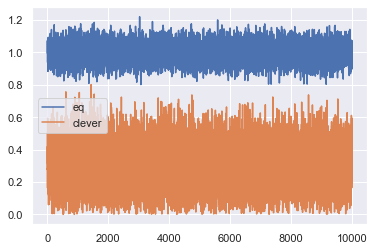

In [20]:
e_l = []
m_l = []
c_l = []

for i in range(10000):
    v = np.random.rand(100)
    e_c = target_function(v, eq_coeff(v))
    m_c = target_function(v, min_coeff(v))
    c_c = target_function(v, clever_coeff(v))
    e_l.append(e_c)
    m_l.append(m_c)
    c_l.append(c_c)
#     print(f'e_c:{e_c:.5f}, m_c:{m_c:.5f}, c_c:{c_c:.5f}')
    assert e_c > c_c
    assert m_c > c_c

# plt.plot(m_l, label="min")
plt.plot(e_l, label="eq")
plt.plot(c_l, label="clever")
plt.legend()

In [10]:
v = np.array([0.05, 0.01, 0.04])
target_function(v, eq_coeff(v))

0.06666666666666667

In [11]:
target_function(v, min_coeff(v))

0.06

In [12]:
target_function(v, clever_coeff(v))

0.04137931034482759

### IBS BOOSTING clever

In [667]:
from survivors.ensemble import BoostingCRAID

class IBSCleverBoostingCRAID(BoostingCRAID):
    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train
        pred_sf = model.predict_at_times(X_sub, bins=self.bins, mode="surv")
#         m = metr.IBS_DICT.get(self.ens_metric_name.upper(), metr.ibs)
        m = metr.ibs_WW
        wei = m(self.y_train, y_sub, pred_sf, self.bins, axis=0)
        return wei, np.mean(wei)
    
    def update_weight(self, index, wei_i):
        self.weights = 1/(1/self.weights + 1/wei_i)
    
    def get_aggreg(self, x):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        elif self.aggreg_func == 'wei':
            b = np.array(self.bettas)
            wei = 1/b*1/(np.sum(1/b))
            return np.sum((x.T*wei).T, axis=0)
        return np.mean(x, axis=0)

In [669]:
y.shape

(418,)

In [670]:
param = {'aggreg_func': 'wei', 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'],
        'criterion': 'peto', 'depth': 15, 'ens_metric_name': 'ibs_WW', 'max_features': 'sqrt',
        'min_samples_leaf': 10, 'n_estimators': 10, 'size_sample': 0.5, 
        "leaf_model": "base_fast", "all_weight": True}

X, y, features, categ, sch_nan = ds.load_pbc_dataset()

bst = IBSCleverBoostingCRAID(**param)
bst.fit(X, y)

fitted: 10 models.
